In [39]:
# This notebook has everything you need to create datasets/dataloaders, create models, hyperparameter tune with optuna 
# train a model and evaluate it

In [1]:
#Downsamples directly and uses a GRU
modelType = "BaselineGRU"

In [2]:
modelTypedict = {"Baseline": ["Downsample", "LSTM"], "BaselineGRU": ["Downsample", "GRU"],"ManualGRU": ["Manual", "GRU"], "ManualLSTM": ["Manual", "LSTM"], "ActiNetGRU": ["ActiNet", "GRU"], "ActiNetGRU": ["ActiNet", "LSTM"]}
acc_preprocess = modelTypedict[modelType][0]
RNN_type = modelTypedict[modelType][1]

In [3]:
acc_preprocess, RNN_type

('Downsample', 'GRU')

In [4]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import MulticlassCohenKappa
from IPython.display import clear_output
import optuna
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score, confusion_matrix
import seaborn as sns
from collections import Counter
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger
import wandb
from x_transformers import ContinuousTransformerWrapper, Encoder
torch.set_float32_matmul_precision('medium')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from wearables import Wearables
import time

/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up Datasets

In [5]:
data_dir = '/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/data_64Hz'

In [6]:
participant_info_df = pd.read_csv('/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/participant_info.csv')
subjects_all = participant_info_df['SID']

subjects_all_shuffled = participant_info_df['SID'].sample(frac=1, random_state=42).reset_index(drop=True)
subjects_train = subjects_all_shuffled[:int(len(subjects_all_shuffled)*0.8)]
subjects_val = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.8):int(len(subjects_all_shuffled)*0.9)]
subjects_test = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.9):]
print(f"number of subjects in train: {len(subjects_train)}")
print(f"number of subjects in val: {len(subjects_val)}")
print(f"number of subjects in test: {len(subjects_test)}")

number of subjects in train: 80
number of subjects in val: 10
number of subjects in test: 10


In [6]:
non_acc_freq = 0.2
acc_freq = 32
chunk_duration = 6000 # chunk duration in seconds
chunk_stride = 3000
train_dataset_mixed = Wearables(subjects_list=subjects_train,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq,
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in train dataset: {len(train_dataset_mixed)}")
val_dataset_mixed = Wearables(subjects_list=subjects_val,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, 
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in val dataset: {len(val_dataset_mixed)}")
test_dataset_mixed = Wearables(subjects_list=subjects_test,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq,
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in test dataset: {len(test_dataset_mixed)}")

Total samples in train dataset: 202
Total samples in val dataset: 28
Total samples in test dataset: 27


In [ ]:
#OPTIONAL, save datasets as they take a long time to create
torch.save(train_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/trainset_{chunk_duration}s.pt')
torch.save(val_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/valset_{chunk_duration}s.pt')
torch.save(test_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/testset_{chunk_duration}s.pt')

### Loading in and class weights

In [ ]:
chunk_duration = 6000
train_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/trainset_{chunk_duration}s.pt')
val_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/valset_{chunk_duration}s.pt')

In [7]:
# get class weights for weighted loss
all_labels = []
for batch in DataLoader(train_dataset_mixed, batch_size=1):
    labels = batch[2].numpy()
    all_labels.extend(labels.flatten())
all_labels = np.array(all_labels)
valid_labels = all_labels[all_labels != -1]
classes = np.arange(4)
class_counts = Counter(valid_labels)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=valid_labels
)
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: Counter({np.int64(1): 155342, np.int64(0): 53092, np.int64(3): 24240, np.int64(2): 9372})
Class weights: [1.13974798 0.38953728 6.45662612 2.49634901]


In [8]:
weight_tensor = torch.tensor(class_weights, dtype=torch.float32)

### Model Definitions

#### Acc Models

In [9]:
#"Manual" model
def extract_features(acc, window_size=160):
    # acc: [batch_size, seq_len, 3]
    batch_size, seq_len, dims = acc.shape
    assert seq_len % window_size == 0, "seq_len must be divisible by window_size"

    # Reshape: [batch_size, seq_len // window_size, window_size, 3]
    acc = acc.view(batch_size, seq_len // window_size, window_size, dims)

    # Compute features along the window dimension (dim=2)
    mean = acc.mean(dim=2)
    abs_mean = acc.abs().mean(dim=2)
    max_val = acc.max(dim=2).values
    min_val = acc.min(dim=2).values
    range_val = max_val - min_val
    var = acc.var(dim=2, unbiased=False)
    rms = torch.sqrt((acc ** 2).mean(dim=2))
    iqr = torch.quantile(acc, 0.75, dim=2) - torch.quantile(acc, 0.25, dim=2)
    q25 = torch.quantile(acc, 0.25, dim=2)
    q50 = torch.quantile(acc, 0.50, dim=2)
    q75 = torch.quantile(acc, 0.75, dim=2)

    # Concatenate all features along the last dimension
    features = torch.cat([
        mean, abs_mean, max_val, min_val, range_val, var, rms, iqr, q25, q50, q75
    ], dim=-1)  # shape: [batch_size, seq_len // 160, 33]

    return features

In [10]:
class DeepACTINeT(nn.Module):
    def __init__(self, cnn_output_channels, dropout=0.25):
        super(DeepACTINeT, self).__init__()
        # Define the layers as per the structure provided
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=512, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=cnn_output_channels, kernel_size=32, stride=2)
        
        self.dropout = nn.Dropout(dropout)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.batch_norm2 = nn.BatchNorm1d(16)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.batch_norm4 = nn.BatchNorm1d(cnn_output_channels)
    
    def forward(self, x):
        assert not torch.isnan(x).any(), "NaN detected in CNN input"
        print(x.shape)
        x = x.permute(0,2, 1) #flip channels and num samples [batch, ch, num samples]

        initial_samples = x.shape[2]
        #you want to end up with one every 5 seconds 
        final_samples = initial_samples // (32*5)

        x = F.relu(self.conv1(x))
        #print(f"Input shape after conv1: {x.shape}")
        x = self.dropout(x)
        #print(f"Input shape after, dropout: {x.shape}")
        x = self.batch_norm1(x)
        #print(f"Input shape after conv1,dropout,batchnorm: {x.shape}")
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batch_norm2(x)
        #print(f"Input shape after conv2: {x.shape}")
        
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.batch_norm3(x)
        #print(f"Input shape after conv3: {x.shape}")
        
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.batch_norm4(x)
        #print(f"before avg pooling shape: {x.shape}")

        x = F.adaptive_avg_pool1d(x, final_samples)
        #print(f"Final output shape: {x.shape}")
        
        return x

#### LSTM model 

In [11]:
#acc_preprocess = "ActiNet" or "Manual"
class SleepStager(pl.LightningModule):
    def __init__(self,
                non_acc_dim:         int,
                acc_preprocess = acc_preprocess,
                RNN_type = RNN_type,
                bidirectional = True,
                cnn_output_channels: int = 16,
                dropout_embed:   float = 0.25,
                dropout_rnn: float = 0.25,
                dropout_hidden2: float= 0.25,
                pre_rnn_embedding_size: int = 16,
                rnn_hidden_size:   int = 128,
                hidden_size2:       int = 64,
                num_sleep_stages:   int = 4,
                lr:                  float = 1e-3,
                weight_tensor:      torch.Tensor = None,
                debug:            bool = False):
        super().__init__()
        if acc_preprocess == "ActiNet":
            self.mode = "ActiNet"
            self.acc_processing = DeepACTINeT(cnn_output_channels)
            self.acc_channels = cnn_output_channels
        elif acc_preprocess == "Manual":
            self.mode = "Manual"
            self.acc_processing = extract_features
            self.acc_channels = 33
        elif acc_preprocess == "Downsample":
            self.mode = "Downsample"
            self.acc_channels = 3
        else:
            raise ValueError("ActiNet or Manual or Downsample are the only valid options")
        
        self.RNN_type = RNN_type
        self.non_acc_dim = non_acc_dim
        self.embeddingLayer = nn.Linear(self.non_acc_dim, pre_rnn_embedding_size)
        self.cnn_output_channels = cnn_output_channels

        #add non linearity to the bvp and temp before lstm 
        self.pre_rnn_embedding_size = pre_rnn_embedding_size

        self.rnn_hidden_size = rnn_hidden_size
        self.hidden_size2 = hidden_size2

        self.dropout_embed = nn.Dropout(p=dropout_embed)
        self.dropout_rnn = dropout_rnn
        self.dropout_hidden2 = nn.Dropout(p=dropout_hidden2)

        self.rnn_input_size = self.pre_rnn_embedding_size + self.acc_channels
        self.rnn_hidden_size = rnn_hidden_size

        if self.RNN_type == "GRU":
            rnn = nn.GRU
        elif self.RNN_type == "LSTM":
            rnn = nn.LSTM
        else:
            raise Exception("[Error] Unknown RnnType. Currently supported: GRU, LSTM")

        self.rnn = rnn(input_size=self.rnn_input_size,
                            hidden_size=self.rnn_hidden_size,
                            dropout = self.dropout_rnn,
                            num_layers = 2,
                            bias = True,
                            batch_first=False,
                            bidirectional = True)
       
        self.hidden2 = nn.Linear(rnn_hidden_size*2, hidden_size2)
        classifier_in = hidden_size2
        self.classifier = nn.Linear(classifier_in, num_sleep_stages)
    
        self.train_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        self.val_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        
        self.lr        = lr
        self.debug      = debug
        self.kappa = MulticlassCohenKappa(num_classes=num_sleep_stages)

    def forward(self, acc, non_acc):
        """
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        returns:
          y_hat (output_length, batch, num_sleep_stages)
        """
        # ensure ACC has a channel dim
        if acc.dim() == 2:
            acc = acc.unsqueeze(-1)          # now (batch, T, 1)
        
        # 1) ACC → CNN → (batch, num_cnn_feats, cnn_output_length)
        if self.mode == "Downsample":
            acc_feats = F.interpolate(
                acc.permute(0, 2, 1), # (batch_size, hf_input_channels, sequence_length)
                size=non_acc.shape[1],
            )
        else:
            acc_feats = self.acc_processing(acc)
        
        if self.debug:
            print(f"[DEBUG] ACC CNN output shape: {acc_feats.shape}") # (batch, num_cnn_feats, cnn_output_length)
            print(f"[DEBUG] NON_ACC input shape: {non_acc.shape}") # (batch, non_acc_length, non_acc_dim)
        
        #embed the non_acc data 
        emb_non_acc = self.embeddingLayer(non_acc)
        emb_non_acc = self.dropout_embed(emb_non_acc)
        #emb_non_acc = non_acc
        # 3) build LSTM input: (T', batch, feature_dim)
        if self.mode == "Manual":
            a = acc_feats.permute(1,0,2)
        elif self.mode == "ActiNet":
            a = acc_feats.permute(2, 0, 1)
        else:
            a = acc_feats.permute(2, 0, 1)
        b = emb_non_acc.permute(1, 0, 2)       

        if self.debug:
            print(f"[DEBUG] ACC CNN reshaped shape: {a.shape}") 
            print(f"[DEBUG] NON_ACC reshaped shape: {b.shape}")
       
        rnn_in = torch.cat([a, b], dim = 2)    # (lstm_seq_len, batch, C_cnn + D_nonacc)
        # without batch_first = true, LSTM input shape is (seq_len, batch_size, features)


        if self.debug:
            print(f"[DEBUG] RNN input shape: {rnn_in.shape}")
            print(f"[DEBUG] RNN hidden size: {self.rnn_hidden_size}")
    
        output,_ = self.rnn(rnn_in)
        output = self.hidden2(output)
        output = self.dropout_hidden2(output)
        if self.debug:
            print(f"[DEBUG] hidden2 shape: {output.shape}")
        y_hat = self.classifier(output)     # (lstm_seq_len, batch, num_sleep_stages)
        if self.debug:
            print(f"[DEBUG] Classifier output shape: {y_hat.shape}")
        return y_hat
            
    def training_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.train_criterion(y_hat_flat, labels_flat)
    
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
            
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.val_criterion(y_hat_flat, labels_flat)
    
        # calculate accuracy
        predictions = torch.argmax(y_hat_flat, dim=1)
        mask = labels_flat != -1
        masked_preds = predictions[mask]
        masked_labels = labels_flat[mask]
        if masked_labels.numel() > 0:
            acc = (masked_preds == masked_labels).float().mean().item()
        else:
            acc = 0.0
    
        # calculate cohen's kappa
        mask = labels_flat != -1
        y_valid = labels_flat[mask]
        preds_valid = predictions[mask]
        if y_valid.numel() > 0:
            ckappa = self.kappa.update(preds_valid, y_valid)
        else:
            ckappa = torch.tensor(0.0, device=self.device)

        # log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc",  acc,  prog_bar=True)
        
        return {"val_loss": loss, "val_acc": acc}
        
    def on_validation_epoch_end(self):
        k = self.kappa.compute()
        self.log("val_cohen_kappa", torch.nan_to_num(k,0.0), prog_bar=True)
        self.kappa.reset()
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.3, patience=3, verbose=True, min_lr=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # must match your validation metric
                'interval': 'epoch',
                'frequency': 1
            }
        }


### Optuna

In [12]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
def objective(trial, acc_preprocess, RNN_type, modelType):
    acc_preprocess = acc_preprocess
    RNN_type = RNN_type
    
    # Dropouts
    dropout_embed = trial.suggest_float('dropout_embed', 0.1, 0.55)
    dropout_rnn = trial.suggest_float('dropout_rnn', 0.1, 0.55)
    dropout_hidden2 = trial.suggest_float('dropout_hidden2', 0.1, 0.55)
    
    #label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.1)
    #Sizes
    pre_rnn_size = trial.suggest_categorical("pre_rnn_embedding_size", [4, 8, 16, 32, 64])
    rnn_hidden_size = trial.suggest_categorical("rnn_hidden_size", [32, 64, 128, 256, 512, 1024])
    hidden_size2 = trial.suggest_categorical("hidden_size2", [4, 8, 16, 32, 64])

    #other
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 8, 16, 32, 64])
    # batch_size = trial.suggest_categorical("batch_size", [8, 16,32,64,128])

    #bidirectional = trial.suggest_categorical("bidirectional", [True, False])
    #Conditional logic for acc_preprocess-specific parameters
    if acc_preprocess == "ActiNet":
        cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64])
        cnn_name_piece = f"_cnn{cnn_output_channels}"
    else:
        cnn_output_channels = None  # Not relevant for "Manual"
        cnn_name_piece = ""
    
    size_piece = f"prernn{pre_rnn_size}_rnn{rnn_hidden_size}_hidden{hidden_size2}"
    other_piece = f"lr{learning_rate}_batchsize{batch_size}"
    dropout_piece = f"dropoutembed{dropout_embed}_dropoutRNN{dropout_rnn}_dropouthidden2{dropout_hidden2}"
    name = size_piece+other_piece+dropout_piece+cnn_name_piece
    
    wandb_logger = WandbLogger(name, project = modelType)
    #wandb.define_metric("best_val_loss", summary="min")
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'/scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/{trial.number}/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=True,
    mode='min'
    )
    trainer = pl.Trainer(
    max_epochs=20,
    devices=1,
    accelerator=accelerator,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=2,
    )
    model = SleepStager(non_acc_dim = 5,
                        acc_preprocess = acc_preprocess,
                        RNN_type = RNN_type,
                        dropout_embed = dropout_embed,
                        dropout_rnn = dropout_rnn,
                        dropout_hidden2 = dropout_hidden2,
                        pre_rnn_embedding_size= pre_rnn_size,
                        rnn_hidden_size= rnn_hidden_size,
                        hidden_size2= hidden_size2,
                        lr = learning_rate,
                        weight_tensor=weight_tensor.to(device),
                    debug= False)
    train_loader = DataLoader(train_dataset_mixed, batch_size=batch_size, shuffle=True, num_workers = 8)
    val_loader = DataLoader(val_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = 8)
    trainer.fit(model, train_loader, val_loader)
    

    #we will pull the best model, even if it overtrained a little, so we need to go pull that best model to understand its performance
    best_model_path = checkpoint_callback.best_model_path
    print(f"Best model path: {best_model_path}")
    
    # Load the model
    best_model = SleepStager.load_from_checkpoint(best_model_path,non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = learning_rate,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    # Evaluate the best model
    trainer_best = pl.Trainer(devices=1, accelerator=accelerator)
    val_result = trainer_best.validate(best_model, val_loader, verbose=False)
    val_loss = val_result[0]["val_loss"]
    #log needed things
    wandb_logger.experiment.config.update(trial.params)
    wandb_logger.experiment.config.update({"trial_number": trial.number})
    wandb_logger.experiment.log({"best_val_loss": val_loss})
    wandb.finish()

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, acc_preprocess, RNN_type, modelType), n_trials=500)
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-30 10:06:13,931] A new study created in memory with name: no-name-a4e9b6c4-16f6-4a3a-bb9b-726fad9eeb2e
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/fre

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/0 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.2 M | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 26/26 [00:12<00:00,  2.01it/s, v_num=6px0, train_loss_step=nan.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:14<00:00,  1.75it/s, v_num=6px0, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]

Monitored metric val_loss = nan is not finite. Previous best value was inf. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 26/26 [00:15<00:00,  1.66it/s, v_num=6px0, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/0/best-checkpoint-v25.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▄▁▂▂▁▁█▅▃▃
trainer/global_step,▁▂▂▃▃▄▅▅▆▆▇▇████
val_acc,▁
val_cohen_kappa,▁
best_val_loss,nan
epoch,0
train_loss_epoch,nan
train_loss_step,nan
trainer/global_step,25
val_acc,0.20848


[W 2025-04-30 10:06:41,440] Trial 0 failed with parameters: {'dropout_embed': 0.21270342663336245, 'dropout_rnn': 0.2501217688143419, 'dropout_hidden2': 0.5329957699176361, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 1024, 'hidden_size2': 32, 'learning_rate': 0.0037351772777800356, 'batch_size': 8} because of the following error: The value nan is not acceptable.
[W 2025-04-30 10:06:41,441] Trial 0 failed with value nan.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 29.0 K | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 26/26 [00:00<00:00, 38.53it/s, v_num=bj6j, train_loss_step=1.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:02<00:00, 12.53it/s, v_num=bj6j, train_loss_step=1.660, val_loss=1.290, val_acc=0.295, val_cohen_kappa=0.101, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.293


Epoch 1: 100%|██████████| 26/26 [00:01<00:00, 15.49it/s, v_num=bj6j, train_loss_step=1.290, val_loss=1.290, val_acc=0.295, val_cohen_kappa=0.101, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:01<00:00, 14.62it/s, v_num=bj6j, train_loss_step=1.350, val_loss=1.340, val_acc=0.223, val_cohen_kappa=0.0751, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:01<00:00, 14.96it/s, v_num=bj6j, train_loss_step=1.170, val_loss=1.300, val_acc=0.247, val_cohen_kappa=0.0672, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:02<00:00,  9.32it/s, v_num=bj6j, train_loss_step=1.170, val_loss=1.260, val_acc=0.334, val_cohen_kappa=0.118, train_loss_epoch=1.280] 

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.256


Epoch 4: 100%|██████████| 26/26 [00:01<00:00, 13.98it/s, v_num=bj6j, train_loss_step=1.200, val_loss=1.260, val_acc=0.334, val_cohen_kappa=0.118, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  8.04it/s, v_num=bj6j, train_loss_step=1.200, val_loss=1.260, val_acc=0.336, val_cohen_kappa=0.128, train_loss_epoch=1.260]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.256


Epoch 5: 100%|██████████| 26/26 [00:01<00:00, 15.83it/s, v_num=bj6j, train_loss_step=1.190, val_loss=1.260, val_acc=0.336, val_cohen_kappa=0.128, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:02<00:00,  9.16it/s, v_num=bj6j, train_loss_step=1.190, val_loss=1.200, val_acc=0.334, val_cohen_kappa=0.156, train_loss_epoch=1.240]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.197


Epoch 6: 100%|██████████| 26/26 [00:01<00:00, 14.82it/s, v_num=bj6j, train_loss_step=1.360, val_loss=1.200, val_acc=0.334, val_cohen_kappa=0.156, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:02<00:00,  8.90it/s, v_num=bj6j, train_loss_step=1.360, val_loss=1.160, val_acc=0.332, val_cohen_kappa=0.177, train_loss_epoch=1.220]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.157


Epoch 7: 100%|██████████| 26/26 [00:01<00:00, 15.48it/s, v_num=bj6j, train_loss_step=1.160, val_loss=1.160, val_acc=0.332, val_cohen_kappa=0.177, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:02<00:00,  9.50it/s, v_num=bj6j, train_loss_step=1.160, val_loss=1.140, val_acc=0.268, val_cohen_kappa=0.152, train_loss_epoch=1.190]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.141


Epoch 8: 100%|██████████| 26/26 [00:01<00:00, 15.91it/s, v_num=bj6j, train_loss_step=1.370, val_loss=1.140, val_acc=0.268, val_cohen_kappa=0.152, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:02<00:00,  9.42it/s, v_num=bj6j, train_loss_step=1.370, val_loss=1.100, val_acc=0.274, val_cohen_kappa=0.157, train_loss_epoch=1.170]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.099


Epoch 9: 100%|██████████| 26/26 [00:01<00:00, 14.74it/s, v_num=bj6j, train_loss_step=0.973, val_loss=1.100, val_acc=0.274, val_cohen_kappa=0.157, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:03<00:00,  8.57it/s, v_num=bj6j, train_loss_step=0.973, val_loss=1.090, val_acc=0.336, val_cohen_kappa=0.188, train_loss_epoch=1.150]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.092


Epoch 10: 100%|██████████| 26/26 [00:01<00:00, 15.32it/s, v_num=bj6j, train_loss_step=1.090, val_loss=1.090, val_acc=0.336, val_cohen_kappa=0.188, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 26/26 [00:01<00:00, 15.25it/s, v_num=bj6j, train_loss_step=1.300, val_loss=1.180, val_acc=0.364, val_cohen_kappa=0.180, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:01<00:00, 14.90it/s, v_num=bj6j, train_loss_step=0.808, val_loss=1.200, val_acc=0.408, val_cohen_kappa=0.193, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 26/26 [00:01<00:00, 14.86it/s, v_num=bj6j, train_loss_step=0.871, val_loss=1.160, val_acc=0.318, val_cohen_kappa=0.165, train_loss_epoch=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 26/26 [00:02<00:00,  8.71it/s, v_num=bj6j, train_loss_step=0.871, val_loss=1.180, val_acc=0.358, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.092. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 26/26 [00:02<00:00,  8.71it/s, v_num=bj6j, train_loss_step=0.871, val_loss=1.180, val_acc=0.358, val_cohen_kappa=0.184, train_loss_epoch=1.040]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/1/best-checkpoint-v20.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 40.79it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇████
train_loss_epoch,█▇▇▆▆▅▅▄▄▃▃▂▂▁
train_loss_step,▇▇▆▆▅▆▅▅▅▆▆▅▅▅▅▅▅▅▄▅▆▄▃▃▄█▃▅▁▃▄▂▂▃▅▃▁▂▄▄
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇████
val_acc,▄▁▂▅▅▅▅▃▃▅▆█▅▆
val_cohen_kappa,▃▁▁▄▄▆▇▆▆█▇█▆█
val_loss,▇█▇▆▆▄▃▂▁▁▃▄▃▄
best_val_loss,1.09212
epoch,13
train_loss_epoch,1.03897


[I 2025-04-30 10:07:26,845] Trial 1 finished with value: 1.092118263244629 and parameters: {'dropout_embed': 0.15868855330739784, 'dropout_rnn': 0.2188650159743183, 'dropout_hidden2': 0.5466556515931553, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 32, 'hidden_size2': 16, 'learning_rate': 0.003152450302110979, 'batch_size': 8}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 125 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 27.93it/s, v_num=cgg4, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  7.72it/s, v_num=cgg4, train_loss_step=1.390, val_loss=1.390, val_acc=0.153, val_cohen_kappa=0.036, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.390


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  7.91it/s, v_num=cgg4, train_loss_step=1.410, val_loss=1.390, val_acc=0.153, val_cohen_kappa=0.036, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  4.42it/s, v_num=cgg4, train_loss_step=1.410, val_loss=1.390, val_acc=0.157, val_cohen_kappa=0.0382, train_loss_epoch=1.390]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.387


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  7.59it/s, v_num=cgg4, train_loss_step=1.400, val_loss=1.390, val_acc=0.157, val_cohen_kappa=0.0382, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  4.17it/s, v_num=cgg4, train_loss_step=1.400, val_loss=1.390, val_acc=0.161, val_cohen_kappa=0.0401, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.385


Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  7.70it/s, v_num=cgg4, train_loss_step=1.400, val_loss=1.390, val_acc=0.161, val_cohen_kappa=0.0401, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  4.45it/s, v_num=cgg4, train_loss_step=1.400, val_loss=1.380, val_acc=0.163, val_cohen_kappa=0.0402, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.383


Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  7.93it/s, v_num=cgg4, train_loss_step=1.380, val_loss=1.380, val_acc=0.163, val_cohen_kappa=0.0402, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  4.64it/s, v_num=cgg4, train_loss_step=1.380, val_loss=1.380, val_acc=0.164, val_cohen_kappa=0.0388, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.381


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  7.30it/s, v_num=cgg4, train_loss_step=1.380, val_loss=1.380, val_acc=0.164, val_cohen_kappa=0.0388, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  4.55it/s, v_num=cgg4, train_loss_step=1.380, val_loss=1.380, val_acc=0.166, val_cohen_kappa=0.0386, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.379


Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  7.39it/s, v_num=cgg4, train_loss_step=1.370, val_loss=1.380, val_acc=0.166, val_cohen_kappa=0.0386, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  4.37it/s, v_num=cgg4, train_loss_step=1.370, val_loss=1.380, val_acc=0.167, val_cohen_kappa=0.0385, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.377


Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  8.16it/s, v_num=cgg4, train_loss_step=1.360, val_loss=1.380, val_acc=0.167, val_cohen_kappa=0.0385, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  4.68it/s, v_num=cgg4, train_loss_step=1.360, val_loss=1.370, val_acc=0.168, val_cohen_kappa=0.0388, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.374


Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  7.94it/s, v_num=cgg4, train_loss_step=1.350, val_loss=1.370, val_acc=0.168, val_cohen_kappa=0.0388, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  4.51it/s, v_num=cgg4, train_loss_step=1.350, val_loss=1.370, val_acc=0.169, val_cohen_kappa=0.0391, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.372


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  7.89it/s, v_num=cgg4, train_loss_step=1.410, val_loss=1.370, val_acc=0.169, val_cohen_kappa=0.0391, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  4.43it/s, v_num=cgg4, train_loss_step=1.410, val_loss=1.370, val_acc=0.170, val_cohen_kappa=0.0386, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.371


Epoch 10: 100%|██████████| 13/13 [00:01<00:00,  7.83it/s, v_num=cgg4, train_loss_step=1.360, val_loss=1.370, val_acc=0.170, val_cohen_kappa=0.0386, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  4.60it/s, v_num=cgg4, train_loss_step=1.360, val_loss=1.370, val_acc=0.171, val_cohen_kappa=0.0388, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.369


Epoch 11: 100%|██████████| 13/13 [00:01<00:00,  7.73it/s, v_num=cgg4, train_loss_step=1.370, val_loss=1.370, val_acc=0.171, val_cohen_kappa=0.0388, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s, v_num=cgg4, train_loss_step=1.370, val_loss=1.370, val_acc=0.170, val_cohen_kappa=0.0379, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.367


Epoch 12: 100%|██████████| 13/13 [00:01<00:00,  7.31it/s, v_num=cgg4, train_loss_step=1.390, val_loss=1.370, val_acc=0.170, val_cohen_kappa=0.0379, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  4.25it/s, v_num=cgg4, train_loss_step=1.390, val_loss=1.370, val_acc=0.170, val_cohen_kappa=0.0368, train_loss_epoch=1.360]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.366


Epoch 13: 100%|██████████| 13/13 [00:01<00:00,  7.51it/s, v_num=cgg4, train_loss_step=1.350, val_loss=1.370, val_acc=0.170, val_cohen_kappa=0.0368, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:02<00:00,  4.47it/s, v_num=cgg4, train_loss_step=1.350, val_loss=1.360, val_acc=0.168, val_cohen_kappa=0.0354, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.364


Epoch 14: 100%|██████████| 13/13 [00:01<00:00,  8.00it/s, v_num=cgg4, train_loss_step=1.350, val_loss=1.360, val_acc=0.168, val_cohen_kappa=0.0354, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s, v_num=cgg4, train_loss_step=1.350, val_loss=1.360, val_acc=0.168, val_cohen_kappa=0.0356, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.361


Epoch 15: 100%|██████████| 13/13 [00:01<00:00,  7.60it/s, v_num=cgg4, train_loss_step=1.360, val_loss=1.360, val_acc=0.168, val_cohen_kappa=0.0356, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 13/13 [00:02<00:00,  4.36it/s, v_num=cgg4, train_loss_step=1.360, val_loss=1.360, val_acc=0.169, val_cohen_kappa=0.036, train_loss_epoch=1.360] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.360


Epoch 16: 100%|██████████| 13/13 [00:01<00:00,  8.06it/s, v_num=cgg4, train_loss_step=1.390, val_loss=1.360, val_acc=0.169, val_cohen_kappa=0.036, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:02<00:00,  4.55it/s, v_num=cgg4, train_loss_step=1.390, val_loss=1.360, val_acc=0.170, val_cohen_kappa=0.0378, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.358


Epoch 17: 100%|██████████| 13/13 [00:01<00:00,  7.34it/s, v_num=cgg4, train_loss_step=1.350, val_loss=1.360, val_acc=0.170, val_cohen_kappa=0.0378, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 13/13 [00:02<00:00,  4.49it/s, v_num=cgg4, train_loss_step=1.350, val_loss=1.360, val_acc=0.172, val_cohen_kappa=0.0402, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.356


Epoch 18: 100%|██████████| 13/13 [00:01<00:00,  7.85it/s, v_num=cgg4, train_loss_step=1.370, val_loss=1.360, val_acc=0.172, val_cohen_kappa=0.0402, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 13/13 [00:02<00:00,  4.51it/s, v_num=cgg4, train_loss_step=1.370, val_loss=1.350, val_acc=0.172, val_cohen_kappa=0.0408, train_loss_epoch=1.360]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.354


Epoch 19: 100%|██████████| 13/13 [00:01<00:00,  8.09it/s, v_num=cgg4, train_loss_step=1.330, val_loss=1.350, val_acc=0.172, val_cohen_kappa=0.0408, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s, v_num=cgg4, train_loss_step=1.330, val_loss=1.350, val_acc=0.173, val_cohen_kappa=0.0413, train_loss_epoch=1.350]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.353
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 13/13 [00:02<00:00,  4.61it/s, v_num=cgg4, train_loss_step=1.330, val_loss=1.350, val_acc=0.173, val_cohen_kappa=0.0413, train_loss_epoch=1.350]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/2/best-checkpoint-v20.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 54.36it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇██████
train_loss_epoch,██▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▁▁
train_loss_step,▂█▆▄▅▆▇▅▄▅▅▄▅▅▅▄▄▄▃▅▃▃▂▄▄▂▃▂▃▄▃▄▂▃▄▃▂▃▄▁
trainer/global_step,▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▂▄▅▅▅▆▆▇▇▇▇▇▆▆▇▇███
val_cohen_kappa,▂▄▇▇▅▅▅▅▅▅▅▄▃▁▁▂▄▇▇█
val_loss,█▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁▁
best_val_loss,1.35319
epoch,19
train_loss_epoch,1.35385


[I 2025-04-30 10:08:28,966] Trial 2 finished with value: 1.3531945943832397 and parameters: {'dropout_embed': 0.2996601218723098, 'dropout_rnn': 0.45849638744115917, 'dropout_hidden2': 0.5444467497830701, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 64, 'hidden_size2': 8, 'learning_rate': 1.621594270566752e-05, 'batch_size': 16}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 401 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 26/26 [00:00<00:00, 37.29it/s, v_num=jmic, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:02<00:00, 12.93it/s, v_num=jmic, train_loss_step=1.370, val_loss=1.360, val_acc=0.362, val_cohen_kappa=0.110, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.364


Epoch 1: 100%|██████████| 26/26 [00:01<00:00, 15.13it/s, v_num=jmic, train_loss_step=1.430, val_loss=1.360, val_acc=0.362, val_cohen_kappa=0.110, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  8.51it/s, v_num=jmic, train_loss_step=1.430, val_loss=1.360, val_acc=0.382, val_cohen_kappa=0.103, train_loss_epoch=1.370]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.364


Epoch 2: 100%|██████████| 26/26 [00:01<00:00, 13.53it/s, v_num=jmic, train_loss_step=1.380, val_loss=1.360, val_acc=0.382, val_cohen_kappa=0.103, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s, v_num=jmic, train_loss_step=1.380, val_loss=1.350, val_acc=0.361, val_cohen_kappa=0.0824, train_loss_epoch=1.360]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.355


Epoch 3: 100%|██████████| 26/26 [00:01<00:00, 13.56it/s, v_num=jmic, train_loss_step=1.380, val_loss=1.350, val_acc=0.361, val_cohen_kappa=0.0824, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  7.92it/s, v_num=jmic, train_loss_step=1.380, val_loss=1.340, val_acc=0.366, val_cohen_kappa=0.0887, train_loss_epoch=1.360]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.344


Epoch 4: 100%|██████████| 26/26 [00:01<00:00, 13.75it/s, v_num=jmic, train_loss_step=1.350, val_loss=1.340, val_acc=0.366, val_cohen_kappa=0.0887, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  8.13it/s, v_num=jmic, train_loss_step=1.350, val_loss=1.340, val_acc=0.328, val_cohen_kappa=0.0783, train_loss_epoch=1.360]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.338


Epoch 5: 100%|██████████| 26/26 [00:01<00:00, 14.10it/s, v_num=jmic, train_loss_step=1.160, val_loss=1.340, val_acc=0.328, val_cohen_kappa=0.0783, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  8.48it/s, v_num=jmic, train_loss_step=1.160, val_loss=1.340, val_acc=0.334, val_cohen_kappa=0.0579, train_loss_epoch=1.350]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.337


Epoch 6: 100%|██████████| 26/26 [00:02<00:00, 12.91it/s, v_num=jmic, train_loss_step=1.370, val_loss=1.340, val_acc=0.334, val_cohen_kappa=0.0579, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:01<00:00, 13.39it/s, v_num=jmic, train_loss_step=1.290, val_loss=1.340, val_acc=0.352, val_cohen_kappa=0.0605, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  8.02it/s, v_num=jmic, train_loss_step=1.290, val_loss=1.330, val_acc=0.314, val_cohen_kappa=0.0652, train_loss_epoch=1.350]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.328


Epoch 8: 100%|██████████| 26/26 [00:01<00:00, 13.50it/s, v_num=jmic, train_loss_step=1.400, val_loss=1.330, val_acc=0.314, val_cohen_kappa=0.0652, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  7.84it/s, v_num=jmic, train_loss_step=1.400, val_loss=1.320, val_acc=0.334, val_cohen_kappa=0.0713, train_loss_epoch=1.350]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.324


Epoch 9: 100%|██████████| 26/26 [00:01<00:00, 14.25it/s, v_num=jmic, train_loss_step=1.430, val_loss=1.320, val_acc=0.334, val_cohen_kappa=0.0713, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:03<00:00,  8.09it/s, v_num=jmic, train_loss_step=1.430, val_loss=1.320, val_acc=0.297, val_cohen_kappa=0.0664, train_loss_epoch=1.340]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.316


Epoch 10: 100%|██████████| 26/26 [00:01<00:00, 13.42it/s, v_num=jmic, train_loss_step=1.340, val_loss=1.320, val_acc=0.297, val_cohen_kappa=0.0664, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:03<00:00,  8.07it/s, v_num=jmic, train_loss_step=1.340, val_loss=1.310, val_acc=0.299, val_cohen_kappa=0.0574, train_loss_epoch=1.330]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.314


Epoch 11: 100%|██████████| 26/26 [00:02<00:00, 12.46it/s, v_num=jmic, train_loss_step=1.360, val_loss=1.310, val_acc=0.299, val_cohen_kappa=0.0574, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 26/26 [00:03<00:00,  7.75it/s, v_num=jmic, train_loss_step=1.360, val_loss=1.310, val_acc=0.277, val_cohen_kappa=0.0559, train_loss_epoch=1.330]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.310


Epoch 12: 100%|██████████| 26/26 [00:01<00:00, 13.37it/s, v_num=jmic, train_loss_step=1.410, val_loss=1.310, val_acc=0.277, val_cohen_kappa=0.0559, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:03<00:00,  8.06it/s, v_num=jmic, train_loss_step=1.410, val_loss=1.300, val_acc=0.279, val_cohen_kappa=0.0667, train_loss_epoch=1.330]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.301


Epoch 13: 100%|██████████| 26/26 [00:01<00:00, 13.44it/s, v_num=jmic, train_loss_step=1.260, val_loss=1.300, val_acc=0.279, val_cohen_kappa=0.0667, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 26/26 [00:03<00:00,  7.97it/s, v_num=jmic, train_loss_step=1.260, val_loss=1.290, val_acc=0.249, val_cohen_kappa=0.0665, train_loss_epoch=1.320]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.291


Epoch 14: 100%|██████████| 26/26 [00:01<00:00, 13.78it/s, v_num=jmic, train_loss_step=1.300, val_loss=1.290, val_acc=0.249, val_cohen_kappa=0.0665, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 26/26 [00:03<00:00,  7.93it/s, v_num=jmic, train_loss_step=1.300, val_loss=1.280, val_acc=0.233, val_cohen_kappa=0.0643, train_loss_epoch=1.320]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.277


Epoch 15: 100%|██████████| 26/26 [00:02<00:00, 12.95it/s, v_num=jmic, train_loss_step=1.240, val_loss=1.280, val_acc=0.233, val_cohen_kappa=0.0643, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 26/26 [00:03<00:00,  7.90it/s, v_num=jmic, train_loss_step=1.240, val_loss=1.270, val_acc=0.212, val_cohen_kappa=0.0689, train_loss_epoch=1.310]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.266


Epoch 16: 100%|██████████| 26/26 [00:01<00:00, 13.57it/s, v_num=jmic, train_loss_step=1.330, val_loss=1.270, val_acc=0.212, val_cohen_kappa=0.0689, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 26/26 [00:03<00:00,  8.20it/s, v_num=jmic, train_loss_step=1.330, val_loss=1.260, val_acc=0.228, val_cohen_kappa=0.0795, train_loss_epoch=1.310]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.262


Epoch 17: 100%|██████████| 26/26 [00:01<00:00, 13.29it/s, v_num=jmic, train_loss_step=1.430, val_loss=1.260, val_acc=0.228, val_cohen_kappa=0.0795, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 26/26 [00:01<00:00, 13.05it/s, v_num=jmic, train_loss_step=1.330, val_loss=1.280, val_acc=0.247, val_cohen_kappa=0.0732, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 26/26 [00:03<00:00,  7.91it/s, v_num=jmic, train_loss_step=1.330, val_loss=1.260, val_acc=0.250, val_cohen_kappa=0.0777, train_loss_epoch=1.300]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.260


Epoch 19: 100%|██████████| 26/26 [00:01<00:00, 13.56it/s, v_num=jmic, train_loss_step=1.220, val_loss=1.260, val_acc=0.250, val_cohen_kappa=0.0777, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 26/26 [00:03<00:00,  7.72it/s, v_num=jmic, train_loss_step=1.220, val_loss=1.280, val_acc=0.252, val_cohen_kappa=0.0837, train_loss_epoch=1.300]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 26/26 [00:03<00:00,  7.72it/s, v_num=jmic, train_loss_step=1.220, val_loss=1.280, val_acc=0.252, val_cohen_kappa=0.0837, train_loss_epoch=1.300]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/3/best-checkpoint-v20.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.80it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss_epoch,█▇▆▆▆▆▆▅▅▅▄▄▄▃▃▂▂▁▁▁
train_loss_step,▆▆▆▆▇▅▇█▆▅█▅▆▆▆▆▃▅▅▆▄▇▄▃▆▄▇▆▄▄▄▄▆▂▃▇▃▁▁▆
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▇█▇▇▆▆▇▅▆▅▅▄▄▃▂▁▂▂▃▃
val_cohen_kappa,█▇▄▅▄▁▂▂▃▂▁▁▂▂▂▃▄▃▄▅
val_loss,██▇▇▆▆▇▆▅▅▅▄▄▃▂▁▁▃▁▃
best_val_loss,1.25983
epoch,19
train_loss_epoch,1.29626


[I 2025-04-30 10:09:37,728] Trial 3 finished with value: 1.2598332166671753 and parameters: {'dropout_embed': 0.10571931038438814, 'dropout_rnn': 0.21784625988827078, 'dropout_hidden2': 0.27861817975586955, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 128, 'hidden_size2': 4, 'learning_rate': 0.0001397040280616853, 'batch_size': 8}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.3 M | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s, v_num=jejk, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s, v_num=jejk, train_loss_step=1.370, val_loss=1.360, val_acc=0.209, val_cohen_kappa=0.0458, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.358


Epoch 1: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s, v_num=jejk, train_loss_step=1.320, val_loss=1.360, val_acc=0.209, val_cohen_kappa=0.0458, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s, v_num=jejk, train_loss_step=1.320, val_loss=1.300, val_acc=0.275, val_cohen_kappa=0.0928, train_loss_epoch=1.350]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.298


Epoch 2: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s, v_num=jejk, train_loss_step=1.390, val_loss=1.300, val_acc=0.275, val_cohen_kappa=0.0928, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s, v_num=jejk, train_loss_step=1.390, val_loss=1.280, val_acc=0.234, val_cohen_kappa=0.0865, train_loss_epoch=1.330]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.283


Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s, v_num=jejk, train_loss_step=1.330, val_loss=1.280, val_acc=0.234, val_cohen_kappa=0.0865, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s, v_num=jejk, train_loss_step=1.330, val_loss=1.250, val_acc=0.246, val_cohen_kappa=0.0994, train_loss_epoch=1.310]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.253


Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s, v_num=jejk, train_loss_step=1.340, val_loss=1.250, val_acc=0.246, val_cohen_kappa=0.0994, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s, v_num=jejk, train_loss_step=1.360, val_loss=1.310, val_acc=0.259, val_cohen_kappa=0.0793, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s, v_num=jejk, train_loss_step=1.250, val_loss=1.280, val_acc=0.218, val_cohen_kappa=0.0839, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s, v_num=jejk, train_loss_step=1.330, val_loss=1.270, val_acc=0.240, val_cohen_kappa=0.0897, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s, v_num=jejk, train_loss_step=1.330, val_loss=1.270, val_acc=0.250, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.253. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s, v_num=jejk, train_loss_step=1.330, val_loss=1.270, val_acc=0.250, val_cohen_kappa=0.0975, train_loss_epoch=1.300]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/4/best-checkpoint-v20.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_loss_epoch,█▄▃▂▁▁▁▁
train_loss_step,▇█▇▇▅▆▅▅▄▄▆▅▃▅▆▄▅▂▂▇▅▃▂▄▄▂▃▅▄▃▆▄▅▁▃▄▂▅▂▅
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▁█▄▅▆▂▄▅
val_cohen_kappa,▁▇▆█▅▆▇█
val_loss,█▄▃▁▄▃▂▂
best_val_loss,1.25336
epoch,7
train_loss_epoch,1.3044


[I 2025-04-30 10:11:07,380] Trial 4 finished with value: 1.2533575296401978 and parameters: {'dropout_embed': 0.1215932791073785, 'dropout_rnn': 0.33050992011086416, 'dropout_hidden2': 0.3976724959253982, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 1024, 'hidden_size2': 8, 'learning_rate': 6.89196966717081e-05, 'batch_size': 16}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 16.71it/s, v_num=kh85, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s, v_num=kh85, train_loss_step=1.410, val_loss=1.230, val_acc=0.324, val_cohen_kappa=0.108, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.227


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  4.50it/s, v_num=kh85, train_loss_step=1.270, val_loss=1.230, val_acc=0.324, val_cohen_kappa=0.108, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.94it/s, v_num=kh85, train_loss_step=1.370, val_loss=1.330, val_acc=0.243, val_cohen_kappa=0.0756, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  4.02it/s, v_num=kh85, train_loss_step=1.140, val_loss=1.240, val_acc=0.268, val_cohen_kappa=0.0975, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  3.77it/s, v_num=kh85, train_loss_step=1.240, val_loss=1.280, val_acc=0.246, val_cohen_kappa=0.0877, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, v_num=kh85, train_loss_step=1.240, val_loss=1.250, val_acc=0.244, val_cohen_kappa=0.09

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.227. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, v_num=kh85, train_loss_step=1.240, val_loss=1.250, val_acc=0.244, val_cohen_kappa=0.0954, train_loss_epoch=1.270]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/5/best-checkpoint-v20.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆█████
train_loss_epoch,█▄▃▁▁
train_loss_step,▇██▄▅▆▄▆▅▅▅▄▅▁▅▄▄
trainer/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇████
val_acc,█▁▃▁▁
val_cohen_kappa,█▁▆▄▅
val_loss,▁█▂▅▂
best_val_loss,1.22684
epoch,4
train_loss_epoch,1.26685


[I 2025-04-30 10:11:26,181] Trial 5 finished with value: 1.2268370389938354 and parameters: {'dropout_embed': 0.49683732566166317, 'dropout_rnn': 0.17522713852004443, 'dropout_hidden2': 0.3462802559618343, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 64, 'learning_rate': 0.002236348653005376, 'batch_size': 32}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.2 M | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s, v_num=m7v0, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:07<00:00,  0.99it/s, v_num=m7v0, train_loss_step=1.390, val_loss=1.340, val_acc=0.349, val_cohen_kappa=0.0736, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.345


Epoch 1: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, v_num=m7v0, train_loss_step=1.390, val_loss=1.340, val_acc=0.349, val_cohen_kappa=0.0736, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s, v_num=m7v0, train_loss_step=1.330, val_loss=1.350, val_acc=0.396, val_cohen_kappa=0.0601, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:08<00:00,  0.85it/s, v_num=m7v0, train_loss_step=1.330, val_loss=1.340, val_acc=0.380, val_cohen_kappa=0.0828, train_loss_epoch=1.380]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.338


Epoch 3: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, v_num=m7v0, train_loss_step=1.400, val_loss=1.340, val_acc=0.380, val_cohen_kappa=0.0828, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s, v_num=m7v0, train_loss_step=1.360, val_loss=1.340, val_acc=0.348, val_cohen_kappa=0.0603, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s, v_num=m7v0, train_loss_step=1.420, val_loss=1.340, val_acc=0.346, val_cohen_kappa=0.0691, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:08<00:00,  0.84it/s, v_num=m7v0, train_loss_step=1.420, val_loss=1.340, val_acc=0.291, val_cohen_kappa=0.0325, train_loss_epoch=1.370]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.337


Epoch 6: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, v_num=m7v0, train_loss_step=1.390, val_loss=1.340, val_acc=0.291, val_cohen_kappa=0.0325, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, v_num=m7v0, train_loss_step=1.410, val_loss=1.350, val_acc=0.375, val_cohen_kappa=0.0563, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, v_num=m7v0, train_loss_step=1.340, val_loss=1.340, val_acc=0.388, val_cohen_kappa=0.0711, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:08<00:00,  0.86it/s, v_num=m7v0, train_loss_step=1.340, val_loss=1.330, val_acc=0.350, val_cohen_kappa=0.0615, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.334


Epoch 9: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, v_num=m7v0, train_loss_step=1.380, val_loss=1.330, val_acc=0.350, val_cohen_kappa=0.0615, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:08<00:00,  0.85it/s, v_num=m7v0, train_loss_step=1.380, val_loss=1.330, val_acc=0.304, val_cohen_kappa=0.0559, train_loss_epoch=1.370]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.332


Epoch 10: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s, v_num=m7v0, train_loss_step=1.360, val_loss=1.330, val_acc=0.304, val_cohen_kappa=0.0559, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:08<00:00,  0.85it/s, v_num=m7v0, train_loss_step=1.360, val_loss=1.330, val_acc=0.280, val_cohen_kappa=0.0547, train_loss_epoch=1.360]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.332


Epoch 11: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s, v_num=m7v0, train_loss_step=1.350, val_loss=1.330, val_acc=0.280, val_cohen_kappa=0.0547, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, v_num=m7v0, train_loss_step=1.360, val_loss=1.330, val_acc=0.274, val_cohen_kappa=0.0703, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 7/7 [00:08<00:00,  0.85it/s, v_num=m7v0, train_loss_step=1.360, val_loss=1.330, val_acc=0.317, val_cohen_kappa=0.0704, train_loss_epoch=1.360]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.325


Epoch 13: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s, v_num=m7v0, train_loss_step=1.360, val_loss=1.330, val_acc=0.317, val_cohen_kappa=0.0704, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 7/7 [00:08<00:00,  0.84it/s, v_num=m7v0, train_loss_step=1.360, val_loss=1.320, val_acc=0.348, val_cohen_kappa=0.0892, train_loss_epoch=1.360]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.318


Epoch 14: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, v_num=m7v0, train_loss_step=1.340, val_loss=1.320, val_acc=0.348, val_cohen_kappa=0.0892, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, v_num=m7v0, train_loss_step=1.310, val_loss=1.330, val_acc=0.301, val_cohen_kappa=0.0646, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, v_num=m7v0, train_loss_step=1.310, val_loss=1.330, val_acc=0.278, val_cohen_kappa=0.0514, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 7/7 [00:08<00:00,  0.84it/s, v_num=m7v0, train_loss_step=1.310, val_loss=1.320, val_acc=0.299, val_cohen_kappa=0.0759, train_loss_epoch=1.350]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.315


Epoch 17: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, v_num=m7v0, train_loss_step=1.350, val_loss=1.320, val_acc=0.299, val_cohen_kappa=0.0759, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, v_num=m7v0, train_loss_step=1.360, val_loss=1.320, val_acc=0.301, val_cohen_kappa=0.0766, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 7/7 [00:08<00:00,  0.83it/s, v_num=m7v0, train_loss_step=1.360, val_loss=1.310, val_acc=0.366, val_cohen_kappa=0.102, train_loss_epoch=1.360] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.315


Epoch 19: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, v_num=m7v0, train_loss_step=1.370, val_loss=1.310, val_acc=0.366, val_cohen_kappa=0.102, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 7/7 [00:08<00:00,  0.85it/s, v_num=m7v0, train_loss_step=1.370, val_loss=1.310, val_acc=0.307, val_cohen_kappa=0.108, train_loss_epoch=1.360]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.315
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 7/7 [00:08<00:00,  0.79it/s, v_num=m7v0, train_loss_step=1.370, val_loss=1.310, val_acc=0.307, val_cohen_kappa=0.108, train_loss_epoch=1.360]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/6/best-checkpoint-v20.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇██
train_loss_epoch,█▆▅▅▅▄▄▄▄▃▃▄▃▂▂▃▁▁▂▂
train_loss_step,▇▆▆▇▅▄▆▅▅▃▇▅▄▆▄▇▆▅▃▃▅▄▄█▄▃▄▃▄▂▁▆▆▃▄▅▃▃▅▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇███
val_acc,▅█▇▅▅▂▇█▅▃▁▁▃▅▃▁▂▃▆▃
val_cohen_kappa,▅▄▆▄▄▁▃▅▄▃▃▅▅▆▄▃▅▅▇█
val_loss,▇█▆▆▇▆█▇▅▅▅▅▃▂▅▃▁▂▁▁
best_val_loss,1.31454
epoch,19
train_loss_epoch,1.35834


[I 2025-04-30 10:14:23,193] Trial 6 finished with value: 1.3145383596420288 and parameters: {'dropout_embed': 0.29868068763647093, 'dropout_rnn': 0.24409767158640244, 'dropout_hidden2': 0.47413234468848, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 1024, 'hidden_size2': 4, 'learning_rate': 0.00016903069367607757, 'batch_size': 32}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 423 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 26/26 [00:00<00:00, 37.56it/s, v_num=d8j4, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:02<00:00, 12.15it/s, v_num=d8j4, train_loss_step=1.380, val_loss=1.370, val_acc=0.194, val_cohen_kappa=0.0464, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.366


Epoch 1: 100%|██████████| 26/26 [00:01<00:00, 13.05it/s, v_num=d8j4, train_loss_step=1.340, val_loss=1.370, val_acc=0.194, val_cohen_kappa=0.0464, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  7.37it/s, v_num=d8j4, train_loss_step=1.340, val_loss=1.350, val_acc=0.206, val_cohen_kappa=0.051, train_loss_epoch=1.360] 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.351


Epoch 2: 100%|██████████| 26/26 [00:02<00:00, 12.57it/s, v_num=d8j4, train_loss_step=1.360, val_loss=1.350, val_acc=0.206, val_cohen_kappa=0.051, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  7.62it/s, v_num=d8j4, train_loss_step=1.360, val_loss=1.340, val_acc=0.215, val_cohen_kappa=0.0582, train_loss_epoch=1.350]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.336


Epoch 3: 100%|██████████| 26/26 [00:02<00:00, 12.89it/s, v_num=d8j4, train_loss_step=1.350, val_loss=1.340, val_acc=0.215, val_cohen_kappa=0.0582, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  7.56it/s, v_num=d8j4, train_loss_step=1.350, val_loss=1.330, val_acc=0.218, val_cohen_kappa=0.0511, train_loss_epoch=1.330]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.326


Epoch 4: 100%|██████████| 26/26 [00:02<00:00, 12.25it/s, v_num=d8j4, train_loss_step=1.240, val_loss=1.330, val_acc=0.218, val_cohen_kappa=0.0511, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  7.45it/s, v_num=d8j4, train_loss_step=1.240, val_loss=1.310, val_acc=0.212, val_cohen_kappa=0.0491, train_loss_epoch=1.320]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.312


Epoch 5: 100%|██████████| 26/26 [00:02<00:00, 12.67it/s, v_num=d8j4, train_loss_step=1.340, val_loss=1.310, val_acc=0.212, val_cohen_kappa=0.0491, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  7.52it/s, v_num=d8j4, train_loss_step=1.340, val_loss=1.300, val_acc=0.220, val_cohen_kappa=0.0524, train_loss_epoch=1.310]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.302


Epoch 6: 100%|██████████| 26/26 [00:01<00:00, 13.00it/s, v_num=d8j4, train_loss_step=1.330, val_loss=1.300, val_acc=0.220, val_cohen_kappa=0.0524, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  7.68it/s, v_num=d8j4, train_loss_step=1.330, val_loss=1.290, val_acc=0.233, val_cohen_kappa=0.0595, train_loss_epoch=1.300]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.294


Epoch 7: 100%|██████████| 26/26 [00:01<00:00, 13.33it/s, v_num=d8j4, train_loss_step=1.240, val_loss=1.290, val_acc=0.233, val_cohen_kappa=0.0595, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  7.73it/s, v_num=d8j4, train_loss_step=1.240, val_loss=1.280, val_acc=0.239, val_cohen_kappa=0.0635, train_loss_epoch=1.290]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.284


Epoch 8: 100%|██████████| 26/26 [00:02<00:00, 12.75it/s, v_num=d8j4, train_loss_step=1.130, val_loss=1.280, val_acc=0.239, val_cohen_kappa=0.0635, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  7.75it/s, v_num=d8j4, train_loss_step=1.130, val_loss=1.280, val_acc=0.233, val_cohen_kappa=0.063, train_loss_epoch=1.290] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.280


Epoch 9: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, v_num=d8j4, train_loss_step=1.490, val_loss=1.280, val_acc=0.233, val_cohen_kappa=0.063, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:03<00:00,  7.99it/s, v_num=d8j4, train_loss_step=1.490, val_loss=1.280, val_acc=0.242, val_cohen_kappa=0.0673, train_loss_epoch=1.280]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.276


Epoch 10: 100%|██████████| 26/26 [00:01<00:00, 13.39it/s, v_num=d8j4, train_loss_step=1.350, val_loss=1.280, val_acc=0.242, val_cohen_kappa=0.0673, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:03<00:00,  8.04it/s, v_num=d8j4, train_loss_step=1.350, val_loss=1.270, val_acc=0.243, val_cohen_kappa=0.0698, train_loss_epoch=1.270]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.269


Epoch 11: 100%|██████████| 26/26 [00:02<00:00, 12.70it/s, v_num=d8j4, train_loss_step=1.350, val_loss=1.270, val_acc=0.243, val_cohen_kappa=0.0698, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s, v_num=d8j4, train_loss_step=1.350, val_loss=1.270, val_acc=0.242, val_cohen_kappa=0.0717, train_loss_epoch=1.270]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.266


Epoch 12: 100%|██████████| 26/26 [00:02<00:00, 12.78it/s, v_num=d8j4, train_loss_step=1.360, val_loss=1.270, val_acc=0.242, val_cohen_kappa=0.0717, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:03<00:00,  7.61it/s, v_num=d8j4, train_loss_step=1.360, val_loss=1.260, val_acc=0.249, val_cohen_kappa=0.0752, train_loss_epoch=1.270]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.265


Epoch 13: 100%|██████████| 26/26 [00:01<00:00, 13.31it/s, v_num=d8j4, train_loss_step=1.410, val_loss=1.260, val_acc=0.249, val_cohen_kappa=0.0752, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 26/26 [00:03<00:00,  8.13it/s, v_num=d8j4, train_loss_step=1.410, val_loss=1.260, val_acc=0.250, val_cohen_kappa=0.0749, train_loss_epoch=1.270]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.265


Epoch 14: 100%|██████████| 26/26 [00:02<00:00, 12.99it/s, v_num=d8j4, train_loss_step=1.480, val_loss=1.260, val_acc=0.250, val_cohen_kappa=0.0749, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 26/26 [00:02<00:00, 12.96it/s, v_num=d8j4, train_loss_step=1.510, val_loss=1.280, val_acc=0.254, val_cohen_kappa=0.0715, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 26/26 [00:01<00:00, 13.32it/s, v_num=d8j4, train_loss_step=1.250, val_loss=1.270, val_acc=0.249, val_cohen_kappa=0.0715, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 26/26 [00:02<00:00, 12.59it/s, v_num=d8j4, train_loss_step=1.340, val_loss=1.270, val_acc=0.251, val_cohen_kappa=0.0751, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 26/26 [00:03<00:00,  7.63it/s, v_num=d8j4, train_loss_step=1.340, val_loss=1.270, val_acc=0.253, val_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.265. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 26/26 [00:03<00:00,  7.63it/s, v_num=d8j4, train_loss_step=1.340, val_loss=1.270, val_acc=0.253, val_cohen_kappa=0.0741, train_loss_epoch=1.260]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/7/best-checkpoint-v20.ckpt
Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 49.19it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
train_loss_epoch,█▇▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁
train_loss_step,█▇▇▇▆▇▇█▆▇▇▆▆▆▆▇▄▅▄▄▇▆▁▄█▃▇█▄▆▄▄▆▂▄▇▄▁▁▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇███
val_acc,▁▂▄▄▃▄▆▆▆▇▇▇▇██▇██
val_cohen_kappa,▁▂▄▂▂▂▄▅▅▆▇▇██▇▇██
val_loss,█▇▆▅▄▄▃▂▂▂▁▁▁▁▂▂▁▁
best_val_loss,1.26483
epoch,17
train_loss_epoch,1.25578


[I 2025-04-30 10:15:29,364] Trial 7 finished with value: 1.2648271322250366 and parameters: {'dropout_embed': 0.2709850099722742, 'dropout_rnn': 0.13644545028313454, 'dropout_hidden2': 0.17810107080459653, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 128, 'hidden_size2': 32, 'learning_rate': 4.505773452531758e-05, 'batch_size': 8}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 6.3 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s, v_num=hhdb, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s, v_num=hhdb, train_loss_step=1.360, val_loss=1.240, val_acc=0.246, val_cohen_kappa=0.0876, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.238


Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s, v_num=hhdb, train_loss_step=1.310, val_loss=1.240, val_acc=0.246, val_cohen_kappa=0.0876, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s, v_num=hhdb, train_loss_step=1.330, val_loss=1.290, val_acc=0.311, val_cohen_kappa=0.0886, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s, v_num=hhdb, train_loss_step=1.330, val_loss=1.240, val_acc=0.223, val_cohen_kappa=0.0979, train_loss_epoch=1.310]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.237


Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s, v_num=hhdb, train_loss_step=1.310, val_loss=1.240, val_acc=0.223, val_cohen_kappa=0.0979, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s, v_num=hhdb, train_loss_step=1.230, val_loss=1.250, val_acc=0.261, val_cohen_kappa=0.0734, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s, v_num=hhdb, train_loss_step=1.230, val_loss=1.210, val_acc=0.222, val_cohen_kappa=0.0811, train_loss_epoch=1.290]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.208


Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s, v_num=hhdb, train_loss_step=1.320, val_loss=1.210, val_acc=0.222, val_cohen_kappa=0.0811, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s, v_num=hhdb, train_loss_step=1.350, val_loss=1.240, val_acc=0.237, val_cohen_kappa=0.089, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s, v_num=hhdb, train_loss_step=1.300, val_loss=1.310, val_acc=0.267, val_cohen_kappa=0.0801, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s, v_num=hhdb, train_loss_step=1.310, val_loss=1.240, val_acc=0.271, val_cohen_kappa=0.121, train_loss_epoch=1.270] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s, v_num=hhdb, train_loss_step=1.310, val_loss=1.190, val_acc=0.341, val_cohen_kappa=0.1

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.186


Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s, v_num=hhdb, train_loss_step=1.200, val_loss=1.190, val_acc=0.341, val_cohen_kappa=0.158, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s, v_num=hhdb, train_loss_step=1.070, val_loss=1.200, val_acc=0.271, val_cohen_kappa=0.137, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s, v_num=hhdb, train_loss_step=1.380, val_loss=1.230, val_acc=0.241, val_cohen_kappa=0.117, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s, v_num=hhdb, train_loss_step=1.140, val_loss=1.290, val_acc=0.343, val_cohen_kappa=0.144, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s, v_num=hhdb, train_loss_step=1.140, val_loss=1.190, val_acc=0.250, val_cohen_kappa=0.1

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.186


Epoch 13: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s, v_num=hhdb, train_loss_step=1.230, val_loss=1.190, val_acc=0.250, val_cohen_kappa=0.132, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s, v_num=hhdb, train_loss_step=1.230, val_loss=1.170, val_acc=0.328, val_cohen_kappa=0.181, train_loss_epoch=1.210]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.167


Epoch 14: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s, v_num=hhdb, train_loss_step=1.220, val_loss=1.170, val_acc=0.328, val_cohen_kappa=0.181, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s, v_num=hhdb, train_loss_step=1.220, val_loss=1.150, val_acc=0.371, val_cohen_kappa=0.163, train_loss_epoch=1.200]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.153


Epoch 15: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s, v_num=hhdb, train_loss_step=1.140, val_loss=1.150, val_acc=0.371, val_cohen_kappa=0.163, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s, v_num=hhdb, train_loss_step=1.140, val_loss=1.140, val_acc=0.368, val_cohen_kappa=0.197, train_loss_epoch=1.220]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.144


Epoch 16: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s, v_num=hhdb, train_loss_step=1.270, val_loss=1.140, val_acc=0.368, val_cohen_kappa=0.197, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s, v_num=hhdb, train_loss_step=1.110, val_loss=1.230, val_acc=0.324, val_cohen_kappa=0.160, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 7/7 [00:03<00:00,  2.00it/s, v_num=hhdb, train_loss_step=1.180, val_loss=1.180, val_acc=0.297, val_cohen_kappa=0.166, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s, v_num=hhdb, train_loss_step=1.330, val_loss=1.190, val_acc=0.436, val_cohen_kappa=0.192, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s, v_num=hhdb, train_loss_step=1.330, val_loss=1.090, val_acc=0.294, val_cohen_kappa=0.

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.092
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s, v_num=hhdb, train_loss_step=1.330, val_loss=1.090, val_acc=0.294, val_cohen_kappa=0.169, train_loss_epoch=1.180]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/8/best-checkpoint-v20.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███████
train_loss_epoch,█▆▆▆▅▅▅▄▄▄▄▃▃▃▂▃▂▁▁▁
train_loss_step,█▇▇█▆▆▇▆▆▆▇▆▇▅▆▅▄▆▅▅▄▆▇▄█▄▆▅▅▄▃▄▂▄▃▃▄▂▁▇
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
val_acc,▂▄▁▂▁▁▂▃▅▃▂▅▂▄▆▆▄▃█▃
val_cohen_kappa,▂▂▂▁▁▂▁▄▆▅▃▅▄▇▆█▆▆█▆
val_loss,▆█▆▆▅▆█▆▄▄▅▇▄▃▃▃▆▄▄▁
best_val_loss,1.09244
epoch,19
train_loss_epoch,1.17802


[I 2025-04-30 10:17:09,199] Trial 8 finished with value: 1.0924386978149414 and parameters: {'dropout_embed': 0.3258239943132759, 'dropout_rnn': 0.21988173877095568, 'dropout_hidden2': 0.40513734665472967, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 512, 'hidden_size2': 16, 'learning_rate': 0.0005723472588698123, 'batch_size': 32}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.6 M | train
4 | hidden2         | Linear               | 131 K  | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s, v_num=u3k1, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s, v_num=u3k1, train_loss_step=1.350, val_loss=1.320, val_acc=0.389, val_cohen_kappa=0.122, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.325


Epoch 1: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s, v_num=u3k1, train_loss_step=1.320, val_loss=1.320, val_acc=0.389, val_cohen_kappa=0.122, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:08<00:00,  0.85it/s, v_num=u3k1, train_loss_step=1.320, val_loss=1.310, val_acc=0.248, val_cohen_kappa=0.0731, train_loss_epoch=1.310]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.310


Epoch 2: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s, v_num=u3k1, train_loss_step=1.310, val_loss=1.310, val_acc=0.248, val_cohen_kappa=0.0731, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:08<00:00,  0.81it/s, v_num=u3k1, train_loss_step=1.310, val_loss=1.310, val_acc=0.212, val_cohen_kappa=0.0664, train_loss_epoch=1.280]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.308


Epoch 3: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s, v_num=u3k1, train_loss_step=1.200, val_loss=1.310, val_acc=0.212, val_cohen_kappa=0.0664, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:08<00:00,  0.84it/s, v_num=u3k1, train_loss_step=1.200, val_loss=1.270, val_acc=0.216, val_cohen_kappa=0.0698, train_loss_epoch=1.270]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.274


Epoch 4: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, v_num=u3k1, train_loss_step=1.390, val_loss=1.270, val_acc=0.216, val_cohen_kappa=0.0698, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:08<00:00,  0.86it/s, v_num=u3k1, train_loss_step=1.390, val_loss=1.270, val_acc=0.226, val_cohen_kappa=0.0671, train_loss_epoch=1.270]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.268


Epoch 5: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s, v_num=u3k1, train_loss_step=1.290, val_loss=1.270, val_acc=0.226, val_cohen_kappa=0.0671, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, v_num=u3k1, train_loss_step=1.300, val_loss=1.290, val_acc=0.266, val_cohen_kappa=0.0644, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, v_num=u3k1, train_loss_step=1.170, val_loss=1.290, val_acc=0.283, val_cohen_kappa=0.0755, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, v_num=u3k1, train_loss_step=1.200, val_loss=1.300, val_acc=0.268, val_cohen_kappa=0.0709, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:08<00:00,  0.86it/s, v_num=u3k1, train_loss_step=1.200, val_loss=1.260, val_acc=0.251, val_cohen_kappa=0.0

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.262


Epoch 9: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, v_num=u3k1, train_loss_step=1.320, val_loss=1.260, val_acc=0.251, val_cohen_kappa=0.0725, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:08<00:00,  0.82it/s, v_num=u3k1, train_loss_step=1.320, val_loss=1.250, val_acc=0.245, val_cohen_kappa=0.0659, train_loss_epoch=1.260]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.254


Epoch 10: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, v_num=u3k1, train_loss_step=1.140, val_loss=1.250, val_acc=0.245, val_cohen_kappa=0.0659, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:08<00:00,  0.81it/s, v_num=u3k1, train_loss_step=1.140, val_loss=1.250, val_acc=0.254, val_cohen_kappa=0.0772, train_loss_epoch=1.260]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.245


Epoch 11: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, v_num=u3k1, train_loss_step=1.230, val_loss=1.250, val_acc=0.254, val_cohen_kappa=0.0772, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, v_num=u3k1, train_loss_step=1.160, val_loss=1.260, val_acc=0.265, val_cohen_kappa=0.0794, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, v_num=u3k1, train_loss_step=1.100, val_loss=1.270, val_acc=0.273, val_cohen_kappa=0.0767, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 7/7 [00:08<00:00,  0.84it/s, v_num=u3k1, train_loss_step=1.100, val_loss=1.240, val_acc=0.271, val_cohen_kappa=0.087, train_loss_epoch=1.250] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.239


Epoch 14: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s, v_num=u3k1, train_loss_step=1.270, val_loss=1.240, val_acc=0.271, val_cohen_kappa=0.087, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, v_num=u3k1, train_loss_step=1.250, val_loss=1.250, val_acc=0.257, val_cohen_kappa=0.088, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:08<00:00,  0.84it/s, v_num=u3k1, train_loss_step=1.250, val_loss=1.240, val_acc=0.264, val_cohen_kappa=0.0865, train_loss_epoch=1.250]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.238


Epoch 16: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, v_num=u3k1, train_loss_step=1.260, val_loss=1.240, val_acc=0.264, val_cohen_kappa=0.0865, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, v_num=u3k1, train_loss_step=1.210, val_loss=1.260, val_acc=0.251, val_cohen_kappa=0.0763, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, v_num=u3k1, train_loss_step=1.210, val_loss=1.270, val_acc=0.260, val_cohen_kappa=0.0777, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s, v_num=u3k1, train_loss_step=1.160, val_loss=1.260, val_acc=0.258, val_cohen_kappa=0.0729, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 7/7 [00:08<00:00,  0.85it/s, v_num=u3k1, train_loss_step=1.160, val_loss=1.260, val_acc=0.284, val_cohen_kapp

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.238. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 7/7 [00:08<00:00,  0.85it/s, v_num=u3k1, train_loss_step=1.160, val_loss=1.260, val_acc=0.284, val_cohen_kappa=0.0954, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/9/best-checkpoint-v20.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█████
train_loss_epoch,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_loss_step,█▇▅▆▇▅▂▄▅▅▄▅▅▄▄▆▄▂▇▆▃▆▃▆▅▂▃▂▆▃▄▂▆▄▃▄▅▄▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
val_acc,█▂▁▁▂▃▄▃▃▂▃▃▃▃▃▃▃▃▃▄
val_cohen_kappa,█▂▁▂▁▁▂▂▂▁▃▃▂▄▄▄▂▃▂▅
val_loss,█▇▇▄▃▅▅▆▃▂▂▂▄▁▂▁▃▄▃▃
best_val_loss,1.23831
epoch,19
train_loss_epoch,1.23969


[I 2025-04-30 10:20:08,363] Trial 9 finished with value: 1.2383124828338623 and parameters: {'dropout_embed': 0.3324787019415017, 'dropout_rnn': 0.5123593161090965, 'dropout_hidden2': 0.33660511669436544, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 1024, 'hidden_size2': 64, 'learning_rate': 4.842396053756426e-05, 'batch_size': 32}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 6.3 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 26/26 [00:03<00:00,  6.55it/s, v_num=nsq3, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:05<00:00,  4.65it/s, v_num=nsq3, train_loss_step=1.370, val_loss=1.340, val_acc=0.272, val_cohen_kappa=0.0675, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.337


Epoch 1: 100%|██████████| 26/26 [00:05<00:00,  4.92it/s, v_num=nsq3, train_loss_step=1.510, val_loss=1.340, val_acc=0.272, val_cohen_kappa=0.0675, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:06<00:00,  3.76it/s, v_num=nsq3, train_loss_step=1.510, val_loss=1.300, val_acc=0.220, val_cohen_kappa=0.0614, train_loss_epoch=1.320]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.299


Epoch 2: 100%|██████████| 26/26 [00:05<00:00,  5.02it/s, v_num=nsq3, train_loss_step=1.100, val_loss=1.300, val_acc=0.220, val_cohen_kappa=0.0614, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:05<00:00,  4.80it/s, v_num=nsq3, train_loss_step=1.280, val_loss=1.310, val_acc=0.268, val_cohen_kappa=0.064, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:07<00:00,  3.69it/s, v_num=nsq3, train_loss_step=1.280, val_loss=1.290, val_acc=0.309, val_cohen_kappa=0.0857, train_loss_epoch=1.280]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.287


Epoch 4: 100%|██████████| 26/26 [00:05<00:00,  4.87it/s, v_num=nsq3, train_loss_step=1.320, val_loss=1.290, val_acc=0.309, val_cohen_kappa=0.0857, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:05<00:00,  4.91it/s, v_num=nsq3, train_loss_step=1.420, val_loss=1.290, val_acc=0.271, val_cohen_kappa=0.0942, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:06<00:00,  3.78it/s, v_num=nsq3, train_loss_step=1.420, val_loss=1.270, val_acc=0.309, val_cohen_kappa=0.089, train_loss_epoch=1.280] 

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.269


Epoch 6: 100%|██████████| 26/26 [00:05<00:00,  4.96it/s, v_num=nsq3, train_loss_step=1.390, val_loss=1.270, val_acc=0.309, val_cohen_kappa=0.089, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:06<00:00,  3.72it/s, v_num=nsq3, train_loss_step=1.390, val_loss=1.270, val_acc=0.281, val_cohen_kappa=0.0951, train_loss_epoch=1.270]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.268


Epoch 7: 100%|██████████| 26/26 [00:05<00:00,  4.96it/s, v_num=nsq3, train_loss_step=1.370, val_loss=1.270, val_acc=0.281, val_cohen_kappa=0.0951, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:05<00:00,  4.97it/s, v_num=nsq3, train_loss_step=1.190, val_loss=1.270, val_acc=0.288, val_cohen_kappa=0.102, train_loss_epoch=1.260] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:06<00:00,  3.80it/s, v_num=nsq3, train_loss_step=1.190, val_loss=1.260, val_acc=0.311, val_cohen_kappa=0.123, train_loss_epoch=1.260]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.258


Epoch 9: 100%|██████████| 26/26 [00:05<00:00,  4.84it/s, v_num=nsq3, train_loss_step=1.250, val_loss=1.260, val_acc=0.311, val_cohen_kappa=0.123, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:05<00:00,  4.89it/s, v_num=nsq3, train_loss_step=1.430, val_loss=1.260, val_acc=0.288, val_cohen_kappa=0.125, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:06<00:00,  3.77it/s, v_num=nsq3, train_loss_step=1.430, val_loss=1.220, val_acc=0.309, val_cohen_kappa=0.149, train_loss_epoch=1.240]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.218


Epoch 11: 100%|██████████| 26/26 [00:05<00:00,  4.94it/s, v_num=nsq3, train_loss_step=1.320, val_loss=1.220, val_acc=0.309, val_cohen_kappa=0.149, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:05<00:00,  4.95it/s, v_num=nsq3, train_loss_step=1.310, val_loss=1.230, val_acc=0.359, val_cohen_kappa=0.162, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:06<00:00,  3.72it/s, v_num=nsq3, train_loss_step=1.310, val_loss=1.210, val_acc=0.315, val_cohen_kappa=0.157, train_loss_epoch=1.220]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.207


Epoch 13: 100%|██████████| 26/26 [00:05<00:00,  4.82it/s, v_num=nsq3, train_loss_step=1.260, val_loss=1.210, val_acc=0.315, val_cohen_kappa=0.157, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 26/26 [00:06<00:00,  3.82it/s, v_num=nsq3, train_loss_step=1.260, val_loss=1.180, val_acc=0.329, val_cohen_kappa=0.174, train_loss_epoch=1.210]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.182


Epoch 14: 100%|██████████| 26/26 [00:05<00:00,  4.94it/s, v_num=nsq3, train_loss_step=1.060, val_loss=1.180, val_acc=0.329, val_cohen_kappa=0.174, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 26/26 [00:05<00:00,  4.93it/s, v_num=nsq3, train_loss_step=1.230, val_loss=1.200, val_acc=0.296, val_cohen_kappa=0.159, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 26/26 [00:05<00:00,  5.00it/s, v_num=nsq3, train_loss_step=1.010, val_loss=1.180, val_acc=0.328, val_cohen_kappa=0.175, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 26/26 [00:05<00:00,  4.88it/s, v_num=nsq3, train_loss_step=1.030, val_loss=1.190, val_acc=0.337, val_cohen_kappa=0.175, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 26/26 [00:06<00:00,  3.72it/s, v_num=nsq3, train_loss_step=1.030, val_loss=1.180, val_acc=0.316, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.182. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 26/26 [00:06<00:00,  3.72it/s, v_num=nsq3, train_loss_step=1.030, val_loss=1.180, val_acc=0.316, val_cohen_kappa=0.155, train_loss_epoch=1.180]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/10/best-checkpoint-v20.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 15.29it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇██
train_loss_epoch,█▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁
train_loss_step,▆▆▅▆█▄▅▄▅▄▅▆▄▄▃▄▅▃▅▄▄▂▄▆▄▄▅▃▃▅▄▄▆▁▂▃▅▃▅▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
val_acc,▄▁▃▅▄▅▄▄▆▄▅█▆▆▅▆▇▆
val_cohen_kappa,▁▁▁▂▃▃▃▄▅▅▆▇▇█▇██▇
val_loss,█▆▇▆▆▅▅▅▄▄▃▃▂▁▂▁▁▁
best_val_loss,1.18193
epoch,17
train_loss_epoch,1.18489


[I 2025-04-30 10:22:19,989] Trial 10 finished with value: 1.1819336414337158 and parameters: {'dropout_embed': 0.4532810965827351, 'dropout_rnn': 0.46972748505543116, 'dropout_hidden2': 0.10217705189851037, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 512, 'hidden_size2': 8, 'learning_rate': 0.00012421350919616171, 'batch_size': 8}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 29.0 K | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  9.72it/s, v_num=i0lc, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=i0lc, train_loss_step=1.370, val_loss=1.330, val_acc=0.192, val_cohen_kappa=0.0458, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.328


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, v_num=i0lc, train_loss_step=1.380, val_loss=1.330, val_acc=0.192, val_cohen_kappa=0.0458, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s, v_num=i0lc, train_loss_step=1.380, val_loss=1.310, val_acc=0.224, val_cohen_kappa=0.071, train_loss_epoch=1.330] 

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.314


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s, v_num=i0lc, train_loss_step=1.340, val_loss=1.310, val_acc=0.224, val_cohen_kappa=0.071, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, v_num=i0lc, train_loss_step=1.340, val_loss=1.310, val_acc=0.361, val_cohen_kappa=0.0987, train_loss_epoch=1.320]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.312


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s, v_num=i0lc, train_loss_step=1.330, val_loss=1.310, val_acc=0.361, val_cohen_kappa=0.0987, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, v_num=i0lc, train_loss_step=1.330, val_loss=1.250, val_acc=0.235, val_cohen_kappa=0.0709, train_loss_epoch=1.300]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 1.249


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s, v_num=i0lc, train_loss_step=1.270, val_loss=1.250, val_acc=0.235, val_cohen_kappa=0.0709, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=i0lc, train_loss_step=1.230, val_loss=1.260, val_acc=0.232, val_cohen_kappa=0.086, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s, v_num=i0lc, train_loss_step=1.270, val_loss=1.300, val_acc=0.254, val_cohen_kappa=0.091, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, v_num=i0lc, train_loss_step=1.270, val_loss=1.210, val_acc=0.276, val_cohen_kappa=0.103, train_loss_epoch=1.260]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.208


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, v_num=i0lc, train_loss_step=1.160, val_loss=1.210, val_acc=0.276, val_cohen_kappa=0.103, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s, v_num=i0lc, train_loss_step=1.240, val_loss=1.240, val_acc=0.272, val_cohen_kappa=0.117, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s, v_num=i0lc, train_loss_step=1.290, val_loss=1.250, val_acc=0.277, val_cohen_kappa=0.124, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, v_num=i0lc, train_loss_step=1.290, val_loss=1.180, val_acc=0.331, val_cohen_kappa=0.161, train_loss_epoch=1.220]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.180


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s, v_num=i0lc, train_loss_step=1.200, val_loss=1.180, val_acc=0.331, val_cohen_kappa=0.161, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s, v_num=i0lc, train_loss_step=1.200, val_loss=1.120, val_acc=0.280, val_cohen_kappa=0.134, train_loss_epoch=1.210]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.121


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, v_num=i0lc, train_loss_step=1.080, val_loss=1.120, val_acc=0.280, val_cohen_kappa=0.134, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s, v_num=i0lc, train_loss_step=1.080, val_loss=1.100, val_acc=0.312, val_cohen_kappa=0.155, train_loss_epoch=1.200]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.101


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=i0lc, train_loss_step=1.150, val_loss=1.100, val_acc=0.312, val_cohen_kappa=0.155, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s, v_num=i0lc, train_loss_step=0.971, val_loss=1.130, val_acc=0.300, val_cohen_kappa=0.162, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s, v_num=i0lc, train_loss_step=0.971, val_loss=1.100, val_acc=0.324, val_cohen_kappa=0.164, train_loss_epoch=1.180]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.100


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, v_num=i0lc, train_loss_step=1.350, val_loss=1.100, val_acc=0.324, val_cohen_kappa=0.164, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=i0lc, train_loss_step=1.350, val_loss=1.090, val_acc=0.431, val_cohen_kappa=0.191, train_loss_epoch=1.150]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.095


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.54it/s, v_num=i0lc, train_loss_step=1.290, val_loss=1.090, val_acc=0.431, val_cohen_kappa=0.191, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s, v_num=i0lc, train_loss_step=1.180, val_loss=1.200, val_acc=0.270, val_cohen_kappa=0.143, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s, v_num=i0lc, train_loss_step=1.120, val_loss=1.170, val_acc=0.270, val_cohen_kappa=0.156, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s, v_num=i0lc, train_loss_step=0.916, val_loss=1.180, val_acc=0.282, val_cohen_kappa=0.154, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, v_num=i0lc, train_loss_step=0.916, val_loss=1.110, val_acc=0.351, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.095. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, v_num=i0lc, train_loss_step=0.916, val_loss=1.110, val_acc=0.351, val_cohen_kappa=0.186, train_loss_epoch=1.120]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/11/best-checkpoint-v19.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.35it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇█████
train_loss_epoch,█▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
train_loss_step,████▇▇▆▇▇▆▇▆▅▆▆▅▆▆▆▇▅▅▅▄▅▅▅▂▄▇▅▇▄▅▄▄▅▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇█████
val_acc,▁▂▆▂▂▃▃▃▄▅▄▅▄▅█▃▃▄▆
val_cohen_kappa,▁▂▄▂▃▃▄▄▅▇▅▆▇▇█▆▆▆█
val_loss,███▆▆▇▄▅▆▄▂▁▂▁▁▄▃▄▁
best_val_loss,1.09499
epoch,18
train_loss_epoch,1.12314


[I 2025-04-30 10:23:23,845] Trial 11 finished with value: 1.0949945449829102 and parameters: {'dropout_embed': 0.19539660030528155, 'dropout_rnn': 0.3408223764418515, 'dropout_hidden2': 0.5472107516703838, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 32, 'hidden_size2': 16, 'learning_rate': 0.00833665874686082, 'batch_size': 64}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 27.5 K | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 51/51 [00:00<00:00, 68.77it/s, v_num=m7o4, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:02<00:00, 22.49it/s, v_num=m7o4, train_loss_step=1.350, val_loss=1.370, val_acc=0.418, val_cohen_kappa=0.111, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.371


Epoch 1: 100%|██████████| 51/51 [00:02<00:00, 24.54it/s, v_num=m7o4, train_loss_step=1.200, val_loss=1.370, val_acc=0.418, val_cohen_kappa=0.111, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:03<00:00, 14.41it/s, v_num=m7o4, train_loss_step=1.200, val_loss=1.310, val_acc=0.306, val_cohen_kappa=0.0882, train_loss_epoch=1.330]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.315


Epoch 2: 100%|██████████| 51/51 [00:02<00:00, 23.75it/s, v_num=m7o4, train_loss_step=1.360, val_loss=1.310, val_acc=0.306, val_cohen_kappa=0.0882, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:03<00:00, 13.86it/s, v_num=m7o4, train_loss_step=1.360, val_loss=1.270, val_acc=0.317, val_cohen_kappa=0.106, train_loss_epoch=1.300] 

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.266


Epoch 3: 100%|██████████| 51/51 [00:02<00:00, 24.35it/s, v_num=m7o4, train_loss_step=1.360, val_loss=1.270, val_acc=0.317, val_cohen_kappa=0.106, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:03<00:00, 14.06it/s, v_num=m7o4, train_loss_step=1.360, val_loss=1.260, val_acc=0.314, val_cohen_kappa=0.096, train_loss_epoch=1.300]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.263


Epoch 4: 100%|██████████| 51/51 [00:02<00:00, 22.95it/s, v_num=m7o4, train_loss_step=1.260, val_loss=1.260, val_acc=0.314, val_cohen_kappa=0.096, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:02<00:00, 23.88it/s, v_num=m7o4, train_loss_step=1.140, val_loss=1.280, val_acc=0.265, val_cohen_kappa=0.0949, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:02<00:00, 23.40it/s, v_num=m7o4, train_loss_step=1.130, val_loss=1.270, val_acc=0.267, val_cohen_kappa=0.0948, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:03<00:00, 14.52it/s, v_num=m7o4, train_loss_step=1.130, val_loss=1.250, val_acc=0.282, val_cohen_kappa=0.107, train_loss_epoch=1.270] 

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.249


Epoch 7: 100%|██████████| 51/51 [00:02<00:00, 22.35it/s, v_num=m7o4, train_loss_step=1.390, val_loss=1.250, val_acc=0.282, val_cohen_kappa=0.107, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:02<00:00, 22.80it/s, v_num=m7o4, train_loss_step=1.120, val_loss=1.260, val_acc=0.344, val_cohen_kappa=0.144, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:03<00:00, 13.93it/s, v_num=m7o4, train_loss_step=1.120, val_loss=1.220, val_acc=0.295, val_cohen_kappa=0.133, train_loss_epoch=1.250]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.222


Epoch 9: 100%|██████████| 51/51 [00:02<00:00, 23.64it/s, v_num=m7o4, train_loss_step=1.100, val_loss=1.220, val_acc=0.295, val_cohen_kappa=0.133, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:02<00:00, 22.94it/s, v_num=m7o4, train_loss_step=1.110, val_loss=1.250, val_acc=0.339, val_cohen_kappa=0.126, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:03<00:00, 13.77it/s, v_num=m7o4, train_loss_step=1.110, val_loss=1.220, val_acc=0.402, val_cohen_kappa=0.154, train_loss_epoch=1.230]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.220


Epoch 11: 100%|██████████| 51/51 [00:02<00:00, 23.73it/s, v_num=m7o4, train_loss_step=1.140, val_loss=1.220, val_acc=0.402, val_cohen_kappa=0.154, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 51/51 [00:02<00:00, 24.12it/s, v_num=m7o4, train_loss_step=1.050, val_loss=1.230, val_acc=0.305, val_cohen_kappa=0.136, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 51/51 [00:02<00:00, 22.93it/s, v_num=m7o4, train_loss_step=1.020, val_loss=1.220, val_acc=0.251, val_cohen_kappa=0.110, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 51/51 [00:02<00:00, 22.29it/s, v_num=m7o4, train_loss_step=1.490, val_loss=1.230, val_acc=0.376, val_cohen_kappa=0.161, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 51/51 [00:03<00:00, 13.48it/s, v_num=m7o4, train_loss_step=1.490, val_loss=1.180, val_acc=0.327, val_cohe

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.179


Epoch 15: 100%|██████████| 51/51 [00:02<00:00, 23.77it/s, v_num=m7o4, train_loss_step=0.948, val_loss=1.180, val_acc=0.327, val_cohen_kappa=0.167, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 51/51 [00:03<00:00, 13.96it/s, v_num=m7o4, train_loss_step=0.948, val_loss=1.170, val_acc=0.342, val_cohen_kappa=0.177, train_loss_epoch=1.160]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.167


Epoch 16: 100%|██████████| 51/51 [00:02<00:00, 23.23it/s, v_num=m7o4, train_loss_step=1.570, val_loss=1.170, val_acc=0.342, val_cohen_kappa=0.177, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 51/51 [00:03<00:00, 13.69it/s, v_num=m7o4, train_loss_step=1.570, val_loss=1.160, val_acc=0.325, val_cohen_kappa=0.162, train_loss_epoch=1.140]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.165


Epoch 17: 100%|██████████| 51/51 [00:02<00:00, 24.10it/s, v_num=m7o4, train_loss_step=0.911, val_loss=1.160, val_acc=0.325, val_cohen_kappa=0.162, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 51/51 [00:02<00:00, 23.06it/s, v_num=m7o4, train_loss_step=1.100, val_loss=1.210, val_acc=0.294, val_cohen_kappa=0.147, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 51/51 [00:02<00:00, 23.85it/s, v_num=m7o4, train_loss_step=0.928, val_loss=1.210, val_acc=0.267, val_cohen_kappa=0.134, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 51/51 [00:03<00:00, 13.94it/s, v_num=m7o4, train_loss_step=0.928, val_loss=1.220, val_acc=0.339, val_cohen_kappa=0.152, train_loss_epoch=1.110]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 51/51 [00:03<00:00, 13.92it/s, v_num=m7o4, train_loss_step=0.928, val_loss=1.220, val_acc=0.339, val_cohen_kappa=0.152, train_loss_epoch=1.110]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/12/best-checkpoint-v18.ckpt
Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 85.76it/s] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss_epoch,█▇▆▆▆▅▅▅▅▅▄▄▃▃▃▂▂▁▁▁
train_loss_step,▇▇█▆▆▃▄▅▇▇█▆▅▄▅▆█▇▆▆▅▇▆▄▇▁▅▃▅▃▂▃▂▄▃▅▁▂▅▄
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
val_acc,█▃▄▄▂▂▂▅▃▅▇▃▁▆▄▅▄▃▂▅
val_cohen_kappa,▃▁▂▂▂▂▃▅▄▄▆▅▃▇▇█▇▆▅▆
val_loss,█▆▄▄▅▅▄▄▃▄▃▃▃▃▂▁▁▂▂▃
best_val_loss,1.16453
epoch,19
train_loss_epoch,1.10603


[I 2025-04-30 10:24:41,162] Trial 12 finished with value: 1.1645267009735107 and parameters: {'dropout_embed': 0.4097650626452384, 'dropout_rnn': 0.2617956893675962, 'dropout_hidden2': 0.46652569575900343, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 32, 'hidden_size2': 16, 'learning_rate': 0.0009310896312101974, 'batch_size': 4}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 6.3 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 101/101 [00:10<00:00,  9.74it/s, v_num=hbn9, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:12<00:00,  8.30it/s, v_num=hbn9, train_loss_step=1.350, val_loss=1.320, val_acc=0.297, val_cohen_kappa=0.0642, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.321


Epoch 1: 100%|██████████| 101/101 [00:11<00:00,  8.74it/s, v_num=hbn9, train_loss_step=1.270, val_loss=1.320, val_acc=0.297, val_cohen_kappa=0.0642, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:13<00:00,  7.43it/s, v_num=hbn9, train_loss_step=1.270, val_loss=1.300, val_acc=0.325, val_cohen_kappa=0.0712, train_loss_epoch=1.340]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.297


Epoch 2: 100%|██████████| 101/101 [00:11<00:00,  8.69it/s, v_num=hbn9, train_loss_step=1.340, val_loss=1.300, val_acc=0.325, val_cohen_kappa=0.0712, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:13<00:00,  7.50it/s, v_num=hbn9, train_loss_step=1.340, val_loss=1.290, val_acc=0.315, val_cohen_kappa=0.107, train_loss_epoch=1.320] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.291


Epoch 3: 100%|██████████| 101/101 [00:11<00:00,  8.66it/s, v_num=hbn9, train_loss_step=1.350, val_loss=1.290, val_acc=0.315, val_cohen_kappa=0.107, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:11<00:00,  8.63it/s, v_num=hbn9, train_loss_step=1.230, val_loss=1.300, val_acc=0.517, val_cohen_kappa=0.178, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:13<00:00,  7.39it/s, v_num=hbn9, train_loss_step=1.230, val_loss=1.290, val_acc=0.403, val_cohen_kappa=0.161, train_loss_epoch=1.270]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.291


Epoch 5: 100%|██████████| 101/101 [00:11<00:00,  8.71it/s, v_num=hbn9, train_loss_step=1.180, val_loss=1.290, val_acc=0.403, val_cohen_kappa=0.161, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:13<00:00,  7.49it/s, v_num=hbn9, train_loss_step=1.180, val_loss=1.280, val_acc=0.462, val_cohen_kappa=0.186, train_loss_epoch=1.280]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.278


Epoch 6: 100%|██████████| 101/101 [00:11<00:00,  8.72it/s, v_num=hbn9, train_loss_step=1.020, val_loss=1.280, val_acc=0.462, val_cohen_kappa=0.186, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:13<00:00,  7.41it/s, v_num=hbn9, train_loss_step=1.020, val_loss=1.220, val_acc=0.269, val_cohen_kappa=0.133, train_loss_epoch=1.250]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.216


Epoch 7: 100%|██████████| 101/101 [00:11<00:00,  8.81it/s, v_num=hbn9, train_loss_step=1.090, val_loss=1.220, val_acc=0.269, val_cohen_kappa=0.133, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:11<00:00,  8.57it/s, v_num=hbn9, train_loss_step=1.120, val_loss=1.270, val_acc=0.397, val_cohen_kappa=0.139, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:13<00:00,  7.39it/s, v_num=hbn9, train_loss_step=1.120, val_loss=1.190, val_acc=0.358, val_cohen_kappa=0.180, train_loss_epoch=1.240]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.192


Epoch 9: 100%|██████████| 101/101 [00:11<00:00,  8.56it/s, v_num=hbn9, train_loss_step=1.060, val_loss=1.190, val_acc=0.358, val_cohen_kappa=0.180, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:11<00:00,  8.77it/s, v_num=hbn9, train_loss_step=1.280, val_loss=1.210, val_acc=0.310, val_cohen_kappa=0.167, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:13<00:00,  7.46it/s, v_num=hbn9, train_loss_step=1.280, val_loss=1.180, val_acc=0.495, val_cohen_kappa=0.235, train_loss_epoch=1.200]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.182


Epoch 11: 100%|██████████| 101/101 [00:11<00:00,  8.76it/s, v_num=hbn9, train_loss_step=1.170, val_loss=1.180, val_acc=0.495, val_cohen_kappa=0.235, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:13<00:00,  7.53it/s, v_num=hbn9, train_loss_step=1.170, val_loss=1.150, val_acc=0.557, val_cohen_kappa=0.261, train_loss_epoch=1.180]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.153


Epoch 12: 100%|██████████| 101/101 [00:11<00:00,  8.61it/s, v_num=hbn9, train_loss_step=1.050, val_loss=1.150, val_acc=0.557, val_cohen_kappa=0.261, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:11<00:00,  8.72it/s, v_num=hbn9, train_loss_step=1.120, val_loss=1.170, val_acc=0.396, val_cohen_kappa=0.179, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:11<00:00,  8.66it/s, v_num=hbn9, train_loss_step=1.200, val_loss=1.170, val_acc=0.282, val_cohen_kappa=0.138, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 101/101 [00:11<00:00,  8.64it/s, v_num=hbn9, train_loss_step=0.922, val_loss=1.190, val_acc=0.334, val_cohen_kappa=0.159, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 101/101 [00:13<00:00,  7.44it/s, v_num=hbn9, train_loss_step=0.922, val_loss=1.090, val_acc=0.420

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.093


Epoch 16: 100%|██████████| 101/101 [00:11<00:00,  8.47it/s, v_num=hbn9, train_loss_step=0.861, val_loss=1.090, val_acc=0.420, val_cohen_kappa=0.206, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 101/101 [00:11<00:00,  8.76it/s, v_num=hbn9, train_loss_step=1.010, val_loss=1.170, val_acc=0.377, val_cohen_kappa=0.196, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 101/101 [00:11<00:00,  8.65it/s, v_num=hbn9, train_loss_step=1.200, val_loss=1.200, val_acc=0.452, val_cohen_kappa=0.210, train_loss_epoch=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 101/101 [00:11<00:00,  8.61it/s, v_num=hbn9, train_loss_step=1.060, val_loss=1.220, val_acc=0.446, val_cohen_kappa=0.195, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 101/101 [00:13<00:00,  7.42it/s, v_num=hbn9, train_loss_step=1.060, val_loss=1.150, val_acc=0.405

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.093. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 101/101 [00:13<00:00,  7.41it/s, v_num=hbn9, train_loss_step=1.060, val_loss=1.150, val_acc=0.405, val_cohen_kappa=0.195, train_loss_epoch=0.971]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/13/best-checkpoint-v18.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 25.83it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇██████
train_loss_epoch,██▇▇▆▆▆▆▆▅▅▅▅▅▄▄▃▂▂▁
train_loss_step,▆▇▆▆▆▆▅▅▅▆▇▅▄▃▆█▄█▅▅▃▅▆▄▁▄▅▅▄▃▃▃▄▃▂▄▇▅▆▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▂▂▂▇▄▆▁▄▃▂▆█▄▁▃▅▄▅▅▄
val_cohen_kappa,▁▁▃▅▄▅▃▄▅▅▇█▅▄▄▆▆▆▆▆
val_loss,█▇▇▇▇▇▅▆▄▅▄▃▃▄▄▁▃▄▅▃
best_val_loss,1.09259
epoch,19
train_loss_epoch,0.97066


[I 2025-04-30 10:29:19,643] Trial 13 finished with value: 1.0925939083099365 and parameters: {'dropout_embed': 0.3880371570730165, 'dropout_rnn': 0.11434983928301619, 'dropout_hidden2': 0.4600028548382641, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 512, 'hidden_size2': 16, 'learning_rate': 0.0008896134984863284, 'batch_size': 2}. Best is trial 1 with value: 1.092118263244629.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s, v_num=8ty6, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s, v_num=8ty6, train_loss_step=1.390, val_loss=1.470, val_acc=0.218, val_cohen_kappa=0.00773, train_loss_epoch=1.560]

Metric val_loss improved. New best score: 1.472


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s, v_num=8ty6, train_loss_step=1.130, val_loss=1.470, val_acc=0.218, val_cohen_kappa=0.00773, train_loss_epoch=1.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=8ty6, train_loss_step=1.130, val_loss=1.290, val_acc=0.173, val_cohen_kappa=0.0618, train_loss_epoch=1.370] 

Metric val_loss improved by 0.184 >= min_delta = 0.0. New best score: 1.288


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, v_num=8ty6, train_loss_step=1.280, val_loss=1.290, val_acc=0.173, val_cohen_kappa=0.0618, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s, v_num=8ty6, train_loss_step=1.370, val_loss=1.290, val_acc=0.158, val_cohen_kappa=0.0432, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=8ty6, train_loss_step=1.370, val_loss=1.240, val_acc=0.229, val_cohen_kappa=0.102, train_loss_epoch=1.310] 

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.240


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s, v_num=8ty6, train_loss_step=1.100, val_loss=1.240, val_acc=0.229, val_cohen_kappa=0.102, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, v_num=8ty6, train_loss_step=1.510, val_loss=1.370, val_acc=0.230, val_cohen_kappa=0.0587, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=8ty6, train_loss_step=1.510, val_loss=1.220, val_acc=0.341, val_cohen_kappa=0.0993, train_loss_epoch=1.280]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.222


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s, v_num=8ty6, train_loss_step=1.230, val_loss=1.220, val_acc=0.341, val_cohen_kappa=0.0993, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s, v_num=8ty6, train_loss_step=1.400, val_loss=1.260, val_acc=0.231, val_cohen_kappa=0.118, train_loss_epoch=1.250] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=8ty6, train_loss_step=1.400, val_loss=1.220, val_acc=0.427, val_cohen_kappa=0.193, train_loss_epoch=1.260]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.217


Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, v_num=8ty6, train_loss_step=1.190, val_loss=1.220, val_acc=0.427, val_cohen_kappa=0.193, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=8ty6, train_loss_step=1.190, val_loss=1.150, val_acc=0.362, val_cohen_kappa=0.182, train_loss_epoch=1.230]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.147


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=8ty6, train_loss_step=1.180, val_loss=1.150, val_acc=0.362, val_cohen_kappa=0.182, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=8ty6, train_loss_step=1.180, val_loss=1.110, val_acc=0.321, val_cohen_kappa=0.189, train_loss_epoch=1.200]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.109


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, v_num=8ty6, train_loss_step=1.350, val_loss=1.110, val_acc=0.321, val_cohen_kappa=0.189, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s, v_num=8ty6, train_loss_step=1.130, val_loss=1.110, val_acc=0.294, val_cohen_kappa=0.158, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, v_num=8ty6, train_loss_step=1.060, val_loss=1.140, val_acc=0.416, val_cohen_kappa=0.219, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=8ty6, train_loss_step=1.060, val_loss=1.090, val_acc=0.272, val_cohen_kappa=0.156, train_loss_epoch=1.130]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.093


Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, v_num=8ty6, train_loss_step=1.160, val_loss=1.090, val_acc=0.272, val_cohen_kappa=0.156, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, v_num=8ty6, train_loss_step=0.916, val_loss=1.160, val_acc=0.513, val_cohen_kappa=0.216, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=8ty6, train_loss_step=0.916, val_loss=1.090, val_acc=0.275, val_cohen_kappa=0.147, train_loss_epoch=1.060]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.090


Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, v_num=8ty6, train_loss_step=1.050, val_loss=1.090, val_acc=0.275, val_cohen_kappa=0.147, train_loss_epoch=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s, v_num=8ty6, train_loss_step=1.110, val_loss=1.790, val_acc=0.339, val_cohen_kappa=0.142, train_loss_epoch=0.997]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, v_num=8ty6, train_loss_step=1.120, val_loss=1.110, val_acc=0.370, val_cohen_kappa=0.192, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, v_num=8ty6, train_loss_step=0.794, val_loss=1.170, val_acc=0.311, val_cohen_kappa=0.160, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=8ty6, train_loss_step=0.794, val_loss=1.180, val_acc=0.360, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.090. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=8ty6, train_loss_step=0.794, val_loss=1.180, val_acc=0.360, val_cohen_kappa=0.162, train_loss_epoch=0.962]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/14/best-checkpoint-v17.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train_loss_epoch,█▆▆▅▅▅▄▄▄▄▃▃▃▂▂▁▃▂▁
train_loss_step,█▅▅▃▆▄▅▅▅▃▄▆▄▄▄▅▅▄▄▄▃▅▃▃▄▃▃▄▃▂▃▃▃▃▃▃▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
val_acc,▂▁▁▂▂▅▂▆▅▄▄▆▃█▃▅▅▄▅
val_cohen_kappa,▁▃▂▄▃▄▅▇▇▇▆█▆█▆▅▇▆▆
val_loss,▅▃▃▃▄▂▃▂▂▁▁▂▁▂▁█▁▂▂
best_val_loss,1.08974
epoch,18
train_loss_epoch,0.96247


[I 2025-04-30 10:30:34,417] Trial 14 finished with value: 1.0897400379180908 and parameters: {'dropout_embed': 0.20309579874157954, 'dropout_rnn': 0.28564111651696156, 'dropout_hidden2': 0.2629736156958563, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.00698030477923384, 'batch_size': 64}. Best is trial 14 with value: 1.0897400379180908.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=kjgz, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s, v_num=kjgz, train_loss_step=1.330, val_loss=1.300, val_acc=0.393, val_cohen_kappa=0.109, train_loss_epoch=1.500]

Metric val_loss improved. New best score: 1.302


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, v_num=kjgz, train_loss_step=1.480, val_loss=1.300, val_acc=0.393, val_cohen_kappa=0.109, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s, v_num=kjgz, train_loss_step=1.480, val_loss=1.260, val_acc=0.228, val_cohen_kappa=0.0795, train_loss_epoch=1.370]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.264


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, v_num=kjgz, train_loss_step=1.360, val_loss=1.260, val_acc=0.228, val_cohen_kappa=0.0795, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, v_num=kjgz, train_loss_step=1.190, val_loss=1.310, val_acc=0.226, val_cohen_kappa=0.0619, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=kjgz, train_loss_step=1.190, val_loss=1.230, val_acc=0.184, val_cohen_kappa=0.0747, train_loss_epoch=1.320]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.231


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, v_num=kjgz, train_loss_step=1.260, val_loss=1.230, val_acc=0.184, val_cohen_kappa=0.0747, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=kjgz, train_loss_step=1.190, val_loss=1.340, val_acc=0.311, val_cohen_kappa=0.130, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=kjgz, train_loss_step=1.190, val_loss=1.110, val_acc=0.240, val_cohen_kappa=0.130, train_loss_epoch=1.240]

Metric val_loss improved by 0.125 >= min_delta = 0.0. New best score: 1.106


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, v_num=kjgz, train_loss_step=1.110, val_loss=1.110, val_acc=0.240, val_cohen_kappa=0.130, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, v_num=kjgz, train_loss_step=1.110, val_loss=1.080, val_acc=0.231, val_cohen_kappa=0.123, train_loss_epoch=1.210]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.082


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, v_num=kjgz, train_loss_step=1.310, val_loss=1.080, val_acc=0.231, val_cohen_kappa=0.123, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, v_num=kjgz, train_loss_step=0.997, val_loss=1.320, val_acc=0.464, val_cohen_kappa=0.215, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, v_num=kjgz, train_loss_step=1.150, val_loss=1.130, val_acc=0.241, val_cohen_kappa=0.133, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s, v_num=kjgz, train_loss_step=1.150, val_loss=1.160, val_acc=0.333, val_cohen_kappa=0.159, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=kjgz, train_loss_step=1.150, val_loss=1.270, val_acc=0.292, val_cohen_kappa=0.138

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.082. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=kjgz, train_loss_step=1.150, val_loss=1.270, val_acc=0.292, val_cohen_kappa=0.138, train_loss_epoch=1.100]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/15/best-checkpoint-v17.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▆▅▅▄▃▃▃▂▂▁
train_loss_step,█▅▅▇▆▆▅▃▅▄▄▃▃▂▄▅▃▁▃▃▂▃
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▆▂▂▁▄▂▂█▂▅▄
val_cohen_kappa,▃▂▁▂▄▄▄█▄▅▄
val_loss,▇▆▇▅█▂▁▇▂▃▆
best_val_loss,1.0817
epoch,10
train_loss_epoch,1.09831


[I 2025-04-30 10:31:20,585] Trial 15 finished with value: 1.0817041397094727 and parameters: {'dropout_embed': 0.21052993292676722, 'dropout_rnn': 0.3779105820764586, 'dropout_hidden2': 0.23314041134647612, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.008685537123301425, 'batch_size': 64}. Best is trial 15 with value: 1.0817041397094727.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=ayuk, train_loss_step=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s, v_num=ayuk, train_loss_step=1.440, val_loss=1.350, val_acc=0.226, val_cohen_kappa=0.0529, train_loss_epoch=1.490]

Metric val_loss improved. New best score: 1.349


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, v_num=ayuk, train_loss_step=1.160, val_loss=1.350, val_acc=0.226, val_cohen_kappa=0.0529, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, v_num=ayuk, train_loss_step=1.330, val_loss=1.520, val_acc=0.161, val_cohen_kappa=0.0642, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, v_num=ayuk, train_loss_step=1.290, val_loss=1.380, val_acc=0.340, val_cohen_kappa=0.076, train_loss_epoch=1.470] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s, v_num=ayuk, train_loss_step=1.290, val_loss=1.200, val_acc=0.237, val_cohen_kappa=0.122, train_loss_epoch=1.310]

Metric val_loss improved by 0.153 >= min_delta = 0.0. New best score: 1.195


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, v_num=ayuk, train_loss_step=1.280, val_loss=1.200, val_acc=0.237, val_cohen_kappa=0.122, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=ayuk, train_loss_step=1.280, val_loss=1.170, val_acc=0.286, val_cohen_kappa=0.135, train_loss_epoch=1.280]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.170


Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=ayuk, train_loss_step=1.250, val_loss=1.170, val_acc=0.286, val_cohen_kappa=0.135, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=ayuk, train_loss_step=1.250, val_loss=1.120, val_acc=0.278, val_cohen_kappa=0.154, train_loss_epoch=1.240]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.124


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s, v_num=ayuk, train_loss_step=1.160, val_loss=1.120, val_acc=0.278, val_cohen_kappa=0.154, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, v_num=ayuk, train_loss_step=1.100, val_loss=1.170, val_acc=0.344, val_cohen_kappa=0.0873, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, v_num=ayuk, train_loss_step=1.060, val_loss=1.240, val_acc=0.266, val_cohen_kappa=0.142, train_loss_epoch=1.240] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, v_num=ayuk, train_loss_step=1.060, val_loss=1.100, val_acc=0.347, val_cohen_kappa=0.166, train_loss_epoch=1.170]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.097


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, v_num=ayuk, train_loss_step=1.210, val_loss=1.100, val_acc=0.347, val_cohen_kappa=0.166, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, v_num=ayuk, train_loss_step=1.300, val_loss=1.100, val_acc=0.369, val_cohen_kappa=0.186, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, v_num=ayuk, train_loss_step=1.170, val_loss=1.120, val_acc=0.356, val_cohen_kappa=0.188, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, v_num=ayuk, train_loss_step=1.070, val_loss=1.190, val_acc=0.369, val_cohen_kappa=0.162, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=ayuk, train_loss_step=1.070, val_loss=1.200, val_acc=0.398, val_cohen_kappa=0.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.097. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=ayuk, train_loss_step=1.070, val_loss=1.200, val_acc=0.398, val_cohen_kappa=0.175, train_loss_epoch=1.120]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/16/best-checkpoint-v17.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss_epoch,█▆█▅▄▃▃▃▂▂▂▂▁
train_loss_step,█▇▇▃▅▆▅▅▅▅▄▄▄▃▃▂▃▁▄▄▁▅▃▃▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▃▁▆▃▅▄▆▄▆▇▇▇█
val_cohen_kappa,▁▂▂▅▅▆▃▆▇██▇▇
val_loss,▅█▆▃▂▁▂▃▁▁▁▂▃
best_val_loss,1.09712
epoch,12
train_loss_epoch,1.11824


[I 2025-04-30 10:32:14,138] Trial 16 finished with value: 1.097119927406311 and parameters: {'dropout_embed': 0.22281915711614067, 'dropout_rnn': 0.39362834739172925, 'dropout_hidden2': 0.2478538118855236, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.006421074557733573, 'batch_size': 64}. Best is trial 15 with value: 1.0817041397094727.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=h3kl, train_loss_step=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, v_num=h3kl, train_loss_step=1.290, val_loss=1.190, val_acc=0.399, val_cohen_kappa=0.155, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.193


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, v_num=h3kl, train_loss_step=1.330, val_loss=1.190, val_acc=0.399, val_cohen_kappa=0.155, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, v_num=h3kl, train_loss_step=1.270, val_loss=1.360, val_acc=0.332, val_cohen_kappa=0.0765, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, v_num=h3kl, train_loss_step=1.460, val_loss=1.270, val_acc=0.255, val_cohen_kappa=0.064, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, v_num=h3kl, train_loss_step=1.250, val_loss=1.310, val_acc=0.255, val_cohen_kappa=0.0812, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=h3kl, train_loss_step=1.250, val_loss=1.260, val_acc=0.289, val_cohen_kappa=0.10

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.193. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=h3kl, train_loss_step=1.250, val_loss=1.260, val_acc=0.289, val_cohen_kappa=0.106, train_loss_epoch=1.280]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/17/best-checkpoint-v16.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆████
train_loss_epoch,█▄▂▂▁
train_loss_step,▄▄▄▅▄▃▁█▃▂
trainer/global_step,▁▂▂▂▃▃▃▃▄▅▅▅▆▆▆▆▇████
val_acc,█▅▁▁▃
val_cohen_kappa,█▂▁▂▄
val_loss,▁█▄▆▄
best_val_loss,1.19259
epoch,4
train_loss_epoch,1.27606


[I 2025-04-30 10:32:37,082] Trial 17 finished with value: 1.192586898803711 and parameters: {'dropout_embed': 0.24324325787281617, 'dropout_rnn': 0.3944651235383532, 'dropout_hidden2': 0.21885536528921706, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.0029461938132673404, 'batch_size': 64}. Best is trial 15 with value: 1.0817041397094727.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, v_num=h018, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, v_num=h018, train_loss_step=1.340, val_loss=1.310, val_acc=0.134, val_cohen_kappa=0.0274, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.313


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, v_num=h018, train_loss_step=1.370, val_loss=1.310, val_acc=0.134, val_cohen_kappa=0.0274, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, v_num=h018, train_loss_step=1.390, val_loss=1.340, val_acc=0.250, val_cohen_kappa=0.0631, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, v_num=h018, train_loss_step=1.330, val_loss=1.460, val_acc=0.418, val_cohen_kappa=0.115, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=h018, train_loss_step=1.330, val_loss=1.280, val_acc=0.254, val_cohen_kappa=0.108, train_loss_epoch=1.330]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.282


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, v_num=h018, train_loss_step=1.190, val_loss=1.280, val_acc=0.254, val_cohen_kappa=0.108, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, v_num=h018, train_loss_step=1.410, val_loss=1.430, val_acc=0.291, val_cohen_kappa=0.0768, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, v_num=h018, train_loss_step=1.410, val_loss=1.260, val_acc=0.293, val_cohen_kappa=0.129, train_loss_epoch=1.260] 

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.261


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, v_num=h018, train_loss_step=1.360, val_loss=1.260, val_acc=0.293, val_cohen_kappa=0.129, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, v_num=h018, train_loss_step=1.360, val_loss=1.160, val_acc=0.302, val_cohen_kappa=0.159, train_loss_epoch=1.240]

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 1.160


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, v_num=h018, train_loss_step=1.170, val_loss=1.160, val_acc=0.302, val_cohen_kappa=0.159, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, v_num=h018, train_loss_step=1.200, val_loss=1.230, val_acc=0.353, val_cohen_kappa=0.175, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, v_num=h018, train_loss_step=1.110, val_loss=1.220, val_acc=0.285, val_cohen_kappa=0.147, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=h018, train_loss_step=1.110, val_loss=1.080, val_acc=0.297, val_cohen_kappa=0.168, train_loss_epoch=1.210]

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 1.075


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, v_num=h018, train_loss_step=1.100, val_loss=1.080, val_acc=0.297, val_cohen_kappa=0.168, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, v_num=h018, train_loss_step=0.973, val_loss=1.170, val_acc=0.306, val_cohen_kappa=0.162, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, v_num=h018, train_loss_step=1.060, val_loss=1.120, val_acc=0.335, val_cohen_kappa=0.169, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, v_num=h018, train_loss_step=1.050, val_loss=1.350, val_acc=0.369, val_cohen_kappa=0.164, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=h018, train_loss_step=1.050, val_loss=1.200, val_acc=0.312, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.075. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=h018, train_loss_step=1.050, val_loss=1.200, val_acc=0.312, val_cohen_kappa=0.154, train_loss_epoch=1.110]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/18/best-checkpoint-v15.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss_epoch,▇█▆▆▅▅▄▄▃▄▃▂▁▁
train_loss_step,▇▇▇▇▆█▇▇▅▄▆█▅▇▅▄▄▅▅▃▄▃▄▁▂▂▃▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▄█▄▅▅▅▆▅▅▅▆▇▅
val_cohen_kappa,▁▃▅▅▃▆▇█▇█▇█▇▇
val_loss,▅▆█▅█▄▃▄▄▁▃▂▆▃
best_val_loss,1.07517
epoch,13
train_loss_epoch,1.10664


[I 2025-04-30 10:33:39,396] Trial 18 finished with value: 1.0751700401306152 and parameters: {'dropout_embed': 0.18095785262978736, 'dropout_rnn': 0.2986054070637924, 'dropout_hidden2': 0.1634753685850358, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.004878207428810876, 'batch_size': 64}. Best is trial 18 with value: 1.0751700401306152.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s, v_num=mgem, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=mgem, train_loss_step=1.380, val_loss=1.250, val_acc=0.226, val_cohen_kappa=0.084, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.248


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, v_num=mgem, train_loss_step=1.310, val_loss=1.250, val_acc=0.226, val_cohen_kappa=0.084, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, v_num=mgem, train_loss_step=1.380, val_loss=1.310, val_acc=0.456, val_cohen_kappa=0.163, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, v_num=mgem, train_loss_step=1.340, val_loss=1.340, val_acc=0.356, val_cohen_kappa=0.112, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=mgem, train_loss_step=1.340, val_loss=1.230, val_acc=0.227, val_cohen_kappa=0.0936, train_loss_epoch=1.270]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.226


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, v_num=mgem, train_loss_step=1.310, val_loss=1.230, val_acc=0.227, val_cohen_kappa=0.0936, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, v_num=mgem, train_loss_step=1.250, val_loss=1.240, val_acc=0.222, val_cohen_kappa=0.0767, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s, v_num=mgem, train_loss_step=1.330, val_loss=1.250, val_acc=0.251, val_cohen_kappa=0.0988, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, v_num=mgem, train_loss_step=1.400, val_loss=1.250, val_acc=0.290, val_cohen_kappa=0.126, train_loss_epoch=1.240] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=mgem, train_loss_step=1.400, val_loss=1.260, val_acc=0.368, val_cohen_kappa=0.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.226. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=mgem, train_loss_step=1.400, val_loss=1.260, val_acc=0.368, val_cohen_kappa=0.134, train_loss_epoch=1.240]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/19/best-checkpoint-v15.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▄▅▃▃▂▁▁
train_loss_step,▇▇▃▅▅▇▃▆▃▅▄▃▃▆▁█
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,▁█▅▁▁▂▃▅
val_cohen_kappa,▂█▄▂▁▃▅▆
val_loss,▂▆█▁▂▂▂▃
best_val_loss,1.22603
epoch,7
train_loss_epoch,1.23993


[I 2025-04-30 10:34:14,204] Trial 19 finished with value: 1.2260328531265259 and parameters: {'dropout_embed': 0.16028708409418477, 'dropout_rnn': 0.40854722844886515, 'dropout_hidden2': 0.14193007369534122, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.0015611282599456665, 'batch_size': 64}. Best is trial 18 with value: 1.0751700401306152.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 51/51 [00:04<00:00, 11.01it/s, v_num=atlp, train_loss_step=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:06<00:00,  8.13it/s, v_num=atlp, train_loss_step=1.300, val_loss=1.350, val_acc=0.432, val_cohen_kappa=0.130, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.352


Epoch 1: 100%|██████████| 51/51 [00:06<00:00,  8.41it/s, v_num=atlp, train_loss_step=1.360, val_loss=1.350, val_acc=0.432, val_cohen_kappa=0.130, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:07<00:00,  6.61it/s, v_num=atlp, train_loss_step=1.360, val_loss=1.310, val_acc=0.188, val_cohen_kappa=0.0901, train_loss_epoch=1.330]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.310


Epoch 2: 100%|██████████| 51/51 [00:06<00:00,  8.39it/s, v_num=atlp, train_loss_step=1.260, val_loss=1.310, val_acc=0.188, val_cohen_kappa=0.0901, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:07<00:00,  6.63it/s, v_num=atlp, train_loss_step=1.260, val_loss=1.270, val_acc=0.267, val_cohen_kappa=0.0937, train_loss_epoch=1.310]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.269


Epoch 3: 100%|██████████| 51/51 [00:05<00:00,  8.58it/s, v_num=atlp, train_loss_step=1.330, val_loss=1.270, val_acc=0.267, val_cohen_kappa=0.0937, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:07<00:00,  6.65it/s, v_num=atlp, train_loss_step=1.330, val_loss=1.200, val_acc=0.391, val_cohen_kappa=0.179, train_loss_epoch=1.280] 

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.195


Epoch 4: 100%|██████████| 51/51 [00:06<00:00,  8.17it/s, v_num=atlp, train_loss_step=1.550, val_loss=1.200, val_acc=0.391, val_cohen_kappa=0.179, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:06<00:00,  8.20it/s, v_num=atlp, train_loss_step=1.320, val_loss=1.230, val_acc=0.471, val_cohen_kappa=0.219, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:05<00:00,  8.62it/s, v_num=atlp, train_loss_step=1.300, val_loss=1.250, val_acc=0.278, val_cohen_kappa=0.103, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:05<00:00,  8.69it/s, v_num=atlp, train_loss_step=1.150, val_loss=1.260, val_acc=0.301, val_cohen_kappa=0.0912, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:07<00:00,  7.03it/s, v_num=atlp, train_loss_step=1.150, val_loss=1.500, val_acc=0.351, val_cohen_ka

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.195. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 51/51 [00:07<00:00,  7.03it/s, v_num=atlp, train_loss_step=1.150, val_loss=1.500, val_acc=0.351, val_cohen_kappa=0.125, train_loss_epoch=1.100]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/20/best-checkpoint-v15.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 26.53it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇███
train_loss_epoch,█▆▆▅▃▃▃▁
train_loss_step,█▆▅▅▅▅▅▄▄▄▅▅▅▅▄▅▅▄▄▄▄▄▄▅▃▄▄▃▄▄▄▄▄▂▅▁▄▁▃▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
val_acc,▇▁▃▆█▃▄▅
val_cohen_kappa,▃▁▁▆█▂▁▃
val_loss,▅▄▃▁▂▂▃█
best_val_loss,1.19526
epoch,7
train_loss_epoch,1.09836


[I 2025-04-30 10:35:19,839] Trial 20 finished with value: 1.195259928703308 and parameters: {'dropout_embed': 0.15396956963313102, 'dropout_rnn': 0.3542318153307307, 'dropout_hidden2': 0.19737610533747643, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 4, 'learning_rate': 0.004328809428525218, 'batch_size': 4}. Best is trial 18 with value: 1.0751700401306152.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 113 K  | train
4 | hidden2         | Linear               | 8.3 K  | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 101/101 [00:01<00:00, 70.07it/s, v_num=cpz0, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 36.93it/s, v_num=cpz0, train_loss_step=1.340, val_loss=1.290, val_acc=0.268, val_cohen_kappa=0.0771, train_loss_epoch=1.330]

Metric val_loss improved. New best score: 1.294


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 38.44it/s, v_num=cpz0, train_loss_step=1.220, val_loss=1.290, val_acc=0.268, val_cohen_kappa=0.0771, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 37.51it/s, v_num=cpz0, train_loss_step=1.270, val_loss=1.340, val_acc=0.343, val_cohen_kappa=0.0888, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 38.11it/s, v_num=cpz0, train_loss_step=0.997, val_loss=1.310, val_acc=0.279, val_cohen_kappa=0.0895, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:04<00:00, 24.85it/s, v_num=cpz0, train_loss_step=0.997, val_loss=1.270, val_acc=0.303, val_cohen_kappa=0.0979, train_loss_epoch=1.270]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.266


Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 41.10it/s, v_num=cpz0, train_loss_step=1.300, val_loss=1.270, val_acc=0.303, val_cohen_kappa=0.0979, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 26.71it/s, v_num=cpz0, train_loss_step=1.300, val_loss=1.260, val_acc=0.332, val_cohen_kappa=0.107, train_loss_epoch=1.270] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.262


Epoch 5: 100%|██████████| 101/101 [00:02<00:00, 39.56it/s, v_num=cpz0, train_loss_step=1.220, val_loss=1.260, val_acc=0.332, val_cohen_kappa=0.107, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:03<00:00, 25.73it/s, v_num=cpz0, train_loss_step=1.220, val_loss=1.240, val_acc=0.384, val_cohen_kappa=0.151, train_loss_epoch=1.260]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.237


Epoch 6: 100%|██████████| 101/101 [00:02<00:00, 39.28it/s, v_num=cpz0, train_loss_step=1.200, val_loss=1.240, val_acc=0.384, val_cohen_kappa=0.151, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:02<00:00, 38.83it/s, v_num=cpz0, train_loss_step=1.310, val_loss=1.270, val_acc=0.384, val_cohen_kappa=0.139, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:02<00:00, 38.15it/s, v_num=cpz0, train_loss_step=1.050, val_loss=1.280, val_acc=0.355, val_cohen_kappa=0.119, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:02<00:00, 40.42it/s, v_num=cpz0, train_loss_step=1.160, val_loss=1.280, val_acc=0.370, val_cohen_kappa=0.129, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:03<00:00, 25.92it/s, v_num=cpz0, train_loss_step=1.160, val_loss=1.280, val_acc=0.317, val

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.237. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 101/101 [00:03<00:00, 25.90it/s, v_num=cpz0, train_loss_step=1.160, val_loss=1.280, val_acc=0.317, val_cohen_kappa=0.125, train_loss_epoch=1.230]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/21/best-checkpoint-v15.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 94.29it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss_epoch,█▆▅▄▄▄▃▂▂▁
train_loss_step,▆▆▅▆▆▄▅▆▆▆▄▅█▄▁▄▅▆▄▄▅▄▄▅▅▄▂▃█▆▅▄▃▂▆▆▂▃▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▆▂▃▅██▆▇▄
val_cohen_kappa,▁▂▂▃▄█▇▅▆▆
val_loss,▅█▆▃▃▁▄▄▄▄
best_val_loss,1.23734
epoch,9
train_loss_epoch,1.22609


[I 2025-04-30 10:36:02,762] Trial 21 finished with value: 1.2373381853103638 and parameters: {'dropout_embed': 0.546249276341147, 'dropout_rnn': 0.524831518183086, 'dropout_hidden2': 0.1527692481692048, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 64, 'hidden_size2': 64, 'learning_rate': 0.0003793604584839248, 'batch_size': 2}. Best is trial 18 with value: 1.0751700401306152.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/22 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=ubm8, train_loss_step=1.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, v_num=ubm8, train_loss_step=1.600, val_loss=1.410, val_acc=0.430, val_cohen_kappa=0.143, train_loss_epoch=1.570]

Metric val_loss improved. New best score: 1.414


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s, v_num=ubm8, train_loss_step=1.340, val_loss=1.410, val_acc=0.430, val_cohen_kappa=0.143, train_loss_epoch=1.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s, v_num=ubm8, train_loss_step=1.180, val_loss=1.440, val_acc=0.314, val_cohen_kappa=0.00309, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=ubm8, train_loss_step=1.180, val_loss=1.310, val_acc=0.237, val_cohen_kappa=0.0803, train_loss_epoch=1.320] 

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 1.306


Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, v_num=ubm8, train_loss_step=1.330, val_loss=1.310, val_acc=0.237, val_cohen_kappa=0.0803, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=ubm8, train_loss_step=1.330, val_loss=1.250, val_acc=0.408, val_cohen_kappa=0.188, train_loss_epoch=1.350] 

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.247


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=ubm8, train_loss_step=1.280, val_loss=1.250, val_acc=0.408, val_cohen_kappa=0.188, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s, v_num=ubm8, train_loss_step=1.280, val_loss=1.180, val_acc=0.306, val_cohen_kappa=0.125, train_loss_epoch=1.270]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.184


Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=ubm8, train_loss_step=1.110, val_loss=1.180, val_acc=0.306, val_cohen_kappa=0.125, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s, v_num=ubm8, train_loss_step=1.210, val_loss=1.250, val_acc=0.253, val_cohen_kappa=0.129, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, v_num=ubm8, train_loss_step=1.210, val_loss=1.160, val_acc=0.354, val_cohen_kappa=0.171, train_loss_epoch=1.220]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.158


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, v_num=ubm8, train_loss_step=1.080, val_loss=1.160, val_acc=0.354, val_cohen_kappa=0.171, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, v_num=ubm8, train_loss_step=1.320, val_loss=1.170, val_acc=0.315, val_cohen_kappa=0.162, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, v_num=ubm8, train_loss_step=1.320, val_loss=1.060, val_acc=0.399, val_cohen_kappa=0.210, train_loss_epoch=1.140]

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 1.064


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, v_num=ubm8, train_loss_step=1.180, val_loss=1.060, val_acc=0.399, val_cohen_kappa=0.210, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=ubm8, train_loss_step=1.030, val_loss=1.150, val_acc=0.360, val_cohen_kappa=0.185, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, v_num=ubm8, train_loss_step=1.040, val_loss=1.110, val_acc=0.318, val_cohen_kappa=0.161, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=ubm8, train_loss_step=0.921, val_loss=1.340, val_acc=0.265, val_cohen_kappa=0.0927, train_loss_epoch=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, v_num=ubm8, train_loss_step=0.921, val_loss=1.610, val_acc=0.321, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.064. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, v_num=ubm8, train_loss_step=0.921, val_loss=1.610, val_acc=0.321, val_cohen_kappa=0.126, train_loss_epoch=1.030]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/22/best-checkpoint-v15.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss_epoch,█▇▅▅▄▄▄▃▂▂▂▁▁
train_loss_step,█▇▇▅▅▃▄▄▄▄▄▃▃▃▃▂▂▄▂▃▂▂▃▂▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
val_acc,█▄▁▇▃▂▅▄▇▅▄▂▄
val_cohen_kappa,▆▁▄▇▅▅▇▆█▇▆▄▅
val_loss,▅▆▄▃▃▃▂▂▁▂▂▅█
best_val_loss,1.0641
epoch,12
train_loss_epoch,1.0271


[I 2025-04-30 10:36:48,894] Trial 22 finished with value: 1.0640994310379028 and parameters: {'dropout_embed': 0.205598523212136, 'dropout_rnn': 0.2881020615731679, 'dropout_hidden2': 0.28025335349396663, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.009070358384438185, 'batch_size': 64}. Best is trial 22 with value: 1.0640994310379028.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/23 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=fklj, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=fklj, train_loss_step=1.390, val_loss=1.830, val_acc=0.339, val_cohen_kappa=0.0945, train_loss_epoch=1.690]

Metric val_loss improved. New best score: 1.831


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, v_num=fklj, train_loss_step=1.300, val_loss=1.830, val_acc=0.339, val_cohen_kappa=0.0945, train_loss_epoch=1.690]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s, v_num=fklj, train_loss_step=1.220, val_loss=1.860, val_acc=0.273, val_cohen_kappa=0.0338, train_loss_epoch=1.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, v_num=fklj, train_loss_step=1.220, val_loss=1.290, val_acc=0.271, val_cohen_kappa=0.0805, train_loss_epoch=1.380]

Metric val_loss improved by 0.540 >= min_delta = 0.0. New best score: 1.291


Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, v_num=fklj, train_loss_step=1.160, val_loss=1.290, val_acc=0.271, val_cohen_kappa=0.0805, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s, v_num=fklj, train_loss_step=1.160, val_loss=1.320, val_acc=0.304, val_cohen_kappa=0.0932, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=fklj, train_loss_step=1.160, val_loss=1.220, val_acc=0.329, val_cohen_kappa=0.154, train_loss_epoch=1.270] 

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 1.220


Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, v_num=fklj, train_loss_step=1.180, val_loss=1.220, val_acc=0.329, val_cohen_kappa=0.154, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, v_num=fklj, train_loss_step=1.180, val_loss=1.170, val_acc=0.256, val_cohen_kappa=0.125, train_loss_epoch=1.230]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.173


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, v_num=fklj, train_loss_step=1.240, val_loss=1.170, val_acc=0.256, val_cohen_kappa=0.125, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, v_num=fklj, train_loss_step=1.160, val_loss=1.280, val_acc=0.289, val_cohen_kappa=0.123, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, v_num=fklj, train_loss_step=1.090, val_loss=1.290, val_acc=0.294, val_cohen_kappa=0.130, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=fklj, train_loss_step=1.090, val_loss=1.130, val_acc=0.450, val_cohen_kappa=0.220, train_loss_epoch=1.140]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.127


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, v_num=fklj, train_loss_step=1.080, val_loss=1.130, val_acc=0.450, val_cohen_kappa=0.220, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=fklj, train_loss_step=1.080, val_loss=1.110, val_acc=0.354, val_cohen_kappa=0.178, train_loss_epoch=1.150]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.106


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s, v_num=fklj, train_loss_step=1.230, val_loss=1.110, val_acc=0.354, val_cohen_kappa=0.178, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s, v_num=fklj, train_loss_step=1.170, val_loss=1.260, val_acc=0.460, val_cohen_kappa=0.195, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s, v_num=fklj, train_loss_step=1.170, val_loss=1.060, val_acc=0.428, val_cohen_kappa=0.215, train_loss_epoch=1.120]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.061


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s, v_num=fklj, train_loss_step=1.040, val_loss=1.060, val_acc=0.428, val_cohen_kappa=0.215, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, v_num=fklj, train_loss_step=1.120, val_loss=1.140, val_acc=0.353, val_cohen_kappa=0.176, train_loss_epoch=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, v_num=fklj, train_loss_step=1.070, val_loss=1.210, val_acc=0.351, val_cohen_kappa=0.155, train_loss_epoch=0.943]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, v_num=fklj, train_loss_step=1.010, val_loss=1.070, val_acc=0.379, val_cohen_kappa=0.191, train_loss_epoch=0.905]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=fklj, train_loss_step=1.010, val_loss=1.320, val_acc=0.439, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.061. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=fklj, train_loss_step=1.010, val_loss=1.320, val_acc=0.439, val_cohen_kappa=0.176, train_loss_epoch=0.881]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/23/best-checkpoint-v15.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
train_loss_epoch,█▆▅▅▄▄▄▄▃▃▃▃▂▂▁▁
train_loss_step,█▄▅▄▄▃▄▃▄▃▃▃▃▃▃▃▃▂▃▂▂▃▂▃▂▂▁▃▁▂▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
val_acc,▄▂▂▃▄▁▂▂█▄█▇▄▄▅▇
val_cohen_kappa,▃▁▃▃▆▄▄▅█▆▇█▆▆▇▆
val_loss,██▃▃▂▂▃▃▂▁▃▁▂▂▁▃
best_val_loss,1.06098
epoch,15
train_loss_epoch,0.8805


[I 2025-04-30 10:37:46,664] Trial 23 finished with value: 1.0609790086746216 and parameters: {'dropout_embed': 0.24991633792942303, 'dropout_rnn': 0.2899115671617827, 'dropout_hidden2': 0.3103425783583081, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.008764427684099864, 'batch_size': 64}. Best is trial 23 with value: 1.0609790086746216.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/24 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, v_num=qss2, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s, v_num=qss2, train_loss_step=1.330, val_loss=1.360, val_acc=0.216, val_cohen_kappa=0.0673, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.359


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, v_num=qss2, train_loss_step=1.360, val_loss=1.360, val_acc=0.216, val_cohen_kappa=0.0673, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s, v_num=qss2, train_loss_step=1.360, val_loss=1.350, val_acc=0.217, val_cohen_kappa=0.0686, train_loss_epoch=1.320]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.347


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, v_num=qss2, train_loss_step=1.300, val_loss=1.350, val_acc=0.217, val_cohen_kappa=0.0686, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=qss2, train_loss_step=1.300, val_loss=1.310, val_acc=0.337, val_cohen_kappa=0.0828, train_loss_epoch=1.300]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.309


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s, v_num=qss2, train_loss_step=1.320, val_loss=1.310, val_acc=0.337, val_cohen_kappa=0.0828, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s, v_num=qss2, train_loss_step=1.320, val_loss=1.270, val_acc=0.274, val_cohen_kappa=0.0991, train_loss_epoch=1.300]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.269


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, v_num=qss2, train_loss_step=1.340, val_loss=1.270, val_acc=0.274, val_cohen_kappa=0.0991, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, v_num=qss2, train_loss_step=1.340, val_loss=1.260, val_acc=0.208, val_cohen_kappa=0.0841, train_loss_epoch=1.280]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.257


Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, v_num=qss2, train_loss_step=1.240, val_loss=1.260, val_acc=0.208, val_cohen_kappa=0.0841, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, v_num=qss2, train_loss_step=1.370, val_loss=1.260, val_acc=0.329, val_cohen_kappa=0.0821, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s, v_num=qss2, train_loss_step=1.370, val_loss=1.210, val_acc=0.232, val_cohen_kappa=0.105, train_loss_epoch=1.270] 

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.214


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s, v_num=qss2, train_loss_step=1.180, val_loss=1.210, val_acc=0.232, val_cohen_kappa=0.105, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, v_num=qss2, train_loss_step=1.350, val_loss=1.220, val_acc=0.269, val_cohen_kappa=0.118, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=qss2, train_loss_step=1.350, val_loss=1.190, val_acc=0.301, val_cohen_kappa=0.136, train_loss_epoch=1.230]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.187


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=qss2, train_loss_step=1.210, val_loss=1.190, val_acc=0.301, val_cohen_kappa=0.136, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, v_num=qss2, train_loss_step=1.360, val_loss=1.220, val_acc=0.273, val_cohen_kappa=0.136, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s, v_num=qss2, train_loss_step=1.240, val_loss=1.340, val_acc=0.348, val_cohen_kappa=0.137, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=qss2, train_loss_step=1.270, val_loss=1.200, val_acc=0.344, val_cohen_kappa=0.162, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=qss2, train_loss_step=1.270, val_loss=1.180, val_acc=0.333, val_cohen_kappa=0.1

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.184


Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=qss2, train_loss_step=1.390, val_loss=1.180, val_acc=0.333, val_cohen_kappa=0.168, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s, v_num=qss2, train_loss_step=1.390, val_loss=1.180, val_acc=0.309, val_cohen_kappa=0.134, train_loss_epoch=1.200]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.182


Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=qss2, train_loss_step=1.110, val_loss=1.180, val_acc=0.309, val_cohen_kappa=0.134, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s, v_num=qss2, train_loss_step=1.230, val_loss=1.200, val_acc=0.282, val_cohen_kappa=0.122, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=qss2, train_loss_step=1.260, val_loss=1.250, val_acc=0.316, val_cohen_kappa=0.128, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=qss2, train_loss_step=1.090, val_loss=1.260, val_acc=0.299, val_cohen_kappa=0.149, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=qss2, train_loss_step=1.090, val_loss=1.130, val_acc=0.295, val_cohen_kappa=0.

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.134


Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=qss2, train_loss_step=1.180, val_loss=1.130, val_acc=0.295, val_cohen_kappa=0.152, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:04<00:00,  1.00it/s, v_num=qss2, train_loss_step=1.180, val_loss=1.100, val_acc=0.306, val_cohen_kappa=0.160, train_loss_epoch=1.150]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.095


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, v_num=qss2, train_loss_step=1.200, val_loss=1.100, val_acc=0.306, val_cohen_kappa=0.160, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=qss2, train_loss_step=1.200, val_loss=1.180, val_acc=0.332, val_cohen_kappa=0.169, train_loss_epoch=1.140]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=qss2, train_loss_step=1.200, val_loss=1.180, val_acc=0.332, val_cohen_kappa=0.169, train_loss_epoch=1.140]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/24/best-checkpoint-v15.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
train_loss_epoch,█▆▆▆▅▅▅▄▄▃▃▄▃▃▃▃▂▂▁▁
train_loss_step,█▇▅▇▆▆▆▆▅▇▆▅▅█▄▃▄▇▄▄▄▇▅▅▄▅▃█▃▂▃▄▃▅▃▁▃▃▃▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▁▁▇▄▁▇▂▄▆▄██▇▆▅▆▆▅▆▇
val_cohen_kappa,▁▁▂▃▂▂▄▅▆▆▆▇█▆▅▅▇▇▇█
val_loss,██▇▆▅▅▄▄▃▄▇▄▃▃▄▅▅▂▁▃
best_val_loss,1.09511
epoch,19
train_loss_epoch,1.13854


[I 2025-04-30 10:39:04,769] Trial 24 finished with value: 1.0951075553894043 and parameters: {'dropout_embed': 0.23571308919064546, 'dropout_rnn': 0.2992466399727854, 'dropout_hidden2': 0.3085897812118609, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.0015767871266341748, 'batch_size': 64}. Best is trial 23 with value: 1.0609790086746216.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/25 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s, v_num=8wel, train_loss_step=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s, v_num=8wel, train_loss_step=1.270, val_loss=1.340, val_acc=0.141, val_cohen_kappa=0.0639, train_loss_epoch=1.420]

Metric val_loss improved. New best score: 1.341


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=8wel, train_loss_step=1.310, val_loss=1.340, val_acc=0.141, val_cohen_kappa=0.0639, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=8wel, train_loss_step=1.510, val_loss=1.360, val_acc=0.319, val_cohen_kappa=0.106, train_loss_epoch=1.380] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s, v_num=8wel, train_loss_step=1.510, val_loss=1.320, val_acc=0.252, val_cohen_kappa=0.0705, train_loss_epoch=1.310]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.319


Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=8wel, train_loss_step=1.310, val_loss=1.320, val_acc=0.252, val_cohen_kappa=0.0705, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s, v_num=8wel, train_loss_step=1.220, val_loss=1.380, val_acc=0.324, val_cohen_kappa=0.101, train_loss_epoch=1.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s, v_num=8wel, train_loss_step=1.380, val_loss=1.320, val_acc=0.292, val_cohen_kappa=0.0937, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=8wel, train_loss_step=1.380, val_loss=1.260, val_acc=0.309, val_cohen_kappa=0.123, train_loss_epoch=1.270] 

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.260


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=8wel, train_loss_step=1.290, val_loss=1.260, val_acc=0.309, val_cohen_kappa=0.123, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s, v_num=8wel, train_loss_step=1.290, val_loss=1.220, val_acc=0.415, val_cohen_kappa=0.112, train_loss_epoch=1.250]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.217


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s, v_num=8wel, train_loss_step=1.170, val_loss=1.220, val_acc=0.415, val_cohen_kappa=0.112, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=8wel, train_loss_step=1.170, val_loss=1.180, val_acc=0.280, val_cohen_kappa=0.126, train_loss_epoch=1.230]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.183


Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=8wel, train_loss_step=1.210, val_loss=1.180, val_acc=0.280, val_cohen_kappa=0.126, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.97it/s, v_num=8wel, train_loss_step=1.210, val_loss=1.100, val_acc=0.280, val_cohen_kappa=0.156, train_loss_epoch=1.220]

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 1.101


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=8wel, train_loss_step=1.180, val_loss=1.100, val_acc=0.280, val_cohen_kappa=0.156, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s, v_num=8wel, train_loss_step=1.190, val_loss=1.130, val_acc=0.356, val_cohen_kappa=0.182, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=8wel, train_loss_step=1.190, val_loss=1.090, val_acc=0.277, val_cohen_kappa=0.118, train_loss_epoch=1.190]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.086


Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s, v_num=8wel, train_loss_step=1.150, val_loss=1.090, val_acc=0.277, val_cohen_kappa=0.118, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, v_num=8wel, train_loss_step=1.110, val_loss=1.290, val_acc=0.362, val_cohen_kappa=0.165, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=8wel, train_loss_step=1.220, val_loss=1.140, val_acc=0.327, val_cohen_kappa=0.185, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s, v_num=8wel, train_loss_step=1.280, val_loss=1.180, val_acc=0.432, val_cohen_kappa=0.185, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=8wel, train_loss_step=1.280, val_loss=1.340, val_acc=0.266, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.086. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=8wel, train_loss_step=1.280, val_loss=1.340, val_acc=0.266, val_cohen_kappa=0.105, train_loss_epoch=1.100]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/25/best-checkpoint-v15.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
train_loss_epoch,█▇▆▅▅▅▄▄▄▃▃▃▂▂▁
train_loss_step,█▄▅▄▃▇▅▄▄▃▄▅▄▄▃▂▃▃▂▂▃▃▄▂▂▁▁▃▁▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██████
val_acc,▁▅▄▅▅▅█▄▄▆▄▆▅█▄
val_cohen_kappa,▁▃▁▃▃▄▄▅▆█▄▇██▃
val_loss,▇█▇█▇▅▄▃▁▂▁▆▂▃▇
best_val_loss,1.0855
epoch,14
train_loss_epoch,1.10401


[I 2025-04-30 10:40:11,378] Trial 25 finished with value: 1.0855027437210083 and parameters: {'dropout_embed': 0.26978879233269315, 'dropout_rnn': 0.2965804932192806, 'dropout_hidden2': 0.29171017524732445, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.004657533927896318, 'batch_size': 64}. Best is trial 23 with value: 1.0609790086746216.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/26 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s, v_num=vk76, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s, v_num=vk76, train_loss_step=1.350, val_loss=1.340, val_acc=0.185, val_cohen_kappa=0.0474, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.343


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=vk76, train_loss_step=1.320, val_loss=1.340, val_acc=0.185, val_cohen_kappa=0.0474, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.99it/s, v_num=vk76, train_loss_step=1.320, val_loss=1.320, val_acc=0.345, val_cohen_kappa=0.0412, train_loss_epoch=1.370]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.322


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=vk76, train_loss_step=1.370, val_loss=1.320, val_acc=0.345, val_cohen_kappa=0.0412, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=vk76, train_loss_step=1.250, val_loss=1.330, val_acc=0.327, val_cohen_kappa=0.0464, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=vk76, train_loss_step=1.250, val_loss=1.280, val_acc=0.224, val_cohen_kappa=0.0664, train_loss_epoch=1.310]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.278


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, v_num=vk76, train_loss_step=1.280, val_loss=1.280, val_acc=0.224, val_cohen_kappa=0.0664, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=vk76, train_loss_step=1.280, val_loss=1.260, val_acc=0.262, val_cohen_kappa=0.0945, train_loss_epoch=1.330]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.262


Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, v_num=vk76, train_loss_step=1.470, val_loss=1.260, val_acc=0.262, val_cohen_kappa=0.0945, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s, v_num=vk76, train_loss_step=1.280, val_loss=1.300, val_acc=0.268, val_cohen_kappa=0.0902, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=vk76, train_loss_step=1.140, val_loss=1.290, val_acc=0.303, val_cohen_kappa=0.103, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s, v_num=vk76, train_loss_step=1.140, val_loss=1.200, val_acc=0.234, val_cohen_kappa=0.0967, train_loss_epoch=1.280]

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 1.196


Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=vk76, train_loss_step=1.180, val_loss=1.200, val_acc=0.234, val_cohen_kappa=0.0967, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=vk76, train_loss_step=1.150, val_loss=1.250, val_acc=0.327, val_cohen_kappa=0.130, train_loss_epoch=1.260] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=vk76, train_loss_step=1.110, val_loss=1.300, val_acc=0.258, val_cohen_kappa=0.107, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=vk76, train_loss_step=1.360, val_loss=1.280, val_acc=0.202, val_cohen_kappa=0.0907, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:04<00:00,  0.99it/s, v_num=vk76, train_loss_step=1.360, val_loss=1.220, val_acc=0.255, val_cohen_kappa=0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.196. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 4/4 [00:04<00:00,  0.99it/s, v_num=vk76, train_loss_step=1.360, val_loss=1.220, val_acc=0.255, val_cohen_kappa=0.121, train_loss_epoch=1.260]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/26/best-checkpoint-v15.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▆▅▄▅▃▃▂▁▂▂▁
train_loss_step,█▆▇▅▅▆▅▄▅▄▅█▅▄▄▂▄▂▄▂▅▁▄▆
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁█▇▃▄▅▆▃▇▄▂▄
val_cohen_kappa,▁▁▁▃▅▅▆▅█▆▅▇
val_loss,█▇▇▅▄▆▆▁▄▆▅▂
best_val_loss,1.19551
epoch,11
train_loss_epoch,1.25612


[I 2025-04-30 10:41:04,545] Trial 26 finished with value: 1.1955111026763916 and parameters: {'dropout_embed': 0.16945828536351876, 'dropout_rnn': 0.17587172327778539, 'dropout_hidden2': 0.3833149995747087, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.004367563385602095, 'batch_size': 64}. Best is trial 23 with value: 1.0609790086746216.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/27 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s, v_num=8eig, train_loss_step=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, v_num=8eig, train_loss_step=1.590, val_loss=1.340, val_acc=0.194, val_cohen_kappa=0.0558, train_loss_epoch=1.570]

Metric val_loss improved. New best score: 1.340


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s, v_num=8eig, train_loss_step=1.240, val_loss=1.340, val_acc=0.194, val_cohen_kappa=0.0558, train_loss_epoch=1.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=8eig, train_loss_step=1.240, val_loss=1.230, val_acc=0.178, val_cohen_kappa=0.078, train_loss_epoch=1.570] 

Metric val_loss improved by 0.111 >= min_delta = 0.0. New best score: 1.229


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=8eig, train_loss_step=1.360, val_loss=1.230, val_acc=0.178, val_cohen_kappa=0.078, train_loss_epoch=1.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.96it/s, v_num=8eig, train_loss_step=1.360, val_loss=1.190, val_acc=0.425, val_cohen_kappa=0.164, train_loss_epoch=1.320]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.189


Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s, v_num=8eig, train_loss_step=1.310, val_loss=1.190, val_acc=0.425, val_cohen_kappa=0.164, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s, v_num=8eig, train_loss_step=1.190, val_loss=1.250, val_acc=0.436, val_cohen_kappa=0.173, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=8eig, train_loss_step=1.370, val_loss=1.200, val_acc=0.333, val_cohen_kappa=0.142, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=8eig, train_loss_step=1.190, val_loss=1.230, val_acc=0.410, val_cohen_kappa=0.111, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=8eig, train_loss_step=1.190, val_loss=1.180, val_acc=0.246, val_cohen_kappa=0.134, 

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.179


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=8eig, train_loss_step=1.230, val_loss=1.180, val_acc=0.246, val_cohen_kappa=0.134, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=8eig, train_loss_step=1.230, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.220]

Monitored metric val_loss = nan is not finite. Previous best value was 1.179. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=8eig, train_loss_step=1.230, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.220]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/27/best-checkpoint-v15.ckpt


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,██▃▃▂▂▂▁
train_loss_step,█▇▆▂▂▃▃▃▂▁▁▄▄▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,▁▁██▅▇▃▂
val_cohen_kappa,▃▄██▇▅▆▁
val_loss,█▃▁▄▂▃▁
best_val_loss,1.17936
epoch,7
train_loss_epoch,1.2158


[I 2025-04-30 10:41:41,357] Trial 27 finished with value: 1.1793603897094727 and parameters: {'dropout_embed': 0.36635113049691603, 'dropout_rnn': 0.26657970338191517, 'dropout_hidden2': 0.11141830493009253, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.0093950218168734, 'batch_size': 64}. Best is trial 23 with value: 1.0609790086746216.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/28 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.7 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s, v_num=1jwh, train_loss_step=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, v_num=1jwh, train_loss_step=1.280, val_loss=1.320, val_acc=0.195, val_cohen_kappa=0.0621, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.322


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s, v_num=1jwh, train_loss_step=1.260, val_loss=1.320, val_acc=0.195, val_cohen_kappa=0.0621, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=1jwh, train_loss_step=1.260, val_loss=1.300, val_acc=0.341, val_cohen_kappa=0.106, train_loss_epoch=1.330] 

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.299


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=1jwh, train_loss_step=1.340, val_loss=1.300, val_acc=0.341, val_cohen_kappa=0.106, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=1jwh, train_loss_step=1.210, val_loss=1.350, val_acc=0.236, val_cohen_kappa=0.061, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=1jwh, train_loss_step=1.270, val_loss=1.350, val_acc=0.214, val_cohen_kappa=0.0689, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, v_num=1jwh, train_loss_step=1.270, val_loss=1.270, val_acc=0.257, val_cohen_kappa=0.093, train_loss_epoch=1.300] 

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.272


Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=1jwh, train_loss_step=1.410, val_loss=1.270, val_acc=0.257, val_cohen_kappa=0.093, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  1.00it/s, v_num=1jwh, train_loss_step=1.410, val_loss=1.260, val_acc=0.288, val_cohen_kappa=0.116, train_loss_epoch=1.260]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.260


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, v_num=1jwh, train_loss_step=1.280, val_loss=1.260, val_acc=0.288, val_cohen_kappa=0.116, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, v_num=1jwh, train_loss_step=1.180, val_loss=1.280, val_acc=0.358, val_cohen_kappa=0.128, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=1jwh, train_loss_step=1.180, val_loss=1.260, val_acc=0.296, val_cohen_kappa=0.132, train_loss_epoch=1.230]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.255


Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=1jwh, train_loss_step=1.190, val_loss=1.260, val_acc=0.296, val_cohen_kappa=0.132, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=1jwh, train_loss_step=1.190, val_loss=1.170, val_acc=0.321, val_cohen_kappa=0.155, train_loss_epoch=1.220]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.175


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=1jwh, train_loss_step=1.070, val_loss=1.170, val_acc=0.321, val_cohen_kappa=0.155, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, v_num=1jwh, train_loss_step=1.070, val_loss=1.130, val_acc=0.321, val_cohen_kappa=0.111, train_loss_epoch=1.210]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.131


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=1jwh, train_loss_step=1.180, val_loss=1.130, val_acc=0.321, val_cohen_kappa=0.111, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, v_num=1jwh, train_loss_step=1.400, val_loss=1.150, val_acc=0.275, val_cohen_kappa=0.151, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, v_num=1jwh, train_loss_step=1.200, val_loss=1.340, val_acc=0.303, val_cohen_kappa=0.136, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=1jwh, train_loss_step=1.190, val_loss=1.210, val_acc=0.390, val_cohen_kappa=0.173, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:04<00:00,  0.98it/s, v_num=1jwh, train_loss_step=1.190, val_loss=1.130, val_acc=0.283, val_cohen_kappa=0.

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.131


Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, v_num=1jwh, train_loss_step=1.180, val_loss=1.130, val_acc=0.283, val_cohen_kappa=0.146, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=1jwh, train_loss_step=1.080, val_loss=1.150, val_acc=0.374, val_cohen_kappa=0.175, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s, v_num=1jwh, train_loss_step=1.110, val_loss=1.180, val_acc=0.419, val_cohen_kappa=0.198, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=1jwh, train_loss_step=1.110, val_loss=1.090, val_acc=0.341, val_cohen_kappa=0.187, train_loss_epoch=1.090]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.088


Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=1jwh, train_loss_step=1.040, val_loss=1.090, val_acc=0.341, val_cohen_kappa=0.187, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:04<00:00,  1.00it/s, v_num=1jwh, train_loss_step=1.040, val_loss=1.070, val_acc=0.352, val_cohen_kappa=0.195, train_loss_epoch=1.110]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.074


Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=1jwh, train_loss_step=0.950, val_loss=1.070, val_acc=0.352, val_cohen_kappa=0.195, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:04<00:00,  0.99it/s, v_num=1jwh, train_loss_step=0.950, val_loss=1.060, val_acc=0.358, val_cohen_kappa=0.184, train_loss_epoch=1.070]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.057


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=1jwh, train_loss_step=0.891, val_loss=1.060, val_acc=0.358, val_cohen_kappa=0.184, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:04<00:00,  0.99it/s, v_num=1jwh, train_loss_step=0.891, val_loss=1.070, val_acc=0.322, val_cohen_kappa=0.171, train_loss_epoch=1.040]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:04<00:00,  0.99it/s, v_num=1jwh, train_loss_step=0.891, val_loss=1.070, val_acc=0.322, val_cohen_kappa=0.171, train_loss_epoch=1.040]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/28/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇████
train_loss_epoch,█▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▃▂▁
train_loss_step,▇▆▇▆▆▇▆▅▆▆▆█▆▆▅▅▅▅▆▃▆▅▅█▅▅▅▅▄▅▄▄▄▄▄▃▄▂▃▁
trainer/global_step,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▆▂▂▃▄▆▄▅▅▄▄▇▄▇█▆▆▆▅
val_cohen_kappa,▁▃▁▁▃▄▄▅▆▄▆▅▇▅▇█▇█▇▇
val_loss,▇▇██▆▆▆▆▄▃▃█▅▃▃▄▂▁▁▁
best_val_loss,1.05738
epoch,19
train_loss_epoch,1.04053


[I 2025-04-30 10:43:07,021] Trial 28 finished with value: 1.0573818683624268 and parameters: {'dropout_embed': 0.24358515147801904, 'dropout_rnn': 0.30684892200667047, 'dropout_hidden2': 0.2065040426952982, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.001861390344493755, 'batch_size': 64}. Best is trial 28 with value: 1.0573818683624268.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/29 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 125 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.99it/s, v_num=c7k0, train_loss_step=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.48it/s, v_num=c7k0, train_loss_step=1.310, val_loss=1.270, val_acc=0.292, val_cohen_kappa=0.106, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.273


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, v_num=c7k0, train_loss_step=1.370, val_loss=1.270, val_acc=0.292, val_cohen_kappa=0.106, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.97it/s, v_num=c7k0, train_loss_step=1.370, val_loss=1.260, val_acc=0.205, val_cohen_kappa=0.0835, train_loss_epoch=1.300]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.263


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  7.45it/s, v_num=c7k0, train_loss_step=1.320, val_loss=1.260, val_acc=0.205, val_cohen_kappa=0.0835, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  6.95it/s, v_num=c7k0, train_loss_step=1.140, val_loss=1.260, val_acc=0.242, val_cohen_kappa=0.0687, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s, v_num=c7k0, train_loss_step=1.140, val_loss=1.260, val_acc=0.247, val_cohen_kappa=0.0973, train_loss_epoch=1.270]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.262


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.05it/s, v_num=c7k0, train_loss_step=1.230, val_loss=1.260, val_acc=0.247, val_cohen_kappa=0.0973, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s, v_num=c7k0, train_loss_step=1.230, val_loss=1.240, val_acc=0.248, val_cohen_kappa=0.105, train_loss_epoch=1.260] 

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.243


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s, v_num=c7k0, train_loss_step=1.190, val_loss=1.240, val_acc=0.248, val_cohen_kappa=0.105, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.93it/s, v_num=c7k0, train_loss_step=1.190, val_loss=1.180, val_acc=0.267, val_cohen_kappa=0.135, train_loss_epoch=1.240]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 1.181


Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s, v_num=c7k0, train_loss_step=1.180, val_loss=1.180, val_acc=0.267, val_cohen_kappa=0.135, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.64it/s, v_num=c7k0, train_loss_step=1.130, val_loss=1.250, val_acc=0.258, val_cohen_kappa=0.109, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  6.78it/s, v_num=c7k0, train_loss_step=1.230, val_loss=1.210, val_acc=0.306, val_cohen_kappa=0.144, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.86it/s, v_num=c7k0, train_loss_step=1.230, val_loss=1.170, val_acc=0.269, val_cohen_kappa=0.134, train_loss_epoch=1.200]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.175


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.51it/s, v_num=c7k0, train_loss_step=1.230, val_loss=1.170, val_acc=0.269, val_cohen_kappa=0.134, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s, v_num=c7k0, train_loss_step=1.230, val_loss=1.140, val_acc=0.251, val_cohen_kappa=0.144, train_loss_epoch=1.170]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.138


Epoch 10: 100%|██████████| 13/13 [00:01<00:00,  7.34it/s, v_num=c7k0, train_loss_step=1.240, val_loss=1.140, val_acc=0.251, val_cohen_kappa=0.144, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s, v_num=c7k0, train_loss_step=1.120, val_loss=1.230, val_acc=0.302, val_cohen_kappa=0.134, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s, v_num=c7k0, train_loss_step=1.120, val_loss=1.100, val_acc=0.280, val_cohen_kappa=0.146, train_loss_epoch=1.120]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.098


Epoch 12: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s, v_num=c7k0, train_loss_step=1.230, val_loss=1.100, val_acc=0.280, val_cohen_kappa=0.146, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:01<00:00,  6.50it/s, v_num=c7k0, train_loss_step=1.180, val_loss=1.170, val_acc=0.258, val_cohen_kappa=0.131, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  6.22it/s, v_num=c7k0, train_loss_step=1.200, val_loss=1.140, val_acc=0.290, val_cohen_kappa=0.148, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s, v_num=c7k0, train_loss_step=1.050, val_loss=1.210, val_acc=0.324, val_cohen_kappa=0.163, train_loss_epoch=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s, v_num=c7k0, train_loss_step=1.050, val_loss=1.270, val_acc=0.296, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.098. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s, v_num=c7k0, train_loss_step=1.050, val_loss=1.270, val_acc=0.296, val_cohen_kappa=0.146, train_loss_epoch=1.030]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/29/best-checkpoint-v13.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 35.24it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▆▆▆▅▅▅▅▄▄▃▃▂▁▁
train_loss_step,█▇▇▇▇█▄▆▆▅▇▆▆▅▅▆▅▅▆▅▃▃▃▅▅▄▄▄▄▄▃▄▃▃▁▃▃▃▃▃
trainer/global_step,▁▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▆▁▃▄▄▅▄▇▅▄▇▅▄▆█▆
val_cohen_kappa,▄▂▁▃▄▆▄▇▆▇▆▇▆▇█▇
val_loss,████▇▄▇▆▄▃▆▁▄▃▆█
best_val_loss,1.09838
epoch,15
train_loss_epoch,1.0277


[I 2025-04-30 10:44:06,069] Trial 29 finished with value: 1.0983837842941284 and parameters: {'dropout_embed': 0.2691021595145347, 'dropout_rnn': 0.43271182052339835, 'dropout_hidden2': 0.35607832251381605, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 64, 'hidden_size2': 16, 'learning_rate': 0.0013944344202986355, 'batch_size': 16}. Best is trial 28 with value: 1.0573818683624268.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/30 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 38.2 K | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 48.79it/s, v_num=f6g4, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:02<00:00, 20.83it/s, v_num=f6g4, train_loss_step=1.410, val_loss=1.300, val_acc=0.334, val_cohen_kappa=0.0978, train_loss_epoch=1.340]

Metric val_loss improved. New best score: 1.301


Epoch 1: 100%|██████████| 51/51 [00:02<00:00, 22.01it/s, v_num=f6g4, train_loss_step=1.380, val_loss=1.300, val_acc=0.334, val_cohen_kappa=0.0978, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:03<00:00, 12.98it/s, v_num=f6g4, train_loss_step=1.380, val_loss=1.230, val_acc=0.235, val_cohen_kappa=0.111, train_loss_epoch=1.280] 

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.233


Epoch 2: 100%|██████████| 51/51 [00:02<00:00, 22.30it/s, v_num=f6g4, train_loss_step=1.330, val_loss=1.230, val_acc=0.235, val_cohen_kappa=0.111, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:04<00:00, 12.67it/s, v_num=f6g4, train_loss_step=1.330, val_loss=1.220, val_acc=0.371, val_cohen_kappa=0.177, train_loss_epoch=1.290]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.224


Epoch 3: 100%|██████████| 51/51 [00:02<00:00, 19.46it/s, v_num=f6g4, train_loss_step=1.210, val_loss=1.220, val_acc=0.371, val_cohen_kappa=0.177, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:02<00:00, 22.77it/s, v_num=f6g4, train_loss_step=1.080, val_loss=1.330, val_acc=0.418, val_cohen_kappa=0.142, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:03<00:00, 13.78it/s, v_num=f6g4, train_loss_step=1.080, val_loss=1.190, val_acc=0.288, val_cohen_kappa=0.131, train_loss_epoch=1.200]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.194


Epoch 5: 100%|██████████| 51/51 [00:02<00:00, 23.02it/s, v_num=f6g4, train_loss_step=1.080, val_loss=1.190, val_acc=0.288, val_cohen_kappa=0.131, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:02<00:00, 22.35it/s, v_num=f6g4, train_loss_step=1.380, val_loss=1.200, val_acc=0.327, val_cohen_kappa=0.128, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:02<00:00, 20.76it/s, v_num=f6g4, train_loss_step=1.310, val_loss=1.220, val_acc=0.467, val_cohen_kappa=0.188, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:03<00:00, 13.23it/s, v_num=f6g4, train_loss_step=1.310, val_loss=1.120, val_acc=0.431, val_cohen_kappa=0.201, train_loss_epoch=1.120]

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 1.123


Epoch 8: 100%|██████████| 51/51 [00:02<00:00, 18.58it/s, v_num=f6g4, train_loss_step=1.310, val_loss=1.120, val_acc=0.431, val_cohen_kappa=0.201, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:02<00:00, 21.75it/s, v_num=f6g4, train_loss_step=0.947, val_loss=1.120, val_acc=0.465, val_cohen_kappa=0.222, train_loss_epoch=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:02<00:00, 22.15it/s, v_num=f6g4, train_loss_step=1.240, val_loss=1.220, val_acc=0.382, val_cohen_kappa=0.170, train_loss_epoch=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:02<00:00, 22.49it/s, v_num=f6g4, train_loss_step=1.050, val_loss=1.140, val_acc=0.390, val_cohen_kappa=0.201, train_loss_epoch=0.982]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 51/51 [00:03<00:00, 13.63it/s, v_num=f6g4, train_loss_step=1.050, val_loss=1.260, val_acc=0.477, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.123. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 51/51 [00:03<00:00, 13.62it/s, v_num=f6g4, train_loss_step=1.050, val_loss=1.260, val_acc=0.477, val_cohen_kappa=0.226, train_loss_epoch=0.934]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/30/best-checkpoint-v13.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 48.70it/s] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▇▇▆▆▅▅▄▃▂▂▁
train_loss_step,█▆▆▇█▆▇▄▄▆▆▇▆▇▆▆▃▇▆▄▅▃▅▅▃▆█▅▇▅▂▄▄▄▂██▅▄▁
trainer/global_step,▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
val_acc,▄▁▅▆▃▄█▇█▅▅█
val_cohen_kappa,▁▂▅▃▃▃▆▇█▅▇█
val_loss,▇▅▄█▃▃▄▁▁▄▁▆
best_val_loss,1.12266
epoch,11
train_loss_epoch,0.93422


[I 2025-04-30 10:44:56,588] Trial 30 finished with value: 1.1226645708084106 and parameters: {'dropout_embed': 0.13681890589061607, 'dropout_rnn': 0.21704842148602166, 'dropout_hidden2': 0.2086881705529421, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 32, 'hidden_size2': 16, 'learning_rate': 0.0026734658552156863, 'batch_size': 4}. Best is trial 28 with value: 1.0573818683624268.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/31 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.7 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 101/101 [00:11<00:00,  8.81it/s, v_num=pnck, train_loss_step=1.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:13<00:00,  7.38it/s, v_num=pnck, train_loss_step=1.670, val_loss=1.260, val_acc=0.394, val_cohen_kappa=0.145, train_loss_epoch=1.340]

Metric val_loss improved. New best score: 1.257


Epoch 1: 100%|██████████| 101/101 [00:13<00:00,  7.66it/s, v_num=pnck, train_loss_step=1.320, val_loss=1.260, val_acc=0.394, val_cohen_kappa=0.145, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:13<00:00,  7.76it/s, v_num=pnck, train_loss_step=1.290, val_loss=1.340, val_acc=0.424, val_cohen_kappa=0.132, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:15<00:00,  6.62it/s, v_num=pnck, train_loss_step=1.290, val_loss=1.240, val_acc=0.540, val_cohen_kappa=0.226, train_loss_epoch=1.270]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.235


Epoch 3: 100%|██████████| 101/101 [00:12<00:00,  7.79it/s, v_num=pnck, train_loss_step=1.210, val_loss=1.240, val_acc=0.540, val_cohen_kappa=0.226, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:12<00:00,  8.11it/s, v_num=pnck, train_loss_step=1.150, val_loss=1.280, val_acc=0.421, val_cohen_kappa=0.186, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:14<00:00,  6.81it/s, v_num=pnck, train_loss_step=1.150, val_loss=1.200, val_acc=0.378, val_cohen_kappa=0.192, train_loss_epoch=1.230]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.201


Epoch 5: 100%|██████████| 101/101 [00:12<00:00,  7.78it/s, v_num=pnck, train_loss_step=1.120, val_loss=1.200, val_acc=0.378, val_cohen_kappa=0.192, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:15<00:00,  6.73it/s, v_num=pnck, train_loss_step=1.120, val_loss=1.160, val_acc=0.364, val_cohen_kappa=0.193, train_loss_epoch=1.190]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.158


Epoch 6: 100%|██████████| 101/101 [00:13<00:00,  7.65it/s, v_num=pnck, train_loss_step=1.130, val_loss=1.160, val_acc=0.364, val_cohen_kappa=0.193, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:13<00:00,  7.61it/s, v_num=pnck, train_loss_step=0.977, val_loss=1.160, val_acc=0.380, val_cohen_kappa=0.195, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:12<00:00,  7.77it/s, v_num=pnck, train_loss_step=1.340, val_loss=1.200, val_acc=0.448, val_cohen_kappa=0.223, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:12<00:00,  7.89it/s, v_num=pnck, train_loss_step=1.030, val_loss=1.210, val_acc=0.410, val_cohen_kappa=0.196, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:14<00:00,  6.92it/s, v_num=pnck, train_loss_step=1.030, val_loss=1.120, val_acc=0.353, val

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.119


Epoch 10: 100%|██████████| 101/101 [00:13<00:00,  7.63it/s, v_num=pnck, train_loss_step=1.080, val_loss=1.120, val_acc=0.353, val_cohen_kappa=0.175, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:12<00:00,  7.84it/s, v_num=pnck, train_loss_step=1.230, val_loss=1.170, val_acc=0.435, val_cohen_kappa=0.184, train_loss_epoch=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:14<00:00,  6.81it/s, v_num=pnck, train_loss_step=1.230, val_loss=1.100, val_acc=0.462, val_cohen_kappa=0.257, train_loss_epoch=0.999]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.100


Epoch 12: 100%|██████████| 101/101 [00:13<00:00,  7.75it/s, v_num=pnck, train_loss_step=1.110, val_loss=1.100, val_acc=0.462, val_cohen_kappa=0.257, train_loss_epoch=0.999]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:12<00:00,  7.77it/s, v_num=pnck, train_loss_step=1.090, val_loss=1.280, val_acc=0.399, val_cohen_kappa=0.153, train_loss_epoch=0.936]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:13<00:00,  7.74it/s, v_num=pnck, train_loss_step=1.100, val_loss=1.270, val_acc=0.509, val_cohen_kappa=0.261, train_loss_epoch=0.813]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 101/101 [00:12<00:00,  7.79it/s, v_num=pnck, train_loss_step=0.707, val_loss=1.440, val_acc=0.564, val_cohen_kappa=0.274, train_loss_epoch=0.753]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 101/101 [00:15<00:00,  6.69it/s, v_num=pnck, train_loss_step=0.707, val_loss=1.400, val_acc=0.495

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.100. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 101/101 [00:15<00:00,  6.68it/s, v_num=pnck, train_loss_step=0.707, val_loss=1.400, val_acc=0.495, val_cohen_kappa=0.213, train_loss_epoch=0.628]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/31/best-checkpoint-v13.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 16.70it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
train_loss_epoch,██▇▇▇▇▇▆▆▆▅▅▄▃▂▁
train_loss_step,▆▅▆▅▆▄▅▇▇▆▆▄▅▅▅▅▇▅█▄▃▅▄▃▄▂▅▄▃▂▃▄▃▂▃▂▄▁▂▂
trainer/global_step,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
val_acc,▂▃▇▃▂▁▂▄▃▁▄▅▃▆█▆
val_cohen_kappa,▂▁▆▄▄▄▄▅▄▃▄▇▂▇█▅
val_loss,▄▆▄▅▃▂▂▃▃▁▂▁▅▄█▇
best_val_loss,1.09975
epoch,15
train_loss_epoch,0.62803


[I 2025-04-30 10:49:04,329] Trial 31 finished with value: 1.0997520685195923 and parameters: {'dropout_embed': 0.348407637671097, 'dropout_rnn': 0.36733813730594844, 'dropout_hidden2': 0.3094610337221752, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.0008211320949916358, 'batch_size': 2}. Best is trial 28 with value: 1.0573818683624268.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/32 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.7 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s, v_num=65mr, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, v_num=65mr, train_loss_step=1.340, val_loss=1.280, val_acc=0.188, val_cohen_kappa=0.0411, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.275


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=65mr, train_loss_step=1.390, val_loss=1.280, val_acc=0.188, val_cohen_kappa=0.0411, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=65mr, train_loss_step=1.320, val_loss=1.350, val_acc=0.392, val_cohen_kappa=0.140, train_loss_epoch=1.390] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, v_num=65mr, train_loss_step=1.320, val_loss=1.230, val_acc=0.234, val_cohen_kappa=0.106, train_loss_epoch=1.290]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.226


Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, v_num=65mr, train_loss_step=1.250, val_loss=1.230, val_acc=0.234, val_cohen_kappa=0.106, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=65mr, train_loss_step=1.220, val_loss=1.330, val_acc=0.295, val_cohen_kappa=0.0946, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.98it/s, v_num=65mr, train_loss_step=1.220, val_loss=1.140, val_acc=0.299, val_cohen_kappa=0.143, train_loss_epoch=1.250] 

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 1.137


Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=65mr, train_loss_step=1.170, val_loss=1.140, val_acc=0.299, val_cohen_kappa=0.143, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=65mr, train_loss_step=1.170, val_loss=1.120, val_acc=0.304, val_cohen_kappa=0.167, train_loss_epoch=1.230]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.119


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=65mr, train_loss_step=1.270, val_loss=1.120, val_acc=0.304, val_cohen_kappa=0.167, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, v_num=65mr, train_loss_step=1.080, val_loss=1.210, val_acc=0.297, val_cohen_kappa=0.138, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, v_num=65mr, train_loss_step=1.080, val_loss=1.190, val_acc=0.480, val_cohen_kappa=0.210, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=65mr, train_loss_step=1.160, val_loss=1.120, val_acc=0.316, val_cohen_kappa=0.173, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.99it/s, v_num=65mr, train_loss_step=1.160, val_loss=1.160, val_acc=0.431, val_cohen_kappa=0.198, 

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.119. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.99it/s, v_num=65mr, train_loss_step=1.160, val_loss=1.160, val_acc=0.431, val_cohen_kappa=0.198, train_loss_epoch=1.130]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/32/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,██▅▅▄▄▃▂▁▁
train_loss_step,█▇▇█▆▆▅▅▅▄▄▃▅▅▂▁▃▁▂▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▁▆▂▄▄▄▄█▄▇
val_cohen_kappa,▁▅▄▃▅▆▅█▆█
val_loss,▆█▄▇▂▁▄▃▁▂
best_val_loss,1.11903
epoch,9
train_loss_epoch,1.12698


[I 2025-04-30 10:49:50,504] Trial 32 finished with value: 1.1190279722213745 and parameters: {'dropout_embed': 0.17981479422562363, 'dropout_rnn': 0.3167006999281968, 'dropout_hidden2': 0.17652874916660508, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.004383091654559495, 'batch_size': 64}. Best is trial 28 with value: 1.0573818683624268.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/33 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s, v_num=v9gn, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s, v_num=v9gn, train_loss_step=1.380, val_loss=1.420, val_acc=0.398, val_cohen_kappa=0.131, train_loss_epoch=1.440]

Metric val_loss improved. New best score: 1.423


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s, v_num=v9gn, train_loss_step=1.480, val_loss=1.420, val_acc=0.398, val_cohen_kappa=0.131, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=v9gn, train_loss_step=1.480, val_loss=1.420, val_acc=0.418, val_cohen_kappa=0.119, train_loss_epoch=1.380]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.419


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=v9gn, train_loss_step=1.280, val_loss=1.420, val_acc=0.418, val_cohen_kappa=0.119, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.98it/s, v_num=v9gn, train_loss_step=1.280, val_loss=1.270, val_acc=0.318, val_cohen_kappa=0.0955, train_loss_epoch=1.350]

Metric val_loss improved by 0.150 >= min_delta = 0.0. New best score: 1.269


Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s, v_num=v9gn, train_loss_step=1.250, val_loss=1.270, val_acc=0.318, val_cohen_kappa=0.0955, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, v_num=v9gn, train_loss_step=1.280, val_loss=1.370, val_acc=0.396, val_cohen_kappa=0.0959, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=v9gn, train_loss_step=1.180, val_loss=1.360, val_acc=0.306, val_cohen_kappa=0.0748, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s, v_num=v9gn, train_loss_step=1.180, val_loss=1.210, val_acc=0.254, val_cohen_kappa=0.122, train_loss_epoch=1.300] 

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.214


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s, v_num=v9gn, train_loss_step=1.180, val_loss=1.210, val_acc=0.254, val_cohen_kappa=0.122, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.84it/s, v_num=v9gn, train_loss_step=1.180, val_loss=1.190, val_acc=0.301, val_cohen_kappa=0.150, train_loss_epoch=1.230]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.192


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=v9gn, train_loss_step=1.230, val_loss=1.190, val_acc=0.301, val_cohen_kappa=0.150, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=v9gn, train_loss_step=1.190, val_loss=1.270, val_acc=0.340, val_cohen_kappa=0.147, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.98it/s, v_num=v9gn, train_loss_step=1.190, val_loss=1.150, val_acc=0.234, val_cohen_kappa=0.125, train_loss_epoch=1.190]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.152


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=v9gn, train_loss_step=1.220, val_loss=1.150, val_acc=0.234, val_cohen_kappa=0.125, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=v9gn, train_loss_step=1.220, val_loss=1.110, val_acc=0.302, val_cohen_kappa=0.155, train_loss_epoch=1.170]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.109


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=v9gn, train_loss_step=1.170, val_loss=1.110, val_acc=0.302, val_cohen_kappa=0.155, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, v_num=v9gn, train_loss_step=1.170, val_loss=1.070, val_acc=0.355, val_cohen_kappa=0.160, train_loss_epoch=1.150]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.071


Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s, v_num=v9gn, train_loss_step=1.130, val_loss=1.070, val_acc=0.355, val_cohen_kappa=0.160, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=v9gn, train_loss_step=1.130, val_loss=1.030, val_acc=0.264, val_cohen_kappa=0.156, train_loss_epoch=1.110]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.030


Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, v_num=v9gn, train_loss_step=1.380, val_loss=1.030, val_acc=0.264, val_cohen_kappa=0.156, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=v9gn, train_loss_step=1.140, val_loss=1.190, val_acc=0.506, val_cohen_kappa=0.227, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=v9gn, train_loss_step=0.964, val_loss=1.320, val_acc=0.238, val_cohen_kappa=0.0859, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=v9gn, train_loss_step=1.010, val_loss=1.190, val_acc=0.347, val_cohen_kappa=0.184, train_loss_epoch=1.110] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s, v_num=v9gn, train_loss_step=1.010, val_loss=1.500, val_acc=0.320, val_cohen_kappa=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.030. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s, v_num=v9gn, train_loss_step=1.010, val_loss=1.500, val_acc=0.320, val_cohen_kappa=0.136, train_loss_epoch=1.080]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/33/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▆▆▆▅▄▃▃▃▂▂▂▂▂▁
train_loss_step,█▆▆▇▆▅▆▄▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▂▆▃▃▃▁▃▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▅▆▃▅▃▂▃▄▁▃▄▂█▁▄▃
val_cohen_kappa,▄▃▂▂▁▃▄▄▃▅▅▅█▂▆▄
val_loss,▇▇▅▆▆▄▃▅▃▂▂▁▃▅▃█
best_val_loss,1.03039
epoch,15
train_loss_epoch,1.07855


[I 2025-04-30 10:51:03,559] Trial 33 finished with value: 1.0303879976272583 and parameters: {'dropout_embed': 0.2507774453241792, 'dropout_rnn': 0.3102628240934394, 'dropout_hidden2': 0.2568836546705502, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.005556377311511845, 'batch_size': 64}. Best is trial 33 with value: 1.0303879976272583.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/34 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.7 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s, v_num=q4co, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, v_num=q4co, train_loss_step=1.400, val_loss=1.350, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.410]

Metric val_loss improved. New best score: 1.350


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=q4co, train_loss_step=1.450, val_loss=1.350, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  1.00it/s, v_num=q4co, train_loss_step=1.450, val_loss=1.350, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.348


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=q4co, train_loss_step=1.480, val_loss=1.350, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=q4co, train_loss_step=1.480, val_loss=1.350, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.346


Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=q4co, train_loss_step=1.420, val_loss=1.350, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=q4co, train_loss_step=1.420, val_loss=1.340, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.344


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=q4co, train_loss_step=1.380, val_loss=1.340, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  1.00it/s, v_num=q4co, train_loss_step=1.380, val_loss=1.340, val_acc=0.0661, val_cohen_kappa=2.89e-5, train_loss_epoch=1.390]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.343


Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=q4co, train_loss_step=1.430, val_loss=1.340, val_acc=0.0661, val_cohen_kappa=2.89e-5, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, v_num=q4co, train_loss_step=1.430, val_loss=1.340, val_acc=0.0661, val_cohen_kappa=5.76e-5, train_loss_epoch=1.390]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.341


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s, v_num=q4co, train_loss_step=1.290, val_loss=1.340, val_acc=0.0661, val_cohen_kappa=5.76e-5, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=q4co, train_loss_step=1.290, val_loss=1.340, val_acc=0.0662, val_cohen_kappa=8.49e-5, train_loss_epoch=1.390]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.340


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=q4co, train_loss_step=1.420, val_loss=1.340, val_acc=0.0662, val_cohen_kappa=8.49e-5, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s, v_num=q4co, train_loss_step=1.420, val_loss=1.340, val_acc=0.0667, val_cohen_kappa=0.000387, train_loss_epoch=1.390]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.338


Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=q4co, train_loss_step=1.440, val_loss=1.340, val_acc=0.0667, val_cohen_kappa=0.000387, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, v_num=q4co, train_loss_step=1.440, val_loss=1.340, val_acc=0.0708, val_cohen_kappa=0.00226, train_loss_epoch=1.380] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.336


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=q4co, train_loss_step=1.320, val_loss=1.340, val_acc=0.0708, val_cohen_kappa=0.00226, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.96it/s, v_num=q4co, train_loss_step=1.320, val_loss=1.330, val_acc=0.0796, val_cohen_kappa=0.00611, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.334


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=q4co, train_loss_step=1.360, val_loss=1.330, val_acc=0.0796, val_cohen_kappa=0.00611, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=q4co, train_loss_step=1.360, val_loss=1.330, val_acc=0.0871, val_cohen_kappa=0.00904, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.333


Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s, v_num=q4co, train_loss_step=1.340, val_loss=1.330, val_acc=0.0871, val_cohen_kappa=0.00904, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=q4co, train_loss_step=1.340, val_loss=1.330, val_acc=0.0965, val_cohen_kappa=0.0118, train_loss_epoch=1.380] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.331


Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=q4co, train_loss_step=1.410, val_loss=1.330, val_acc=0.0965, val_cohen_kappa=0.0118, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s, v_num=q4co, train_loss_step=1.410, val_loss=1.330, val_acc=0.107, val_cohen_kappa=0.0135, train_loss_epoch=1.380] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.330


Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=q4co, train_loss_step=1.400, val_loss=1.330, val_acc=0.107, val_cohen_kappa=0.0135, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=q4co, train_loss_step=1.400, val_loss=1.330, val_acc=0.119, val_cohen_kappa=0.0163, train_loss_epoch=1.370]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.328


Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, v_num=q4co, train_loss_step=1.370, val_loss=1.330, val_acc=0.119, val_cohen_kappa=0.0163, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, v_num=q4co, train_loss_step=1.370, val_loss=1.330, val_acc=0.132, val_cohen_kappa=0.0189, train_loss_epoch=1.370]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.327


Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s, v_num=q4co, train_loss_step=1.420, val_loss=1.330, val_acc=0.132, val_cohen_kappa=0.0189, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=q4co, train_loss_step=1.420, val_loss=1.330, val_acc=0.148, val_cohen_kappa=0.024, train_loss_epoch=1.370] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.326


Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s, v_num=q4co, train_loss_step=1.450, val_loss=1.330, val_acc=0.148, val_cohen_kappa=0.024, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=q4co, train_loss_step=1.450, val_loss=1.330, val_acc=0.175, val_cohen_kappa=0.0345, train_loss_epoch=1.370]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.325


Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=q4co, train_loss_step=1.380, val_loss=1.330, val_acc=0.175, val_cohen_kappa=0.0345, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:04<00:00,  0.98it/s, v_num=q4co, train_loss_step=1.380, val_loss=1.320, val_acc=0.210, val_cohen_kappa=0.0483, train_loss_epoch=1.370]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.324


Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=q4co, train_loss_step=1.440, val_loss=1.320, val_acc=0.210, val_cohen_kappa=0.0483, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, v_num=q4co, train_loss_step=1.440, val_loss=1.320, val_acc=0.234, val_cohen_kappa=0.0568, train_loss_epoch=1.360]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.323


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s, v_num=q4co, train_loss_step=1.360, val_loss=1.320, val_acc=0.234, val_cohen_kappa=0.0568, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, v_num=q4co, train_loss_step=1.360, val_loss=1.320, val_acc=0.254, val_cohen_kappa=0.0599, train_loss_epoch=1.360]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.322
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s, v_num=q4co, train_loss_step=1.360, val_loss=1.320, val_acc=0.254, val_cohen_kappa=0.0599, train_loss_epoch=1.360]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/34/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
train_loss_epoch,██▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁
train_loss_step,▆▅▄▇▃█▅▆▄▄▄▆▅▁▄▆▄▆▄▂▄▄▃▃▃▅▄▅▄▄▄▆▃▇▄▄▄▆▃▄
trainer/global_step,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇█████
val_acc,▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▅▆▇█
val_cohen_kappa,▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▅▇██
val_loss,█▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁
best_val_loss,1.32214
epoch,19
train_loss_epoch,1.36259


[I 2025-04-30 10:52:31,523] Trial 34 finished with value: 1.3221389055252075 and parameters: {'dropout_embed': 0.2879792308621024, 'dropout_rnn': 0.2467584873985515, 'dropout_hidden2': 0.27162970656189844, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 256, 'hidden_size2': 8, 'learning_rate': 1.0487557407088878e-05, 'batch_size': 64}. Best is trial 33 with value: 1.0303879976272583.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/35 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 102 K  | train
4 | hidden2         | Linear               | 516    | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 21.49it/s, v_num=jt9c, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  6.82it/s, v_num=jt9c, train_loss_step=1.410, val_loss=1.340, val_acc=0.183, val_cohen_kappa=0.060, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.338


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s, v_num=jt9c, train_loss_step=1.350, val_loss=1.340, val_acc=0.183, val_cohen_kappa=0.060, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s, v_num=jt9c, train_loss_step=1.350, val_loss=1.320, val_acc=0.245, val_cohen_kappa=0.0809, train_loss_epoch=1.360]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.316


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.99it/s, v_num=jt9c, train_loss_step=1.350, val_loss=1.320, val_acc=0.245, val_cohen_kappa=0.0809, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s, v_num=jt9c, train_loss_step=1.350, val_loss=1.290, val_acc=0.233, val_cohen_kappa=0.0697, train_loss_epoch=1.350]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.286


Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  7.00it/s, v_num=jt9c, train_loss_step=1.350, val_loss=1.290, val_acc=0.233, val_cohen_kappa=0.0697, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  6.78it/s, v_num=jt9c, train_loss_step=1.290, val_loss=1.300, val_acc=0.189, val_cohen_kappa=0.0682, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s, v_num=jt9c, train_loss_step=1.290, val_loss=1.270, val_acc=0.215, val_cohen_kappa=0.0764, train_loss_epoch=1.310]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.273


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  6.51it/s, v_num=jt9c, train_loss_step=1.320, val_loss=1.270, val_acc=0.215, val_cohen_kappa=0.0764, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.71it/s, v_num=jt9c, train_loss_step=1.160, val_loss=1.290, val_acc=0.224, val_cohen_kappa=0.0773, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.78it/s, v_num=jt9c, train_loss_step=1.250, val_loss=1.270, val_acc=0.216, val_cohen_kappa=0.0891, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s, v_num=jt9c, train_loss_step=1.250, val_loss=1.260, val_acc=0.275, val_cohen_kappa=0.125, train_loss_epoch=1.260] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.265


Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  7.21it/s, v_num=jt9c, train_loss_step=1.220, val_loss=1.260, val_acc=0.275, val_cohen_kappa=0.125, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  4.13it/s, v_num=jt9c, train_loss_step=1.220, val_loss=1.240, val_acc=0.257, val_cohen_kappa=0.133, train_loss_epoch=1.250]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.239


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  7.13it/s, v_num=jt9c, train_loss_step=1.190, val_loss=1.240, val_acc=0.257, val_cohen_kappa=0.133, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  4.10it/s, v_num=jt9c, train_loss_step=1.190, val_loss=1.200, val_acc=0.278, val_cohen_kappa=0.153, train_loss_epoch=1.210]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.201


Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.50it/s, v_num=jt9c, train_loss_step=1.200, val_loss=1.200, val_acc=0.278, val_cohen_kappa=0.153, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:01<00:00,  7.44it/s, v_num=jt9c, train_loss_step=1.050, val_loss=1.230, val_acc=0.305, val_cohen_kappa=0.152, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  6.44it/s, v_num=jt9c, train_loss_step=1.130, val_loss=1.210, val_acc=0.242, val_cohen_kappa=0.123, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:02<00:00,  6.13it/s, v_num=jt9c, train_loss_step=1.210, val_loss=1.210, val_acc=0.247, val_cohen_kappa=0.123, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s, v_num=jt9c, train_loss_step=1.210, val_loss=1.150, val_acc=0.330, val_cohe

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.154


Epoch 14: 100%|██████████| 13/13 [00:01<00:00,  7.74it/s, v_num=jt9c, train_loss_step=1.260, val_loss=1.150, val_acc=0.330, val_cohen_kappa=0.185, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 13/13 [00:01<00:00,  7.11it/s, v_num=jt9c, train_loss_step=1.200, val_loss=1.190, val_acc=0.307, val_cohen_kappa=0.159, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:02<00:00,  5.75it/s, v_num=jt9c, train_loss_step=1.240, val_loss=1.170, val_acc=0.313, val_cohen_kappa=0.164, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, v_num=jt9c, train_loss_step=1.240, val_loss=1.150, val_acc=0.341, val_cohen_kappa=0.187, train_loss_epoch=1.100]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.145


Epoch 17: 100%|██████████| 13/13 [00:01<00:00,  7.27it/s, v_num=jt9c, train_loss_step=1.130, val_loss=1.150, val_acc=0.341, val_cohen_kappa=0.187, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s, v_num=jt9c, train_loss_step=1.130, val_loss=1.120, val_acc=0.313, val_cohen_kappa=0.176, train_loss_epoch=1.110]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.117


Epoch 18: 100%|██████████| 13/13 [00:01<00:00,  6.99it/s, v_num=jt9c, train_loss_step=0.994, val_loss=1.120, val_acc=0.313, val_cohen_kappa=0.176, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:01<00:00,  7.21it/s, v_num=jt9c, train_loss_step=0.928, val_loss=1.200, val_acc=0.285, val_cohen_kappa=0.136, train_loss_epoch=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  4.30it/s, v_num=jt9c, train_loss_step=0.928, val_loss=1.180, val_acc=0.305, val_cohen_kappa=0.149, train_loss_epoch=1.020]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  4.30it/s, v_num=jt9c, train_loss_step=0.928, val_loss=1.180, val_acc=0.305, val_cohen_kappa=0.149, train_loss_epoch=1.020]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/35/best-checkpoint-v13.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 35.27it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▁
train_loss_step,█▇█▇▇▇▇▆█▇▇▇▆▇▅▆▄▆▅▆▆▄▇▄▆▆▅▅▆▃▄▅▃▅▄▁▃▃▂▁
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
val_acc,▁▄▃▁▂▃▂▅▄▅▆▄▄█▆▇█▇▆▆
val_cohen_kappa,▁▂▂▁▂▂▃▅▅▆▆▄▄█▆▇█▇▅▆
val_loss,█▇▆▇▆▆▆▆▅▄▅▄▄▂▃▃▂▁▄▃
best_val_loss,1.11685
epoch,19
train_loss_epoch,1.01929


[I 2025-04-30 10:53:43,738] Trial 35 finished with value: 1.1168476343154907 and parameters: {'dropout_embed': 0.2454356090601076, 'dropout_rnn': 0.3182151049335969, 'dropout_hidden2': 0.23666147991393716, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 64, 'hidden_size2': 4, 'learning_rate': 0.0023783636549917966, 'batch_size': 16}. Best is trial 33 with value: 1.0303879976272583.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/36 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s, v_num=gcc5, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, v_num=gcc5, train_loss_step=1.370, val_loss=1.280, val_acc=0.217, val_cohen_kappa=0.0845, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.285


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=gcc5, train_loss_step=1.400, val_loss=1.280, val_acc=0.217, val_cohen_kappa=0.0845, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=gcc5, train_loss_step=1.330, val_loss=1.350, val_acc=0.294, val_cohen_kappa=0.0385, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s, v_num=gcc5, train_loss_step=1.330, val_loss=1.200, val_acc=0.373, val_cohen_kappa=0.147, train_loss_epoch=1.330] 

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 1.203


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=gcc5, train_loss_step=1.350, val_loss=1.200, val_acc=0.373, val_cohen_kappa=0.147, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=gcc5, train_loss_step=1.350, val_loss=1.200, val_acc=0.251, val_cohen_kappa=0.115, train_loss_epoch=1.290]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.197


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, v_num=gcc5, train_loss_step=1.380, val_loss=1.200, val_acc=0.251, val_cohen_kappa=0.115, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=gcc5, train_loss_step=1.290, val_loss=1.330, val_acc=0.275, val_cohen_kappa=0.0962, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=gcc5, train_loss_step=1.250, val_loss=1.310, val_acc=0.304, val_cohen_kappa=0.123, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s, v_num=gcc5, train_loss_step=1.220, val_loss=1.220, val_acc=0.210, val_cohen_kappa=0.112, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, v_num=gcc5, train_loss_step=1.220, val_loss=1.220, val_acc=0.326, val_cohen_kappa=0.131

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.197. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, v_num=gcc5, train_loss_step=1.220, val_loss=1.220, val_acc=0.326, val_cohen_kappa=0.131, train_loss_epoch=1.240]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/36/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▆▄▃▃▂▁
train_loss_step,█▇▇█▆▅▃▆▄▇▄▄▄▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,▁▅█▃▄▅▁▆
val_cohen_kappa,▄▁█▆▅▆▆▇
val_loss,▅█▁▁▇▆▂▂
best_val_loss,1.19686
epoch,7
train_loss_epoch,1.24335


[I 2025-04-30 10:54:14,460] Trial 36 finished with value: 1.1968601942062378 and parameters: {'dropout_embed': 0.3079117433456142, 'dropout_rnn': 0.33725159046031494, 'dropout_hidden2': 0.2877181368017359, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.006171038821494569, 'batch_size': 64}. Best is trial 33 with value: 1.0303879976272583.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/37 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s, v_num=gwjn, train_loss_step=1.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=gwjn, train_loss_step=1.880, val_loss=1.520, val_acc=0.177, val_cohen_kappa=0.0409, train_loss_epoch=2.020]

Metric val_loss improved. New best score: 1.517


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=gwjn, train_loss_step=1.440, val_loss=1.520, val_acc=0.177, val_cohen_kappa=0.0409, train_loss_epoch=2.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=gwjn, train_loss_step=1.440, val_loss=1.370, val_acc=0.342, val_cohen_kappa=0.0787, train_loss_epoch=1.500]

Metric val_loss improved by 0.150 >= min_delta = 0.0. New best score: 1.367


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=gwjn, train_loss_step=1.370, val_loss=1.370, val_acc=0.342, val_cohen_kappa=0.0787, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=gwjn, train_loss_step=1.320, val_loss=1.410, val_acc=0.270, val_cohen_kappa=0.0801, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.97it/s, v_num=gwjn, train_loss_step=1.320, val_loss=1.340, val_acc=0.259, val_cohen_kappa=4.16e-5, train_loss_epoch=1.360]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.340


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=gwjn, train_loss_step=1.240, val_loss=1.340, val_acc=0.259, val_cohen_kappa=4.16e-5, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s, v_num=gwjn, train_loss_step=1.440, val_loss=1.380, val_acc=0.267, val_cohen_kappa=0.103, train_loss_epoch=1.290]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=gwjn, train_loss_step=1.440, val_loss=1.210, val_acc=0.314, val_cohen_kappa=0.124, train_loss_epoch=1.280]

Metric val_loss improved by 0.133 >= min_delta = 0.0. New best score: 1.207


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=gwjn, train_loss_step=1.280, val_loss=1.210, val_acc=0.314, val_cohen_kappa=0.124, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s, v_num=gwjn, train_loss_step=1.280, val_loss=1.190, val_acc=0.281, val_cohen_kappa=0.140, train_loss_epoch=1.250]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.190


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=gwjn, train_loss_step=1.140, val_loss=1.190, val_acc=0.281, val_cohen_kappa=0.140, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=gwjn, train_loss_step=1.240, val_loss=1.280, val_acc=0.246, val_cohen_kappa=0.111, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=gwjn, train_loss_step=1.240, val_loss=1.080, val_acc=0.292, val_cohen_kappa=0.164, train_loss_epoch=1.200]

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 1.080


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s, v_num=gwjn, train_loss_step=1.210, val_loss=1.080, val_acc=0.292, val_cohen_kappa=0.164, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=gwjn, train_loss_step=1.240, val_loss=1.180, val_acc=0.343, val_cohen_kappa=0.172, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=gwjn, train_loss_step=1.040, val_loss=1.330, val_acc=0.389, val_cohen_kappa=0.168, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=gwjn, train_loss_step=1.050, val_loss=1.140, val_acc=0.279, val_cohen_kappa=0.136, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=gwjn, train_loss_step=1.050, val_loss=1.160, val_acc=0.328, val_cohen_kappa=0.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.080. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s, v_num=gwjn, train_loss_step=1.050, val_loss=1.160, val_acc=0.328, val_cohen_kappa=0.160, train_loss_epoch=1.200]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/37/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss_epoch,█▄▃▃▂▂▂▂▂▁▁▁▂
train_loss_step,▆█▄▄▄▄▄▃▃▃▃▄▂▃▂▂▂▃▂▂▂▃▂▁▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▆▄▄▄▆▄▃▅▆█▄▆
val_cohen_kappa,▃▄▄▁▅▆▇▆███▇▇
val_loss,█▆▆▅▆▃▃▄▁▃▅▂▂
best_val_loss,1.08003
epoch,12
train_loss_epoch,1.20005


[I 2025-04-30 10:55:11,951] Trial 37 finished with value: 1.0800303220748901 and parameters: {'dropout_embed': 0.262411118360165, 'dropout_rnn': 0.18942137364056655, 'dropout_hidden2': 0.36321670488650776, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 64, 'learning_rate': 0.009953327754949115, 'batch_size': 64}. Best is trial 33 with value: 1.0303879976272583.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/38 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.6 M | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 26/26 [00:23<00:00,  1.11it/s, v_num=hgdq, train_loss_step=nan.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:26<00:00,  0.98it/s, v_num=hgdq, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]

Monitored metric val_loss = nan is not finite. Previous best value was inf. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 26/26 [00:27<00:00,  0.95it/s, v_num=hgdq, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/38/best-checkpoint-v13.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▁▂▃▂▂▁▂▂
trainer/global_step,▁▂▂▃▃▄▅▅▆▆▇▇████
val_acc,▁
val_cohen_kappa,▁
best_val_loss,nan
epoch,0
train_loss_epoch,nan
train_loss_step,nan
trainer/global_step,25
val_acc,0.20848


[W 2025-04-30 10:55:48,456] Trial 38 failed with parameters: {'dropout_embed': 0.10922282306936126, 'dropout_rnn': 0.27155379277929503, 'dropout_hidden2': 0.2596750180499782, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 1024, 'hidden_size2': 8, 'learning_rate': 0.0032667370607522574, 'batch_size': 8} because of the following error: The value nan is not acceptable.
[W 2025-04-30 10:55:48,457] Trial 38 failed with value nan.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/39 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.6 M | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 26/26 [00:23<00:00,  1.13it/s, v_num=sz6s, train_loss_step=nan.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:26<00:00,  0.98it/s, v_num=sz6s, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]

Monitored metric val_loss = nan is not finite. Previous best value was inf. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 26/26 [00:27<00:00,  0.95it/s, v_num=sz6s, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/39/best-checkpoint-v13.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▃▂▂▁▂▁▂▃
trainer/global_step,▁▂▂▃▃▄▅▅▆▆▇▇████
val_acc,▁
val_cohen_kappa,▁
best_val_loss,nan
epoch,0
train_loss_epoch,nan
train_loss_step,nan
trainer/global_step,25
val_acc,0.20848


[W 2025-04-30 10:56:25,215] Trial 39 failed with parameters: {'dropout_embed': 0.11803978460289347, 'dropout_rnn': 0.2739343646253203, 'dropout_hidden2': 0.2551491155092616, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 1024, 'hidden_size2': 8, 'learning_rate': 0.0033815618693008452, 'batch_size': 8} because of the following error: The value nan is not acceptable.
[W 2025-04-30 10:56:25,215] Trial 39 failed with value nan.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/40 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.6 M | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 26/26 [00:23<00:00,  1.10it/s, v_num=6cji, train_loss_step=1.780]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:26<00:00,  0.96it/s, v_num=6cji, train_loss_step=1.780, val_loss=1.360, val_acc=0.362, val_cohen_kappa=0.0497, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.360


Epoch 1: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s, v_num=6cji, train_loss_step=1.280, val_loss=1.360, val_acc=0.362, val_cohen_kappa=0.0497, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:23<00:00,  1.11it/s, v_num=6cji, train_loss_step=nan.0, val_loss=1.400, val_acc=0.163, val_cohen_kappa=0.040, train_loss_epoch=1.360] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:26<00:00,  1.00it/s, v_num=6cji, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]

Monitored metric val_loss = nan is not finite. Previous best value was 1.360. Signaling Trainer to stop.


Epoch 2: 100%|██████████| 26/26 [00:26<00:00,  1.00it/s, v_num=6cji, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/40/best-checkpoint-v13.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train_loss_epoch,█▁
train_loss_step,▅▄▃▄▃▂▄▃▃▂▃▁█▃▃▃▂▄▄▄▃▃▁▃▃▂▃▄▅▄▃▂▄
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
val_acc,█▁▃
val_cohen_kappa,█▇▁
val_loss,▁█
best_val_loss,1.36027
epoch,2
train_loss_epoch,nan


[I 2025-04-30 10:58:01,508] Trial 40 finished with value: 1.360269546508789 and parameters: {'dropout_embed': 0.11711422245546295, 'dropout_rnn': 0.27042560792119, 'dropout_hidden2': 0.31087986770708886, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 1024, 'hidden_size2': 8, 'learning_rate': 0.0021343928642492114, 'batch_size': 8}. Best is trial 33 with value: 1.0303879976272583.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/41 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 423 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 20.43it/s, v_num=7ji3, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s, v_num=7ji3, train_loss_step=1.360, val_loss=1.420, val_acc=0.168, val_cohen_kappa=0.0535, train_loss_epoch=1.340]

Metric val_loss improved. New best score: 1.420


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.30it/s, v_num=7ji3, train_loss_step=1.380, val_loss=1.420, val_acc=0.168, val_cohen_kappa=0.0535, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s, v_num=7ji3, train_loss_step=1.380, val_loss=1.250, val_acc=0.258, val_cohen_kappa=0.110, train_loss_epoch=1.320] 

Metric val_loss improved by 0.173 >= min_delta = 0.0. New best score: 1.248


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.32it/s, v_num=7ji3, train_loss_step=1.140, val_loss=1.250, val_acc=0.258, val_cohen_kappa=0.110, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s, v_num=7ji3, train_loss_step=1.140, val_loss=1.200, val_acc=0.251, val_cohen_kappa=0.114, train_loss_epoch=1.270]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.195


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.81it/s, v_num=7ji3, train_loss_step=1.340, val_loss=1.200, val_acc=0.251, val_cohen_kappa=0.114, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.01it/s, v_num=7ji3, train_loss_step=1.230, val_loss=1.240, val_acc=0.309, val_cohen_kappa=0.135, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s, v_num=7ji3, train_loss_step=1.230, val_loss=1.160, val_acc=0.290, val_cohen_kappa=0.142, train_loss_epoch=1.240]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.163


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.28it/s, v_num=7ji3, train_loss_step=1.180, val_loss=1.160, val_acc=0.290, val_cohen_kappa=0.142, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, v_num=7ji3, train_loss_step=1.180, val_loss=1.150, val_acc=0.289, val_cohen_kappa=0.159, train_loss_epoch=1.210]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.150


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.04it/s, v_num=7ji3, train_loss_step=1.210, val_loss=1.150, val_acc=0.289, val_cohen_kappa=0.159, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.32it/s, v_num=7ji3, train_loss_step=1.210, val_loss=1.090, val_acc=0.304, val_cohen_kappa=0.163, train_loss_epoch=1.180]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.090


Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s, v_num=7ji3, train_loss_step=1.030, val_loss=1.090, val_acc=0.304, val_cohen_kappa=0.163, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s, v_num=7ji3, train_loss_step=1.030, val_loss=1.070, val_acc=0.321, val_cohen_kappa=0.168, train_loss_epoch=1.150]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.073


Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.16it/s, v_num=7ji3, train_loss_step=1.230, val_loss=1.070, val_acc=0.321, val_cohen_kappa=0.168, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, v_num=7ji3, train_loss_step=1.120, val_loss=1.100, val_acc=0.424, val_cohen_kappa=0.164, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.18it/s, v_num=7ji3, train_loss_step=1.170, val_loss=1.270, val_acc=0.330, val_cohen_kappa=0.138, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s, v_num=7ji3, train_loss_step=1.170, val_loss=1.060, val_acc=0.345, val_cohen_kappa=0.204, train_loss_epoch=1.050]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.062


Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  6.34it/s, v_num=7ji3, train_loss_step=1.030, val_loss=1.060, val_acc=0.345, val_cohen_kappa=0.204, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, v_num=7ji3, train_loss_step=0.739, val_loss=1.180, val_acc=0.348, val_cohen_kappa=0.167, train_loss_epoch=0.984]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:02<00:00,  6.20it/s, v_num=7ji3, train_loss_step=0.936, val_loss=1.240, val_acc=0.343, val_cohen_kappa=0.188, train_loss_epoch=0.959]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  5.09it/s, v_num=7ji3, train_loss_step=0.780, val_loss=1.280, val_acc=0.386, val_cohen_kappa=0.182, train_loss_epoch=0.872]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, v_num=7ji3, train_loss_step=0.780, val_loss=1.570, val_acc=0.380, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.062. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, v_num=7ji3, train_loss_step=0.780, val_loss=1.570, val_acc=0.380, val_cohen_kappa=0.168, train_loss_epoch=0.802]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/41/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 40.28it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▂▃▃▃▃▃▃▃▃▃▃▃▃▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,██▇▇▇▆▆▆▅▅▄▃▃▂▁
train_loss_step,█▇▇▇▇▇▆▇▆▇█▆▆▆▆▇▆▆▅▅▅▅▅▅▄▅▅▅▃▄▄▄▄▄▃▂▃▃▂▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▃▃▅▄▄▅▅█▅▆▆▆▇▇
val_cohen_kappa,▁▄▄▅▅▆▆▆▆▅█▆▇▇▆
val_loss,▆▄▃▃▂▂▁▁▂▄▁▃▃▄█
best_val_loss,1.0622
epoch,14
train_loss_epoch,0.80174


[I 2025-04-30 10:59:06,021] Trial 41 finished with value: 1.062198281288147 and parameters: {'dropout_embed': 0.3060977251630631, 'dropout_rnn': 0.20982319716345282, 'dropout_hidden2': 0.2604107205862084, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.003347360710442192, 'batch_size': 16}. Best is trial 33 with value: 1.0303879976272583.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/42 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 14.41it/s, v_num=153j, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s, v_num=153j, train_loss_step=1.360, val_loss=1.270, val_acc=0.156, val_cohen_kappa=0.0705, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.270


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.09it/s, v_num=153j, train_loss_step=1.400, val_loss=1.270, val_acc=0.156, val_cohen_kappa=0.0705, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.05it/s, v_num=153j, train_loss_step=1.360, val_loss=1.340, val_acc=0.171, val_cohen_kappa=0.0493, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s, v_num=153j, train_loss_step=1.360, val_loss=1.230, val_acc=0.171, val_cohen_kappa=0.0849, train_loss_epoch=1.340]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.231


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.42it/s, v_num=153j, train_loss_step=1.270, val_loss=1.230, val_acc=0.171, val_cohen_kappa=0.0849, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.98it/s, v_num=153j, train_loss_step=1.230, val_loss=1.270, val_acc=0.215, val_cohen_kappa=0.105, train_loss_epoch=1.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s, v_num=153j, train_loss_step=1.230, val_loss=1.190, val_acc=0.242, val_cohen_kappa=0.137, train_loss_epoch=1.280]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.189


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, v_num=153j, train_loss_step=1.230, val_loss=1.190, val_acc=0.242, val_cohen_kappa=0.137, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  6.99it/s, v_num=153j, train_loss_step=1.170, val_loss=1.200, val_acc=0.232, val_cohen_kappa=0.130, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.96it/s, v_num=153j, train_loss_step=1.170, val_loss=1.140, val_acc=0.272, val_cohen_kappa=0.159, train_loss_epoch=1.240]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.141


Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s, v_num=153j, train_loss_step=1.180, val_loss=1.140, val_acc=0.272, val_cohen_kappa=0.159, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s, v_num=153j, train_loss_step=1.180, val_loss=1.100, val_acc=0.295, val_cohen_kappa=0.182, train_loss_epoch=1.220]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.096


Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.22it/s, v_num=153j, train_loss_step=1.220, val_loss=1.100, val_acc=0.295, val_cohen_kappa=0.182, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, v_num=153j, train_loss_step=1.110, val_loss=1.160, val_acc=0.294, val_cohen_kappa=0.173, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s, v_num=153j, train_loss_step=1.110, val_loss=1.090, val_acc=0.266, val_cohen_kappa=0.153, train_loss_epoch=1.200]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.087


Epoch 10: 100%|██████████| 13/13 [00:01<00:00,  6.57it/s, v_num=153j, train_loss_step=1.030, val_loss=1.090, val_acc=0.266, val_cohen_kappa=0.153, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  4.02it/s, v_num=153j, train_loss_step=1.030, val_loss=1.070, val_acc=0.283, val_cohen_kappa=0.166, train_loss_epoch=1.150]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.068


Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  6.12it/s, v_num=153j, train_loss_step=1.270, val_loss=1.070, val_acc=0.283, val_cohen_kappa=0.166, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s, v_num=153j, train_loss_step=1.120, val_loss=1.110, val_acc=0.288, val_cohen_kappa=0.157, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s, v_num=153j, train_loss_step=1.120, val_loss=1.030, val_acc=0.287, val_cohen_kappa=0.171, train_loss_epoch=1.090]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.035


Epoch 13: 100%|██████████| 13/13 [00:02<00:00,  5.14it/s, v_num=153j, train_loss_step=1.080, val_loss=1.030, val_acc=0.287, val_cohen_kappa=0.171, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=153j, train_loss_step=1.080, val_loss=1.030, val_acc=0.300, val_cohen_kappa=0.176, train_loss_epoch=1.080]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.025


Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  5.72it/s, v_num=153j, train_loss_step=1.110, val_loss=1.030, val_acc=0.300, val_cohen_kappa=0.176, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 13/13 [00:02<00:00,  5.72it/s, v_num=153j, train_loss_step=0.931, val_loss=1.070, val_acc=0.317, val_cohen_kappa=0.176, train_loss_epoch=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:02<00:00,  5.97it/s, v_num=153j, train_loss_step=1.050, val_loss=1.070, val_acc=0.338, val_cohen_kappa=0.184, train_loss_epoch=0.976]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 13/13 [00:02<00:00,  6.49it/s, v_num=153j, train_loss_step=0.870, val_loss=1.280, val_acc=0.375, val_cohen_kappa=0.183, train_loss_epoch=0.915]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 13/13 [00:03<00:00,  3.79it/s, v_num=153j, train_loss_step=0.870, val_loss=1.230, val_acc=0.398, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.025. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s, v_num=153j, train_loss_step=0.870, val_loss=1.230, val_acc=0.398, val_cohen_kappa=0.200, train_loss_epoch=0.867]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/42/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 26.11it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,██▇▇▆▆▆▆▆▅▅▅▄▄▃▂▂▁
train_loss_step,▆██▆▆█▆▇▆█▆▆▆▅▅▆▅▅▅▅▅▄▅▅▅▇▄▅▄▄▄▂▂▂▂▂▃▂▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
val_acc,▁▁▁▃▃▃▄▅▅▄▅▅▅▅▆▆▇█
val_cohen_kappa,▂▁▃▄▅▅▆▇▇▆▆▆▇▇▇▇▇█
val_loss,▆█▆▆▅▅▄▃▄▂▂▃▁▁▂▂▇▆
best_val_loss,1.02532
epoch,17
train_loss_epoch,0.86714


[I 2025-04-30 11:00:15,628] Trial 42 finished with value: 1.0253171920776367 and parameters: {'dropout_embed': 0.30965053807700355, 'dropout_rnn': 0.2320654172685622, 'dropout_hidden2': 0.42893331498182174, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 4, 'learning_rate': 0.0035470336868813532, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/43 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.04it/s, v_num=iufb, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s, v_num=iufb, train_loss_step=1.350, val_loss=1.350, val_acc=0.368, val_cohen_kappa=0.0965, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.355


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.09it/s, v_num=iufb, train_loss_step=1.330, val_loss=1.350, val_acc=0.368, val_cohen_kappa=0.0965, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s, v_num=iufb, train_loss_step=1.330, val_loss=1.320, val_acc=0.276, val_cohen_kappa=0.0993, train_loss_epoch=1.350]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.320


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  5.95it/s, v_num=iufb, train_loss_step=1.300, val_loss=1.320, val_acc=0.276, val_cohen_kappa=0.0993, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s, v_num=iufb, train_loss_step=1.300, val_loss=1.310, val_acc=0.269, val_cohen_kappa=0.0954, train_loss_epoch=1.330]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.307


Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  6.60it/s, v_num=iufb, train_loss_step=1.300, val_loss=1.310, val_acc=0.269, val_cohen_kappa=0.0954, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  6.94it/s, v_num=iufb, train_loss_step=1.340, val_loss=1.310, val_acc=0.321, val_cohen_kappa=0.0858, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.89it/s, v_num=iufb, train_loss_step=1.340, val_loss=1.300, val_acc=0.296, val_cohen_kappa=0.0947, train_loss_epoch=1.330]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.298


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.47it/s, v_num=iufb, train_loss_step=1.290, val_loss=1.300, val_acc=0.296, val_cohen_kappa=0.0947, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s, v_num=iufb, train_loss_step=1.290, val_loss=1.300, val_acc=0.306, val_cohen_kappa=0.109, train_loss_epoch=1.320] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.295


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.59it/s, v_num=iufb, train_loss_step=1.310, val_loss=1.300, val_acc=0.306, val_cohen_kappa=0.109, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s, v_num=iufb, train_loss_step=1.310, val_loss=1.290, val_acc=0.318, val_cohen_kappa=0.116, train_loss_epoch=1.320]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.291


Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.83it/s, v_num=iufb, train_loss_step=1.330, val_loss=1.290, val_acc=0.318, val_cohen_kappa=0.116, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  7.05it/s, v_num=iufb, train_loss_step=1.320, val_loss=1.300, val_acc=0.290, val_cohen_kappa=0.0983, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, v_num=iufb, train_loss_step=1.320, val_loss=1.290, val_acc=0.311, val_cohen_kappa=0.113, train_loss_epoch=1.320] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.288


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.94it/s, v_num=iufb, train_loss_step=1.400, val_loss=1.290, val_acc=0.311, val_cohen_kappa=0.113, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, v_num=iufb, train_loss_step=1.290, val_loss=1.300, val_acc=0.339, val_cohen_kappa=0.107, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s, v_num=iufb, train_loss_step=1.300, val_loss=1.320, val_acc=0.323, val_cohen_kappa=0.0988, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s, v_num=iufb, train_loss_step=1.300, val_loss=1.280, val_acc=0.301, val_cohen_kappa=0.125, train_loss_epoch=1.310] 

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.277


Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  6.12it/s, v_num=iufb, train_loss_step=1.340, val_loss=1.280, val_acc=0.301, val_cohen_kappa=0.125, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:02<00:00,  6.33it/s, v_num=iufb, train_loss_step=1.350, val_loss=1.310, val_acc=0.338, val_cohen_kappa=0.108, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s, v_num=iufb, train_loss_step=1.350, val_loss=1.270, val_acc=0.346, val_cohen_kappa=0.136, train_loss_epoch=1.300]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.271


Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  6.12it/s, v_num=iufb, train_loss_step=1.350, val_loss=1.270, val_acc=0.346, val_cohen_kappa=0.136, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 13/13 [00:02<00:00,  5.26it/s, v_num=iufb, train_loss_step=1.260, val_loss=1.300, val_acc=0.369, val_cohen_kappa=0.128, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:01<00:00,  6.57it/s, v_num=iufb, train_loss_step=1.320, val_loss=1.310, val_acc=0.338, val_cohen_kappa=0.122, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 13/13 [00:02<00:00,  6.40it/s, v_num=iufb, train_loss_step=1.330, val_loss=1.280, val_acc=0.384, val_cohen_kappa=0.150, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s, v_num=iufb, train_loss_step=1.330, val_loss=1.270, val_acc=0.391, val_cohe

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.269


Epoch 18: 100%|██████████| 13/13 [00:02<00:00,  6.06it/s, v_num=iufb, train_loss_step=1.200, val_loss=1.270, val_acc=0.391, val_cohen_kappa=0.159, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s, v_num=iufb, train_loss_step=1.150, val_loss=1.280, val_acc=0.373, val_cohen_kappa=0.153, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  3.84it/s, v_num=iufb, train_loss_step=1.150, val_loss=1.300, val_acc=0.400, val_cohen_kappa=0.118, train_loss_epoch=1.260]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  3.84it/s, v_num=iufb, train_loss_step=1.150, val_loss=1.300, val_acc=0.400, val_cohen_kappa=0.118, train_loss_epoch=1.260]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/43/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 24.02it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_loss_epoch,█▆▅▆▅▅▅▄▅▄▄▄▄▄▃▃▂▂▁▁
train_loss_step,▇▆▇▇▇▅▆▆▇▆▇▅▆▆▇▆▅█▇▅▆▅▅▅▇▄▆▆▃▇▅▅▅▂▆▄▃▂▅▁
trainer/global_step,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
val_acc,▆▁▁▄▂▃▄▂▃▅▄▃▅▅▆▅▇▇▇█
val_cohen_kappa,▂▂▂▁▂▃▄▂▄▃▂▅▃▆▅▄▇█▇▄
val_loss,█▅▄▅▃▃▃▄▃▄▅▂▄▁▄▄▂▁▂▃
best_val_loss,1.269
epoch,19
train_loss_epoch,1.25949


[I 2025-04-30 11:01:32,489] Trial 43 finished with value: 1.268997311592102 and parameters: {'dropout_embed': 0.346642948679885, 'dropout_rnn': 0.24202811573640595, 'dropout_hidden2': 0.4426546153820059, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 4, 'learning_rate': 0.00037325993737721635, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/44 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 13.72it/s, v_num=kay2, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.14it/s, v_num=kay2, train_loss_step=1.330, val_loss=1.280, val_acc=0.175, val_cohen_kappa=0.0606, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.281


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.53it/s, v_num=kay2, train_loss_step=1.310, val_loss=1.280, val_acc=0.175, val_cohen_kappa=0.0606, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, v_num=kay2, train_loss_step=1.310, val_loss=1.280, val_acc=0.299, val_cohen_kappa=0.105, train_loss_epoch=1.350] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.277


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.07it/s, v_num=kay2, train_loss_step=1.310, val_loss=1.280, val_acc=0.299, val_cohen_kappa=0.105, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.20it/s, v_num=kay2, train_loss_step=1.250, val_loss=1.280, val_acc=0.259, val_cohen_kappa=0.104, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s, v_num=kay2, train_loss_step=1.250, val_loss=1.240, val_acc=0.375, val_cohen_kappa=0.154, train_loss_epoch=1.300]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.239


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.14it/s, v_num=kay2, train_loss_step=1.310, val_loss=1.240, val_acc=0.375, val_cohen_kappa=0.154, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s, v_num=kay2, train_loss_step=1.310, val_loss=1.210, val_acc=0.254, val_cohen_kappa=0.139, train_loss_epoch=1.290]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.212


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.96it/s, v_num=kay2, train_loss_step=1.310, val_loss=1.210, val_acc=0.254, val_cohen_kappa=0.139, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.28it/s, v_num=kay2, train_loss_step=1.310, val_loss=1.160, val_acc=0.384, val_cohen_kappa=0.205, train_loss_epoch=1.270]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.163


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.95it/s, v_num=kay2, train_loss_step=1.280, val_loss=1.160, val_acc=0.384, val_cohen_kappa=0.205, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  6.29it/s, v_num=kay2, train_loss_step=1.320, val_loss=1.170, val_acc=0.268, val_cohen_kappa=0.142, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.25it/s, v_num=kay2, train_loss_step=1.150, val_loss=1.250, val_acc=0.381, val_cohen_kappa=0.172, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s, v_num=kay2, train_loss_step=1.150, val_loss=1.090, val_acc=0.286, val_cohen_kappa=0.168, train_loss_epoch=1.210]

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 1.090


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.55it/s, v_num=kay2, train_loss_step=1.240, val_loss=1.090, val_acc=0.286, val_cohen_kappa=0.168, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  5.91it/s, v_num=kay2, train_loss_step=1.150, val_loss=1.160, val_acc=0.275, val_cohen_kappa=0.148, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  6.48it/s, v_num=kay2, train_loss_step=1.120, val_loss=1.250, val_acc=0.329, val_cohen_kappa=0.164, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  5.11it/s, v_num=kay2, train_loss_step=1.050, val_loss=1.330, val_acc=0.368, val_cohen_kappa=0.166, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:04<00:00,  2.92it/s, v_num=kay2, train_loss_step=1.050, val_loss=1.340, val_acc=0.378, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.090. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 13/13 [00:04<00:00,  2.92it/s, v_num=kay2, train_loss_step=1.050, val_loss=1.340, val_acc=0.378, val_cohen_kappa=0.162, train_loss_epoch=1.030]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/44/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 28.23it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
train_loss_epoch,█▇▇▆▆▆▅▅▄▃▃▂▁
train_loss_step,█▇██▆▇▇▆▇▆▆▆▇▆▆▆▅▅▆▇▆▅▆▄▅▄▃▇▅▄▄▃▃▅▂▃▂▂▃▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
val_acc,▁▅▄█▄█▄█▅▄▆▇█
val_cohen_kappa,▁▃▃▆▅█▅▆▆▅▆▆▆
val_loss,▆▆▆▅▄▃▃▆▁▃▅██
best_val_loss,1.0901
epoch,12
train_loss_epoch,1.03405


[I 2025-04-30 11:02:24,993] Trial 44 finished with value: 1.0901018381118774 and parameters: {'dropout_embed': 0.29815662154697986, 'dropout_rnn': 0.14644058047026373, 'dropout_hidden2': 0.4166580324154081, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 4, 'learning_rate': 0.0035917519647276856, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/45 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.11it/s, v_num=4694, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  6.28it/s, v_num=4694, train_loss_step=1.370, val_loss=1.320, val_acc=0.173, val_cohen_kappa=0.0616, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.316


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.21it/s, v_num=4694, train_loss_step=1.310, val_loss=1.320, val_acc=0.173, val_cohen_kappa=0.0616, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.75it/s, v_num=4694, train_loss_step=1.310, val_loss=1.310, val_acc=0.182, val_cohen_kappa=0.0587, train_loss_epoch=1.340]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.308


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  5.85it/s, v_num=4694, train_loss_step=1.290, val_loss=1.310, val_acc=0.182, val_cohen_kappa=0.0587, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s, v_num=4694, train_loss_step=1.290, val_loss=1.300, val_acc=0.208, val_cohen_kappa=0.0843, train_loss_epoch=1.330]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.297


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.43it/s, v_num=4694, train_loss_step=1.310, val_loss=1.300, val_acc=0.208, val_cohen_kappa=0.0843, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.12it/s, v_num=4694, train_loss_step=1.290, val_loss=1.330, val_acc=0.264, val_cohen_kappa=0.0942, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s, v_num=4694, train_loss_step=1.290, val_loss=1.280, val_acc=0.215, val_cohen_kappa=0.095, train_loss_epoch=1.320] 

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.280


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s, v_num=4694, train_loss_step=1.330, val_loss=1.280, val_acc=0.215, val_cohen_kappa=0.095, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.95it/s, v_num=4694, train_loss_step=1.330, val_loss=1.270, val_acc=0.264, val_cohen_kappa=0.133, train_loss_epoch=1.300]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.267


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.41it/s, v_num=4694, train_loss_step=1.320, val_loss=1.270, val_acc=0.264, val_cohen_kappa=0.133, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  6.16it/s, v_num=4694, train_loss_step=1.280, val_loss=1.320, val_acc=0.241, val_cohen_kappa=0.0878, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.14it/s, v_num=4694, train_loss_step=1.230, val_loss=1.290, val_acc=0.274, val_cohen_kappa=0.110, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s, v_num=4694, train_loss_step=1.220, val_loss=1.320, val_acc=0.255, val_cohen_kappa=0.122, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s, v_num=4694, train_loss_step=1.220, val_loss=1.200, val_acc=0.274, val_cohen_k

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.197


Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  5.25it/s, v_num=4694, train_loss_step=1.210, val_loss=1.200, val_acc=0.274, val_cohen_kappa=0.153, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s, v_num=4694, train_loss_step=1.210, val_loss=1.190, val_acc=0.309, val_cohen_kappa=0.168, train_loss_epoch=1.240]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.187


Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  5.69it/s, v_num=4694, train_loss_step=1.200, val_loss=1.190, val_acc=0.309, val_cohen_kappa=0.168, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:03<00:00,  3.41it/s, v_num=4694, train_loss_step=1.200, val_loss=1.180, val_acc=0.285, val_cohen_kappa=0.160, train_loss_epoch=1.240]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.183


Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  6.47it/s, v_num=4694, train_loss_step=1.220, val_loss=1.180, val_acc=0.285, val_cohen_kappa=0.160, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:02<00:00,  6.48it/s, v_num=4694, train_loss_step=1.230, val_loss=1.210, val_acc=0.312, val_cohen_kappa=0.164, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s, v_num=4694, train_loss_step=1.030, val_loss=1.270, val_acc=0.257, val_cohen_kappa=0.131, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s, v_num=4694, train_loss_step=1.030, val_loss=1.170, val_acc=0.334, val_cohen_kappa=0.174, train_loss_epoch=1.170]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.168


Epoch 15: 100%|██████████| 13/13 [00:02<00:00,  6.07it/s, v_num=4694, train_loss_step=0.985, val_loss=1.170, val_acc=0.334, val_cohen_kappa=0.174, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s, v_num=4694, train_loss_step=0.985, val_loss=1.100, val_acc=0.347, val_cohen_kappa=0.191, train_loss_epoch=1.120]

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.103


Epoch 16: 100%|██████████| 13/13 [00:02<00:00,  6.10it/s, v_num=4694, train_loss_step=1.190, val_loss=1.100, val_acc=0.347, val_cohen_kappa=0.191, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s, v_num=4694, train_loss_step=1.190, val_loss=1.100, val_acc=0.322, val_cohen_kappa=0.180, train_loss_epoch=1.080]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.096


Epoch 17: 100%|██████████| 13/13 [00:02<00:00,  5.30it/s, v_num=4694, train_loss_step=1.110, val_loss=1.100, val_acc=0.322, val_cohen_kappa=0.180, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 13/13 [00:02<00:00,  6.03it/s, v_num=4694, train_loss_step=1.120, val_loss=1.160, val_acc=0.336, val_cohen_kappa=0.146, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:02<00:00,  6.22it/s, v_num=4694, train_loss_step=1.040, val_loss=1.240, val_acc=0.303, val_cohen_kappa=0.147, train_loss_epoch=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s, v_num=4694, train_loss_step=1.040, val_loss=1.050, val_acc=0.355, val_cohen_kappa=0.199, train_loss_epoch=0.997]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.046
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, v_num=4694, train_loss_step=1.040, val_loss=1.050, val_acc=0.355, val_cohen_kappa=0.199, train_loss_epoch=0.997]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/45/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████
train_loss_epoch,█▇▇▇▇▆▆▆▆▆▅▅▅▅▄▃▃▃▂▁
train_loss_step,▇▇▇▇▆▆▇▆▆█▆▇▅▆▆▆▅▆▇▇▆▅▅▅▅▆▅▆▅▅▄▅▆▂▄▃▂▂▂▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇█████
val_acc,▁▁▂▄▃▅▄▅▄▅▆▅▆▄▇█▇▇▆█
val_cohen_kappa,▁▁▂▃▃▅▂▄▄▆▆▆▆▅▇█▇▅▅█
val_loss,█▇▇█▇▆█▇█▅▄▄▅▇▄▂▂▄▆▁
best_val_loss,1.04644
epoch,19
train_loss_epoch,0.99729


[I 2025-04-30 11:03:41,282] Trial 45 finished with value: 1.046440839767456 and parameters: {'dropout_embed': 0.31870392050134577, 'dropout_rnn': 0.239308197275307, 'dropout_hidden2': 0.5082160502154364, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 4, 'learning_rate': 0.001975753724308095, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/46 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.00it/s, v_num=kwgo, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s, v_num=kwgo, train_loss_step=1.350, val_loss=1.330, val_acc=0.266, val_cohen_kappa=0.059, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.329


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.35it/s, v_num=kwgo, train_loss_step=1.360, val_loss=1.330, val_acc=0.266, val_cohen_kappa=0.059, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s, v_num=kwgo, train_loss_step=1.360, val_loss=1.280, val_acc=0.220, val_cohen_kappa=0.0534, train_loss_epoch=1.360]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.281


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.36it/s, v_num=kwgo, train_loss_step=1.330, val_loss=1.280, val_acc=0.220, val_cohen_kappa=0.0534, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, v_num=kwgo, train_loss_step=1.390, val_loss=1.290, val_acc=0.222, val_cohen_kappa=0.0622, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.43it/s, v_num=kwgo, train_loss_step=1.430, val_loss=1.320, val_acc=0.256, val_cohen_kappa=0.0733, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.19it/s, v_num=kwgo, train_loss_step=1.390, val_loss=1.300, val_acc=0.264, val_cohen_kappa=0.111, train_loss_epoch=1.330] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s, v_num=kwgo, train_loss_step=1.390, val_loss=1.340, val_acc=0.235, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.281. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s, v_num=kwgo, train_loss_step=1.390, val_loss=1.340, val_acc=0.235, val_cohen_kappa=0.0889, train_loss_epoch=1.320]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/46/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 24.99it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇███████
train_loss_epoch,█▄▃▂▁▁
train_loss_step,▇▅▄▃▄█▃▄▄▃▅▃▄▆▃▅▃▂▄▃▃▃▄▄▂▅▃▂▁▂▂▅▅▂▃▃▃▂▅
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
val_acc,█▁▁▇█▃
val_cohen_kappa,▂▁▂▃█▅
val_loss,▇▁▃▆▃█
best_val_loss,1.28059
epoch,5
train_loss_epoch,1.32417


[I 2025-04-30 11:04:07,716] Trial 46 finished with value: 1.2805912494659424 and parameters: {'dropout_embed': 0.3242598166219387, 'dropout_rnn': 0.23661658945905717, 'dropout_hidden2': 0.523359099949054, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 4, 'learning_rate': 0.0018608633295283585, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/47 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 21.68it/s, v_num=7skt, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s, v_num=7skt, train_loss_step=1.370, val_loss=1.340, val_acc=0.195, val_cohen_kappa=0.0466, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.344


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.26it/s, v_num=7skt, train_loss_step=1.310, val_loss=1.340, val_acc=0.195, val_cohen_kappa=0.0466, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, v_num=7skt, train_loss_step=1.310, val_loss=1.370, val_acc=0.197, val_cohen_kappa=0.0455, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s, v_num=7skt, train_loss_step=1.310, val_loss=1.320, val_acc=0.223, val_cohen_kappa=0.0423, train_loss_epoch=1.350]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.325


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.87it/s, v_num=7skt, train_loss_step=1.370, val_loss=1.320, val_acc=0.223, val_cohen_kappa=0.0423, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.65it/s, v_num=7skt, train_loss_step=1.370, val_loss=1.320, val_acc=0.213, val_cohen_kappa=0.0782, train_loss_epoch=1.340]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.321


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.21it/s, v_num=7skt, train_loss_step=1.360, val_loss=1.320, val_acc=0.213, val_cohen_kappa=0.0782, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, v_num=7skt, train_loss_step=1.360, val_loss=1.300, val_acc=0.229, val_cohen_kappa=0.0704, train_loss_epoch=1.330]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.296


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.29it/s, v_num=7skt, train_loss_step=1.300, val_loss=1.300, val_acc=0.229, val_cohen_kappa=0.0704, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, v_num=7skt, train_loss_step=1.300, val_loss=1.290, val_acc=0.246, val_cohen_kappa=0.0877, train_loss_epoch=1.320]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.289


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.69it/s, v_num=7skt, train_loss_step=1.270, val_loss=1.290, val_acc=0.246, val_cohen_kappa=0.0877, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.36it/s, v_num=7skt, train_loss_step=1.340, val_loss=1.340, val_acc=0.260, val_cohen_kappa=0.0915, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  5.94it/s, v_num=7skt, train_loss_step=1.320, val_loss=1.300, val_acc=0.226, val_cohen_kappa=0.091, train_loss_epoch=1.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s, v_num=7skt, train_loss_step=1.320, val_loss=1.280, val_acc=0.251, val_cohen_kappa=0.103, train_loss_epoch=1.300]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.278


Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  6.06it/s, v_num=7skt, train_loss_step=1.350, val_loss=1.280, val_acc=0.251, val_cohen_kappa=0.103, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, v_num=7skt, train_loss_step=1.350, val_loss=1.210, val_acc=0.272, val_cohen_kappa=0.150, train_loss_epoch=1.280]

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.208


Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.44it/s, v_num=7skt, train_loss_step=1.240, val_loss=1.210, val_acc=0.272, val_cohen_kappa=0.150, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  6.27it/s, v_num=7skt, train_loss_step=1.210, val_loss=1.230, val_acc=0.255, val_cohen_kappa=0.133, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s, v_num=7skt, train_loss_step=1.210, val_loss=1.190, val_acc=0.307, val_cohen_kappa=0.166, train_loss_epoch=1.260]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.191


Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  5.98it/s, v_num=7skt, train_loss_step=1.260, val_loss=1.190, val_acc=0.307, val_cohen_kappa=0.166, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, v_num=7skt, train_loss_step=1.260, val_loss=1.180, val_acc=0.289, val_cohen_kappa=0.161, train_loss_epoch=1.260]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.181


Epoch 13: 100%|██████████| 13/13 [00:02<00:00,  5.54it/s, v_num=7skt, train_loss_step=1.290, val_loss=1.180, val_acc=0.289, val_cohen_kappa=0.161, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:03<00:00,  3.37it/s, v_num=7skt, train_loss_step=1.290, val_loss=1.180, val_acc=0.285, val_cohen_kappa=0.159, train_loss_epoch=1.240]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.178


Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  6.05it/s, v_num=7skt, train_loss_step=1.270, val_loss=1.180, val_acc=0.285, val_cohen_kappa=0.159, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, v_num=7skt, train_loss_step=1.270, val_loss=1.170, val_acc=0.272, val_cohen_kappa=0.149, train_loss_epoch=1.220]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.174


Epoch 15: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s, v_num=7skt, train_loss_step=1.290, val_loss=1.170, val_acc=0.272, val_cohen_kappa=0.149, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:01<00:00,  6.53it/s, v_num=7skt, train_loss_step=1.180, val_loss=1.300, val_acc=0.281, val_cohen_kappa=0.136, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 13/13 [00:02<00:00,  6.35it/s, v_num=7skt, train_loss_step=1.240, val_loss=1.210, val_acc=0.297, val_cohen_kappa=0.140, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, v_num=7skt, train_loss_step=1.240, val_loss=1.160, val_acc=0.315, val_cohen_kappa=0.171, train_loss_epoch=1.190]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.161


Epoch 18: 100%|██████████| 13/13 [00:02<00:00,  5.89it/s, v_num=7skt, train_loss_step=1.100, val_loss=1.160, val_acc=0.315, val_cohen_kappa=0.171, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:02<00:00,  5.49it/s, v_num=7skt, train_loss_step=1.150, val_loss=1.190, val_acc=0.333, val_cohen_kappa=0.176, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s, v_num=7skt, train_loss_step=1.150, val_loss=1.220, val_acc=0.320, val_cohen_kappa=0.167, train_loss_epoch=1.170]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s, v_num=7skt, train_loss_step=1.150, val_loss=1.220, val_acc=0.320, val_cohen_kappa=0.167, train_loss_epoch=1.170]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/47/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 41.67it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
train_loss_epoch,█▇▆▆▆▅▅▅▅▄▄▄▄▃▃▂▂▂▁▁
train_loss_step,█▇▇▆▆▇▆▇▆▇▅▅▅▄▅▅▄▆▅▅▆▃▄▃▄▃▄▅▃▄▄▅▁▅▂▃▄▁▂▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇████
val_acc,▁▁▂▂▃▄▄▃▄▅▄▇▆▆▅▅▆▇█▇
val_cohen_kappa,▁▁▁▃▂▃▄▄▄▇▆▇▇▇▇▆▆███
val_loss,▇█▆▆▅▅▇▅▅▃▃▂▂▂▁▆▃▁▂▃
best_val_loss,1.16143
epoch,19
train_loss_epoch,1.17221


[I 2025-04-30 11:05:25,406] Trial 47 finished with value: 1.1614326238632202 and parameters: {'dropout_embed': 0.4218289647237816, 'dropout_rnn': 0.2011454056057923, 'dropout_hidden2': 0.4947904561668934, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 4, 'learning_rate': 0.0009954092866757223, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/48 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 11.20it/s, v_num=6uc2, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s, v_num=6uc2, train_loss_step=1.400, val_loss=1.330, val_acc=0.274, val_cohen_kappa=0.0434, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.334


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s, v_num=6uc2, train_loss_step=1.340, val_loss=1.330, val_acc=0.274, val_cohen_kappa=0.0434, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s, v_num=6uc2, train_loss_step=1.340, val_loss=1.300, val_acc=0.237, val_cohen_kappa=0.0387, train_loss_epoch=1.350]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.298


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s, v_num=6uc2, train_loss_step=1.270, val_loss=1.300, val_acc=0.237, val_cohen_kappa=0.0387, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s, v_num=6uc2, train_loss_step=1.270, val_loss=1.270, val_acc=0.300, val_cohen_kappa=0.0467, train_loss_epoch=1.330]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.267


Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s, v_num=6uc2, train_loss_step=1.320, val_loss=1.270, val_acc=0.300, val_cohen_kappa=0.0467, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  1.96it/s, v_num=6uc2, train_loss_step=1.320, val_loss=1.260, val_acc=0.320, val_cohen_kappa=0.0664, train_loss_epoch=1.340]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.261


Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=6uc2, train_loss_step=1.310, val_loss=1.260, val_acc=0.320, val_cohen_kappa=0.0664, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  3.77it/s, v_num=6uc2, train_loss_step=1.320, val_loss=1.270, val_acc=0.320, val_cohen_kappa=0.0652, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s, v_num=6uc2, train_loss_step=1.300, val_loss=1.290, val_acc=0.300, val_cohen_kappa=0.0548, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s, v_num=6uc2, train_loss_step=1.330, val_loss=1.290, val_acc=0.294, val_cohen_kappa=0.0687, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s, v_num=6uc2, train_loss_step=1.330, val_loss=1.290, val_acc=0.303, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.261. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s, v_num=6uc2, train_loss_step=1.330, val_loss=1.290, val_acc=0.303, val_cohen_kappa=0.0801, train_loss_epoch=1.320]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/48/best-checkpoint-v13.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.85it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▄▂▂▂▁▁▁
train_loss_step,█▆▇▄▅▆▄▄▆▅▂▄▆▃▆▃▅▅▂▃▃▂▄▃▂▆▁▄
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▄▁▆██▆▆▇
val_cohen_kappa,▂▁▂▆▅▄▆█
val_loss,█▅▂▁▂▄▄▄
best_val_loss,1.26109
epoch,7
train_loss_epoch,1.32215


[I 2025-04-30 11:05:57,255] Trial 48 finished with value: 1.2610855102539062 and parameters: {'dropout_embed': 0.2817949745304246, 'dropout_rnn': 0.3194405037511544, 'dropout_hidden2': 0.4858664635968436, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 4, 'learning_rate': 0.0005580939631306188, 'batch_size': 32}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/49 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 6.4 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s, v_num=x3i6, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s, v_num=x3i6, train_loss_step=1.340, val_loss=1.300, val_acc=0.257, val_cohen_kappa=0.0778, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.301


Epoch 1: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s, v_num=x3i6, train_loss_step=1.420, val_loss=1.300, val_acc=0.257, val_cohen_kappa=0.0778, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s, v_num=x3i6, train_loss_step=1.420, val_loss=1.260, val_acc=0.299, val_cohen_kappa=0.111, train_loss_epoch=1.360] 

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.259


Epoch 2: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s, v_num=x3i6, train_loss_step=1.330, val_loss=1.260, val_acc=0.299, val_cohen_kappa=0.111, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s, v_num=x3i6, train_loss_step=1.310, val_loss=1.280, val_acc=0.371, val_cohen_kappa=0.152, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s, v_num=x3i6, train_loss_step=1.330, val_loss=1.310, val_acc=0.306, val_cohen_kappa=0.0928, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s, v_num=x3i6, train_loss_step=1.370, val_loss=1.260, val_acc=0.388, val_cohen_kappa=0.146, train_loss_epoch=1.340] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s, v_num=x3i6, train_loss_step=1.370, val_loss=1.280, val_acc=0.432, val_cohen_k

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.259. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s, v_num=x3i6, train_loss_step=1.370, val_loss=1.280, val_acc=0.432, val_cohen_kappa=0.175, train_loss_epoch=1.330]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/49/best-checkpoint-v13.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
train_loss_epoch,█▆▂▂▃▁
train_loss_step,▆▅▆▅▃▆▇▆▅▆▇▂█▃▃▄▆▃█▁▅▄▇▅▄▃▄▇▄▆▄▃▄▆▄▄▃▅▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▃▆▃▆█
val_cohen_kappa,▁▃▆▂▆█
val_loss,▇▁▄█▂▄
best_val_loss,1.25855
epoch,5
train_loss_epoch,1.32645


[I 2025-04-30 11:06:50,353] Trial 49 finished with value: 1.2585480213165283 and parameters: {'dropout_embed': 0.37672782422933676, 'dropout_rnn': 0.2694025498623247, 'dropout_hidden2': 0.5140589383035882, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 512, 'hidden_size2': 4, 'learning_rate': 0.0012474126265626716, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/50 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.3 M | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:13<00:00,  0.98it/s, v_num=s22x, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:15<00:00,  0.84it/s, v_num=s22x, train_loss_step=1.340, val_loss=3.040, val_acc=0.112, val_cohen_kappa=0.00033, train_loss_epoch=1.640]

Metric val_loss improved. New best score: 3.036


Epoch 1: 100%|██████████| 13/13 [00:14<00:00,  0.87it/s, v_num=s22x, train_loss_step=nan.0, val_loss=3.040, val_acc=0.112, val_cohen_kappa=0.00033, train_loss_epoch=1.640]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:17<00:00,  0.75it/s, v_num=s22x, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]  

Monitored metric val_loss = nan is not finite. Previous best value was 3.036. Signaling Trainer to stop.


Epoch 1: 100%|██████████| 13/13 [00:17<00:00,  0.75it/s, v_num=s22x, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/50/best-checkpoint-v13.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▁█████████
train_loss_epoch,▁
train_loss_step,▆▂▁▂▁▂█▂
trainer/global_step,▁▂▂▃▃▄▄▄▅▅▆▆▇▇████
val_acc,▁█
val_cohen_kappa,█▁
val_loss,▁
best_val_loss,3.03605
epoch,1
train_loss_epoch,nan


[I 2025-04-30 11:07:32,546] Trial 50 finished with value: 3.036051034927368 and parameters: {'dropout_embed': 0.23437619231176882, 'dropout_rnn': 0.1517999409277697, 'dropout_hidden2': 0.43757538339383717, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 1024, 'hidden_size2': 4, 'learning_rate': 0.005800654533232467, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/51 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 26/26 [00:01<00:00, 22.76it/s, v_num=1qlw, train_loss_step=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:03<00:00,  8.66it/s, v_num=1qlw, train_loss_step=1.420, val_loss=1.360, val_acc=0.343, val_cohen_kappa=0.0604, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.361


Epoch 1: 100%|██████████| 26/26 [00:02<00:00,  9.51it/s, v_num=1qlw, train_loss_step=1.220, val_loss=1.360, val_acc=0.343, val_cohen_kappa=0.0604, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:04<00:00,  6.07it/s, v_num=1qlw, train_loss_step=1.220, val_loss=1.330, val_acc=0.328, val_cohen_kappa=0.0763, train_loss_epoch=1.350]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.331


Epoch 2: 100%|██████████| 26/26 [00:02<00:00, 10.61it/s, v_num=1qlw, train_loss_step=1.480, val_loss=1.330, val_acc=0.328, val_cohen_kappa=0.0763, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:04<00:00,  6.33it/s, v_num=1qlw, train_loss_step=1.480, val_loss=1.300, val_acc=0.297, val_cohen_kappa=0.082, train_loss_epoch=1.340] 

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.302


Epoch 3: 100%|██████████| 26/26 [00:02<00:00, 10.09it/s, v_num=1qlw, train_loss_step=1.300, val_loss=1.300, val_acc=0.297, val_cohen_kappa=0.082, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:02<00:00, 10.80it/s, v_num=1qlw, train_loss_step=1.270, val_loss=1.310, val_acc=0.293, val_cohen_kappa=0.0906, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:04<00:00,  6.42it/s, v_num=1qlw, train_loss_step=1.270, val_loss=1.270, val_acc=0.234, val_cohen_kappa=0.0623, train_loss_epoch=1.300]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.271


Epoch 5: 100%|██████████| 26/26 [00:02<00:00,  9.63it/s, v_num=1qlw, train_loss_step=1.290, val_loss=1.270, val_acc=0.234, val_cohen_kappa=0.0623, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:02<00:00, 10.53it/s, v_num=1qlw, train_loss_step=1.300, val_loss=1.280, val_acc=0.320, val_cohen_kappa=0.096, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:02<00:00, 10.38it/s, v_num=1qlw, train_loss_step=1.360, val_loss=1.280, val_acc=0.250, val_cohen_kappa=0.0718, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:02<00:00, 10.65it/s, v_num=1qlw, train_loss_step=1.390, val_loss=1.340, val_acc=0.281, val_cohen_kappa=0.0817, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  6.52it/s, v_num=1qlw, train_loss_step=1.390, val_loss=1.300, val_acc=0.297, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.271. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  6.51it/s, v_num=1qlw, train_loss_step=1.390, val_loss=1.300, val_acc=0.297, val_cohen_kappa=0.0761, train_loss_epoch=1.270]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/51/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 23.29it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▅▅▃▂▂▁▁
train_loss_step,▇▇▆▆▄▇▇▃█▆▆▅▄▅▄▄▆▃▄▅▅▃▄▅▃▄▃▅▃▃█▂▄▅▅▄▁▃▆▇
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
val_acc,█▇▅▅▁▇▂▄▅
val_cohen_kappa,▁▄▅▇▁█▃▅▄
val_loss,█▆▃▄▁▂▁▆▃
best_val_loss,1.27097
epoch,8
train_loss_epoch,1.26537


[I 2025-04-30 11:08:14,779] Trial 51 finished with value: 1.270966649055481 and parameters: {'dropout_embed': 0.2566112027904933, 'dropout_rnn': 0.23232566881219247, 'dropout_hidden2': 0.3252047658638169, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 128, 'hidden_size2': 64, 'learning_rate': 0.0002348759438102863, 'batch_size': 8}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/52 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 26.7 K | train
4 | hidden2         | Linear               | 520    | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 20.23it/s, v_num=pko4, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s, v_num=pko4, train_loss_step=1.330, val_loss=1.390, val_acc=0.104, val_cohen_kappa=0.00849, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.385


Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s, v_num=pko4, train_loss_step=1.460, val_loss=1.390, val_acc=0.104, val_cohen_kappa=0.00849, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s, v_num=pko4, train_loss_step=1.460, val_loss=1.380, val_acc=0.106, val_cohen_kappa=0.00931, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.385


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s, v_num=pko4, train_loss_step=1.400, val_loss=1.380, val_acc=0.106, val_cohen_kappa=0.00931, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s, v_num=pko4, train_loss_step=1.400, val_loss=1.380, val_acc=0.107, val_cohen_kappa=0.0104, train_loss_epoch=1.400] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.385


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  3.93it/s, v_num=pko4, train_loss_step=1.440, val_loss=1.380, val_acc=0.107, val_cohen_kappa=0.0104, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s, v_num=pko4, train_loss_step=1.440, val_loss=1.380, val_acc=0.110, val_cohen_kappa=0.0119, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.385


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  4.13it/s, v_num=pko4, train_loss_step=1.410, val_loss=1.380, val_acc=0.110, val_cohen_kappa=0.0119, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, v_num=pko4, train_loss_step=1.410, val_loss=1.380, val_acc=0.112, val_cohen_kappa=0.0133, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.385


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  4.02it/s, v_num=pko4, train_loss_step=1.390, val_loss=1.380, val_acc=0.112, val_cohen_kappa=0.0133, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s, v_num=pko4, train_loss_step=1.390, val_loss=1.380, val_acc=0.114, val_cohen_kappa=0.0139, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.385


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  4.17it/s, v_num=pko4, train_loss_step=1.420, val_loss=1.380, val_acc=0.114, val_cohen_kappa=0.0139, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, v_num=pko4, train_loss_step=1.420, val_loss=1.380, val_acc=0.116, val_cohen_kappa=0.0154, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.385


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  3.67it/s, v_num=pko4, train_loss_step=1.370, val_loss=1.380, val_acc=0.116, val_cohen_kappa=0.0154, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s, v_num=pko4, train_loss_step=1.370, val_loss=1.380, val_acc=0.118, val_cohen_kappa=0.0169, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.384


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  4.12it/s, v_num=pko4, train_loss_step=1.410, val_loss=1.380, val_acc=0.118, val_cohen_kappa=0.0169, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, v_num=pko4, train_loss_step=1.410, val_loss=1.380, val_acc=0.120, val_cohen_kappa=0.018, train_loss_epoch=1.400] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.384


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  3.66it/s, v_num=pko4, train_loss_step=1.440, val_loss=1.380, val_acc=0.120, val_cohen_kappa=0.018, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, v_num=pko4, train_loss_step=1.440, val_loss=1.380, val_acc=0.122, val_cohen_kappa=0.0191, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.384


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s, v_num=pko4, train_loss_step=1.420, val_loss=1.380, val_acc=0.122, val_cohen_kappa=0.0191, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s, v_num=pko4, train_loss_step=1.420, val_loss=1.380, val_acc=0.123, val_cohen_kappa=0.0198, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.384


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  4.09it/s, v_num=pko4, train_loss_step=1.390, val_loss=1.380, val_acc=0.123, val_cohen_kappa=0.0198, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, v_num=pko4, train_loss_step=1.390, val_loss=1.380, val_acc=0.124, val_cohen_kappa=0.0203, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.384


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  3.74it/s, v_num=pko4, train_loss_step=1.380, val_loss=1.380, val_acc=0.124, val_cohen_kappa=0.0203, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s, v_num=pko4, train_loss_step=1.380, val_loss=1.380, val_acc=0.126, val_cohen_kappa=0.0209, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.384


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  4.41it/s, v_num=pko4, train_loss_step=1.370, val_loss=1.380, val_acc=0.126, val_cohen_kappa=0.0209, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s, v_num=pko4, train_loss_step=1.370, val_loss=1.380, val_acc=0.128, val_cohen_kappa=0.0218, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.384


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  3.93it/s, v_num=pko4, train_loss_step=1.350, val_loss=1.380, val_acc=0.128, val_cohen_kappa=0.0218, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, v_num=pko4, train_loss_step=1.350, val_loss=1.380, val_acc=0.129, val_cohen_kappa=0.0227, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.383


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  4.14it/s, v_num=pko4, train_loss_step=1.370, val_loss=1.380, val_acc=0.129, val_cohen_kappa=0.0227, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s, v_num=pko4, train_loss_step=1.370, val_loss=1.380, val_acc=0.130, val_cohen_kappa=0.0232, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.383


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  4.06it/s, v_num=pko4, train_loss_step=1.430, val_loss=1.380, val_acc=0.130, val_cohen_kappa=0.0232, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, v_num=pko4, train_loss_step=1.430, val_loss=1.380, val_acc=0.130, val_cohen_kappa=0.0235, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.383


Epoch 17: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s, v_num=pko4, train_loss_step=1.370, val_loss=1.380, val_acc=0.130, val_cohen_kappa=0.0235, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s, v_num=pko4, train_loss_step=1.370, val_loss=1.380, val_acc=0.132, val_cohen_kappa=0.0244, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.383


Epoch 18: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s, v_num=pko4, train_loss_step=1.390, val_loss=1.380, val_acc=0.132, val_cohen_kappa=0.0244, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 7/7 [00:03<00:00,  1.98it/s, v_num=pko4, train_loss_step=1.390, val_loss=1.380, val_acc=0.133, val_cohen_kappa=0.0248, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.383


Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  4.09it/s, v_num=pko4, train_loss_step=1.400, val_loss=1.380, val_acc=0.133, val_cohen_kappa=0.0248, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, v_num=pko4, train_loss_step=1.400, val_loss=1.380, val_acc=0.133, val_cohen_kappa=0.0247, train_loss_epoch=1.400]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.382
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, v_num=pko4, train_loss_step=1.400, val_loss=1.380, val_acc=0.133, val_cohen_kappa=0.0247, train_loss_epoch=1.400]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/52/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.99it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,▇█▆▅▇▆▄▅▅▅▄▄▃▃▃▂▂▂▂▁
train_loss_step,▇▅▅▄▄▃▇▆▃█▁▆▅▃▅▆█▃▁▄▄█▅▃▆▄▄▇▄▄▃▁▅▆▄▆▁▁▄▃
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
val_acc,▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇▇▇███
val_cohen_kappa,▁▁▂▂▃▃▄▅▅▆▆▆▆▇▇▇▇███
val_loss,█▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▂▂▂▁
best_val_loss,1.38238
epoch,19
train_loss_epoch,1.39546


[I 2025-04-30 11:09:25,540] Trial 52 finished with value: 1.3823795318603516 and parameters: {'dropout_embed': 0.3260104401090717, 'dropout_rnn': 0.3463042435662525, 'dropout_hidden2': 0.5174894127400502, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 32, 'hidden_size2': 8, 'learning_rate': 2.6942095761376517e-05, 'batch_size': 32}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/53 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 6.4 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 51/51 [00:10<00:00,  4.78it/s, v_num=wim1, train_loss_step=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:12<00:00,  3.99it/s, v_num=wim1, train_loss_step=1.270, val_loss=1.350, val_acc=0.126, val_cohen_kappa=0.0274, train_loss_epoch=1.420]

Metric val_loss improved. New best score: 1.346


Epoch 1: 100%|██████████| 51/51 [00:12<00:00,  4.13it/s, v_num=wim1, train_loss_step=1.360, val_loss=1.350, val_acc=0.126, val_cohen_kappa=0.0274, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:14<00:00,  3.52it/s, v_num=wim1, train_loss_step=1.360, val_loss=1.330, val_acc=0.130, val_cohen_kappa=0.0452, train_loss_epoch=1.380]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.329


Epoch 2: 100%|██████████| 51/51 [00:12<00:00,  3.96it/s, v_num=wim1, train_loss_step=1.410, val_loss=1.330, val_acc=0.130, val_cohen_kappa=0.0452, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:15<00:00,  3.37it/s, v_num=wim1, train_loss_step=1.410, val_loss=1.310, val_acc=0.149, val_cohen_kappa=0.0518, train_loss_epoch=1.370]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.311


Epoch 3: 100%|██████████| 51/51 [00:12<00:00,  3.93it/s, v_num=wim1, train_loss_step=1.430, val_loss=1.310, val_acc=0.149, val_cohen_kappa=0.0518, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:15<00:00,  3.37it/s, v_num=wim1, train_loss_step=1.430, val_loss=1.300, val_acc=0.152, val_cohen_kappa=0.0621, train_loss_epoch=1.380]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.301


Epoch 4: 100%|██████████| 51/51 [00:12<00:00,  4.08it/s, v_num=wim1, train_loss_step=1.470, val_loss=1.300, val_acc=0.152, val_cohen_kappa=0.0621, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:12<00:00,  4.22it/s, v_num=wim1, train_loss_step=1.250, val_loss=1.300, val_acc=0.156, val_cohen_kappa=0.0654, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:12<00:00,  4.12it/s, v_num=wim1, train_loss_step=1.230, val_loss=1.320, val_acc=0.140, val_cohen_kappa=0.0455, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:14<00:00,  3.45it/s, v_num=wim1, train_loss_step=1.230, val_loss=1.280, val_acc=0.176, val_cohen_kappa=0.0819, train_loss_epoch=1.350]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.285


Epoch 7: 100%|██████████| 51/51 [00:12<00:00,  4.00it/s, v_num=wim1, train_loss_step=1.280, val_loss=1.280, val_acc=0.176, val_cohen_kappa=0.0819, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:12<00:00,  3.96it/s, v_num=wim1, train_loss_step=1.410, val_loss=1.290, val_acc=0.163, val_cohen_kappa=0.072, train_loss_epoch=1.360] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:14<00:00,  3.42it/s, v_num=wim1, train_loss_step=1.410, val_loss=1.280, val_acc=0.166, val_cohen_kappa=0.075, train_loss_epoch=1.350]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.284


Epoch 9: 100%|██████████| 51/51 [00:12<00:00,  4.10it/s, v_num=wim1, train_loss_step=1.440, val_loss=1.280, val_acc=0.166, val_cohen_kappa=0.075, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:12<00:00,  4.17it/s, v_num=wim1, train_loss_step=1.530, val_loss=1.290, val_acc=0.176, val_cohen_kappa=0.0741, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 51/51 [00:14<00:00,  3.57it/s, v_num=wim1, train_loss_step=1.530, val_loss=1.280, val_acc=0.171, val_cohen_kappa=0.0775, train_loss_epoch=1.340]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.277


Epoch 11: 100%|██████████| 51/51 [00:12<00:00,  4.12it/s, v_num=wim1, train_loss_step=1.430, val_loss=1.280, val_acc=0.171, val_cohen_kappa=0.0775, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 51/51 [00:12<00:00,  4.00it/s, v_num=wim1, train_loss_step=1.110, val_loss=1.320, val_acc=0.190, val_cohen_kappa=0.0872, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 51/51 [00:14<00:00,  3.45it/s, v_num=wim1, train_loss_step=1.110, val_loss=1.250, val_acc=0.178, val_cohen_kappa=0.0867, train_loss_epoch=1.320]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.251


Epoch 13: 100%|██████████| 51/51 [00:12<00:00,  3.93it/s, v_num=wim1, train_loss_step=1.550, val_loss=1.250, val_acc=0.178, val_cohen_kappa=0.0867, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 51/51 [00:12<00:00,  4.03it/s, v_num=wim1, train_loss_step=1.320, val_loss=1.260, val_acc=0.192, val_cohen_kappa=0.0967, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 51/51 [00:11<00:00,  4.46it/s, v_num=wim1, train_loss_step=1.180, val_loss=1.250, val_acc=0.199, val_cohen_kappa=0.103, train_loss_epoch=1.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 51/51 [00:13<00:00,  3.89it/s, v_num=wim1, train_loss_step=1.180, val_loss=1.220, val_acc=0.209, val_cohen_kappa=0.113, train_loss_epoch=1.300]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.224


Epoch 16: 100%|██████████| 51/51 [00:13<00:00,  3.81it/s, v_num=wim1, train_loss_step=1.410, val_loss=1.220, val_acc=0.209, val_cohen_kappa=0.113, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 51/51 [00:12<00:00,  4.12it/s, v_num=wim1, train_loss_step=1.370, val_loss=1.240, val_acc=0.204, val_cohen_kappa=0.104, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 51/51 [00:12<00:00,  4.21it/s, v_num=wim1, train_loss_step=1.310, val_loss=1.250, val_acc=0.206, val_cohen_kappa=0.098, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 51/51 [00:12<00:00,  4.19it/s, v_num=wim1, train_loss_step=1.040, val_loss=1.230, val_acc=0.202, val_cohen_kappa=0.104, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 51/51 [00:14<00:00,  3.46it/s, v_num=wim1, train_loss_step=1.040, val_loss=1.230, val_acc=0.225, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.224. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 51/51 [00:14<00:00,  3.46it/s, v_num=wim1, train_loss_step=1.040, val_loss=1.230, val_acc=0.225, val_cohen_kappa=0.121, train_loss_epoch=1.260]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/53/best-checkpoint-v12.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 10.15it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████
train_loss_epoch,█▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▂▂▂▁
train_loss_step,▇▅▄█▂▄▃▃▆▅▅▇▇▃▄▆▄▃▅▄▇▅▅▃▃▅▃▇▆▁▃▆▆▃▄▇▃▄▅▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▁▃▃▃▂▅▄▄▅▄▆▅▆▆▇▆▇▆█
val_cohen_kappa,▁▂▃▄▄▂▅▄▅▄▅▅▅▆▇▇▇▆▇█
val_loss,█▇▆▅▆▇▄▅▄▅▄▆▃▃▃▁▂▃▁▁
best_val_loss,1.22376
epoch,19
train_loss_epoch,1.25547


[I 2025-04-30 11:14:24,867] Trial 53 finished with value: 1.2237627506256104 and parameters: {'dropout_embed': 0.2182897556306051, 'dropout_rnn': 0.256188071474102, 'dropout_hidden2': 0.42196307389044513, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 512, 'hidden_size2': 4, 'learning_rate': 9.783324117688167e-05, 'batch_size': 4}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/54 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 423 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 18.97it/s, v_num=guvz, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, v_num=guvz, train_loss_step=1.320, val_loss=1.280, val_acc=0.245, val_cohen_kappa=0.070, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.284


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.33it/s, v_num=guvz, train_loss_step=1.370, val_loss=1.280, val_acc=0.245, val_cohen_kappa=0.070, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.20it/s, v_num=guvz, train_loss_step=1.310, val_loss=1.290, val_acc=0.311, val_cohen_kappa=0.0919, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s, v_num=guvz, train_loss_step=1.310, val_loss=1.220, val_acc=0.224, val_cohen_kappa=0.0893, train_loss_epoch=1.280]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.224


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s, v_num=guvz, train_loss_step=1.180, val_loss=1.220, val_acc=0.224, val_cohen_kappa=0.0893, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s, v_num=guvz, train_loss_step=1.180, val_loss=1.180, val_acc=0.309, val_cohen_kappa=0.148, train_loss_epoch=1.260] 

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.181


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.90it/s, v_num=guvz, train_loss_step=1.190, val_loss=1.180, val_acc=0.309, val_cohen_kappa=0.148, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s, v_num=guvz, train_loss_step=1.190, val_loss=1.130, val_acc=0.317, val_cohen_kappa=0.168, train_loss_epoch=1.230]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.129


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.39it/s, v_num=guvz, train_loss_step=1.310, val_loss=1.130, val_acc=0.317, val_cohen_kappa=0.168, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.11it/s, v_num=guvz, train_loss_step=1.220, val_loss=1.140, val_acc=0.300, val_cohen_kappa=0.180, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  6.55it/s, v_num=guvz, train_loss_step=1.190, val_loss=1.160, val_acc=0.305, val_cohen_kappa=0.148, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  5.87it/s, v_num=guvz, train_loss_step=1.240, val_loss=1.170, val_acc=0.329, val_cohen_kappa=0.168, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=guvz, train_loss_step=1.240, val_loss=1.190, val_acc=0.287, val_cohen_kap

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.129. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=guvz, train_loss_step=1.240, val_loss=1.190, val_acc=0.287, val_cohen_kappa=0.154, train_loss_epoch=1.130]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/54/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss_epoch,█▆▆▅▄▄▃▂▁
train_loss_step,██▆▆▄▇▆▆█▇▇▆▅▆▄▆▆▅▄█▅▅▅▅▃▆▄▅▇▆▆▄▅▅▄▄▃▆▅▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
val_acc,▂▇▁▇▇▆▆█▅
val_cohen_kappa,▁▂▂▆▇█▆▇▆
val_loss,██▅▃▁▁▂▃▄
best_val_loss,1.12851
epoch,8
train_loss_epoch,1.13447


[I 2025-04-30 11:15:03,366] Trial 54 finished with value: 1.128512978553772 and parameters: {'dropout_embed': 0.299278187747965, 'dropout_rnn': 0.19481956201522693, 'dropout_hidden2': 0.24304410558483983, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.0032676860350762164, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/55 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.10it/s, v_num=swfm, train_loss_step=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  6.05it/s, v_num=swfm, train_loss_step=1.250, val_loss=1.230, val_acc=0.204, val_cohen_kappa=0.0835, train_loss_epoch=1.330]

Metric val_loss improved. New best score: 1.228


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.84it/s, v_num=swfm, train_loss_step=1.200, val_loss=1.230, val_acc=0.204, val_cohen_kappa=0.0835, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  5.85it/s, v_num=swfm, train_loss_step=1.310, val_loss=1.310, val_acc=0.229, val_cohen_kappa=0.0644, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.13it/s, v_num=swfm, train_loss_step=1.200, val_loss=1.230, val_acc=0.348, val_cohen_kappa=0.150, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, v_num=swfm, train_loss_step=1.200, val_loss=1.210, val_acc=0.218, val_cohen_kappa=0.0776, train_loss_epoch=1.270]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.212


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.49it/s, v_num=swfm, train_loss_step=1.330, val_loss=1.210, val_acc=0.218, val_cohen_kappa=0.0776, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.35it/s, v_num=swfm, train_loss_step=1.330, val_loss=1.170, val_acc=0.275, val_cohen_kappa=0.141, train_loss_epoch=1.250] 

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.174


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.31it/s, v_num=swfm, train_loss_step=1.220, val_loss=1.170, val_acc=0.275, val_cohen_kappa=0.141, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s, v_num=swfm, train_loss_step=1.220, val_loss=1.160, val_acc=0.379, val_cohen_kappa=0.202, train_loss_epoch=1.210]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.158


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.04it/s, v_num=swfm, train_loss_step=1.140, val_loss=1.160, val_acc=0.379, val_cohen_kappa=0.202, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s, v_num=swfm, train_loss_step=1.140, val_loss=1.130, val_acc=0.375, val_cohen_kappa=0.182, train_loss_epoch=1.190]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.129


Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, v_num=swfm, train_loss_step=1.100, val_loss=1.130, val_acc=0.375, val_cohen_kappa=0.182, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, v_num=swfm, train_loss_step=1.100, val_loss=1.070, val_acc=0.318, val_cohen_kappa=0.186, train_loss_epoch=1.160]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 1.067


Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.19it/s, v_num=swfm, train_loss_step=1.010, val_loss=1.070, val_acc=0.318, val_cohen_kappa=0.186, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  6.09it/s, v_num=swfm, train_loss_step=1.200, val_loss=1.110, val_acc=0.313, val_cohen_kappa=0.173, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s, v_num=swfm, train_loss_step=1.200, val_loss=1.060, val_acc=0.315, val_cohen_kappa=0.165, train_loss_epoch=1.140]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.062


Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  5.89it/s, v_num=swfm, train_loss_step=1.130, val_loss=1.060, val_acc=0.315, val_cohen_kappa=0.165, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  5.97it/s, v_num=swfm, train_loss_step=1.080, val_loss=1.080, val_acc=0.314, val_cohen_kappa=0.170, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:01<00:00,  6.59it/s, v_num=swfm, train_loss_step=1.060, val_loss=1.070, val_acc=0.422, val_cohen_kappa=0.229, train_loss_epoch=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:01<00:00,  6.54it/s, v_num=swfm, train_loss_step=0.993, val_loss=1.110, val_acc=0.340, val_cohen_kappa=0.179, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s, v_num=swfm, train_loss_step=0.993, val_loss=1.120, val_acc=0.342, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.062. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s, v_num=swfm, train_loss_step=0.993, val_loss=1.120, val_acc=0.342, val_cohen_kappa=0.176, train_loss_epoch=0.988]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/55/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 16.13it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
train_loss_epoch,█▇▇▇▆▆▅▄▄▄▃▂▂▁
train_loss_step,▇▅▆▅▆▅▆▅█▆▅▇▅▅▅▆█▄▄▄▄▅▄▅▄▅▅▅▂▃▄▃▃▃▃▄▂▄▅▁
trainer/global_step,▁▁▁▁▁▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████
val_acc,▁▂▆▁▃▇▆▅▄▅▅█▅▅
val_cohen_kappa,▂▁▅▂▄▇▆▆▆▅▅█▆▆
val_loss,▆█▆▅▄▄▃▁▂▁▂▁▂▃
best_val_loss,1.06214
epoch,13
train_loss_epoch,0.98835


[I 2025-04-30 11:15:58,988] Trial 55 finished with value: 1.0621366500854492 and parameters: {'dropout_embed': 0.3129356551546788, 'dropout_rnn': 0.21577658505854896, 'dropout_hidden2': 0.25878291065013465, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.0035008802352844504, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/56 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.16it/s, v_num=2z4d, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  6.02it/s, v_num=2z4d, train_loss_step=1.350, val_loss=1.390, val_acc=0.281, val_cohen_kappa=0.0857, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.392


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.02it/s, v_num=2z4d, train_loss_step=1.400, val_loss=1.390, val_acc=0.281, val_cohen_kappa=0.0857, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s, v_num=2z4d, train_loss_step=1.400, val_loss=1.340, val_acc=0.276, val_cohen_kappa=0.0549, train_loss_epoch=1.340]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.340


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s, v_num=2z4d, train_loss_step=1.280, val_loss=1.340, val_acc=0.276, val_cohen_kappa=0.0549, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s, v_num=2z4d, train_loss_step=1.280, val_loss=1.280, val_acc=0.260, val_cohen_kappa=0.102, train_loss_epoch=1.310] 

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.276


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.49it/s, v_num=2z4d, train_loss_step=1.410, val_loss=1.280, val_acc=0.260, val_cohen_kappa=0.102, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, v_num=2z4d, train_loss_step=1.410, val_loss=1.160, val_acc=0.296, val_cohen_kappa=0.141, train_loss_epoch=1.270]

Metric val_loss improved by 0.120 >= min_delta = 0.0. New best score: 1.155


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.08it/s, v_num=2z4d, train_loss_step=1.150, val_loss=1.160, val_acc=0.296, val_cohen_kappa=0.141, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.19it/s, v_num=2z4d, train_loss_step=1.310, val_loss=1.200, val_acc=0.288, val_cohen_kappa=0.146, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.13it/s, v_num=2z4d, train_loss_step=1.270, val_loss=1.270, val_acc=0.256, val_cohen_kappa=0.132, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s, v_num=2z4d, train_loss_step=1.270, val_loss=1.110, val_acc=0.254, val_cohen_kappa=0.135, train_loss_epoch=1.220]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.105


Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  6.14it/s, v_num=2z4d, train_loss_step=1.070, val_loss=1.110, val_acc=0.254, val_cohen_kappa=0.135, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s, v_num=2z4d, train_loss_step=1.070, val_loss=1.070, val_acc=0.299, val_cohen_kappa=0.173, train_loss_epoch=1.180]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.074


Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  6.53it/s, v_num=2z4d, train_loss_step=1.120, val_loss=1.070, val_acc=0.299, val_cohen_kappa=0.173, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  5.53it/s, v_num=2z4d, train_loss_step=1.010, val_loss=1.110, val_acc=0.371, val_cohen_kappa=0.179, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:01<00:00,  6.51it/s, v_num=2z4d, train_loss_step=1.290, val_loss=1.230, val_acc=0.226, val_cohen_kappa=0.0875, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  5.66it/s, v_num=2z4d, train_loss_step=1.020, val_loss=1.110, val_acc=0.503, val_cohen_kappa=0.255, train_loss_epoch=1.060] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s, v_num=2z4d, train_loss_step=1.020, val_loss=1.270, val_acc=0.295, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.074. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s, v_num=2z4d, train_loss_step=1.020, val_loss=1.270, val_acc=0.295, val_cohen_kappa=0.141, train_loss_epoch=1.030]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/56/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 27.85it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▇▇▆▅▅▅▄▃▂▂▁
train_loss_step,▇█▆▆▆▆▆▇▆▅▆▅▆▄▅▅▅▅▇▅▅▄▄▃▄▆▃▃▄▃▂▅▃▃▂▁▁▁▂▂
trainer/global_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▂▂▂▃▃▂▂▃▅▁█▃
val_cohen_kappa,▂▁▃▄▄▄▄▅▅▂█▄
val_loss,█▇▅▃▄▅▂▁▂▅▂▅
best_val_loss,1.07357
epoch,11
train_loss_epoch,1.03024


[I 2025-04-30 11:17:19,924] Trial 56 finished with value: 1.0735660791397095 and parameters: {'dropout_embed': 0.3520804446879504, 'dropout_rnn': 0.16353481373537693, 'dropout_hidden2': 0.2001581674566566, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.00614145518720822, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/57 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 35.45it/s, v_num=99go, train_loss_step=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:04<00:00, 20.36it/s, v_num=99go, train_loss_step=1.150, val_loss=1.260, val_acc=0.269, val_cohen_kappa=0.0654, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.264


Epoch 1: 100%|██████████| 101/101 [00:04<00:00, 21.63it/s, v_num=99go, train_loss_step=1.200, val_loss=1.260, val_acc=0.269, val_cohen_kappa=0.0654, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:04<00:00, 23.42it/s, v_num=99go, train_loss_step=1.310, val_loss=1.340, val_acc=0.410, val_cohen_kappa=0.157, train_loss_epoch=1.330] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:06<00:00, 16.31it/s, v_num=99go, train_loss_step=1.310, val_loss=1.200, val_acc=0.335, val_cohen_kappa=0.150, train_loss_epoch=1.270]

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.199


Epoch 3: 100%|██████████| 101/101 [00:04<00:00, 24.06it/s, v_num=99go, train_loss_step=1.440, val_loss=1.200, val_acc=0.335, val_cohen_kappa=0.150, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:04<00:00, 21.62it/s, v_num=99go, train_loss_step=1.160, val_loss=1.270, val_acc=0.421, val_cohen_kappa=0.151, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:04<00:00, 23.62it/s, v_num=99go, train_loss_step=1.850, val_loss=1.260, val_acc=0.291, val_cohen_kappa=0.111, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:04<00:00, 23.51it/s, v_num=99go, train_loss_step=1.260, val_loss=1.200, val_acc=0.444, val_cohen_kappa=0.226, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:05<00:00, 17.20it/s, v_num=99go, train_loss_step=1.260, val_loss=1.140, val_acc=0.389, val

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.136


Epoch 7: 100%|██████████| 101/101 [00:04<00:00, 21.44it/s, v_num=99go, train_loss_step=1.090, val_loss=1.140, val_acc=0.389, val_cohen_kappa=0.185, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:04<00:00, 23.46it/s, v_num=99go, train_loss_step=0.945, val_loss=1.170, val_acc=0.538, val_cohen_kappa=0.287, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:04<00:00, 24.02it/s, v_num=99go, train_loss_step=1.560, val_loss=1.230, val_acc=0.498, val_cohen_kappa=0.217, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:04<00:00, 21.65it/s, v_num=99go, train_loss_step=1.390, val_loss=1.260, val_acc=0.478, val_cohen_kappa=0.187, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:06<00:00, 15.66it/s, v_num=99go, train_loss_step=1.390, val_loss=1.190, val_acc=0.355, v

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.136. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 101/101 [00:06<00:00, 15.65it/s, v_num=99go, train_loss_step=1.390, val_loss=1.190, val_acc=0.355, val_cohen_kappa=0.173, train_loss_epoch=1.130]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/57/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 36.78it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇████
train_loss_epoch,█▇▅▅▄▄▃▃▂▁▁
train_loss_step,▄▄▄▃▄▇▃▄▂▃▃▃▃▇▆▂▅▃▁▃▃▃▄▂█▄▂▅▁▁▃▃▄▂▁▂▂▃▄▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▅▃▅▂▆▄█▇▆▃
val_cohen_kappa,▁▄▄▄▂▆▅█▆▅▄
val_loss,▅█▃▆▅▃▁▂▄▅▃
best_val_loss,1.13621
epoch,10
train_loss_epoch,1.13238


[I 2025-04-30 11:18:33,851] Trial 57 finished with value: 1.136207938194275 and parameters: {'dropout_embed': 0.3148948975349555, 'dropout_rnn': 0.22459109953342732, 'dropout_hidden2': 0.3702064576350462, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 128, 'hidden_size2': 32, 'learning_rate': 0.002096424908867658, 'batch_size': 2}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/58 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 20.02it/s, v_num=lwh4, train_loss_step=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  6.43it/s, v_num=lwh4, train_loss_step=1.260, val_loss=1.350, val_acc=0.160, val_cohen_kappa=0.0302, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.355


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.12it/s, v_num=lwh4, train_loss_step=1.360, val_loss=1.350, val_acc=0.160, val_cohen_kappa=0.0302, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.53it/s, v_num=lwh4, train_loss_step=1.360, val_loss=1.210, val_acc=0.267, val_cohen_kappa=0.123, train_loss_epoch=1.320] 

Metric val_loss improved by 0.149 >= min_delta = 0.0. New best score: 1.206


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s, v_num=lwh4, train_loss_step=1.330, val_loss=1.210, val_acc=0.267, val_cohen_kappa=0.123, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.39it/s, v_num=lwh4, train_loss_step=1.100, val_loss=1.260, val_acc=0.278, val_cohen_kappa=0.131, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s, v_num=lwh4, train_loss_step=1.100, val_loss=1.070, val_acc=0.298, val_cohen_kappa=0.161, train_loss_epoch=1.240]

Metric val_loss improved by 0.135 >= min_delta = 0.0. New best score: 1.071


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.46it/s, v_num=lwh4, train_loss_step=1.310, val_loss=1.070, val_acc=0.298, val_cohen_kappa=0.161, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.45it/s, v_num=lwh4, train_loss_step=1.220, val_loss=1.200, val_acc=0.247, val_cohen_kappa=0.128, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.16it/s, v_num=lwh4, train_loss_step=1.330, val_loss=1.100, val_acc=0.281, val_cohen_kappa=0.151, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.93it/s, v_num=lwh4, train_loss_step=1.220, val_loss=1.190, val_acc=0.299, val_cohen_kappa=0.157, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s, v_num=lwh4, train_loss_step=1.220, val_loss=1.070, val_acc=0.369, val_cohen_kap

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.071. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s, v_num=lwh4, train_loss_step=1.220, val_loss=1.070, val_acc=0.369, val_cohen_kappa=0.200, train_loss_epoch=1.180]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/58/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 48.15it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train_loss_epoch,█▆▅▃▄▂▃▁
train_loss_step,█▇▆▆▇▆▇▅▅▆▅▅▃▄▃▇▃▅▄▃▁▄▄▃▃▆▄▅▂▆▄▂▂▆▃▃▁▄▄▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▅▅▆▄▅▆█
val_cohen_kappa,▁▅▅▆▅▆▆█
val_loss,█▄▆▁▄▂▄▁
best_val_loss,1.07114
epoch,7
train_loss_epoch,1.17515


[I 2025-04-30 11:19:08,057] Trial 58 finished with value: 1.0711431503295898 and parameters: {'dropout_embed': 0.4038540709551567, 'dropout_rnn': 0.2781240903201451, 'dropout_hidden2': 0.2221400828266794, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.00737172044882356, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/59 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.3 M | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:13<00:00,  0.96it/s, v_num=9t4p, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:15<00:00,  0.82it/s, v_num=9t4p, train_loss_step=1.340, val_loss=1.340, val_acc=0.410, val_cohen_kappa=0.115, train_loss_epoch=1.530]

Metric val_loss improved. New best score: 1.343


Epoch 1: 100%|██████████| 13/13 [00:14<00:00,  0.87it/s, v_num=9t4p, train_loss_step=1.340, val_loss=1.340, val_acc=0.410, val_cohen_kappa=0.115, train_loss_epoch=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s, v_num=9t4p, train_loss_step=1.410, val_loss=1.380, val_acc=0.147, val_cohen_kappa=0.0358, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s, v_num=9t4p, train_loss_step=nan.0, val_loss=1.410, val_acc=0.172, val_cohen_kappa=0.0309, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s, v_num=9t4p, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0] 

Monitored metric val_loss = nan is not finite. Previous best value was 1.343. Signaling Trainer to stop.


Epoch 3: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s, v_num=9t4p, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/59/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆█████████
train_loss_epoch,█▁▂
train_loss_step,█▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▂▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█████
val_acc,█▁▂▃
val_cohen_kappa,█▃▃▁
val_loss,▁▅█
best_val_loss,1.34302
epoch,3
train_loss_epoch,nan


[I 2025-04-30 11:20:10,239] Trial 59 finished with value: 1.3430211544036865 and parameters: {'dropout_embed': 0.2810275608074676, 'dropout_rnn': 0.25651138756052755, 'dropout_hidden2': 0.3377906334379835, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 1024, 'hidden_size2': 16, 'learning_rate': 0.002737774807191863, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/60 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 447 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 26/26 [00:00<00:00, 34.02it/s, v_num=w2il, train_loss_step=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:02<00:00, 11.54it/s, v_num=w2il, train_loss_step=1.310, val_loss=1.300, val_acc=0.200, val_cohen_kappa=0.0543, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.304


Epoch 1: 100%|██████████| 26/26 [00:02<00:00, 12.80it/s, v_num=w2il, train_loss_step=1.180, val_loss=1.300, val_acc=0.200, val_cohen_kappa=0.0543, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:02<00:00, 12.30it/s, v_num=w2il, train_loss_step=1.410, val_loss=1.310, val_acc=0.244, val_cohen_kappa=0.071, train_loss_epoch=1.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:02<00:00, 12.10it/s, v_num=w2il, train_loss_step=1.320, val_loss=1.310, val_acc=0.282, val_cohen_kappa=0.085, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s, v_num=w2il, train_loss_step=1.320, val_loss=1.230, val_acc=0.242, val_cohen_kappa=0.0951, train_loss_epoch=1.290]

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 1.229


Epoch 4: 100%|██████████| 26/26 [00:02<00:00, 12.73it/s, v_num=w2il, train_loss_step=1.490, val_loss=1.230, val_acc=0.242, val_cohen_kappa=0.0951, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:02<00:00, 12.03it/s, v_num=w2il, train_loss_step=1.330, val_loss=1.240, val_acc=0.332, val_cohen_kappa=0.134, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:02<00:00, 12.39it/s, v_num=w2il, train_loss_step=1.220, val_loss=1.260, val_acc=0.271, val_cohen_kappa=0.122, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  7.39it/s, v_num=w2il, train_loss_step=1.220, val_loss=1.190, val_acc=0.307, val_cohen_kappa=0.127, train_loss_epoch=1.240]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.195


Epoch 7: 100%|██████████| 26/26 [00:02<00:00, 12.60it/s, v_num=w2il, train_loss_step=1.410, val_loss=1.190, val_acc=0.307, val_cohen_kappa=0.127, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  7.72it/s, v_num=w2il, train_loss_step=1.410, val_loss=1.160, val_acc=0.294, val_cohen_kappa=0.160, train_loss_epoch=1.220]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.161


Epoch 8: 100%|██████████| 26/26 [00:02<00:00, 12.87it/s, v_num=w2il, train_loss_step=1.500, val_loss=1.160, val_acc=0.294, val_cohen_kappa=0.160, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:02<00:00, 12.11it/s, v_num=w2il, train_loss_step=1.650, val_loss=1.190, val_acc=0.359, val_cohen_kappa=0.180, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:03<00:00,  7.31it/s, v_num=w2il, train_loss_step=1.650, val_loss=1.130, val_acc=0.320, val_cohen_kappa=0.170, train_loss_epoch=1.180]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.128


Epoch 10: 100%|██████████| 26/26 [00:01<00:00, 13.05it/s, v_num=w2il, train_loss_step=1.290, val_loss=1.130, val_acc=0.320, val_cohen_kappa=0.170, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:03<00:00,  7.87it/s, v_num=w2il, train_loss_step=1.290, val_loss=1.130, val_acc=0.261, val_cohen_kappa=0.150, train_loss_epoch=1.170]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.127


Epoch 11: 100%|██████████| 26/26 [00:02<00:00, 12.04it/s, v_num=w2il, train_loss_step=1.320, val_loss=1.130, val_acc=0.261, val_cohen_kappa=0.150, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:02<00:00, 12.51it/s, v_num=w2il, train_loss_step=1.440, val_loss=1.130, val_acc=0.356, val_cohen_kappa=0.196, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:03<00:00,  7.38it/s, v_num=w2il, train_loss_step=1.440, val_loss=1.120, val_acc=0.316, val_cohen_kappa=0.171, train_loss_epoch=1.140]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.115


Epoch 13: 100%|██████████| 26/26 [00:01<00:00, 13.06it/s, v_num=w2il, train_loss_step=1.310, val_loss=1.120, val_acc=0.316, val_cohen_kappa=0.171, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 26/26 [00:02<00:00, 11.91it/s, v_num=w2il, train_loss_step=0.923, val_loss=1.120, val_acc=0.313, val_cohen_kappa=0.176, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 26/26 [00:01<00:00, 13.14it/s, v_num=w2il, train_loss_step=1.160, val_loss=1.140, val_acc=0.344, val_cohen_kappa=0.174, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 26/26 [00:02<00:00, 12.37it/s, v_num=w2il, train_loss_step=1.040, val_loss=1.150, val_acc=0.445, val_cohen_kappa=0.225, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 26/26 [00:03<00:00,  7.68it/s, v_num=w2il, train_loss_step=1.040, val_loss=1.120, val_acc=0.332, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.115. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 26/26 [00:03<00:00,  7.67it/s, v_num=w2il, train_loss_step=1.040, val_loss=1.120, val_acc=0.332, val_cohen_kappa=0.181, train_loss_epoch=1.040]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/60/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 44.51it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇██
train_loss_epoch,█▇▇▇▆▆▆▅▄▄▄▃▃▃▂▁▁
train_loss_step,▇█▇▇█▇▇▇▇▅█▇▅▃▄▆▃▆▄▅▃▃▆▄▆▄▃▆▂▅▅▂▅▄▂▁▃▂▆▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▂▃▂▅▃▄▄▆▄▃▅▄▄▅█▅
val_cohen_kappa,▁▂▂▃▄▄▄▅▆▆▅▇▆▆▆█▆
val_loss,███▅▅▆▄▃▄▁▁▂▁▁▂▂▁
best_val_loss,1.11543
epoch,16
train_loss_epoch,1.03648


[I 2025-04-30 11:21:14,713] Trial 60 finished with value: 1.1154323816299438 and parameters: {'dropout_embed': 0.33976287200883737, 'dropout_rnn': 0.10180001785980095, 'dropout_hidden2': 0.2571802455776014, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 128, 'hidden_size2': 4, 'learning_rate': 0.0005948250944962325, 'batch_size': 8}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/61 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 107 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.94it/s, v_num=052w, train_loss_step=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, v_num=052w, train_loss_step=1.430, val_loss=1.330, val_acc=0.335, val_cohen_kappa=0.0908, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.328


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, v_num=052w, train_loss_step=1.350, val_loss=1.330, val_acc=0.335, val_cohen_kappa=0.0908, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, v_num=052w, train_loss_step=1.350, val_loss=1.310, val_acc=0.183, val_cohen_kappa=0.068, train_loss_epoch=1.320] 

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.311


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s, v_num=052w, train_loss_step=1.150, val_loss=1.310, val_acc=0.183, val_cohen_kappa=0.068, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s, v_num=052w, train_loss_step=1.150, val_loss=1.250, val_acc=0.196, val_cohen_kappa=0.0836, train_loss_epoch=1.310]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.248


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, v_num=052w, train_loss_step=1.170, val_loss=1.250, val_acc=0.196, val_cohen_kappa=0.0836, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, v_num=052w, train_loss_step=1.170, val_loss=1.220, val_acc=0.251, val_cohen_kappa=0.112, train_loss_epoch=1.300] 

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.219


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, v_num=052w, train_loss_step=1.410, val_loss=1.220, val_acc=0.251, val_cohen_kappa=0.112, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=052w, train_loss_step=1.230, val_loss=1.230, val_acc=0.294, val_cohen_kappa=0.117, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=052w, train_loss_step=1.290, val_loss=1.310, val_acc=0.308, val_cohen_kappa=0.0797, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=052w, train_loss_step=1.220, val_loss=1.290, val_acc=0.222, val_cohen_kappa=0.0849, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=052w, train_loss_step=1.220, val_loss=1.220, val_acc=0.231, val_cohen_kappa=0.108

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.219. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=052w, train_loss_step=1.220, val_loss=1.220, val_acc=0.231, val_cohen_kappa=0.108, train_loss_epoch=1.260]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/61/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.39it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▄▂▁▁▁
train_loss_step,▇█▅▆▅▁▆▁▃█▄▃▃▅▃▃
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,█▁▂▄▆▇▃▃
val_cohen_kappa,▄▁▃▇█▃▃▇
val_loss,█▇▃▁▂▇▆▁
best_val_loss,1.2186
epoch,7
train_loss_epoch,1.26003


[I 2025-04-30 11:21:44,554] Trial 61 finished with value: 1.21859872341156 and parameters: {'dropout_embed': 0.25031779874387977, 'dropout_rnn': 0.3008412147864652, 'dropout_hidden2': 0.38546896841755385, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 64, 'hidden_size2': 16, 'learning_rate': 0.0036387824811017926, 'batch_size': 64}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/62 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 27.5 K | train
4 | hidden2         | Linear               | 4.2 K  | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 16.96it/s, v_num=0q2c, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  4.06it/s, v_num=0q2c, train_loss_step=1.400, val_loss=1.290, val_acc=0.256, val_cohen_kappa=0.0978, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.293


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s, v_num=0q2c, train_loss_step=1.310, val_loss=1.290, val_acc=0.256, val_cohen_kappa=0.0978, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s, v_num=0q2c, train_loss_step=1.310, val_loss=1.270, val_acc=0.223, val_cohen_kappa=0.0976, train_loss_epoch=1.320]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.267


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s, v_num=0q2c, train_loss_step=1.310, val_loss=1.270, val_acc=0.223, val_cohen_kappa=0.0976, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  4.14it/s, v_num=0q2c, train_loss_step=1.340, val_loss=1.290, val_acc=0.325, val_cohen_kappa=0.104, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s, v_num=0q2c, train_loss_step=1.340, val_loss=1.260, val_acc=0.275, val_cohen_kappa=0.0745, train_loss_epoch=1.280]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.263


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s, v_num=0q2c, train_loss_step=1.260, val_loss=1.260, val_acc=0.275, val_cohen_kappa=0.0745, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s, v_num=0q2c, train_loss_step=1.260, val_loss=1.250, val_acc=0.267, val_cohen_kappa=0.0905, train_loss_epoch=1.260]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.251


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  4.07it/s, v_num=0q2c, train_loss_step=1.140, val_loss=1.250, val_acc=0.267, val_cohen_kappa=0.0905, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s, v_num=0q2c, train_loss_step=1.140, val_loss=1.200, val_acc=0.250, val_cohen_kappa=0.110, train_loss_epoch=1.250] 

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.198


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s, v_num=0q2c, train_loss_step=1.250, val_loss=1.200, val_acc=0.250, val_cohen_kappa=0.110, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s, v_num=0q2c, train_loss_step=1.290, val_loss=1.250, val_acc=0.270, val_cohen_kappa=0.107, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s, v_num=0q2c, train_loss_step=1.290, val_loss=1.150, val_acc=0.260, val_cohen_kappa=0.135, train_loss_epoch=1.230]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.152


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s, v_num=0q2c, train_loss_step=1.250, val_loss=1.150, val_acc=0.260, val_cohen_kappa=0.135, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s, v_num=0q2c, train_loss_step=1.250, val_loss=1.140, val_acc=0.312, val_cohen_kappa=0.157, train_loss_epoch=1.210]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.142


Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s, v_num=0q2c, train_loss_step=1.320, val_loss=1.140, val_acc=0.312, val_cohen_kappa=0.157, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s, v_num=0q2c, train_loss_step=1.150, val_loss=1.150, val_acc=0.264, val_cohen_kappa=0.139, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s, v_num=0q2c, train_loss_step=1.150, val_loss=1.120, val_acc=0.381, val_cohen_kappa=0.192, train_loss_epoch=1.160]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.122


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  3.93it/s, v_num=0q2c, train_loss_step=1.100, val_loss=1.120, val_acc=0.381, val_cohen_kappa=0.192, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, v_num=0q2c, train_loss_step=1.100, val_loss=1.110, val_acc=0.286, val_cohen_kappa=0.155, train_loss_epoch=1.140]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.112


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  4.35it/s, v_num=0q2c, train_loss_step=1.110, val_loss=1.110, val_acc=0.286, val_cohen_kappa=0.155, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s, v_num=0q2c, train_loss_step=1.140, val_loss=1.110, val_acc=0.281, val_cohen_kappa=0.149, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s, v_num=0q2c, train_loss_step=1.090, val_loss=1.180, val_acc=0.288, val_cohen_kappa=0.134, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s, v_num=0q2c, train_loss_step=1.140, val_loss=1.120, val_acc=0.386, val_cohen_kappa=0.200, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s, v_num=0q2c, train_loss_step=1.140, val_loss=1.090, val_acc=0.319, val_cohen_kappa=0.

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.088


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s, v_num=0q2c, train_loss_step=0.871, val_loss=1.090, val_acc=0.319, val_cohen_kappa=0.171, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  3.82it/s, v_num=0q2c, train_loss_step=0.933, val_loss=1.140, val_acc=0.376, val_cohen_kappa=0.198, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s, v_num=0q2c, train_loss_step=1.120, val_loss=1.200, val_acc=0.387, val_cohen_kappa=0.211, train_loss_epoch=0.984]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s, v_num=0q2c, train_loss_step=1.020, val_loss=1.290, val_acc=0.420, val_cohen_kappa=0.225, train_loss_epoch=0.941]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s, v_num=0q2c, train_loss_step=1.020, val_loss=1.140, val_acc=0.350, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.088. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s, v_num=0q2c, train_loss_step=1.020, val_loss=1.140, val_acc=0.350, val_cohen_kappa=0.190, train_loss_epoch=0.958]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/62/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.72it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██████
train_loss_epoch,█▇▆▆▆▆▆▆▅▅▄▄▄▄▃▃▂▂▁▁
train_loss_step,█▇▇▆▇▆▆▆▇▆▆▆▆▅▇▆▅▆▆▅▅▅▄▅▅▅▅▄▄▄▅▃▄▃▁▄▁▂▂▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▂▁▅▃▃▂▃▂▄▂▇▃▃▃▇▄▆▇█▆
val_cohen_kappa,▂▂▂▁▂▃▃▄▅▄▆▅▄▄▇▅▇▇█▆
val_loss,█▇█▇▇▅▆▃▃▃▂▂▂▄▂▁▃▅█▃
best_val_loss,1.08848
epoch,19
train_loss_epoch,0.95778


[I 2025-04-30 11:22:55,037] Trial 62 finished with value: 1.0884754657745361 and parameters: {'dropout_embed': 0.23217679526543608, 'dropout_rnn': 0.18065310027767983, 'dropout_hidden2': 0.2960552526768354, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 32, 'hidden_size2': 64, 'learning_rate': 0.005412218793346773, 'batch_size': 32}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/63 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s, v_num=k101, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=k101, train_loss_step=1.400, val_loss=1.470, val_acc=0.508, val_cohen_kappa=0.120, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.470


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, v_num=k101, train_loss_step=1.350, val_loss=1.470, val_acc=0.508, val_cohen_kappa=0.120, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=k101, train_loss_step=1.350, val_loss=1.420, val_acc=0.253, val_cohen_kappa=0.0638, train_loss_epoch=1.370]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.424


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=k101, train_loss_step=1.460, val_loss=1.420, val_acc=0.253, val_cohen_kappa=0.0638, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.99it/s, v_num=k101, train_loss_step=1.460, val_loss=1.390, val_acc=0.230, val_cohen_kappa=0.0689, train_loss_epoch=1.360]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.390


Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, v_num=k101, train_loss_step=1.320, val_loss=1.390, val_acc=0.230, val_cohen_kappa=0.0689, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=k101, train_loss_step=1.260, val_loss=1.410, val_acc=0.275, val_cohen_kappa=0.0622, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=k101, train_loss_step=1.320, val_loss=1.480, val_acc=0.220, val_cohen_kappa=0.0442, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s, v_num=k101, train_loss_step=1.300, val_loss=1.460, val_acc=0.235, val_cohen_kappa=0.0754, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=k101, train_loss_step=1.300, val_loss=1.380, val_acc=0.224, val_cohen_kappa=0.0

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.383


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=k101, train_loss_step=1.330, val_loss=1.380, val_acc=0.224, val_cohen_kappa=0.0545, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=k101, train_loss_step=1.330, val_loss=1.300, val_acc=0.246, val_cohen_kappa=0.0655, train_loss_epoch=1.310]

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 1.296


Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s, v_num=k101, train_loss_step=1.280, val_loss=1.300, val_acc=0.246, val_cohen_kappa=0.0655, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=k101, train_loss_step=1.280, val_loss=1.290, val_acc=0.246, val_cohen_kappa=0.0865, train_loss_epoch=1.290]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.286


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s, v_num=k101, train_loss_step=1.340, val_loss=1.290, val_acc=0.246, val_cohen_kappa=0.0865, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=k101, train_loss_step=1.230, val_loss=1.370, val_acc=0.264, val_cohen_kappa=0.0858, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s, v_num=k101, train_loss_step=1.210, val_loss=1.390, val_acc=0.265, val_cohen_kappa=0.0759, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, v_num=k101, train_loss_step=1.260, val_loss=1.350, val_acc=0.310, val_cohen_kappa=0.119, train_loss_epoch=1.270] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=k101, train_loss_step=1.260, val_loss=1.360, val_acc=0.273, val_cohen_kappa

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.286. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=k101, train_loss_step=1.260, val_loss=1.360, val_acc=0.273, val_cohen_kappa=0.108, train_loss_epoch=1.280]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/63/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss_epoch,█▆▆▅▄▄▃▃▂▂▁▁▁
train_loss_step,▇▆▅▅▄█▅▄▅▃▅▄▃▄▄▅▃▃▄▅▃▂▂▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,█▂▁▂▁▁▁▂▂▂▂▃▂
val_cohen_kappa,█▃▃▃▁▄▂▃▅▅▄█▇
val_loss,█▆▅▆██▅▁▁▄▅▃▄
best_val_loss,1.28609
epoch,12
train_loss_epoch,1.27572


[I 2025-04-30 11:23:56,802] Trial 63 finished with value: 1.286087155342102 and parameters: {'dropout_embed': 0.1966412017011814, 'dropout_rnn': 0.35601961047476727, 'dropout_hidden2': 0.18134509541573324, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.0017923125595736284, 'batch_size': 64}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/64 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 423 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 18.54it/s, v_num=jbvy, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.86it/s, v_num=jbvy, train_loss_step=1.360, val_loss=1.280, val_acc=0.269, val_cohen_kappa=0.0938, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.275


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.22it/s, v_num=jbvy, train_loss_step=1.310, val_loss=1.280, val_acc=0.269, val_cohen_kappa=0.0938, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s, v_num=jbvy, train_loss_step=1.260, val_loss=1.280, val_acc=0.341, val_cohen_kappa=0.115, train_loss_epoch=1.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.88it/s, v_num=jbvy, train_loss_step=1.240, val_loss=1.290, val_acc=0.305, val_cohen_kappa=0.122, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, v_num=jbvy, train_loss_step=1.240, val_loss=1.250, val_acc=0.389, val_cohen_kappa=0.152, train_loss_epoch=1.250]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.254


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.86it/s, v_num=jbvy, train_loss_step=1.390, val_loss=1.250, val_acc=0.389, val_cohen_kappa=0.152, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s, v_num=jbvy, train_loss_step=1.390, val_loss=1.110, val_acc=0.325, val_cohen_kappa=0.154, train_loss_epoch=1.230]

Metric val_loss improved by 0.144 >= min_delta = 0.0. New best score: 1.110


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.22it/s, v_num=jbvy, train_loss_step=1.220, val_loss=1.110, val_acc=0.325, val_cohen_kappa=0.154, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.01it/s, v_num=jbvy, train_loss_step=1.030, val_loss=1.200, val_acc=0.319, val_cohen_kappa=0.156, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s, v_num=jbvy, train_loss_step=1.030, val_loss=1.110, val_acc=0.311, val_cohen_kappa=0.157, train_loss_epoch=1.150]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.108


Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.45it/s, v_num=jbvy, train_loss_step=1.100, val_loss=1.110, val_acc=0.311, val_cohen_kappa=0.157, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.09it/s, v_num=jbvy, train_loss_step=1.240, val_loss=1.150, val_acc=0.331, val_cohen_kappa=0.171, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.57it/s, v_num=jbvy, train_loss_step=1.180, val_loss=1.240, val_acc=0.314, val_cohen_kappa=0.146, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.19it/s, v_num=jbvy, train_loss_step=1.050, val_loss=1.170, val_acc=0.305, val_cohen_kappa=0.158, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s, v_num=jbvy, train_loss_step=1.050, val_loss=1.240, val_acc=0.386, val_cohen_k

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.108. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s, v_num=jbvy, train_loss_step=1.050, val_loss=1.240, val_acc=0.386, val_cohen_kappa=0.179, train_loss_epoch=1.010]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/64/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 29.84it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
train_loss_epoch,█▇▆▆▅▄▄▃▃▂▁
train_loss_step,▆▆▇▇▆▆█▅▇▆▅▆▅▆▅▅▅▅▄▄▆▄▆▅▄▄▅▅▅▄▅▄▄▃▅▄▂▅▁▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
val_acc,▁▅▃█▄▄▃▅▄▃█
val_cohen_kappa,▁▃▃▆▆▆▆▇▅▆█
val_loss,▇▇█▇▁▅▁▂▆▃▆
best_val_loss,1.10803
epoch,10
train_loss_epoch,1.01452


[I 2025-04-30 11:24:42,614] Trial 64 finished with value: 1.108033299446106 and parameters: {'dropout_embed': 0.28695645581238977, 'dropout_rnn': 0.20510757493692724, 'dropout_hidden2': 0.228609845497564, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.003672839186259712, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/65 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 423 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.90it/s, v_num=yizv, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s, v_num=yizv, train_loss_step=1.320, val_loss=1.300, val_acc=0.218, val_cohen_kappa=0.0787, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.304


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.09it/s, v_num=yizv, train_loss_step=1.230, val_loss=1.300, val_acc=0.218, val_cohen_kappa=0.0787, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.56it/s, v_num=yizv, train_loss_step=1.230, val_loss=1.250, val_acc=0.261, val_cohen_kappa=0.0786, train_loss_epoch=1.300]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.249


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  5.75it/s, v_num=yizv, train_loss_step=1.350, val_loss=1.250, val_acc=0.261, val_cohen_kappa=0.0786, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.40it/s, v_num=yizv, train_loss_step=1.350, val_loss=1.220, val_acc=0.260, val_cohen_kappa=0.104, train_loss_epoch=1.280] 

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.216


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.74it/s, v_num=yizv, train_loss_step=1.250, val_loss=1.220, val_acc=0.260, val_cohen_kappa=0.104, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.97it/s, v_num=yizv, train_loss_step=1.230, val_loss=1.310, val_acc=0.291, val_cohen_kappa=0.0884, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.90it/s, v_num=yizv, train_loss_step=1.210, val_loss=1.240, val_acc=0.248, val_cohen_kappa=0.111, train_loss_epoch=1.260] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s, v_num=yizv, train_loss_step=1.210, val_loss=1.190, val_acc=0.322, val_cohen_kappa=0.131, train_loss_epoch=1.230]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.190


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.04it/s, v_num=yizv, train_loss_step=1.310, val_loss=1.190, val_acc=0.322, val_cohen_kappa=0.131, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.62it/s, v_num=yizv, train_loss_step=1.270, val_loss=1.190, val_acc=0.275, val_cohen_kappa=0.133, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s, v_num=yizv, train_loss_step=1.270, val_loss=1.140, val_acc=0.307, val_cohen_kappa=0.159, train_loss_epoch=1.190]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.144


Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.04it/s, v_num=yizv, train_loss_step=1.240, val_loss=1.140, val_acc=0.307, val_cohen_kappa=0.159, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  5.99it/s, v_num=yizv, train_loss_step=1.070, val_loss=1.150, val_acc=0.294, val_cohen_kappa=0.166, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s, v_num=yizv, train_loss_step=1.070, val_loss=1.070, val_acc=0.411, val_cohen_kappa=0.211, train_loss_epoch=1.140]

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.074


Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.46it/s, v_num=yizv, train_loss_step=1.000, val_loss=1.070, val_acc=0.411, val_cohen_kappa=0.211, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  6.15it/s, v_num=yizv, train_loss_step=1.110, val_loss=1.220, val_acc=0.304, val_cohen_kappa=0.163, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  6.40it/s, v_num=yizv, train_loss_step=1.120, val_loss=1.200, val_acc=0.352, val_cohen_kappa=0.171, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s, v_num=yizv, train_loss_step=1.050, val_loss=1.110, val_acc=0.319, val_cohen_kappa=0.185, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s, v_num=yizv, train_loss_step=1.050, val_loss=1.210, val_acc=0.410, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.074. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s, v_num=yizv, train_loss_step=1.050, val_loss=1.210, val_acc=0.410, val_cohen_kappa=0.194, train_loss_epoch=1.040]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/65/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss_epoch,█▇▆▆▆▅▅▄▄▃▃▂▂▁
train_loss_step,▇▇█▆██▅▇▆▇▇▆▆▇▆▆▄▆▅▄▇▅▅▃▄▅▄▆▃▄▂▄▄▄▄▄▇▂▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
val_acc,▁▃▃▄▂▅▃▄▄█▄▆▅█
val_cohen_kappa,▁▁▂▂▃▄▄▅▆█▅▆▇▇
val_loss,█▆▅█▆▄▄▃▃▁▅▅▂▅
best_val_loss,1.07353
epoch,13
train_loss_epoch,1.03834


[I 2025-04-30 11:25:38,811] Trial 65 finished with value: 1.0735313892364502 and parameters: {'dropout_embed': 0.3092104286342176, 'dropout_rnn': 0.21542818099667543, 'dropout_hidden2': 0.25966616432396117, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.0012040590606390343, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/66 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 423 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 18.20it/s, v_num=yl2x, train_loss_step=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  6.01it/s, v_num=yl2x, train_loss_step=1.280, val_loss=1.380, val_acc=0.306, val_cohen_kappa=0.0613, train_loss_epoch=1.340]

Metric val_loss improved. New best score: 1.376


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.57it/s, v_num=yl2x, train_loss_step=1.200, val_loss=1.380, val_acc=0.306, val_cohen_kappa=0.0613, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s, v_num=yl2x, train_loss_step=1.200, val_loss=1.210, val_acc=0.247, val_cohen_kappa=0.0993, train_loss_epoch=1.290]

Metric val_loss improved by 0.163 >= min_delta = 0.0. New best score: 1.213


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.46it/s, v_num=yl2x, train_loss_step=1.260, val_loss=1.210, val_acc=0.247, val_cohen_kappa=0.0993, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.08it/s, v_num=yl2x, train_loss_step=1.310, val_loss=1.290, val_acc=0.303, val_cohen_kappa=0.0993, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s, v_num=yl2x, train_loss_step=1.310, val_loss=1.190, val_acc=0.311, val_cohen_kappa=0.157, train_loss_epoch=1.250] 

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.190


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.28it/s, v_num=yl2x, train_loss_step=1.080, val_loss=1.190, val_acc=0.311, val_cohen_kappa=0.157, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.79it/s, v_num=yl2x, train_loss_step=1.080, val_loss=1.170, val_acc=0.274, val_cohen_kappa=0.143, train_loss_epoch=1.220]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.174


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.75it/s, v_num=yl2x, train_loss_step=1.110, val_loss=1.170, val_acc=0.274, val_cohen_kappa=0.143, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s, v_num=yl2x, train_loss_step=1.110, val_loss=1.070, val_acc=0.362, val_cohen_kappa=0.181, train_loss_epoch=1.190]

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 1.070


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.03it/s, v_num=yl2x, train_loss_step=1.170, val_loss=1.070, val_acc=0.362, val_cohen_kappa=0.181, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  6.22it/s, v_num=yl2x, train_loss_step=1.340, val_loss=1.210, val_acc=0.313, val_cohen_kappa=0.149, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  5.95it/s, v_num=yl2x, train_loss_step=1.120, val_loss=1.200, val_acc=0.317, val_cohen_kappa=0.140, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  6.27it/s, v_num=yl2x, train_loss_step=1.180, val_loss=1.150, val_acc=0.337, val_cohen_kappa=0.178, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, v_num=yl2x, train_loss_step=1.180, val_loss=1.100, val_acc=0.334, val_cohen_kap

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.070. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, v_num=yl2x, train_loss_step=1.180, val_loss=1.100, val_acc=0.334, val_cohen_kappa=0.173, train_loss_epoch=1.050]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/66/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 26.65it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
train_loss_epoch,█▇▆▆▅▄▃▃▂▁
train_loss_step,█▆▅▇▆▇▆▄▇▅▅▅▆▂▄▆▅▃▄▅▄▆▅▂▆▂▂▂▁▂▂▂▂▃▃▁▁▂▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▅▁▄▅▃█▅▅▆▆
val_cohen_kappa,▁▃▃▇▆█▆▆██
val_loss,█▄▆▄▃▁▄▄▃▂
best_val_loss,1.07035
epoch,9
train_loss_epoch,1.0545


[I 2025-04-30 11:26:20,538] Trial 66 finished with value: 1.0703450441360474 and parameters: {'dropout_embed': 0.36488815139024433, 'dropout_rnn': 0.2519325469139711, 'dropout_hidden2': 0.2714718574106201, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.003076619207688106, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/67 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.46it/s, v_num=w9g8, train_loss_step=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, v_num=w9g8, train_loss_step=1.420, val_loss=1.310, val_acc=0.313, val_cohen_kappa=0.121, train_loss_epoch=1.430]

Metric val_loss improved. New best score: 1.306


Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.38it/s, v_num=w9g8, train_loss_step=1.480, val_loss=1.310, val_acc=0.313, val_cohen_kappa=0.121, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.41it/s, v_num=w9g8, train_loss_step=1.260, val_loss=1.330, val_acc=0.325, val_cohen_kappa=0.133, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s, v_num=w9g8, train_loss_step=1.260, val_loss=1.250, val_acc=0.399, val_cohen_kappa=0.172, train_loss_epoch=1.300]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.247


Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.39it/s, v_num=w9g8, train_loss_step=1.350, val_loss=1.250, val_acc=0.399, val_cohen_kappa=0.172, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s, v_num=w9g8, train_loss_step=1.350, val_loss=1.180, val_acc=0.302, val_cohen_kappa=0.142, train_loss_epoch=1.220]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.178


Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.42it/s, v_num=w9g8, train_loss_step=1.340, val_loss=1.180, val_acc=0.302, val_cohen_kappa=0.142, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.41it/s, v_num=w9g8, train_loss_step=0.958, val_loss=1.330, val_acc=0.228, val_cohen_kappa=0.0674, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s, v_num=w9g8, train_loss_step=1.130, val_loss=1.190, val_acc=0.345, val_cohen_kappa=0.169, train_loss_epoch=1.170] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s, v_num=w9g8, train_loss_step=1.130, val_loss=1.100, val_acc=0.269, val_cohen_kappa=0.132, train_loss_epoch=1.120]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.103


Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.37it/s, v_num=w9g8, train_loss_step=1.010, val_loss=1.100, val_acc=0.269, val_cohen_kappa=0.132, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.39it/s, v_num=w9g8, train_loss_step=1.070, val_loss=1.280, val_acc=0.343, val_cohen_kappa=0.111, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s, v_num=w9g8, train_loss_step=1.070, val_loss=1.270, val_acc=0.471, val_cohen_kappa=0.219, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s, v_num=w9g8, train_loss_step=1.030, val_loss=1.310, val_acc=0.414, val_cohen_kappa=0.172, train_loss_epoch=0.954]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, v_num=w9g8, train_loss_step=1.030, val_loss=1.230, val_acc=0.475, val_cohen_k

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.103. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, v_num=w9g8, train_loss_step=1.030, val_loss=1.230, val_acc=0.475, val_cohen_kappa=0.211, train_loss_epoch=0.942]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/67/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train_loss_epoch,█▆▆▅▅▄▄▄▃▁▁
train_loss_step,█▆▆▅▅▄▅▅▄▆▄▅▄▄▄▅▃▄▃▄▅▄▂▃▃▃▂▄▂▂▃▃▁▄▂▂▂▃▂▂
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
val_acc,▃▄▆▃▁▄▂▄█▆█
val_cohen_kappa,▃▄▆▄▁▆▄▃█▆█
val_loss,▇█▅▃█▄▁▆▆▇▅
best_val_loss,1.10347
epoch,10
train_loss_epoch,0.942


[I 2025-04-30 11:27:26,919] Trial 67 finished with value: 1.1034660339355469 and parameters: {'dropout_embed': 0.3199267501467303, 'dropout_rnn': 0.2857134313643913, 'dropout_hidden2': 0.3255859433321722, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.007242061303101429, 'batch_size': 16}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/68 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 423 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 32.30it/s, v_num=g6dl, train_loss_step=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:03<00:00, 16.26it/s, v_num=g6dl, train_loss_step=1.480, val_loss=1.330, val_acc=0.346, val_cohen_kappa=0.0231, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.327


Epoch 1: 100%|██████████| 51/51 [00:03<00:00, 16.50it/s, v_num=g6dl, train_loss_step=1.210, val_loss=1.330, val_acc=0.346, val_cohen_kappa=0.0231, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s, v_num=g6dl, train_loss_step=1.210, val_loss=1.290, val_acc=0.416, val_cohen_kappa=0.129, train_loss_epoch=1.310] 

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.286


Epoch 2: 100%|██████████| 51/51 [00:02<00:00, 17.33it/s, v_num=g6dl, train_loss_step=1.260, val_loss=1.290, val_acc=0.416, val_cohen_kappa=0.129, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 51/51 [00:04<00:00, 10.26it/s, v_num=g6dl, train_loss_step=1.260, val_loss=1.120, val_acc=0.245, val_cohen_kappa=0.123, train_loss_epoch=1.270]

Metric val_loss improved by 0.164 >= min_delta = 0.0. New best score: 1.122


Epoch 3: 100%|██████████| 51/51 [00:03<00:00, 15.83it/s, v_num=g6dl, train_loss_step=1.310, val_loss=1.120, val_acc=0.245, val_cohen_kappa=0.123, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:03<00:00, 16.59it/s, v_num=g6dl, train_loss_step=0.896, val_loss=1.220, val_acc=0.338, val_cohen_kappa=0.169, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:03<00:00, 16.23it/s, v_num=g6dl, train_loss_step=0.977, val_loss=1.220, val_acc=0.344, val_cohen_kappa=0.145, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:03<00:00, 16.66it/s, v_num=g6dl, train_loss_step=1.180, val_loss=1.240, val_acc=0.309, val_cohen_kappa=0.150, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:04<00:00, 10.56it/s, v_num=g6dl, train_loss_step=1.180, val_loss=1.480, val_acc=0.332, val_cohen_kap

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.122. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 51/51 [00:04<00:00, 10.55it/s, v_num=g6dl, train_loss_step=1.180, val_loss=1.480, val_acc=0.332, val_cohen_kappa=0.136, train_loss_epoch=1.150]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/68/best-checkpoint-v12.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 34.35it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▅▄▄▂▁
train_loss_step,▇█▄▅▆▅▅▅▅▅▃▇▄▄▆▄▄▅▄▆▆▄▅▅▇▃▅▃▅▆▆▄▁▃▂▃▅▃▃▆
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
val_acc,▅█▁▅▅▄▅
val_cohen_kappa,▁▆▆█▇▇▆
val_loss,▅▄▁▃▃▃█
best_val_loss,1.12242
epoch,6
train_loss_epoch,1.1545


[I 2025-04-30 11:28:05,949] Trial 68 finished with value: 1.1224167346954346 and parameters: {'dropout_embed': 0.27402208744124495, 'dropout_rnn': 0.33080559182186337, 'dropout_hidden2': 0.21115947117789427, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.004843895516884841, 'batch_size': 4}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/69 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 6.5 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 101/101 [00:18<00:00,  5.35it/s, v_num=0v7y, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:21<00:00,  4.71it/s, v_num=0v7y, train_loss_step=1.360, val_loss=1.420, val_acc=0.395, val_cohen_kappa=0.111, train_loss_epoch=1.430]

Metric val_loss improved. New best score: 1.423


Epoch 1: 100%|██████████| 101/101 [00:20<00:00,  4.94it/s, v_num=0v7y, train_loss_step=1.290, val_loss=1.420, val_acc=0.395, val_cohen_kappa=0.111, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:23<00:00,  4.36it/s, v_num=0v7y, train_loss_step=1.290, val_loss=1.400, val_acc=0.221, val_cohen_kappa=0.0736, train_loss_epoch=1.380]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.397


Epoch 2: 100%|██████████| 101/101 [00:20<00:00,  4.91it/s, v_num=0v7y, train_loss_step=1.310, val_loss=1.400, val_acc=0.221, val_cohen_kappa=0.0736, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:23<00:00,  4.30it/s, v_num=0v7y, train_loss_step=1.310, val_loss=1.350, val_acc=0.339, val_cohen_kappa=0.0155, train_loss_epoch=1.330]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.353


Epoch 3: 100%|██████████| 101/101 [00:20<00:00,  4.81it/s, v_num=0v7y, train_loss_step=1.340, val_loss=1.350, val_acc=0.339, val_cohen_kappa=0.0155, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:23<00:00,  4.33it/s, v_num=0v7y, train_loss_step=1.340, val_loss=1.240, val_acc=0.319, val_cohen_kappa=0.136, train_loss_epoch=1.300] 

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 1.244


Epoch 4: 100%|██████████| 101/101 [00:20<00:00,  4.85it/s, v_num=0v7y, train_loss_step=1.270, val_loss=1.240, val_acc=0.319, val_cohen_kappa=0.136, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:20<00:00,  4.91it/s, v_num=0v7y, train_loss_step=1.380, val_loss=1.420, val_acc=0.234, val_cohen_kappa=0.0574, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:20<00:00,  4.96it/s, v_num=0v7y, train_loss_step=1.280, val_loss=1.300, val_acc=0.317, val_cohen_kappa=0.0727, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:20<00:00,  4.94it/s, v_num=0v7y, train_loss_step=1.460, val_loss=1.320, val_acc=0.295, val_cohen_kappa=0.0936, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:22<00:00,  4.39it/s, v_num=0v7y, train_loss_step=1.460, val_loss=1.320, val_acc=0.384, 

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.244. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 101/101 [00:22<00:00,  4.39it/s, v_num=0v7y, train_loss_step=1.460, val_loss=1.320, val_acc=0.384, val_cohen_kappa=0.0882, train_loss_epoch=1.330]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/69/best-checkpoint-v12.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:01<00:00, 12.02it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇██████████
train_loss_epoch,█▅▃▁▄▃▃▂
train_loss_step,▆▇▇▄▄▃▆▅█▄▁▆▅▅▄▅▃▇▅▄▄▅▆▄▁▇▅▄▅▃▇▅▅▅▅▃█▄▅█
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
val_acc,█▁▆▅▂▅▄█
val_cohen_kappa,▇▄▁█▃▄▆▅
val_loss,█▇▅▁█▃▄▄
best_val_loss,1.2444
epoch,7
train_loss_epoch,1.32689


[I 2025-04-30 11:31:18,318] Trial 69 finished with value: 1.2443952560424805 and parameters: {'dropout_embed': 0.29681736295313865, 'dropout_rnn': 0.20825040897505065, 'dropout_hidden2': 0.25117123084994364, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0024885143821400677, 'batch_size': 2}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/70 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s, v_num=7pq5, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s, v_num=7pq5, train_loss_step=1.410, val_loss=1.460, val_acc=0.292, val_cohen_kappa=0.0669, train_loss_epoch=1.490]

Metric val_loss improved. New best score: 1.457


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=7pq5, train_loss_step=1.340, val_loss=1.460, val_acc=0.292, val_cohen_kappa=0.0669, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, v_num=7pq5, train_loss_step=1.340, val_loss=1.410, val_acc=0.368, val_cohen_kappa=0.119, train_loss_epoch=1.430] 

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.409


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=7pq5, train_loss_step=1.210, val_loss=1.410, val_acc=0.368, val_cohen_kappa=0.119, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=7pq5, train_loss_step=1.210, val_loss=1.250, val_acc=0.179, val_cohen_kappa=0.0538, train_loss_epoch=1.310]

Metric val_loss improved by 0.162 >= min_delta = 0.0. New best score: 1.246


Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, v_num=7pq5, train_loss_step=1.280, val_loss=1.250, val_acc=0.179, val_cohen_kappa=0.0538, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.99it/s, v_num=7pq5, train_loss_step=1.280, val_loss=1.240, val_acc=0.426, val_cohen_kappa=0.175, train_loss_epoch=1.270] 

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.236


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s, v_num=7pq5, train_loss_step=1.200, val_loss=1.240, val_acc=0.426, val_cohen_kappa=0.175, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=7pq5, train_loss_step=1.200, val_loss=1.160, val_acc=0.251, val_cohen_kappa=0.136, train_loss_epoch=1.260]

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 1.157


Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s, v_num=7pq5, train_loss_step=1.210, val_loss=1.160, val_acc=0.251, val_cohen_kappa=0.136, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s, v_num=7pq5, train_loss_step=1.390, val_loss=1.450, val_acc=0.441, val_cohen_kappa=0.166, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=7pq5, train_loss_step=1.290, val_loss=1.180, val_acc=0.277, val_cohen_kappa=0.120, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=7pq5, train_loss_step=1.140, val_loss=1.280, val_acc=0.274, val_cohen_kappa=0.126, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=7pq5, train_loss_step=1.140, val_loss=1.310, val_acc=0.365, val_cohen_kappa=0.141, 

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.157. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=7pq5, train_loss_step=1.140, val_loss=1.310, val_acc=0.365, val_cohen_kappa=0.141, train_loss_epoch=1.190]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/70/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▄▃▃▂▂▁▁
train_loss_step,█▅▅▄▄▂▃▃▃▂▂▂▂▅▂▃▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
val_acc,▄▆▁█▃█▄▄▆
val_cohen_kappa,▂▅▁█▆▇▅▅▆
val_loss,█▇▃▃▁█▂▄▅
best_val_loss,1.15733
epoch,8
train_loss_epoch,1.19031


[I 2025-04-30 11:31:59,094] Trial 70 finished with value: 1.1573277711868286 and parameters: {'dropout_embed': 0.25837143257350487, 'dropout_rnn': 0.31384324888765974, 'dropout_hidden2': 0.1306200544957806, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.0078831362452394, 'batch_size': 64}. Best is trial 42 with value: 1.0253171920776367.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/71 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 18.78it/s, v_num=mse9, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  6.06it/s, v_num=mse9, train_loss_step=1.350, val_loss=1.220, val_acc=0.222, val_cohen_kappa=0.0814, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.219


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.87it/s, v_num=mse9, train_loss_step=1.310, val_loss=1.220, val_acc=0.222, val_cohen_kappa=0.0814, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.44it/s, v_num=mse9, train_loss_step=1.340, val_loss=1.310, val_acc=0.188, val_cohen_kappa=0.054, train_loss_epoch=1.320] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  6.59it/s, v_num=mse9, train_loss_step=1.300, val_loss=1.290, val_acc=0.225, val_cohen_kappa=0.0902, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s, v_num=mse9, train_loss_step=1.300, val_loss=1.180, val_acc=0.206, val_cohen_kappa=0.103, train_loss_epoch=1.270] 

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.182


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.28it/s, v_num=mse9, train_loss_step=1.280, val_loss=1.180, val_acc=0.206, val_cohen_kappa=0.103, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.84it/s, v_num=mse9, train_loss_step=1.280, val_loss=1.140, val_acc=0.346, val_cohen_kappa=0.181, train_loss_epoch=1.250]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.142


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.05it/s, v_num=mse9, train_loss_step=1.290, val_loss=1.140, val_acc=0.346, val_cohen_kappa=0.181, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, v_num=mse9, train_loss_step=1.290, val_loss=1.120, val_acc=0.288, val_cohen_kappa=0.172, train_loss_epoch=1.210]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.116


Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  7.04it/s, v_num=mse9, train_loss_step=1.210, val_loss=1.120, val_acc=0.288, val_cohen_kappa=0.172, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  6.35it/s, v_num=mse9, train_loss_step=1.050, val_loss=1.130, val_acc=0.293, val_cohen_kappa=0.161, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.34it/s, v_num=mse9, train_loss_step=1.050, val_loss=1.010, val_acc=0.302, val_cohen_kappa=0.179, train_loss_epoch=1.160]

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 1.008


Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  5.85it/s, v_num=mse9, train_loss_step=1.210, val_loss=1.010, val_acc=0.302, val_cohen_kappa=0.179, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.81it/s, v_num=mse9, train_loss_step=1.010, val_loss=1.110, val_acc=0.338, val_cohen_kappa=0.183, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.49it/s, v_num=mse9, train_loss_step=1.070, val_loss=1.090, val_acc=0.305, val_cohen_kappa=0.170, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, v_num=mse9, train_loss_step=0.897, val_loss=1.160, val_acc=0.414, val_cohen_kappa=0.221, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:03<00:00,  3.96it/s, v_num=mse9, train_loss_step=0.897, val_loss=1.480, val_acc=0.383, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.008. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 13/13 [00:03<00:00,  3.96it/s, v_num=mse9, train_loss_step=0.897, val_loss=1.480, val_acc=0.383, val_cohen_kappa=0.171, train_loss_epoch=0.963]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/71/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 33.75it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇█████
train_loss_epoch,█▇▇▆▆▅▅▄▄▃▂▁
train_loss_step,█▆▇▆▅▆▅▆▇▇▆▆▅▅▆▆▇▆▆▆▄▅▃▄▃▃▃▃▃▂▃▅▃▄▅▁▄▂▂▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
val_acc,▂▁▂▂▆▄▄▅▆▅█▇
val_cohen_kappa,▂▁▃▃▆▆▅▆▆▆█▆
val_loss,▄▅▅▄▃▃▃▁▂▂▃█
best_val_loss,1.00783
epoch,11
train_loss_epoch,0.96275


[I 2025-04-30 11:32:44,606] Trial 71 finished with value: 1.0078340768814087 and parameters: {'dropout_embed': 0.22157310702257774, 'dropout_rnn': 0.22920940161927258, 'dropout_hidden2': 0.301942187622737, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.004207582148966677, 'batch_size': 16}. Best is trial 71 with value: 1.0078340768814087.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/72 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s, v_num=1hoz, train_loss_step=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s, v_num=1hoz, train_loss_step=1.280, val_loss=1.210, val_acc=0.224, val_cohen_kappa=0.0887, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.213


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.33it/s, v_num=1hoz, train_loss_step=1.320, val_loss=1.210, val_acc=0.224, val_cohen_kappa=0.0887, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=1hoz, train_loss_step=1.340, val_loss=1.300, val_acc=0.466, val_cohen_kappa=0.139, train_loss_epoch=1.360] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=1hoz, train_loss_step=1.300, val_loss=1.280, val_acc=0.193, val_cohen_kappa=0.0658, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, v_num=1hoz, train_loss_step=1.280, val_loss=1.220, val_acc=0.220, val_cohen_kappa=0.0844, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.98it/s, v_num=1hoz, train_loss_step=1.280, val_loss=1.260, val_acc=0.223, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.213. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.98it/s, v_num=1hoz, train_loss_step=1.280, val_loss=1.260, val_acc=0.223, val_cohen_kappa=0.0788, train_loss_epoch=1.290]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/72/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆████
train_loss_epoch,█▆▂▂▁
train_loss_step,█▁▅▃▃▄▂▂▁▁
trainer/global_step,▁▂▂▂▃▃▃▃▄▅▅▅▆▆▆▆▇████
val_acc,▂█▁▂▂
val_cohen_kappa,▃█▁▃▂
val_loss,▁█▆▁▄
best_val_loss,1.2128
epoch,4
train_loss_epoch,1.2906


[I 2025-04-30 11:33:10,371] Trial 72 finished with value: 1.2128034830093384 and parameters: {'dropout_embed': 0.22393657170767167, 'dropout_rnn': 0.2298727245938422, 'dropout_hidden2': 0.2932673399448583, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 256, 'hidden_size2': 8, 'learning_rate': 0.004335334045179782, 'batch_size': 64}. Best is trial 71 with value: 1.0078340768814087.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/73 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.58it/s, v_num=yfvb, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.40it/s, v_num=yfvb, train_loss_step=1.350, val_loss=1.310, val_acc=0.176, val_cohen_kappa=0.0558, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.311


Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.33it/s, v_num=yfvb, train_loss_step=1.320, val_loss=1.310, val_acc=0.176, val_cohen_kappa=0.0558, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s, v_num=yfvb, train_loss_step=1.320, val_loss=1.300, val_acc=0.239, val_cohen_kappa=0.0866, train_loss_epoch=1.330]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.300


Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.38it/s, v_num=yfvb, train_loss_step=1.330, val_loss=1.300, val_acc=0.239, val_cohen_kappa=0.0866, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s, v_num=yfvb, train_loss_step=1.330, val_loss=1.270, val_acc=0.280, val_cohen_kappa=0.0926, train_loss_epoch=1.300]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.265


Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.47it/s, v_num=yfvb, train_loss_step=1.170, val_loss=1.270, val_acc=0.280, val_cohen_kappa=0.0926, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, v_num=yfvb, train_loss_step=1.170, val_loss=1.260, val_acc=0.217, val_cohen_kappa=0.0928, train_loss_epoch=1.290]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.260


Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, v_num=yfvb, train_loss_step=1.250, val_loss=1.260, val_acc=0.217, val_cohen_kappa=0.0928, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, v_num=yfvb, train_loss_step=1.250, val_loss=1.240, val_acc=0.277, val_cohen_kappa=0.128, train_loss_epoch=1.270] 

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.237


Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s, v_num=yfvb, train_loss_step=1.290, val_loss=1.240, val_acc=0.277, val_cohen_kappa=0.128, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s, v_num=yfvb, train_loss_step=1.290, val_loss=1.170, val_acc=0.283, val_cohen_kappa=0.157, train_loss_epoch=1.250]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.168


Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.34it/s, v_num=yfvb, train_loss_step=1.180, val_loss=1.170, val_acc=0.283, val_cohen_kappa=0.157, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.53it/s, v_num=yfvb, train_loss_step=1.090, val_loss=1.180, val_acc=0.258, val_cohen_kappa=0.143, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s, v_num=yfvb, train_loss_step=1.140, val_loss=1.190, val_acc=0.301, val_cohen_kappa=0.162, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s, v_num=yfvb, train_loss_step=1.140, val_loss=1.130, val_acc=0.290, val_cohen_kappa=0.165, train_loss_epoch=1.220]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.129


Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s, v_num=yfvb, train_loss_step=1.170, val_loss=1.130, val_acc=0.290, val_cohen_kappa=0.165, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s, v_num=yfvb, train_loss_step=0.994, val_loss=1.160, val_acc=0.273, val_cohen_kappa=0.150, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s, v_num=yfvb, train_loss_step=0.994, val_loss=1.100, val_acc=0.328, val_cohen_kappa=0.185, train_loss_epoch=1.160]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.096


Epoch 11: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s, v_num=yfvb, train_loss_step=1.100, val_loss=1.100, val_acc=0.328, val_cohen_kappa=0.185, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s, v_num=yfvb, train_loss_step=1.000, val_loss=1.150, val_acc=0.294, val_cohen_kappa=0.146, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:04<00:00,  2.95it/s, v_num=yfvb, train_loss_step=1.120, val_loss=1.170, val_acc=0.283, val_cohen_kappa=0.145, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s, v_num=yfvb, train_loss_step=1.020, val_loss=1.390, val_acc=0.378, val_cohen_kappa=0.182, train_loss_epoch=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s, v_num=yfvb, train_loss_step=1.020, val_loss=1.230, val_acc=0.381, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.096. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s, v_num=yfvb, train_loss_step=1.020, val_loss=1.230, val_acc=0.381, val_cohen_kappa=0.177, train_loss_epoch=1.000]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/73/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██
train_loss_epoch,█▇▇▆▆▆▅▅▅▄▄▃▃▂▁
train_loss_step,██▆█▇▇▆▆▇█▆▇▅▆▆▆▅▆▆▆▅▆▅▇▆▅▆▄▄▄▄▄▅▄▁▂▂▄▃▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
val_acc,▁▃▅▂▄▅▄▅▅▄▆▅▅██
val_cohen_kappa,▁▃▃▃▅▇▆▇▇▆█▆▆██
val_loss,▆▆▅▅▄▃▃▃▂▃▁▂▃█▄
best_val_loss,1.0956
epoch,14
train_loss_epoch,1.00343


[I 2025-04-30 11:34:36,536] Trial 73 finished with value: 1.0956045389175415 and parameters: {'dropout_embed': 0.21209318159523338, 'dropout_rnn': 0.30592839903565167, 'dropout_hidden2': 0.3513770173414541, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 256, 'hidden_size2': 8, 'learning_rate': 0.0016045772166382545, 'batch_size': 16}. Best is trial 71 with value: 1.0078340768814087.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/74 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 18.39it/s, v_num=cnm4, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  6.23it/s, v_num=cnm4, train_loss_step=1.330, val_loss=1.300, val_acc=0.160, val_cohen_kappa=0.0554, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.301


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.46it/s, v_num=cnm4, train_loss_step=1.460, val_loss=1.300, val_acc=0.160, val_cohen_kappa=0.0554, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=cnm4, train_loss_step=1.460, val_loss=1.240, val_acc=0.189, val_cohen_kappa=0.0903, train_loss_epoch=1.320]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.244


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.55it/s, v_num=cnm4, train_loss_step=1.150, val_loss=1.240, val_acc=0.189, val_cohen_kappa=0.0903, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s, v_num=cnm4, train_loss_step=1.150, val_loss=1.180, val_acc=0.253, val_cohen_kappa=0.124, train_loss_epoch=1.310] 

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 1.177


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.47it/s, v_num=cnm4, train_loss_step=1.230, val_loss=1.180, val_acc=0.253, val_cohen_kappa=0.124, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.46it/s, v_num=cnm4, train_loss_step=1.110, val_loss=1.180, val_acc=0.350, val_cohen_kappa=0.174, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.84it/s, v_num=cnm4, train_loss_step=1.110, val_loss=1.140, val_acc=0.236, val_cohen_kappa=0.133, train_loss_epoch=1.220]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.144


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.16it/s, v_num=cnm4, train_loss_step=1.300, val_loss=1.140, val_acc=0.236, val_cohen_kappa=0.133, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s, v_num=cnm4, train_loss_step=1.300, val_loss=1.120, val_acc=0.343, val_cohen_kappa=0.176, train_loss_epoch=1.190]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.117


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.40it/s, v_num=cnm4, train_loss_step=1.230, val_loss=1.120, val_acc=0.343, val_cohen_kappa=0.176, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  6.20it/s, v_num=cnm4, train_loss_step=1.190, val_loss=1.120, val_acc=0.289, val_cohen_kappa=0.155, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  6.90it/s, v_num=cnm4, train_loss_step=1.110, val_loss=1.130, val_acc=0.346, val_cohen_kappa=0.196, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s, v_num=cnm4, train_loss_step=1.110, val_loss=1.110, val_acc=0.399, val_cohen_kappa=0.188, train_loss_epoch=1.160]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.111


Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  6.44it/s, v_num=cnm4, train_loss_step=1.120, val_loss=1.110, val_acc=0.399, val_cohen_kappa=0.188, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.42it/s, v_num=cnm4, train_loss_step=1.030, val_loss=1.300, val_acc=0.322, val_cohen_kappa=0.144, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  6.27it/s, v_num=cnm4, train_loss_step=1.080, val_loss=1.170, val_acc=0.333, val_cohen_kappa=0.162, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s, v_num=cnm4, train_loss_step=1.080, val_loss=1.090, val_acc=0.421, val_cohen_kappa=0.214, train_loss_epoch=1.010]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.094


Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  6.33it/s, v_num=cnm4, train_loss_step=0.932, val_loss=1.090, val_acc=0.421, val_cohen_kappa=0.214, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s, v_num=cnm4, train_loss_step=0.945, val_loss=1.200, val_acc=0.393, val_cohen_kappa=0.192, train_loss_epoch=0.963]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  5.83it/s, v_num=cnm4, train_loss_step=0.902, val_loss=1.280, val_acc=0.383, val_cohen_kappa=0.154, train_loss_epoch=0.913]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 13/13 [00:02<00:00,  5.68it/s, v_num=cnm4, train_loss_step=0.835, val_loss=1.380, val_acc=0.351, val_cohen_kappa=0.156, train_loss_epoch=0.897]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s, v_num=cnm4, train_loss_step=0.835, val_loss=1.350, val_acc=0.325, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.094. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s, v_num=cnm4, train_loss_step=0.835, val_loss=1.350, val_acc=0.325, val_cohen_kappa=0.113, train_loss_epoch=0.867]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/74/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 20.65it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇█████
train_loss_epoch,█▇▇▆▆▅▆▅▅▄▄▃▂▂▁▁
train_loss_step,█▆▇▇▅▆▆▅▆▅▅▆▆▅▆▆▄▄▇▅▅▅▅▅▃▃▄▄▄▃▂▃▃▃▄▂▂▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
val_acc,▁▂▄▆▃▆▄▆▇▅▆█▇▇▆▅
val_cohen_kappa,▁▃▄▆▄▆▅▇▇▅▆█▇▅▅▄
val_loss,▆▅▃▃▂▂▂▂▁▆▃▁▃▆█▇
best_val_loss,1.09407
epoch,15
train_loss_epoch,0.86651


[I 2025-04-30 11:35:37,757] Trial 74 finished with value: 1.0940748453140259 and parameters: {'dropout_embed': 0.33299416647316954, 'dropout_rnn': 0.1888314151319866, 'dropout_hidden2': 0.27927370678736546, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.003734821101164162, 'batch_size': 16}. Best is trial 71 with value: 1.0078340768814087.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/75 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 18.75it/s, v_num=81ah, train_loss_step=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  6.25it/s, v_num=81ah, train_loss_step=1.290, val_loss=1.330, val_acc=0.270, val_cohen_kappa=0.0831, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.326


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.00it/s, v_num=81ah, train_loss_step=1.310, val_loss=1.330, val_acc=0.270, val_cohen_kappa=0.0831, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.60it/s, v_num=81ah, train_loss_step=1.310, val_loss=1.290, val_acc=0.283, val_cohen_kappa=0.0891, train_loss_epoch=1.340]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.295


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.37it/s, v_num=81ah, train_loss_step=1.330, val_loss=1.290, val_acc=0.283, val_cohen_kappa=0.0891, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.88it/s, v_num=81ah, train_loss_step=1.330, val_loss=1.210, val_acc=0.374, val_cohen_kappa=0.199, train_loss_epoch=1.290] 

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 1.207


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.36it/s, v_num=81ah, train_loss_step=1.190, val_loss=1.210, val_acc=0.374, val_cohen_kappa=0.199, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s, v_num=81ah, train_loss_step=1.190, val_loss=1.180, val_acc=0.310, val_cohen_kappa=0.147, train_loss_epoch=1.240]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.175


Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s, v_num=81ah, train_loss_step=1.250, val_loss=1.180, val_acc=0.310, val_cohen_kappa=0.147, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s, v_num=81ah, train_loss_step=1.250, val_loss=1.140, val_acc=0.358, val_cohen_kappa=0.157, train_loss_epoch=1.250]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.143


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.31it/s, v_num=81ah, train_loss_step=1.220, val_loss=1.140, val_acc=0.358, val_cohen_kappa=0.157, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s, v_num=81ah, train_loss_step=1.220, val_loss=1.120, val_acc=0.290, val_cohen_kappa=0.155, train_loss_epoch=1.190]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.118


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.47it/s, v_num=81ah, train_loss_step=1.040, val_loss=1.120, val_acc=0.290, val_cohen_kappa=0.155, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s, v_num=81ah, train_loss_step=1.040, val_loss=1.100, val_acc=0.311, val_cohen_kappa=0.161, train_loss_epoch=1.190]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.102


Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  7.00it/s, v_num=81ah, train_loss_step=1.120, val_loss=1.100, val_acc=0.311, val_cohen_kappa=0.161, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s, v_num=81ah, train_loss_step=1.120, val_loss=1.050, val_acc=0.333, val_cohen_kappa=0.194, train_loss_epoch=1.160]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.050


Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.35it/s, v_num=81ah, train_loss_step=1.190, val_loss=1.050, val_acc=0.333, val_cohen_kappa=0.194, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s, v_num=81ah, train_loss_step=1.190, val_loss=1.010, val_acc=0.388, val_cohen_kappa=0.207, train_loss_epoch=1.100]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.006


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s, v_num=81ah, train_loss_step=1.240, val_loss=1.010, val_acc=0.388, val_cohen_kappa=0.207, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:01<00:00,  6.98it/s, v_num=81ah, train_loss_step=1.140, val_loss=1.190, val_acc=0.350, val_cohen_kappa=0.181, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  6.11it/s, v_num=81ah, train_loss_step=1.010, val_loss=1.220, val_acc=0.362, val_cohen_kappa=0.172, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  5.89it/s, v_num=81ah, train_loss_step=0.806, val_loss=1.140, val_acc=0.330, val_cohen_kappa=0.171, train_loss_epoch=0.965]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  3.56it/s, v_num=81ah, train_loss_step=0.806, val_loss=1.470, val_acc=0.360, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.006. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s, v_num=81ah, train_loss_step=0.806, val_loss=1.470, val_acc=0.360, val_cohen_kappa=0.169, train_loss_epoch=0.888]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/75/best-checkpoint-v11.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 29.22it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
train_loss_epoch,█▇▇▆▆▅▅▅▄▄▃▂▁
train_loss_step,▇▇██▇▇▅▆▆▅▆▅▅▆▅▆▆▄▇▃▆▅▅▄▄▂▄▅▃▃▅▄▃▃▁▃▂▃▃▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
val_acc,▁▂▇▃▆▂▃▅█▆▆▅▆
val_cohen_kappa,▁▁█▅▅▅▅▇█▇▆▆▆
val_loss,▆▅▄▄▃▃▂▂▁▄▄▃█
best_val_loss,1.00612
epoch,12
train_loss_epoch,0.88778


[I 2025-04-30 11:36:27,142] Trial 75 finished with value: 1.0061237812042236 and parameters: {'dropout_embed': 0.18712033314898166, 'dropout_rnn': 0.2782308647613503, 'dropout_hidden2': 0.3065535901680031, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.005325808696748565, 'batch_size': 16}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/76 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.80it/s, v_num=dcmc, train_loss_step=1.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, v_num=dcmc, train_loss_step=1.560, val_loss=1.420, val_acc=0.203, val_cohen_kappa=0.0511, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.416


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  7.43it/s, v_num=dcmc, train_loss_step=1.340, val_loss=1.420, val_acc=0.203, val_cohen_kappa=0.0511, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s, v_num=dcmc, train_loss_step=1.340, val_loss=1.360, val_acc=0.479, val_cohen_kappa=0.180, train_loss_epoch=1.340] 

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.355


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.31it/s, v_num=dcmc, train_loss_step=1.470, val_loss=1.360, val_acc=0.479, val_cohen_kappa=0.180, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.31it/s, v_num=dcmc, train_loss_step=1.470, val_loss=1.180, val_acc=0.309, val_cohen_kappa=0.125, train_loss_epoch=1.330]

Metric val_loss improved by 0.172 >= min_delta = 0.0. New best score: 1.183


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.26it/s, v_num=dcmc, train_loss_step=1.470, val_loss=1.180, val_acc=0.309, val_cohen_kappa=0.125, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s, v_num=dcmc, train_loss_step=1.220, val_loss=1.260, val_acc=0.296, val_cohen_kappa=0.117, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.91it/s, v_num=dcmc, train_loss_step=1.220, val_loss=1.170, val_acc=0.333, val_cohen_kappa=0.153, train_loss_epoch=1.250]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.165


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s, v_num=dcmc, train_loss_step=1.170, val_loss=1.170, val_acc=0.333, val_cohen_kappa=0.153, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, v_num=dcmc, train_loss_step=1.170, val_loss=1.160, val_acc=0.382, val_cohen_kappa=0.194, train_loss_epoch=1.220]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.159


Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  6.86it/s, v_num=dcmc, train_loss_step=1.200, val_loss=1.160, val_acc=0.382, val_cohen_kappa=0.194, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s, v_num=dcmc, train_loss_step=1.200, val_loss=1.110, val_acc=0.285, val_cohen_kappa=0.164, train_loss_epoch=1.210]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.114


Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  6.48it/s, v_num=dcmc, train_loss_step=1.010, val_loss=1.110, val_acc=0.285, val_cohen_kappa=0.164, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s, v_num=dcmc, train_loss_step=1.010, val_loss=1.100, val_acc=0.378, val_cohen_kappa=0.196, train_loss_epoch=1.180]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.097


Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s, v_num=dcmc, train_loss_step=1.100, val_loss=1.100, val_acc=0.378, val_cohen_kappa=0.196, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.92it/s, v_num=dcmc, train_loss_step=1.100, val_loss=1.060, val_acc=0.319, val_cohen_kappa=0.143, train_loss_epoch=1.130]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.061


Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  5.60it/s, v_num=dcmc, train_loss_step=1.240, val_loss=1.060, val_acc=0.319, val_cohen_kappa=0.143, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  5.76it/s, v_num=dcmc, train_loss_step=1.100, val_loss=1.210, val_acc=0.357, val_cohen_kappa=0.168, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  6.39it/s, v_num=dcmc, train_loss_step=1.060, val_loss=1.070, val_acc=0.314, val_cohen_kappa=0.168, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, v_num=dcmc, train_loss_step=0.709, val_loss=1.390, val_acc=0.357, val_cohen_kappa=0.152, train_loss_epoch=1.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s, v_num=dcmc, train_loss_step=0.709, val_loss=1.270, val_acc=0.357, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.061. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s, v_num=dcmc, train_loss_step=0.709, val_loss=1.270, val_acc=0.357, val_cohen_kappa=0.154, train_loss_epoch=0.943]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/76/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 18.00it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss_epoch,█▇▇▆▆▅▅▅▄▄▃▂▁
train_loss_step,██▇█▇▇▇▆█▅▆▆▇▆▆▄▅▇▆▆▅▆▆▆▅▃▅▆▄▄▃▆▃▃▅▃▃▁▃▂
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
val_acc,▁█▄▃▄▆▃▅▄▅▄▅▅
val_cohen_kappa,▁▇▅▄▆█▆█▅▇▇▆▆
val_loss,█▇▃▅▃▃▂▂▁▄▁▇▅
best_val_loss,1.06135
epoch,12
train_loss_epoch,0.94327


[I 2025-04-30 11:37:15,836] Trial 76 finished with value: 1.0613549947738647 and parameters: {'dropout_embed': 0.18428472399099183, 'dropout_rnn': 0.29175158235212706, 'dropout_hidden2': 0.3058000422389485, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.0053436550329575595, 'batch_size': 16}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/77 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, v_num=9nav, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, v_num=9nav, train_loss_step=1.410, val_loss=1.260, val_acc=0.171, val_cohen_kappa=0.0744, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.263


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=9nav, train_loss_step=1.440, val_loss=1.260, val_acc=0.171, val_cohen_kappa=0.0744, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s, v_num=9nav, train_loss_step=1.360, val_loss=1.330, val_acc=0.188, val_cohen_kappa=0.0575, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s, v_num=9nav, train_loss_step=1.300, val_loss=1.310, val_acc=0.448, val_cohen_kappa=0.141, train_loss_epoch=1.320] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, v_num=9nav, train_loss_step=1.300, val_loss=1.260, val_acc=0.189, val_cohen_kappa=0.0715, train_loss_epoch=1.310]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.257


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=9nav, train_loss_step=1.350, val_loss=1.260, val_acc=0.189, val_cohen_kappa=0.0715, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=9nav, train_loss_step=1.230, val_loss=1.270, val_acc=0.183, val_cohen_kappa=0.0775, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s, v_num=9nav, train_loss_step=1.230, val_loss=1.250, val_acc=0.221, val_cohen_kappa=0.0914, train_loss_epoch=1.270]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.249


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, v_num=9nav, train_loss_step=1.210, val_loss=1.250, val_acc=0.221, val_cohen_kappa=0.0914, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, v_num=9nav, train_loss_step=1.210, val_loss=1.190, val_acc=0.282, val_cohen_kappa=0.137, train_loss_epoch=1.250] 

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.193


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, v_num=9nav, train_loss_step=1.160, val_loss=1.190, val_acc=0.282, val_cohen_kappa=0.137, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.45it/s, v_num=9nav, train_loss_step=1.330, val_loss=1.210, val_acc=0.370, val_cohen_kappa=0.179, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s, v_num=9nav, train_loss_step=1.330, val_loss=1.180, val_acc=0.246, val_cohen_kappa=0.134, train_loss_epoch=1.220]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.179


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, v_num=9nav, train_loss_step=1.190, val_loss=1.180, val_acc=0.246, val_cohen_kappa=0.134, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, v_num=9nav, train_loss_step=1.140, val_loss=1.270, val_acc=0.250, val_cohen_kappa=0.125, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=9nav, train_loss_step=1.190, val_loss=1.250, val_acc=0.300, val_cohen_kappa=0.155, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, v_num=9nav, train_loss_step=1.190, val_loss=1.090, val_acc=0.307, val_cohen_kappa=0.177, train_loss_epoch=1.170]

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 1.088


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=9nav, train_loss_step=1.300, val_loss=1.090, val_acc=0.307, val_cohen_kappa=0.177, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, v_num=9nav, train_loss_step=1.300, val_loss=1.020, val_acc=0.408, val_cohen_kappa=0.239, train_loss_epoch=1.160]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.024


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=9nav, train_loss_step=1.040, val_loss=1.020, val_acc=0.408, val_cohen_kappa=0.239, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=9nav, train_loss_step=1.130, val_loss=1.260, val_acc=0.250, val_cohen_kappa=0.123, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=9nav, train_loss_step=1.020, val_loss=1.240, val_acc=0.323, val_cohen_kappa=0.152, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s, v_num=9nav, train_loss_step=1.130, val_loss=1.220, val_acc=0.313, val_cohen_kappa=0.141, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, v_num=9nav, train_loss_step=1.130, val_loss=1.200, val_acc=0.313, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.024. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, v_num=9nav, train_loss_step=1.130, val_loss=1.200, val_acc=0.313, val_cohen_kappa=0.149, train_loss_epoch=1.110]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/77/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▇▆▆▅▅▅▄▄▃▃▂▂▃▂▁
train_loss_step,▇█▆█▆▇▆▆▆▆▅▄▅▄▆▃▃▆▄▄▅▃▃▄▄▆▄▁▄▃▄▁▂▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇███
val_acc,▁▁█▁▁▂▄▆▃▃▄▄▇▃▅▅▅
val_cohen_kappa,▂▁▄▂▂▂▄▆▄▄▅▆█▄▅▄▅
val_loss,▇██▆▇▆▅▅▅▇▆▂▁▆▆▅▅
best_val_loss,1.02379
epoch,16
train_loss_epoch,1.10593


[I 2025-04-30 11:38:13,505] Trial 77 finished with value: 1.023787498474121 and parameters: {'dropout_embed': 0.1809742324555933, 'dropout_rnn': 0.28077141976709324, 'dropout_hidden2': 0.30659237875141515, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.005237648990555077, 'batch_size': 64}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/78 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 107 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  7.70it/s, v_num=qc33, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, v_num=qc33, train_loss_step=1.390, val_loss=1.450, val_acc=0.175, val_cohen_kappa=0.0379, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.451


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s, v_num=qc33, train_loss_step=1.350, val_loss=1.450, val_acc=0.175, val_cohen_kappa=0.0379, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, v_num=qc33, train_loss_step=1.350, val_loss=1.270, val_acc=0.252, val_cohen_kappa=0.0736, train_loss_epoch=1.340]

Metric val_loss improved by 0.184 >= min_delta = 0.0. New best score: 1.267


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s, v_num=qc33, train_loss_step=1.370, val_loss=1.270, val_acc=0.252, val_cohen_kappa=0.0736, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, v_num=qc33, train_loss_step=1.370, val_loss=1.250, val_acc=0.224, val_cohen_kappa=0.108, train_loss_epoch=1.300] 

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.248


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s, v_num=qc33, train_loss_step=1.420, val_loss=1.250, val_acc=0.224, val_cohen_kappa=0.108, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s, v_num=qc33, train_loss_step=1.420, val_loss=1.210, val_acc=0.208, val_cohen_kappa=0.100, train_loss_epoch=1.280]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.213


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s, v_num=qc33, train_loss_step=1.280, val_loss=1.210, val_acc=0.208, val_cohen_kappa=0.100, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s, v_num=qc33, train_loss_step=1.210, val_loss=1.240, val_acc=0.246, val_cohen_kappa=0.0965, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, v_num=qc33, train_loss_step=1.360, val_loss=1.220, val_acc=0.261, val_cohen_kappa=0.110, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s, v_num=qc33, train_loss_step=1.290, val_loss=1.240, val_acc=0.249, val_cohen_kappa=0.0989, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s, v_num=qc33, train_loss_step=1.290, val_loss=1.200, val_acc=0.252, val_cohen_kappa=0.12

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.198


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, v_num=qc33, train_loss_step=1.240, val_loss=1.200, val_acc=0.252, val_cohen_kappa=0.124, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, v_num=qc33, train_loss_step=1.240, val_loss=1.110, val_acc=0.241, val_cohen_kappa=0.138, train_loss_epoch=1.230]

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 1.109


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, v_num=qc33, train_loss_step=1.210, val_loss=1.110, val_acc=0.241, val_cohen_kappa=0.138, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s, v_num=qc33, train_loss_step=1.210, val_loss=1.170, val_acc=0.311, val_cohen_kappa=0.142, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, v_num=qc33, train_loss_step=1.190, val_loss=1.140, val_acc=0.271, val_cohen_kappa=0.148, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s, v_num=qc33, train_loss_step=1.190, val_loss=1.090, val_acc=0.270, val_cohen_kappa=0.155, train_loss_epoch=1.200]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.091


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.52it/s, v_num=qc33, train_loss_step=1.270, val_loss=1.090, val_acc=0.270, val_cohen_kappa=0.155, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s, v_num=qc33, train_loss_step=1.080, val_loss=1.120, val_acc=0.370, val_cohen_kappa=0.185, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=qc33, train_loss_step=1.130, val_loss=1.140, val_acc=0.335, val_cohen_kappa=0.161, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=qc33, train_loss_step=1.310, val_loss=1.180, val_acc=0.278, val_cohen_kappa=0.145, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=qc33, train_loss_step=1.310, val_loss=1.170, val_acc=0.358, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.091. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=qc33, train_loss_step=1.310, val_loss=1.170, val_acc=0.358, val_cohen_kappa=0.169, train_loss_epoch=1.120]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/78/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.04it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,██▆▆▆▆▅▅▄▄▄▃▃▂▂▁
train_loss_step,▆▇▆▆▆▇▅█▅▅▅▄▅▇▄▅▄▄▄▄▄▄▃▃▃▅▃▁▂▂▁▆
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▄▃▂▄▄▄▄▃▆▄▄█▇▅█
val_cohen_kappa,▁▃▄▄▄▄▄▅▆▆▆▇█▇▆▇
val_loss,█▄▄▃▄▃▄▃▁▂▂▁▂▂▃▃
best_val_loss,1.0909
epoch,15
train_loss_epoch,1.12205


[I 2025-04-30 11:39:07,901] Trial 78 finished with value: 1.0908981561660767 and parameters: {'dropout_embed': 0.14587770101538258, 'dropout_rnn': 0.2768598421684134, 'dropout_hidden2': 0.3393747452533943, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 64, 'hidden_size2': 8, 'learning_rate': 0.006820133573143049, 'batch_size': 64}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/79 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, v_num=k0x9, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=k0x9, train_loss_step=1.380, val_loss=1.330, val_acc=0.152, val_cohen_kappa=0.027, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.333


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, v_num=k0x9, train_loss_step=1.420, val_loss=1.330, val_acc=0.152, val_cohen_kappa=0.027, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=k0x9, train_loss_step=1.420, val_loss=1.310, val_acc=0.249, val_cohen_kappa=0.0758, train_loss_epoch=1.330]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.309


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=k0x9, train_loss_step=1.220, val_loss=1.310, val_acc=0.249, val_cohen_kappa=0.0758, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, v_num=k0x9, train_loss_step=1.220, val_loss=1.260, val_acc=0.236, val_cohen_kappa=0.0736, train_loss_epoch=1.290]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.261


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s, v_num=k0x9, train_loss_step=1.220, val_loss=1.260, val_acc=0.236, val_cohen_kappa=0.0736, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=k0x9, train_loss_step=1.190, val_loss=1.300, val_acc=0.188, val_cohen_kappa=0.0711, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=k0x9, train_loss_step=1.190, val_loss=1.220, val_acc=0.220, val_cohen_kappa=0.107, train_loss_epoch=1.280] 

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.218


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=k0x9, train_loss_step=1.310, val_loss=1.220, val_acc=0.220, val_cohen_kappa=0.107, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=k0x9, train_loss_step=1.310, val_loss=1.150, val_acc=0.235, val_cohen_kappa=0.120, train_loss_epoch=1.260]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.155


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=k0x9, train_loss_step=1.200, val_loss=1.150, val_acc=0.235, val_cohen_kappa=0.120, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=k0x9, train_loss_step=1.240, val_loss=1.210, val_acc=0.357, val_cohen_kappa=0.170, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=k0x9, train_loss_step=1.190, val_loss=1.160, val_acc=0.308, val_cohen_kappa=0.161, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s, v_num=k0x9, train_loss_step=1.190, val_loss=1.120, val_acc=0.290, val_cohen_kappa=0.166, train_loss_epoch=1.200]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.119


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=k0x9, train_loss_step=1.180, val_loss=1.120, val_acc=0.290, val_cohen_kappa=0.166, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s, v_num=k0x9, train_loss_step=1.170, val_loss=1.290, val_acc=0.203, val_cohen_kappa=0.0859, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, v_num=k0x9, train_loss_step=1.260, val_loss=1.150, val_acc=0.274, val_cohen_kappa=0.148, train_loss_epoch=1.190] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, v_num=k0x9, train_loss_step=1.130, val_loss=1.190, val_acc=0.254, val_cohen_kappa=0.136, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=k0x9, train_loss_step=1.130, val_loss=1.360, val_acc=0.263, val_cohen_kappa=0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.119. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=k0x9, train_loss_step=1.130, val_loss=1.360, val_acc=0.263, val_cohen_kappa=0.102, train_loss_epoch=1.160]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/79/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.87it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▆▅▅▅▄▃▃▂▂▂▂▁
train_loss_step,█▇▆█▅▃▅▃▅▃▄▅▄▃▃▄▂▃▃▂▂▂▄▄▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▄▄▂▃▄█▆▆▃▅▄▅
val_cohen_kappa,▁▃▃▃▅▆███▄▇▆▅
val_loss,▇▆▅▆▄▂▄▂▁▆▂▃█
best_val_loss,1.11893
epoch,12
train_loss_epoch,1.15881


[I 2025-04-30 11:39:55,145] Trial 79 finished with value: 1.1189264059066772 and parameters: {'dropout_embed': 0.18910092282824395, 'dropout_rnn': 0.24433313940751705, 'dropout_hidden2': 0.32153961092145883, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.00546321875507886, 'batch_size': 64}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/80 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s, v_num=cpf9, train_loss_step=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s, v_num=cpf9, train_loss_step=1.530, val_loss=1.300, val_acc=0.282, val_cohen_kappa=0.0615, train_loss_epoch=1.680]

Metric val_loss improved. New best score: 1.301


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=cpf9, train_loss_step=1.320, val_loss=1.300, val_acc=0.282, val_cohen_kappa=0.0615, train_loss_epoch=1.680]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.98it/s, v_num=cpf9, train_loss_step=1.320, val_loss=1.200, val_acc=0.475, val_cohen_kappa=0.162, train_loss_epoch=1.400] 

Metric val_loss improved by 0.098 >= min_delta = 0.0. New best score: 1.203


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=cpf9, train_loss_step=1.330, val_loss=1.200, val_acc=0.475, val_cohen_kappa=0.162, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s, v_num=cpf9, train_loss_step=1.310, val_loss=1.290, val_acc=0.241, val_cohen_kappa=0.090, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s, v_num=cpf9, train_loss_step=1.240, val_loss=1.390, val_acc=0.297, val_cohen_kappa=0.107, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=cpf9, train_loss_step=1.310, val_loss=1.230, val_acc=0.243, val_cohen_kappa=0.124, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.96it/s, v_num=cpf9, train_loss_step=1.310, val_loss=1.290, val_acc=0.283, val_cohen_kappa=0.119, 

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.203. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.96it/s, v_num=cpf9, train_loss_step=1.310, val_loss=1.290, val_acc=0.283, val_cohen_kappa=0.119, train_loss_epoch=1.290]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/80/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇████
train_loss_epoch,█▃▂▂▂▁
train_loss_step,█▃▂▂▂▂▂▁▂▁▁▂
trainer/global_step,▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▇▇▇▇████
val_acc,▂█▁▃▁▂
val_cohen_kappa,▁█▃▄▅▅
val_loss,▅▁▄█▂▄
best_val_loss,1.20323
epoch,5
train_loss_epoch,1.29384


[I 2025-04-30 11:40:24,745] Trial 80 finished with value: 1.2032315731048584 and parameters: {'dropout_embed': 0.20085443617193813, 'dropout_rnn': 0.3288884100675784, 'dropout_hidden2': 0.5487405041126859, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 256, 'hidden_size2': 8, 'learning_rate': 0.008584981787968415, 'batch_size': 64}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/81 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, v_num=6qtf, train_loss_step=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s, v_num=6qtf, train_loss_step=1.430, val_loss=1.330, val_acc=0.208, val_cohen_kappa=0.0636, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.327


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, v_num=6qtf, train_loss_step=1.360, val_loss=1.330, val_acc=0.208, val_cohen_kappa=0.0636, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=6qtf, train_loss_step=1.360, val_loss=1.290, val_acc=0.239, val_cohen_kappa=0.0845, train_loss_epoch=1.340]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.295


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=6qtf, train_loss_step=1.380, val_loss=1.290, val_acc=0.239, val_cohen_kappa=0.0845, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=6qtf, train_loss_step=1.380, val_loss=1.280, val_acc=0.229, val_cohen_kappa=0.0859, train_loss_epoch=1.330]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.280


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s, v_num=6qtf, train_loss_step=1.270, val_loss=1.280, val_acc=0.229, val_cohen_kappa=0.0859, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, v_num=6qtf, train_loss_step=1.330, val_loss=1.370, val_acc=0.214, val_cohen_kappa=0.0647, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, v_num=6qtf, train_loss_step=1.280, val_loss=1.310, val_acc=0.257, val_cohen_kappa=0.104, train_loss_epoch=1.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=6qtf, train_loss_step=1.280, val_loss=1.220, val_acc=0.234, val_cohen_kappa=0.114, train_loss_epoch=1.280]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.222


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=6qtf, train_loss_step=1.170, val_loss=1.220, val_acc=0.234, val_cohen_kappa=0.114, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s, v_num=6qtf, train_loss_step=1.170, val_loss=1.200, val_acc=0.239, val_cohen_kappa=0.122, train_loss_epoch=1.280]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.196


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=6qtf, train_loss_step=1.330, val_loss=1.200, val_acc=0.239, val_cohen_kappa=0.122, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s, v_num=6qtf, train_loss_step=1.280, val_loss=1.250, val_acc=0.331, val_cohen_kappa=0.135, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s, v_num=6qtf, train_loss_step=1.190, val_loss=1.310, val_acc=0.245, val_cohen_kappa=0.101, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=6qtf, train_loss_step=1.220, val_loss=1.210, val_acc=0.223, val_cohen_kappa=0.116, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s, v_num=6qtf, train_loss_step=1.220, val_loss=1.210, val_acc=0.346, val_cohen_kappa=0.173

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.196. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s, v_num=6qtf, train_loss_step=1.220, val_loss=1.210, val_acc=0.346, val_cohen_kappa=0.173, train_loss_epoch=1.240]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/81/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.58it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▆▅▅▄▃▃▂▂▁
train_loss_step,▆█▅▆▅▇▅▄▅▅▄▄▃▁▃▅▄▄▃▂▃▂
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▃▂▁▄▂▃▇▃▂█
val_cohen_kappa,▁▂▂▁▄▄▅▆▃▄█
val_loss,▆▅▄█▆▂▁▃▆▂▂
best_val_loss,1.19559
epoch,10
train_loss_epoch,1.23626


[I 2025-04-30 11:41:04,860] Trial 81 finished with value: 1.195588231086731 and parameters: {'dropout_embed': 0.24112143382368045, 'dropout_rnn': 0.2666644289143188, 'dropout_hidden2': 0.5342367393071394, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.004309228734209786, 'batch_size': 64}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/82 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.3 M | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:07<00:00,  0.52it/s, v_num=zs04, train_loss_step=2.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:09<00:00,  0.42it/s, v_num=zs04, train_loss_step=2.980, val_loss=7.720, val_acc=0.208, val_cohen_kappa=0.000134, train_loss_epoch=3.590]

Metric val_loss improved. New best score: 7.715


Epoch 1: 100%|██████████| 4/4 [00:10<00:00,  0.37it/s, v_num=zs04, train_loss_step=nan.0, val_loss=7.720, val_acc=0.208, val_cohen_kappa=0.000134, train_loss_epoch=3.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:12<00:00,  0.32it/s, v_num=zs04, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]   

Monitored metric val_loss = nan is not finite. Previous best value was 7.715. Signaling Trainer to stop.


Epoch 1: 100%|██████████| 4/4 [00:12<00:00,  0.32it/s, v_num=zs04, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/82/best-checkpoint-v11.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁████
train_loss_epoch,▁
train_loss_step,█▁
trainer/global_step,▁▃▃▃▆████
val_acc,▁█
val_cohen_kappa,█▁
val_loss,▁
best_val_loss,7.71518
epoch,1
train_loss_epoch,nan


[I 2025-04-30 11:41:36,051] Trial 82 finished with value: 7.715177059173584 and parameters: {'dropout_embed': 0.17020777895084857, 'dropout_rnn': 0.3091389242584753, 'dropout_hidden2': 0.4588098217064302, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 1024, 'hidden_size2': 8, 'learning_rate': 0.009663436959519732, 'batch_size': 64}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/83 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 29.0 K | train
4 | hidden2         | Linear               | 520    | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  8.41it/s, v_num=fboq, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, v_num=fboq, train_loss_step=1.340, val_loss=1.240, val_acc=0.278, val_cohen_kappa=0.0779, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.237


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, v_num=fboq, train_loss_step=1.370, val_loss=1.240, val_acc=0.278, val_cohen_kappa=0.0779, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s, v_num=fboq, train_loss_step=1.370, val_loss=1.230, val_acc=0.232, val_cohen_kappa=0.0796, train_loss_epoch=1.320]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.232


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=fboq, train_loss_step=1.370, val_loss=1.230, val_acc=0.232, val_cohen_kappa=0.0796, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=fboq, train_loss_step=1.240, val_loss=1.370, val_acc=0.270, val_cohen_kappa=0.0833, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, v_num=fboq, train_loss_step=1.360, val_loss=1.360, val_acc=0.327, val_cohen_kappa=0.0962, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, v_num=fboq, train_loss_step=1.250, val_loss=1.300, val_acc=0.321, val_cohen_kappa=0.118, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=fboq, train_loss_step=1.250, val_loss=1.240, val_acc=0.285, val_cohen_kappa=0.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.232. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s, v_num=fboq, train_loss_step=1.250, val_loss=1.240, val_acc=0.285, val_cohen_kappa=0.123, train_loss_epoch=1.270]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/83/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.15it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇████
train_loss_epoch,█▄▂▂▂▁
train_loss_step,█▅▄▇▃▇▄▁▃▆▄▂
trainer/global_step,▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▇▇▇▇████
val_acc,▄▁▄██▅
val_cohen_kappa,▁▁▂▄▇█
val_loss,▁▁█▇▅▂
best_val_loss,1.23171
epoch,5
train_loss_epoch,1.26761


[I 2025-04-30 11:42:00,549] Trial 83 finished with value: 1.2317081689834595 and parameters: {'dropout_embed': 0.16824798987776982, 'dropout_rnn': 0.28069296707310226, 'dropout_hidden2': 0.30093121254799843, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 32, 'hidden_size2': 8, 'learning_rate': 0.006424811080689276, 'batch_size': 64}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/84 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.05it/s, v_num=xig3, train_loss_step=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.60it/s, v_num=xig3, train_loss_step=1.450, val_loss=1.370, val_acc=0.235, val_cohen_kappa=0.023, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.366


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.26it/s, v_num=xig3, train_loss_step=1.300, val_loss=1.370, val_acc=0.235, val_cohen_kappa=0.023, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s, v_num=xig3, train_loss_step=1.300, val_loss=1.340, val_acc=0.392, val_cohen_kappa=0.114, train_loss_epoch=1.330]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.338


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s, v_num=xig3, train_loss_step=1.230, val_loss=1.340, val_acc=0.392, val_cohen_kappa=0.114, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s, v_num=xig3, train_loss_step=1.230, val_loss=1.240, val_acc=0.260, val_cohen_kappa=0.117, train_loss_epoch=1.280]

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 1.244


Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  7.08it/s, v_num=xig3, train_loss_step=1.230, val_loss=1.240, val_acc=0.260, val_cohen_kappa=0.117, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s, v_num=xig3, train_loss_step=1.230, val_loss=1.130, val_acc=0.261, val_cohen_kappa=0.139, train_loss_epoch=1.250]

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 1.134


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s, v_num=xig3, train_loss_step=1.270, val_loss=1.130, val_acc=0.261, val_cohen_kappa=0.139, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.17it/s, v_num=xig3, train_loss_step=1.200, val_loss=1.150, val_acc=0.339, val_cohen_kappa=0.183, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.97it/s, v_num=xig3, train_loss_step=1.170, val_loss=1.320, val_acc=0.266, val_cohen_kappa=0.124, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.83it/s, v_num=xig3, train_loss_step=1.170, val_loss=1.080, val_acc=0.289, val_cohen_kappa=0.167, train_loss_epoch=1.180]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.083


Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  6.53it/s, v_num=xig3, train_loss_step=1.140, val_loss=1.080, val_acc=0.289, val_cohen_kappa=0.167, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s, v_num=xig3, train_loss_step=1.100, val_loss=1.100, val_acc=0.273, val_cohen_kappa=0.143, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s, v_num=xig3, train_loss_step=1.180, val_loss=1.160, val_acc=0.307, val_cohen_kappa=0.165, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.11it/s, v_num=xig3, train_loss_step=1.090, val_loss=1.160, val_acc=0.358, val_cohen_kappa=0.169, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, v_num=xig3, train_loss_step=1.090, val_loss=1.110, val_acc=0.367, val_cohen_k

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.083. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, v_num=xig3, train_loss_step=1.090, val_loss=1.110, val_acc=0.367, val_cohen_kappa=0.171, train_loss_epoch=1.040]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/84/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 22.61it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▇▆▅▅▄▄▃▃▂▁
train_loss_step,█▆▇▆▆▄▅▅▅▆▆▅▅▄▅▆▆▅▆▅▅▅▅▅▄▅▄▂▅▄▂▃▄▄▁▄▂▄▄▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_acc,▁█▂▂▆▂▃▃▄▆▇
val_cohen_kappa,▁▅▅▆█▅▇▆▇▇▇
val_loss,█▇▅▂▃▇▁▁▃▃▂
best_val_loss,1.08348
epoch,10
train_loss_epoch,1.03513


[I 2025-04-30 11:42:44,224] Trial 84 finished with value: 1.0834779739379883 and parameters: {'dropout_embed': 0.13074562337506881, 'dropout_rnn': 0.29182303254190195, 'dropout_hidden2': 0.3218593183235576, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.005177458626257107, 'batch_size': 16}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/85 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 18.83it/s, v_num=dzcr, train_loss_step=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.81it/s, v_num=dzcr, train_loss_step=1.290, val_loss=1.290, val_acc=0.252, val_cohen_kappa=0.0994, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.289


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.54it/s, v_num=dzcr, train_loss_step=1.250, val_loss=1.290, val_acc=0.252, val_cohen_kappa=0.0994, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.43it/s, v_num=dzcr, train_loss_step=1.390, val_loss=1.290, val_acc=0.245, val_cohen_kappa=0.0807, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, v_num=dzcr, train_loss_step=1.390, val_loss=1.270, val_acc=0.382, val_cohen_kappa=0.111, train_loss_epoch=1.290] 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.273


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.27it/s, v_num=dzcr, train_loss_step=1.140, val_loss=1.270, val_acc=0.382, val_cohen_kappa=0.111, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s, v_num=dzcr, train_loss_step=1.140, val_loss=1.190, val_acc=0.348, val_cohen_kappa=0.189, train_loss_epoch=1.260]

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.188


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.93it/s, v_num=dzcr, train_loss_step=1.220, val_loss=1.190, val_acc=0.348, val_cohen_kappa=0.189, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s, v_num=dzcr, train_loss_step=1.220, val_loss=1.160, val_acc=0.302, val_cohen_kappa=0.162, train_loss_epoch=1.230]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.162


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.09it/s, v_num=dzcr, train_loss_step=1.200, val_loss=1.160, val_acc=0.302, val_cohen_kappa=0.162, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.39it/s, v_num=dzcr, train_loss_step=1.170, val_loss=1.170, val_acc=0.383, val_cohen_kappa=0.167, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, v_num=dzcr, train_loss_step=1.170, val_loss=1.120, val_acc=0.327, val_cohen_kappa=0.192, train_loss_epoch=1.190]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.117


Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s, v_num=dzcr, train_loss_step=1.260, val_loss=1.120, val_acc=0.327, val_cohen_kappa=0.192, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  6.84it/s, v_num=dzcr, train_loss_step=1.010, val_loss=1.140, val_acc=0.366, val_cohen_kappa=0.194, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  6.37it/s, v_num=dzcr, train_loss_step=1.080, val_loss=1.150, val_acc=0.353, val_cohen_kappa=0.187, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.08it/s, v_num=dzcr, train_loss_step=1.180, val_loss=1.130, val_acc=0.425, val_cohen_kappa=0.219, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, v_num=dzcr, train_loss_step=1.180, val_loss=1.230, val_acc=0.354, val_cohen_k

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.117. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, v_num=dzcr, train_loss_step=1.180, val_loss=1.230, val_acc=0.354, val_cohen_kappa=0.173, train_loss_epoch=1.110]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/85/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 29.44it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_loss_epoch,█▇▆▅▄▄▃▃▂▁▁
train_loss_step,█▇█▇▇▇█▇▆▅▆▇▅▅▅▄▅▅▅▄▅▃▆▅▅▅▄▄▇▆▅▅▃▃▅▂▃▁▄▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▁▆▅▃▆▄▆▅█▅
val_cohen_kappa,▂▁▃▇▅▅▇▇▆█▆
val_loss,██▇▄▃▃▁▂▂▁▅
best_val_loss,1.11677
epoch,10
train_loss_epoch,1.10563


[I 2025-04-30 11:43:28,669] Trial 85 finished with value: 1.1167718172073364 and parameters: {'dropout_embed': 0.15318748629407658, 'dropout_rnn': 0.2914623193476166, 'dropout_hidden2': 0.30889028046478006, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.0028094530195997584, 'batch_size': 16}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/86 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 26/26 [00:01<00:00, 22.15it/s, v_num=oco1, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:02<00:00,  9.49it/s, v_num=oco1, train_loss_step=1.340, val_loss=1.370, val_acc=0.244, val_cohen_kappa=0.0417, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.369


Epoch 1: 100%|██████████| 26/26 [00:02<00:00, 11.23it/s, v_num=oco1, train_loss_step=1.330, val_loss=1.370, val_acc=0.244, val_cohen_kappa=0.0417, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  6.74it/s, v_num=oco1, train_loss_step=1.330, val_loss=1.250, val_acc=0.426, val_cohen_kappa=0.153, train_loss_epoch=1.340] 

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 1.246


Epoch 2: 100%|██████████| 26/26 [00:02<00:00, 10.54it/s, v_num=oco1, train_loss_step=1.220, val_loss=1.250, val_acc=0.426, val_cohen_kappa=0.153, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  6.51it/s, v_num=oco1, train_loss_step=1.220, val_loss=1.250, val_acc=0.260, val_cohen_kappa=0.132, train_loss_epoch=1.280]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.245


Epoch 3: 100%|██████████| 26/26 [00:02<00:00, 10.74it/s, v_num=oco1, train_loss_step=1.200, val_loss=1.250, val_acc=0.260, val_cohen_kappa=0.132, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:02<00:00, 10.78it/s, v_num=oco1, train_loss_step=1.390, val_loss=1.250, val_acc=0.386, val_cohen_kappa=0.174, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  6.54it/s, v_num=oco1, train_loss_step=1.390, val_loss=1.230, val_acc=0.422, val_cohen_kappa=0.178, train_loss_epoch=1.220]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.226


Epoch 5: 100%|██████████| 26/26 [00:02<00:00,  9.40it/s, v_num=oco1, train_loss_step=1.280, val_loss=1.230, val_acc=0.422, val_cohen_kappa=0.178, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:04<00:00,  5.53it/s, v_num=oco1, train_loss_step=1.280, val_loss=1.220, val_acc=0.376, val_cohen_kappa=0.142, train_loss_epoch=1.210]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.222


Epoch 6: 100%|██████████| 26/26 [00:02<00:00, 10.70it/s, v_num=oco1, train_loss_step=1.290, val_loss=1.220, val_acc=0.376, val_cohen_kappa=0.142, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  7.04it/s, v_num=oco1, train_loss_step=1.290, val_loss=1.180, val_acc=0.308, val_cohen_kappa=0.135, train_loss_epoch=1.190]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.182


Epoch 7: 100%|██████████| 26/26 [00:02<00:00, 10.74it/s, v_num=oco1, train_loss_step=1.190, val_loss=1.180, val_acc=0.308, val_cohen_kappa=0.135, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:02<00:00, 11.25it/s, v_num=oco1, train_loss_step=1.430, val_loss=1.220, val_acc=0.398, val_cohen_kappa=0.185, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:02<00:00, 11.02it/s, v_num=oco1, train_loss_step=0.912, val_loss=1.350, val_acc=0.358, val_cohen_kappa=0.133, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:02<00:00, 11.33it/s, v_num=oco1, train_loss_step=0.831, val_loss=1.330, val_acc=0.298, val_cohen_kappa=0.119, train_loss_epoch=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:03<00:00,  7.16it/s, v_num=oco1, train_loss_step=0.831, val_loss=1.570, val_acc=0.470, val_cohen_k

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.182. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 26/26 [00:03<00:00,  7.15it/s, v_num=oco1, train_loss_step=0.831, val_loss=1.570, val_acc=0.470, val_cohen_kappa=0.169, train_loss_epoch=1.030]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/86/best-checkpoint-v11.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 29.08it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇█████
train_loss_epoch,█▇▆▅▅▄▄▂▂▂▁
train_loss_step,▆▇▆▅▆▇▆▅▅▅▅▆▅▆▄▄▅▅█▆▆▄▅▄▅▃▄▃▃▆▅▃▄▄▅▁▄▃▃▃
trainer/global_step,▁▁▁▁▁▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▇▂▅▇▅▃▆▅▃█
val_cohen_kappa,▁▆▅▇█▆▆█▅▅▇
val_loss,▄▂▂▂▂▂▁▂▄▄█
best_val_loss,1.182
epoch,10
train_loss_epoch,1.033


[I 2025-04-30 11:44:16,951] Trial 86 finished with value: 1.1819974184036255 and parameters: {'dropout_embed': 0.18272466703036572, 'dropout_rnn': 0.26197899856412404, 'dropout_hidden2': 0.27186603280923916, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.00768559931610815, 'batch_size': 8}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/87 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.65it/s, v_num=t7lt, train_loss_step=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.83it/s, v_num=t7lt, train_loss_step=1.290, val_loss=1.290, val_acc=0.279, val_cohen_kappa=0.0946, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.289


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.23it/s, v_num=t7lt, train_loss_step=1.360, val_loss=1.290, val_acc=0.279, val_cohen_kappa=0.0946, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s, v_num=t7lt, train_loss_step=1.360, val_loss=1.250, val_acc=0.243, val_cohen_kappa=0.0852, train_loss_epoch=1.300]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.246


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.23it/s, v_num=t7lt, train_loss_step=1.380, val_loss=1.250, val_acc=0.243, val_cohen_kappa=0.0852, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.27it/s, v_num=t7lt, train_loss_step=1.160, val_loss=1.270, val_acc=0.269, val_cohen_kappa=0.0976, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s, v_num=t7lt, train_loss_step=1.160, val_loss=1.230, val_acc=0.361, val_cohen_kappa=0.141, train_loss_epoch=1.280] 

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.232


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.96it/s, v_num=t7lt, train_loss_step=1.340, val_loss=1.230, val_acc=0.361, val_cohen_kappa=0.141, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s, v_num=t7lt, train_loss_step=1.340, val_loss=1.180, val_acc=0.289, val_cohen_kappa=0.151, train_loss_epoch=1.260]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.179


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.75it/s, v_num=t7lt, train_loss_step=1.320, val_loss=1.180, val_acc=0.289, val_cohen_kappa=0.151, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  6.83it/s, v_num=t7lt, train_loss_step=1.180, val_loss=1.220, val_acc=0.289, val_cohen_kappa=0.151, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.86it/s, v_num=t7lt, train_loss_step=1.180, val_loss=1.080, val_acc=0.362, val_cohen_kappa=0.197, train_loss_epoch=1.200]

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 1.083


Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  6.60it/s, v_num=t7lt, train_loss_step=1.120, val_loss=1.080, val_acc=0.362, val_cohen_kappa=0.197, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s, v_num=t7lt, train_loss_step=1.370, val_loss=1.100, val_acc=0.281, val_cohen_kappa=0.145, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  6.14it/s, v_num=t7lt, train_loss_step=1.200, val_loss=1.150, val_acc=0.387, val_cohen_kappa=0.184, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s, v_num=t7lt, train_loss_step=1.150, val_loss=1.250, val_acc=0.308, val_cohen_kappa=0.146, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:03<00:00,  3.75it/s, v_num=t7lt, train_loss_step=1.150, val_loss=1.060, val_acc=0.309, val_cohen_k

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.060


Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  6.13it/s, v_num=t7lt, train_loss_step=1.140, val_loss=1.060, val_acc=0.309, val_cohen_kappa=0.179, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:01<00:00,  7.35it/s, v_num=t7lt, train_loss_step=1.130, val_loss=1.200, val_acc=0.340, val_cohen_kappa=0.147, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:02<00:00,  6.00it/s, v_num=t7lt, train_loss_step=1.070, val_loss=1.230, val_acc=0.276, val_cohen_kappa=0.133, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  6.14it/s, v_num=t7lt, train_loss_step=0.715, val_loss=1.310, val_acc=0.405, val_cohen_kappa=0.207, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s, v_num=t7lt, train_loss_step=0.715, val_loss=1.310, val_acc=0.356, val_cohe

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.060. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s, v_num=t7lt, train_loss_step=0.715, val_loss=1.310, val_acc=0.356, val_cohen_kappa=0.165, train_loss_epoch=0.970]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/87/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 20.97it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
train_loss_epoch,█▇▇▇▆▆▅▅▅▄▄▃▃▂▁
train_loss_step,█▇▇▇▆▇▇▆▆▇▆▅▆▆▆▅▆▇▅▅▅▄▅▅▄▅▆▄▅▅▃▄▅▄▁▂▄▃▄▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▃▁▂▆▃▃▆▃▇▄▄▅▂█▆
val_cohen_kappa,▂▁▂▄▅▅▇▄▇▄▆▅▄█▆
val_loss,▇▆▇▆▄▆▂▂▃▆▁▅▆██
best_val_loss,1.06017
epoch,14
train_loss_epoch,0.96963


[I 2025-04-30 11:45:15,165] Trial 87 finished with value: 1.0601738691329956 and parameters: {'dropout_embed': 0.22663356907297164, 'dropout_rnn': 0.23587847244725996, 'dropout_hidden2': 0.28786524570369976, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.0020634267349903404, 'batch_size': 16}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/88 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.7 M  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 51/51 [00:06<00:00,  7.87it/s, v_num=vvru, train_loss_step=1.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:08<00:00,  5.95it/s, v_num=vvru, train_loss_step=1.580, val_loss=1.360, val_acc=0.452, val_cohen_kappa=0.119, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.358


Epoch 1: 100%|██████████| 51/51 [00:07<00:00,  6.76it/s, v_num=vvru, train_loss_step=1.340, val_loss=1.360, val_acc=0.452, val_cohen_kappa=0.119, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:09<00:00,  5.40it/s, v_num=vvru, train_loss_step=1.340, val_loss=1.270, val_acc=0.509, val_cohen_kappa=0.202, train_loss_epoch=1.330]

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 1.270


Epoch 2: 100%|██████████| 51/51 [00:08<00:00,  6.30it/s, v_num=vvru, train_loss_step=1.190, val_loss=1.270, val_acc=0.509, val_cohen_kappa=0.202, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:07<00:00,  6.77it/s, v_num=vvru, train_loss_step=1.190, val_loss=1.300, val_acc=0.528, val_cohen_kappa=0.155, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:09<00:00,  5.48it/s, v_num=vvru, train_loss_step=1.190, val_loss=1.230, val_acc=0.409, val_cohen_kappa=0.204, train_loss_epoch=1.300]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.229


Epoch 4: 100%|██████████| 51/51 [00:08<00:00,  6.29it/s, v_num=vvru, train_loss_step=1.010, val_loss=1.230, val_acc=0.409, val_cohen_kappa=0.204, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:07<00:00,  6.75it/s, v_num=vvru, train_loss_step=1.210, val_loss=1.240, val_acc=0.335, val_cohen_kappa=0.166, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 51/51 [00:09<00:00,  5.37it/s, v_num=vvru, train_loss_step=1.210, val_loss=1.110, val_acc=0.335, val_cohen_kappa=0.178, train_loss_epoch=1.230]

Metric val_loss improved by 0.123 >= min_delta = 0.0. New best score: 1.107


Epoch 6: 100%|██████████| 51/51 [00:08<00:00,  6.30it/s, v_num=vvru, train_loss_step=1.260, val_loss=1.110, val_acc=0.335, val_cohen_kappa=0.178, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 51/51 [00:07<00:00,  6.73it/s, v_num=vvru, train_loss_step=1.140, val_loss=1.180, val_acc=0.370, val_cohen_kappa=0.160, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 51/51 [00:07<00:00,  6.84it/s, v_num=vvru, train_loss_step=1.020, val_loss=1.120, val_acc=0.353, val_cohen_kappa=0.198, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:07<00:00,  6.48it/s, v_num=vvru, train_loss_step=1.070, val_loss=1.260, val_acc=0.394, val_cohen_kappa=0.201, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 51/51 [00:09<00:00,  5.27it/s, v_num=vvru, train_loss_step=1.070, val_loss=1.280, val_acc=0.419, val_cohen_kap

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.107. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 51/51 [00:09<00:00,  5.27it/s, v_num=vvru, train_loss_step=1.070, val_loss=1.280, val_acc=0.419, val_cohen_kappa=0.150, train_loss_epoch=1.040]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/88/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 15.79it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss_epoch,█▇▇▆▅▅▄▃▂▁
train_loss_step,█▆▆▇▆▄▆▇▆▅▅▅▃▄▆▅▄▆▆▃▅▄▂▂▄▄▂▁▃▇▃▂▁▁▃▂▂▄▃▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
val_acc,▅▇█▄▁▁▂▂▃▄
val_cohen_kappa,▁█▄█▅▆▄██▄
val_loss,█▆▆▄▅▁▃▁▅▆
best_val_loss,1.1065
epoch,9
train_loss_epoch,1.03847


[I 2025-04-30 11:46:56,318] Trial 88 finished with value: 1.1065006256103516 and parameters: {'dropout_embed': 0.21891520870209666, 'dropout_rnn': 0.24141707517165376, 'dropout_hidden2': 0.3324064162364751, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 256, 'hidden_size2': 4, 'learning_rate': 0.002107435573347489, 'batch_size': 4}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/89 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, v_num=idd9, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=idd9, train_loss_step=1.370, val_loss=1.380, val_acc=0.167, val_cohen_kappa=0.0412, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.376


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=idd9, train_loss_step=1.370, val_loss=1.380, val_acc=0.167, val_cohen_kappa=0.0412, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=idd9, train_loss_step=1.370, val_loss=1.370, val_acc=0.270, val_cohen_kappa=0.0648, train_loss_epoch=1.370]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.365


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, v_num=idd9, train_loss_step=1.330, val_loss=1.370, val_acc=0.270, val_cohen_kappa=0.0648, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=idd9, train_loss_step=1.330, val_loss=1.340, val_acc=0.321, val_cohen_kappa=0.0883, train_loss_epoch=1.350]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.341


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, v_num=idd9, train_loss_step=1.290, val_loss=1.340, val_acc=0.321, val_cohen_kappa=0.0883, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=idd9, train_loss_step=1.290, val_loss=1.310, val_acc=0.303, val_cohen_kappa=0.0844, train_loss_epoch=1.330]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.314


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, v_num=idd9, train_loss_step=1.320, val_loss=1.310, val_acc=0.303, val_cohen_kappa=0.0844, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=idd9, train_loss_step=1.320, val_loss=1.300, val_acc=0.258, val_cohen_kappa=0.0834, train_loss_epoch=1.320]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.295


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=idd9, train_loss_step=1.280, val_loss=1.300, val_acc=0.258, val_cohen_kappa=0.0834, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=idd9, train_loss_step=1.280, val_loss=1.290, val_acc=0.240, val_cohen_kappa=0.0828, train_loss_epoch=1.310]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.288


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=idd9, train_loss_step=1.310, val_loss=1.290, val_acc=0.240, val_cohen_kappa=0.0828, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=idd9, train_loss_step=1.310, val_loss=1.240, val_acc=0.221, val_cohen_kappa=0.0971, train_loss_epoch=1.290]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.245


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=idd9, train_loss_step=1.370, val_loss=1.240, val_acc=0.221, val_cohen_kappa=0.0971, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s, v_num=idd9, train_loss_step=1.370, val_loss=1.240, val_acc=0.210, val_cohen_kappa=0.0938, train_loss_epoch=1.280]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.238


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=idd9, train_loss_step=1.210, val_loss=1.240, val_acc=0.210, val_cohen_kappa=0.0938, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, v_num=idd9, train_loss_step=1.210, val_loss=1.270, val_acc=0.229, val_cohen_kappa=0.0965, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=idd9, train_loss_step=1.350, val_loss=1.240, val_acc=0.236, val_cohen_kappa=0.0943, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, v_num=idd9, train_loss_step=1.350, val_loss=1.230, val_acc=0.243, val_cohen_kappa=0.0962, train_loss_epoch=1.280]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.230


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, v_num=idd9, train_loss_step=1.210, val_loss=1.230, val_acc=0.243, val_cohen_kappa=0.0962, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s, v_num=idd9, train_loss_step=1.210, val_loss=1.250, val_acc=0.264, val_cohen_kappa=0.0984, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=idd9, train_loss_step=1.230, val_loss=1.250, val_acc=0.269, val_cohen_kappa=0.112, train_loss_epoch=1.270] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=idd9, train_loss_step=1.210, val_loss=1.240, val_acc=0.240, val_cohen_kappa=0.104, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s, v_num=idd9, train_loss_step=1.210, val_loss=1.270, val_acc=0.229, val_cohen_kappa

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.230. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s, v_num=idd9, train_loss_step=1.210, val_loss=1.270, val_acc=0.229, val_cohen_kappa=0.089, train_loss_epoch=1.280]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/89/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇██
train_loss_epoch,█▆▅▄▄▃▂▂▂▂▂▁▁▁▂
train_loss_step,█▇▇▇▇▅▆▄▅▅▆▄▄▅▄▇▄▁▂▁▃▆▄▁▃▁▃▂▅▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▆█▇▅▄▃▃▄▄▄▅▆▄▄
val_cohen_kappa,▁▃▆▅▅▅▇▆▆▆▆▇█▇▆
val_loss,██▆▅▄▄▂▁▃▂▁▂▂▁▃
best_val_loss,1.23016
epoch,14
train_loss_epoch,1.27845


[I 2025-04-30 11:47:50,614] Trial 89 finished with value: 1.2301629781723022 and parameters: {'dropout_embed': 0.22816154951400006, 'dropout_rnn': 0.47226188260353974, 'dropout_hidden2': 0.2906246820555657, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.00068207382572009, 'batch_size': 64}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/90 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 18.69it/s, v_num=uafn, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.89it/s, v_num=uafn, train_loss_step=1.370, val_loss=1.330, val_acc=0.147, val_cohen_kappa=0.0412, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.330


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.44it/s, v_num=uafn, train_loss_step=1.330, val_loss=1.330, val_acc=0.147, val_cohen_kappa=0.0412, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.60it/s, v_num=uafn, train_loss_step=1.330, val_loss=1.290, val_acc=0.167, val_cohen_kappa=0.0762, train_loss_epoch=1.360]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.292


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.83it/s, v_num=uafn, train_loss_step=1.420, val_loss=1.290, val_acc=0.167, val_cohen_kappa=0.0762, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  6.86it/s, v_num=uafn, train_loss_step=1.340, val_loss=1.300, val_acc=0.170, val_cohen_kappa=0.0775, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  6.52it/s, v_num=uafn, train_loss_step=1.290, val_loss=1.300, val_acc=0.183, val_cohen_kappa=0.0906, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s, v_num=uafn, train_loss_step=1.290, val_loss=1.280, val_acc=0.194, val_cohen_kappa=0.0922, train_loss_epoch=1.330]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.283


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.36it/s, v_num=uafn, train_loss_step=1.320, val_loss=1.280, val_acc=0.194, val_cohen_kappa=0.0922, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.34it/s, v_num=uafn, train_loss_step=1.320, val_loss=1.260, val_acc=0.211, val_cohen_kappa=0.120, train_loss_epoch=1.310] 

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.260


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.62it/s, v_num=uafn, train_loss_step=1.340, val_loss=1.260, val_acc=0.211, val_cohen_kappa=0.120, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s, v_num=uafn, train_loss_step=1.340, val_loss=1.250, val_acc=0.214, val_cohen_kappa=0.113, train_loss_epoch=1.300]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.255


Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  6.52it/s, v_num=uafn, train_loss_step=1.360, val_loss=1.250, val_acc=0.214, val_cohen_kappa=0.113, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.87it/s, v_num=uafn, train_loss_step=1.360, val_loss=1.210, val_acc=0.227, val_cohen_kappa=0.133, train_loss_epoch=1.290]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.213


Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.37it/s, v_num=uafn, train_loss_step=1.300, val_loss=1.210, val_acc=0.227, val_cohen_kappa=0.133, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, v_num=uafn, train_loss_step=1.300, val_loss=1.210, val_acc=0.261, val_cohen_kappa=0.156, train_loss_epoch=1.280]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.206


Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  6.30it/s, v_num=uafn, train_loss_step=1.230, val_loss=1.210, val_acc=0.261, val_cohen_kappa=0.156, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s, v_num=uafn, train_loss_step=1.230, val_loss=1.170, val_acc=0.258, val_cohen_kappa=0.160, train_loss_epoch=1.270]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.165


Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.37it/s, v_num=uafn, train_loss_step=1.170, val_loss=1.170, val_acc=0.258, val_cohen_kappa=0.160, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  6.04it/s, v_num=uafn, train_loss_step=1.320, val_loss=1.170, val_acc=0.242, val_cohen_kappa=0.141, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  5.46it/s, v_num=uafn, train_loss_step=1.110, val_loss=1.200, val_acc=0.224, val_cohen_kappa=0.123, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s, v_num=uafn, train_loss_step=1.110, val_loss=1.120, val_acc=0.266, val_cohen_kappa=0.162, train_loss_epoch=1.230]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.117


Epoch 13: 100%|██████████| 13/13 [00:02<00:00,  5.67it/s, v_num=uafn, train_loss_step=1.150, val_loss=1.120, val_acc=0.266, val_cohen_kappa=0.162, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  6.22it/s, v_num=uafn, train_loss_step=1.230, val_loss=1.120, val_acc=0.262, val_cohen_kappa=0.162, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s, v_num=uafn, train_loss_step=1.230, val_loss=1.090, val_acc=0.261, val_cohen_kappa=0.161, train_loss_epoch=1.180]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.090


Epoch 15: 100%|██████████| 13/13 [00:01<00:00,  6.84it/s, v_num=uafn, train_loss_step=1.100, val_loss=1.090, val_acc=0.261, val_cohen_kappa=0.161, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s, v_num=uafn, train_loss_step=1.130, val_loss=1.100, val_acc=0.265, val_cohen_kappa=0.165, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:03<00:00,  3.86it/s, v_num=uafn, train_loss_step=1.130, val_loss=1.080, val_acc=0.271, val_cohen_kappa=0.168, train_loss_epoch=1.150]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.082


Epoch 17: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s, v_num=uafn, train_loss_step=1.270, val_loss=1.080, val_acc=0.271, val_cohen_kappa=0.168, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s, v_num=uafn, train_loss_step=1.270, val_loss=1.080, val_acc=0.263, val_cohen_kappa=0.156, train_loss_epoch=1.140]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.075


Epoch 18: 100%|██████████| 13/13 [00:02<00:00,  6.09it/s, v_num=uafn, train_loss_step=1.170, val_loss=1.080, val_acc=0.263, val_cohen_kappa=0.156, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:02<00:00,  5.11it/s, v_num=uafn, train_loss_step=1.070, val_loss=1.140, val_acc=0.275, val_cohen_kappa=0.161, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  3.25it/s, v_num=uafn, train_loss_step=1.070, val_loss=1.130, val_acc=0.277, val_cohen_kappa=0.164, train_loss_epoch=1.120]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 13/13 [00:04<00:00,  3.25it/s, v_num=uafn, train_loss_step=1.070, val_loss=1.130, val_acc=0.277, val_cohen_kappa=0.164, train_loss_epoch=1.120]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/90/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 27.43it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇████
train_loss_epoch,█▇▇▇▇▆▆▆▅▅▅▄▄▃▃▂▂▁▁▁
train_loss_step,▆█▅▆▆█▆▆▅▇▅▇▅▅▅▇▆▃▃▄▅▅▄▅▆▅▅▅▂▃▃▅▂▂▂▃▁▅▅▃
trainer/global_step,▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▁▂▂▃▄▄▅▅▇▇▆▅▇▇▇▇█▇██
val_cohen_kappa,▁▃▃▄▄▅▅▆▇█▆▆█████▇██
val_loss,█▇▇▇▇▆▆▅▅▃▄▄▂▂▁▂▁▁▃▃
best_val_loss,1.07548
epoch,19
train_loss_epoch,1.11723


[I 2025-04-30 11:49:07,006] Trial 90 finished with value: 1.07548189163208 and parameters: {'dropout_embed': 0.21183938636711408, 'dropout_rnn': 0.22647311209854365, 'dropout_hidden2': 0.5037786184036351, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 4, 'learning_rate': 0.001188434884725014, 'batch_size': 16}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/91 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 6.3 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, v_num=y95d, train_loss_step=nan.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:22<00:00,  4.57it/s, v_num=y95d, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]

Monitored metric val_loss = nan is not finite. Previous best value was inf. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 101/101 [00:22<00:00,  4.51it/s, v_num=y95d, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/91/best-checkpoint-v11.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:01<00:00, 12.77it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▂▁▂▄▃▂▃▂▂▃▂▂▂▂▂▂▂▃▁▃▄▂▃▆▂▂▆▃▄▅▄▂▂▃▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁
val_cohen_kappa,▁
best_val_loss,nan
epoch,0
train_loss_epoch,nan
train_loss_step,nan
trainer/global_step,100
val_acc,0.20848


[W 2025-04-30 11:49:36,013] Trial 91 failed with parameters: {'dropout_embed': 0.2506790581479044, 'dropout_rnn': 0.2498358124579317, 'dropout_hidden2': 0.2816855752622285, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0042610054401693975, 'batch_size': 2} because of the following error: The value nan is not acceptable.
[W 2025-04-30 11:49:36,013] Trial 91 failed with value nan.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/92 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 6.3 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 101/101 [00:18<00:00,  5.46it/s, v_num=3zzt, train_loss_step=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:20<00:00,  4.92it/s, v_num=3zzt, train_loss_step=1.200, val_loss=1.320, val_acc=0.345, val_cohen_kappa=0.0827, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.320


Epoch 1: 100%|██████████| 101/101 [00:21<00:00,  4.81it/s, v_num=3zzt, train_loss_step=1.190, val_loss=1.320, val_acc=0.345, val_cohen_kappa=0.0827, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:23<00:00,  4.28it/s, v_num=3zzt, train_loss_step=1.190, val_loss=1.310, val_acc=0.243, val_cohen_kappa=0.102, train_loss_epoch=1.340] 

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.307


Epoch 2: 100%|██████████| 101/101 [00:20<00:00,  4.89it/s, v_num=3zzt, train_loss_step=1.460, val_loss=1.310, val_acc=0.243, val_cohen_kappa=0.102, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:20<00:00,  4.87it/s, v_num=3zzt, train_loss_step=1.560, val_loss=1.340, val_acc=0.263, val_cohen_kappa=0.0694, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:23<00:00,  4.35it/s, v_num=3zzt, train_loss_step=1.560, val_loss=1.280, val_acc=0.280, val_cohen_kappa=0.108, train_loss_epoch=1.310] 

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.282


Epoch 4: 100%|██████████| 101/101 [00:20<00:00,  4.88it/s, v_num=3zzt, train_loss_step=nan.0, val_loss=1.280, val_acc=0.280, val_cohen_kappa=0.108, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:23<00:00,  4.27it/s, v_num=3zzt, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]

Monitored metric val_loss = nan is not finite. Previous best value was 1.282. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 101/101 [00:23<00:00,  4.27it/s, v_num=3zzt, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/92/best-checkpoint-v11.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:01<00:00, 12.52it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆███
train_loss_epoch,█▃▃▁
train_loss_step,▃▃▂▃▄▃▅▃▃▃▂▁▃▄▃▂▃▄▂▅▁▂█▃▃▁▁▄▃▃▃▂▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▇▇▇▇█████
val_acc,█▃▄▅▁
val_cohen_kappa,▆█▅█▁
val_loss,▆▄█▁
best_val_loss,1.28204
epoch,4
train_loss_epoch,nan


[I 2025-04-30 11:51:38,251] Trial 92 finished with value: 1.2820369005203247 and parameters: {'dropout_embed': 0.26592428813762997, 'dropout_rnn': 0.5499193782210672, 'dropout_hidden2': 0.28305604097198833, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0018202805629773844, 'batch_size': 2}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/93 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  4.02it/s, v_num=zgoc, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s, v_num=zgoc, train_loss_step=1.370, val_loss=1.400, val_acc=0.263, val_cohen_kappa=0.0628, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.402


Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s, v_num=zgoc, train_loss_step=1.300, val_loss=1.400, val_acc=0.263, val_cohen_kappa=0.0628, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s, v_num=zgoc, train_loss_step=1.300, val_loss=1.330, val_acc=0.205, val_cohen_kappa=0.035, train_loss_epoch=1.340] 

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.330


Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s, v_num=zgoc, train_loss_step=1.300, val_loss=1.330, val_acc=0.205, val_cohen_kappa=0.035, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s, v_num=zgoc, train_loss_step=1.300, val_loss=1.230, val_acc=0.239, val_cohen_kappa=0.0935, train_loss_epoch=1.310]

Metric val_loss improved by 0.098 >= min_delta = 0.0. New best score: 1.232


Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s, v_num=zgoc, train_loss_step=1.220, val_loss=1.230, val_acc=0.239, val_cohen_kappa=0.0935, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, v_num=zgoc, train_loss_step=1.320, val_loss=1.320, val_acc=0.286, val_cohen_kappa=0.101, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s, v_num=zgoc, train_loss_step=1.200, val_loss=1.240, val_acc=0.305, val_cohen_kappa=0.125, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s, v_num=zgoc, train_loss_step=1.430, val_loss=1.250, val_acc=0.261, val_cohen_kappa=0.120, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s, v_num=zgoc, train_loss_step=1.430, val_loss=1.150, val_acc=0.313, val_cohen_kappa=0.165

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 1.153


Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s, v_num=zgoc, train_loss_step=1.200, val_loss=1.150, val_acc=0.313, val_cohen_kappa=0.165, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s, v_num=zgoc, train_loss_step=1.220, val_loss=1.250, val_acc=0.279, val_cohen_kappa=0.131, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, v_num=zgoc, train_loss_step=1.240, val_loss=1.210, val_acc=0.249, val_cohen_kappa=0.125, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, v_num=zgoc, train_loss_step=1.200, val_loss=1.220, val_acc=0.359, val_cohen_kappa=0.163, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s, v_num=zgoc, train_loss_step=1.200, val_loss=1.200, val_acc=0.342, val_cohen_kappa=0.159

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.153. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s, v_num=zgoc, train_loss_step=1.200, val_loss=1.200, val_acc=0.342, val_cohen_kappa=0.159, train_loss_epoch=1.190]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/93/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
train_loss_epoch,█▆▅▄▄▃▃▂▁▂▁
train_loss_step,▆▆██▅▄▅▆▆▃▃▄▄▃▅▄▃▄▅▅▃▃▅▃▂▂▄▃▂▃▂▃▃▂▄▁▂▄
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
val_acc,▄▁▃▅▆▄▆▄▃█▇
val_cohen_kappa,▂▁▄▅▆▆█▆▆██
val_loss,█▆▃▆▄▄▁▄▃▃▂
best_val_loss,1.15256
epoch,10
train_loss_epoch,1.18609


[I 2025-04-30 11:52:33,225] Trial 93 finished with value: 1.152563214302063 and parameters: {'dropout_embed': 0.2480400112782044, 'dropout_rnn': 0.25131974342284075, 'dropout_hidden2': 0.23865808371120167, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 256, 'hidden_size2': 8, 'learning_rate': 0.002477772874036332, 'batch_size': 32}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/94 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 447 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 14.13it/s, v_num=t0pi, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.62it/s, v_num=t0pi, train_loss_step=1.330, val_loss=1.260, val_acc=0.186, val_cohen_kappa=0.0884, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.264


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.18it/s, v_num=t0pi, train_loss_step=1.220, val_loss=1.260, val_acc=0.186, val_cohen_kappa=0.0884, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, v_num=t0pi, train_loss_step=1.220, val_loss=1.250, val_acc=0.181, val_cohen_kappa=0.0815, train_loss_epoch=1.330]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.246


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.02it/s, v_num=t0pi, train_loss_step=1.210, val_loss=1.250, val_acc=0.181, val_cohen_kappa=0.0815, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.05it/s, v_num=t0pi, train_loss_step=1.210, val_loss=1.290, val_acc=0.227, val_cohen_kappa=0.0829, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, v_num=t0pi, train_loss_step=1.210, val_loss=1.120, val_acc=0.274, val_cohen_kappa=0.159, train_loss_epoch=1.270] 

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 1.119


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.88it/s, v_num=t0pi, train_loss_step=1.450, val_loss=1.120, val_acc=0.274, val_cohen_kappa=0.159, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s, v_num=t0pi, train_loss_step=1.450, val_loss=1.110, val_acc=0.279, val_cohen_kappa=0.159, train_loss_epoch=1.230]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.110


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.35it/s, v_num=t0pi, train_loss_step=1.100, val_loss=1.110, val_acc=0.279, val_cohen_kappa=0.159, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.21it/s, v_num=t0pi, train_loss_step=1.260, val_loss=1.170, val_acc=0.322, val_cohen_kappa=0.150, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.95it/s, v_num=t0pi, train_loss_step=1.130, val_loss=1.180, val_acc=0.324, val_cohen_kappa=0.156, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.07it/s, v_num=t0pi, train_loss_step=1.220, val_loss=1.160, val_acc=0.320, val_cohen_kappa=0.162, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s, v_num=t0pi, train_loss_step=1.220, val_loss=1.130, val_acc=0.356, val_cohen_kap

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.110. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s, v_num=t0pi, train_loss_step=1.220, val_loss=1.130, val_acc=0.356, val_cohen_kappa=0.194, train_loss_epoch=1.090]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/94/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 20.94it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▇▅▅▄▃▂▂▁
train_loss_step,█▇█▅▆█▅▆▅▆▄▅▅▄▄▂▄▄▃▄▃▄▃▄▂▇▅▂▂▅▄▂▄▂▃▂▁▂▃▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
val_acc,▁▁▃▅▅▇▇▇█
val_cohen_kappa,▁▁▁▆▆▅▆▆█
val_loss,▇▆█▁▁▃▄▃▂
best_val_loss,1.10996
epoch,8
train_loss_epoch,1.09435


[I 2025-04-30 11:53:10,844] Trial 94 finished with value: 1.1099616289138794 and parameters: {'dropout_embed': 0.19691228275321498, 'dropout_rnn': 0.2708857657173636, 'dropout_hidden2': 0.3146563076201606, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 128, 'hidden_size2': 4, 'learning_rate': 0.0042004117381457245, 'batch_size': 16}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/95 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.32it/s, v_num=w7ec, train_loss_step=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.89it/s, v_num=w7ec, train_loss_step=1.250, val_loss=1.280, val_acc=0.193, val_cohen_kappa=0.0675, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.275


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s, v_num=w7ec, train_loss_step=1.270, val_loss=1.280, val_acc=0.193, val_cohen_kappa=0.0675, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  5.64it/s, v_num=w7ec, train_loss_step=1.300, val_loss=1.320, val_acc=0.353, val_cohen_kappa=0.129, train_loss_epoch=1.330] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  6.60it/s, v_num=w7ec, train_loss_step=1.340, val_loss=1.290, val_acc=0.309, val_cohen_kappa=0.127, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.90it/s, v_num=w7ec, train_loss_step=1.340, val_loss=1.270, val_acc=0.280, val_cohen_kappa=0.123, train_loss_epoch=1.250]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.266


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.37it/s, v_num=w7ec, train_loss_step=1.260, val_loss=1.270, val_acc=0.280, val_cohen_kappa=0.123, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.87it/s, v_num=w7ec, train_loss_step=1.260, val_loss=1.110, val_acc=0.317, val_cohen_kappa=0.161, train_loss_epoch=1.210]

Metric val_loss improved by 0.152 >= min_delta = 0.0. New best score: 1.114


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  6.99it/s, v_num=w7ec, train_loss_step=1.200, val_loss=1.110, val_acc=0.317, val_cohen_kappa=0.161, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.44it/s, v_num=w7ec, train_loss_step=1.090, val_loss=1.120, val_acc=0.278, val_cohen_kappa=0.150, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  6.31it/s, v_num=w7ec, train_loss_step=1.190, val_loss=1.150, val_acc=0.253, val_cohen_kappa=0.138, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  6.59it/s, v_num=w7ec, train_loss_step=0.981, val_loss=1.120, val_acc=0.336, val_cohen_kappa=0.170, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s, v_num=w7ec, train_loss_step=0.981, val_loss=1.150, val_acc=0.353, val_cohen_kap

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.114. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s, v_num=w7ec, train_loss_step=0.981, val_loss=1.150, val_acc=0.353, val_cohen_kappa=0.188, train_loss_epoch=1.120]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/95/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 35.60it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█
train_loss_epoch,█▇▆▅▄▄▃▂▁
train_loss_step,█▆▆▅▇▇▅▅▅▇▆▅▄▄▃▂▆▄▅▅▄▁▅▄▄▄▃▅▁▅▃▆▃▃▂▄▄▂▂▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
val_acc,▁█▆▅▆▅▄▇█
val_cohen_kappa,▁▅▄▄▆▆▅▇█
val_loss,▇█▇▆▁▁▂▁▂
best_val_loss,1.11402
epoch,8
train_loss_epoch,1.12074


[I 2025-04-30 11:53:47,041] Trial 95 finished with value: 1.1140183210372925 and parameters: {'dropout_embed': 0.10116262409015998, 'dropout_rnn': 0.2981360175643306, 'dropout_hidden2': 0.302002613716683, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.005568901448353553, 'batch_size': 16}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/96 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 19.52it/s, v_num=r7nn, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, v_num=r7nn, train_loss_step=1.330, val_loss=1.280, val_acc=0.281, val_cohen_kappa=0.110, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.283


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.20it/s, v_num=r7nn, train_loss_step=1.340, val_loss=1.280, val_acc=0.281, val_cohen_kappa=0.110, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, v_num=r7nn, train_loss_step=1.340, val_loss=1.290, val_acc=0.281, val_cohen_kappa=0.101, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s, v_num=r7nn, train_loss_step=1.340, val_loss=1.260, val_acc=0.210, val_cohen_kappa=0.0983, train_loss_epoch=1.310]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.259


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.42it/s, v_num=r7nn, train_loss_step=1.380, val_loss=1.260, val_acc=0.210, val_cohen_kappa=0.0983, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.10it/s, v_num=r7nn, train_loss_step=1.210, val_loss=1.280, val_acc=0.263, val_cohen_kappa=0.118, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s, v_num=r7nn, train_loss_step=1.210, val_loss=1.180, val_acc=0.248, val_cohen_kappa=0.135, train_loss_epoch=1.250]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.178


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s, v_num=r7nn, train_loss_step=1.170, val_loss=1.180, val_acc=0.248, val_cohen_kappa=0.135, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.74it/s, v_num=r7nn, train_loss_step=1.170, val_loss=1.180, val_acc=0.382, val_cohen_kappa=0.177, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  6.34it/s, v_num=r7nn, train_loss_step=1.280, val_loss=1.200, val_acc=0.352, val_cohen_kappa=0.182, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s, v_num=r7nn, train_loss_step=1.280, val_loss=1.100, val_acc=0.433, val_cohen_kappa=0.228, train_loss_epoch=1.210]

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.105


Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.46it/s, v_num=r7nn, train_loss_step=1.100, val_loss=1.100, val_acc=0.433, val_cohen_kappa=0.228, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.90it/s, v_num=r7nn, train_loss_step=1.100, val_loss=1.080, val_acc=0.306, val_cohen_kappa=0.157, train_loss_epoch=1.170]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.083


Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  6.30it/s, v_num=r7nn, train_loss_step=1.240, val_loss=1.080, val_acc=0.306, val_cohen_kappa=0.157, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.19it/s, v_num=r7nn, train_loss_step=1.220, val_loss=1.080, val_acc=0.366, val_cohen_kappa=0.169, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  5.77it/s, v_num=r7nn, train_loss_step=1.050, val_loss=1.280, val_acc=0.370, val_cohen_kappa=0.167, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s, v_num=r7nn, train_loss_step=0.846, val_loss=1.150, val_acc=0.348, val_cohen_kappa=0.183, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s, v_num=r7nn, train_loss_step=0.846, val_loss=1.160, val_acc=0.345, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.083. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s, v_num=r7nn, train_loss_step=0.846, val_loss=1.160, val_acc=0.345, val_cohen_kappa=0.181, train_loss_epoch=1.040]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/96/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 26.48it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
train_loss_epoch,█▇▇▆▅▅▅▅▄▃▂▂▁
train_loss_step,█▆▆▆▅▅▆▆▅▆▅▆▅▄▆▄▃▅▅▃▅▃▄▄▅▄▄▄▂▄▄▁▁▁▄▂▁▂▄▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
val_acc,▃▃▁▃▂▆▅█▄▆▆▅▅
val_cohen_kappa,▂▁▁▂▃▅▆█▄▅▅▆▅
val_loss,██▇█▄▄▅▂▁▁█▃▄
best_val_loss,1.08347
epoch,12
train_loss_epoch,1.04249


[I 2025-04-30 11:54:37,551] Trial 96 finished with value: 1.083469033241272 and parameters: {'dropout_embed': 0.1766371517805588, 'dropout_rnn': 0.284190489105514, 'dropout_hidden2': 0.36447785365953805, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.00301172675267463, 'batch_size': 16}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/97 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 18.83it/s, v_num=0oyw, train_loss_step=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.97it/s, v_num=0oyw, train_loss_step=1.290, val_loss=1.280, val_acc=0.217, val_cohen_kappa=0.0717, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.277


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.53it/s, v_num=0oyw, train_loss_step=1.360, val_loss=1.280, val_acc=0.217, val_cohen_kappa=0.0717, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, v_num=0oyw, train_loss_step=1.360, val_loss=1.250, val_acc=0.189, val_cohen_kappa=0.0777, train_loss_epoch=1.320]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.253


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.46it/s, v_num=0oyw, train_loss_step=1.280, val_loss=1.250, val_acc=0.189, val_cohen_kappa=0.0777, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.47it/s, v_num=0oyw, train_loss_step=1.280, val_loss=1.240, val_acc=0.258, val_cohen_kappa=0.113, train_loss_epoch=1.270] 

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.239


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.62it/s, v_num=0oyw, train_loss_step=1.310, val_loss=1.240, val_acc=0.258, val_cohen_kappa=0.113, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.96it/s, v_num=0oyw, train_loss_step=1.230, val_loss=1.280, val_acc=0.428, val_cohen_kappa=0.132, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.47it/s, v_num=0oyw, train_loss_step=1.230, val_loss=1.130, val_acc=0.277, val_cohen_kappa=0.157, train_loss_epoch=1.240]

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 1.130


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  6.52it/s, v_num=0oyw, train_loss_step=1.450, val_loss=1.130, val_acc=0.277, val_cohen_kappa=0.157, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.33it/s, v_num=0oyw, train_loss_step=1.190, val_loss=1.260, val_acc=0.374, val_cohen_kappa=0.177, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s, v_num=0oyw, train_loss_step=1.190, val_loss=1.090, val_acc=0.261, val_cohen_kappa=0.147, train_loss_epoch=1.180]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.095


Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  6.52it/s, v_num=0oyw, train_loss_step=1.150, val_loss=1.090, val_acc=0.261, val_cohen_kappa=0.147, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  6.59it/s, v_num=0oyw, train_loss_step=1.190, val_loss=1.200, val_acc=0.286, val_cohen_kappa=0.145, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.90it/s, v_num=0oyw, train_loss_step=1.190, val_loss=1.090, val_acc=0.315, val_cohen_kappa=0.163, train_loss_epoch=1.120]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.092


Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  5.13it/s, v_num=0oyw, train_loss_step=1.160, val_loss=1.090, val_acc=0.315, val_cohen_kappa=0.163, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  6.49it/s, v_num=0oyw, train_loss_step=0.994, val_loss=1.090, val_acc=0.315, val_cohen_kappa=0.178, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  6.39it/s, v_num=0oyw, train_loss_step=0.945, val_loss=1.260, val_acc=0.340, val_cohen_kappa=0.165, train_loss_epoch=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  6.46it/s, v_num=0oyw, train_loss_step=0.792, val_loss=1.270, val_acc=0.405, val_cohen_kappa=0.161, train_loss_epoch=0.963]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  3.85it/s, v_num=0oyw, train_loss_step=0.792, val_loss=1.380, val_acc=0.427, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.092. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 13/13 [00:03<00:00,  3.84it/s, v_num=0oyw, train_loss_step=0.792, val_loss=1.380, val_acc=0.427, val_cohen_kappa=0.163, train_loss_epoch=0.857]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/97/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 33.09it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
train_loss_epoch,█▇▇▆▆▆▆▅▅▄▃▂▁
train_loss_step,▇▇██▇▆▇▇▇▇▅▆▅▆▇▆▅█▅▅▅▅▆▅▅▅▆▅▅▅▅▃▄▃▄▃▃▂▁▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▂▁▃█▄▆▃▄▅▅▅▇█
val_cohen_kappa,▁▁▄▅▇█▆▆▇█▇▇▇
val_loss,▅▅▅▆▂▅▁▄▁▁▅▅█
best_val_loss,1.09228
epoch,12
train_loss_epoch,0.85677


[I 2025-04-30 11:55:28,632] Trial 97 finished with value: 1.092279314994812 and parameters: {'dropout_embed': 0.20632915240266175, 'dropout_rnn': 0.33782443958734526, 'dropout_hidden2': 0.26752758905828233, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.004958339497873788, 'batch_size': 16}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/98 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 18.71it/s, v_num=ga9f, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  5.64it/s, v_num=ga9f, train_loss_step=1.400, val_loss=1.310, val_acc=0.220, val_cohen_kappa=0.081, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.310


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.60it/s, v_num=ga9f, train_loss_step=1.340, val_loss=1.310, val_acc=0.220, val_cohen_kappa=0.081, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s, v_num=ga9f, train_loss_step=1.340, val_loss=1.210, val_acc=0.213, val_cohen_kappa=0.0778, train_loss_epoch=1.300]

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 1.213


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.90it/s, v_num=ga9f, train_loss_step=1.260, val_loss=1.210, val_acc=0.213, val_cohen_kappa=0.0778, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s, v_num=ga9f, train_loss_step=1.260, val_loss=1.190, val_acc=0.277, val_cohen_kappa=0.148, train_loss_epoch=1.290] 

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.188


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.22it/s, v_num=ga9f, train_loss_step=1.270, val_loss=1.190, val_acc=0.277, val_cohen_kappa=0.148, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s, v_num=ga9f, train_loss_step=1.270, val_loss=1.180, val_acc=0.336, val_cohen_kappa=0.141, train_loss_epoch=1.270]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.182


Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  6.94it/s, v_num=ga9f, train_loss_step=0.994, val_loss=1.180, val_acc=0.336, val_cohen_kappa=0.141, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s, v_num=ga9f, train_loss_step=0.994, val_loss=1.110, val_acc=0.255, val_cohen_kappa=0.149, train_loss_epoch=1.240]

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.110


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.21it/s, v_num=ga9f, train_loss_step=1.270, val_loss=1.110, val_acc=0.255, val_cohen_kappa=0.149, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, v_num=ga9f, train_loss_step=1.270, val_loss=1.080, val_acc=0.323, val_cohen_kappa=0.187, train_loss_epoch=1.220]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.082


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.89it/s, v_num=ga9f, train_loss_step=1.180, val_loss=1.080, val_acc=0.323, val_cohen_kappa=0.187, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.39it/s, v_num=ga9f, train_loss_step=1.240, val_loss=1.150, val_acc=0.297, val_cohen_kappa=0.152, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.01it/s, v_num=ga9f, train_loss_step=1.250, val_loss=1.280, val_acc=0.290, val_cohen_kappa=0.138, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  5.76it/s, v_num=ga9f, train_loss_step=0.919, val_loss=1.330, val_acc=0.313, val_cohen_kappa=0.127, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s, v_num=ga9f, train_loss_step=0.919, val_loss=1.350, val_acc=0.386, val_cohen_kap

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.082. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s, v_num=ga9f, train_loss_step=0.919, val_loss=1.350, val_acc=0.386, val_cohen_kappa=0.161, train_loss_epoch=1.050]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/98/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 26.05it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss_epoch,█▇▆▆▅▅▄▃▃▁
train_loss_step,██▆▆▆▇▇▇▇▇▆▇▆▇▆▇▆▆▆▆▅▅▅▆▆▆▄▆▅▅▄▄▄▄▃▄▅▅▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▁▄▆▃▅▄▄▅█
val_cohen_kappa,▁▁▅▅▆█▆▅▄▆
val_loss,▇▄▄▄▂▁▃▆▇█
best_val_loss,1.08248
epoch,9
train_loss_epoch,1.04821


[I 2025-04-30 11:56:09,393] Trial 98 finished with value: 1.082480549812317 and parameters: {'dropout_embed': 0.18703419736460694, 'dropout_rnn': 0.23482721415169458, 'dropout_hidden2': 0.3467611985460449, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.006176440713361875, 'batch_size': 16}. Best is trial 75 with value: 1.0061237812042236.
/state/partition1/job-59945766/ipykernel_3899036/1190951539.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/99 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 410 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, v_num=ejv9, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, v_num=ejv9, train_loss_step=1.410, val_loss=1.420, val_acc=0.240, val_cohen_kappa=0.070, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.418


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=ejv9, train_loss_step=1.190, val_loss=1.420, val_acc=0.240, val_cohen_kappa=0.070, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s, v_num=ejv9, train_loss_step=1.190, val_loss=1.260, val_acc=0.286, val_cohen_kappa=0.0705, train_loss_epoch=1.320]

Metric val_loss improved by 0.163 >= min_delta = 0.0. New best score: 1.255


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s, v_num=ejv9, train_loss_step=1.330, val_loss=1.260, val_acc=0.286, val_cohen_kappa=0.0705, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=ejv9, train_loss_step=1.300, val_loss=1.400, val_acc=0.239, val_cohen_kappa=0.0633, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=ejv9, train_loss_step=1.480, val_loss=1.280, val_acc=0.335, val_cohen_kappa=0.112, train_loss_epoch=1.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, v_num=ejv9, train_loss_step=1.480, val_loss=1.250, val_acc=0.309, val_cohen_kappa=0.106, train_loss_epoch=1.280]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.247


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, v_num=ejv9, train_loss_step=1.200, val_loss=1.250, val_acc=0.309, val_cohen_kappa=0.106, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=ejv9, train_loss_step=1.180, val_loss=1.360, val_acc=0.269, val_cohen_kappa=0.0937, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=ejv9, train_loss_step=1.180, val_loss=1.230, val_acc=0.225, val_cohen_kappa=0.0822, train_loss_epoch=1.260]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.229


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, v_num=ejv9, train_loss_step=1.150, val_loss=1.230, val_acc=0.225, val_cohen_kappa=0.0822, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, v_num=ejv9, train_loss_step=1.150, val_loss=1.180, val_acc=0.253, val_cohen_kappa=0.110, train_loss_epoch=1.230] 

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.180


Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, v_num=ejv9, train_loss_step=1.150, val_loss=1.180, val_acc=0.253, val_cohen_kappa=0.110, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s, v_num=ejv9, train_loss_step=1.080, val_loss=1.240, val_acc=0.264, val_cohen_kappa=0.118, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=ejv9, train_loss_step=1.080, val_loss=1.170, val_acc=0.293, val_cohen_kappa=0.155, train_loss_epoch=1.210]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.171


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=ejv9, train_loss_step=1.200, val_loss=1.170, val_acc=0.293, val_cohen_kappa=0.155, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s, v_num=ejv9, train_loss_step=1.200, val_loss=1.140, val_acc=0.400, val_cohen_kappa=0.179, train_loss_epoch=1.190]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.142


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, v_num=ejv9, train_loss_step=1.270, val_loss=1.140, val_acc=0.400, val_cohen_kappa=0.179, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s, v_num=ejv9, train_loss_step=1.270, val_loss=1.100, val_acc=0.284, val_cohen_kappa=0.165, train_loss_epoch=1.190]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.104


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=ejv9, train_loss_step=1.190, val_loss=1.100, val_acc=0.284, val_cohen_kappa=0.165, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=ejv9, train_loss_step=1.270, val_loss=1.120, val_acc=0.278, val_cohen_kappa=0.160, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s, v_num=ejv9, train_loss_step=1.110, val_loss=1.120, val_acc=0.343, val_cohen_kappa=0.168, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, v_num=ejv9, train_loss_step=1.120, val_loss=1.120, val_acc=0.399, val_cohen_kappa=0.215, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:04<00:00,  1.00it/s, v_num=ejv9, train_loss_step=1.120, val_loss=1.050, val_acc=0.312, val_cohen_kappa=0.

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.055


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, v_num=ejv9, train_loss_step=1.190, val_loss=1.050, val_acc=0.312, val_cohen_kappa=0.180, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=ejv9, train_loss_step=1.130, val_loss=1.160, val_acc=0.332, val_cohen_kappa=0.177, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=ejv9, train_loss_step=1.090, val_loss=1.230, val_acc=0.305, val_cohen_kappa=0.147, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=ejv9, train_loss_step=1.040, val_loss=1.190, val_acc=0.285, val_cohen_kappa=0.150, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=ejv9, train_loss_step=1.040, val_loss=1.180, val_acc=0.372, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.055. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=ejv9, train_loss_step=1.040, val_loss=1.180, val_acc=0.372, val_cohen_kappa=0.168, train_loss_epoch=1.060]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/99/best-checkpoint-v11.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.07it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▆▇▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁
train_loss_step,▆▇▅▃▆▆▅▅▄█▄▃▅▃▄▃▄▃▃▂▄▃▃▅▄▃▃▅▂▂▃▂▂▃▂▂▁▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▂▃▂▅▄▃▁▂▃▄█▃▃▆█▄▅▄▃▇
val_cohen_kappa,▁▁▁▃▃▂▂▃▄▅▆▆▅▆█▆▆▅▅▆
val_loss,█▅█▅▅▇▄▃▅▃▃▂▂▂▂▁▃▄▄▃
best_val_loss,1.05465
epoch,19
train_loss_epoch,1.06482


[I 2025-04-30 11:57:19,577] Trial 99 finished with value: 1.0546468496322632 and parameters: {'dropout_embed': 0.24057793831227814, 'dropout_rnn': 0.37320353647589105, 'dropout_hidden2': 0.301122165695885, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 32, 'learning_rate': 0.004178026623619386, 'batch_size': 64}. Best is trial 75 with value: 1.0061237812042236.


Best trial:
  Value: 1.0061237812042236
  Params:
    dropout_embed: 0.18712033314898166
    dropout_rnn: 0.2782308647613503
    dropout_hidden2: 0.3065535901680031
    pre_rnn_embedding_size: 16
    rnn_hidden_size: 128
    hidden_size2: 8
    learning_rate: 0.005325808696748565
    batch_size: 16


### Train

In [13]:
batch_size = 2
dropout_embed = 0.15
acc_preprocess = acc_preprocess
RNN_type = RNN_type
lr = 1e-3
rnn_hidden_size = 128
pre_rnn_size = 8
hidden_size2 = 32
dropout_rnn = 0.2
dropout_hidden2 = 0.48

num_workers = 4

In [14]:
def train_model(batch_size,acc_preprocess,RNN_type,lr,rnn_hidden_size,pre_rnn_size,hidden_size2,dropout_embed,dropout_rnn,dropout_hidden2, modelType, nameAppend):
    # Train the acc aware model
    wandb_logger = WandbLogger(project=f"{modelType}_training")
    loss_checkpoint = ModelCheckpoint(
        monitor='val_loss',
        dirpath=f'/scratch/npr264/BioDeepL/project/checkpoints/{modelType}/loss',
        filename='best-checkpoint',
        save_top_k=1,
        mode='min'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=4,
        verbose=True,
        mode='min'
    )
    trainer = pl.Trainer(
        max_epochs=200,
        devices=1,
        accelerator='gpu',
        logger=wandb_logger,
        log_every_n_steps=1,
        precision="16-mixed",
        callbacks=[loss_checkpoint,early_stop_callback]
    )
    model = SleepStager(non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = lr,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    
    train_loader = DataLoader(train_dataset_mixed, batch_size=batch_size, shuffle=True, num_workers = num_workers)
    val_loader = DataLoader(val_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = num_workers)
    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    end_time = time.time()
    training_time_seconds = end_time - start_time
    wandb.finish()
    best_model_path = loss_checkpoint.best_model_path
    print(f"Best model path: {best_model_path}")
    
    # Load the model
    model = SleepStager.load_from_checkpoint(best_model_path,non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = lr,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    
    torch.save(model.state_dict(), f"/home/npr264/DeepLearning/project/cleaned/models/{modelType}/{nameAppend}.pth")
    return model, training_time_seconds

### Test

In [15]:
test_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/testset_{chunk_duration}s.pt')
test_loader = DataLoader(test_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = num_workers)


/state/partition1/job-59945766/ipykernel_3899036/2699598398.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/p

In [16]:
#class_mapping is a dictionary that maps the class number to the class string like shown below


def plot_confusion_matrix_with_metrics(y_true, y_pred, modelType, run = ""):
    class_mapping = {
    0: "Wake",    # Wake
    1: "N1/N2",  # non-REM stage 1 (light)
    2: "Deep",   # non-REM stage 3 (deep)
    3: "REM"   # REM
    }
    class_vals = [i for i in class_mapping.keys()]
    class_names = [class_mapping[i] for i in range(len(class_vals))]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_vals)))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100  # row-wise percentage (sensitivity)

    # Calculate Sensitivity (Recall) and PPV (Precision)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1)
    ppv = np.diag(cm) / np.sum(cm, axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='g', cmap='Blues', cbar=False, ax=ax)

    # Labels inside the boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            perc = cm_perc[i, j]
            ax.text(j + 0.5, i + 0.3, f"{count:,}", 
                    ha='center', va='center', color='black', fontsize=10)
            ax.text(j + 0.5, i + 0.7, f"{perc:.0f}%", 
                    ha='center', va='center', color='black', fontsize=8)

    # Set axis labels
    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Reference', fontsize=12)

    # Set ticks
    ax.set_xticks(np.arange(len(class_vals)) + 0.5)
    ax.set_yticks(np.arange(len(class_vals)) + 0.5)

    ax.set_xticklabels(class_names, rotation=0, ha="center")
    ax.set_yticklabels(class_names, rotation=0)

    # Plot PPV (precision) on top
    for j, p in enumerate(ppv):
        ax.text(j + 0.5, -0.2, f"{int(p*100) if not np.isnan(p) else 0}%", 
                ha='center', va='center', color='black', fontsize=10)

    # Plot Sensitivity (recall) on right
    for i, s in enumerate(sensitivity):
        ax.text(len(class_names) + 0.1, i + 0.5, f"{int(s*100) if not np.isnan(s) else 0}%", 
                ha='left', va='center', color='black', fontsize=10)

    # Center "PPV" label on top
    ax.text(len(class_vals) / 2, -0.5, "PPV", fontsize=14, ha='center', va='center')

    # Center "Sensitivity" label on the right
    ax.text(len(class_vals) + 0.5, len(class_vals) / 2, "Sensitivity", fontsize=14, ha='center', va='center', rotation=90)

    plt.tight_layout()
    plt.show()
    save_path = f"/home/npr264/DeepLearning/project/cleaned/figures/{modelType}/cms/cm_model{run}.png"
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to {save_path}")

    return fig, ax


In [17]:
def evaluate_model(model, dataloader, modelType, run):
    # figure out where the model lives (cpu or cuda)
    device = next(model.parameters()).device
    model.eval()

    all_labels = []
    all_preds  = []
    all_probs  = []

    start_time = time.time()

    with torch.no_grad():
        for non_acc, acc, labels in dataloader:
            # move inputs to model's device
            non_acc = non_acc.to(device)
            acc     = acc.to(device)

            # forward
            y_hat = model(acc, non_acc)           # (seq_len, batch, C)
            y_hat = y_hat.permute(1, 0, 2)        # (batch, seq_len, C)
            B, T, C = y_hat.shape

            # flatten
            logits = y_hat.reshape(B*T, C)
            probs  = torch.softmax(logits, dim=1).cpu().numpy()
            preds  = probs.argmax(axis=1)
            labs   = labels.reshape(-1).numpy()

            # filter out padding (-1)
            mask = (labs != -1)
            all_labels.extend(labs[mask])
            all_preds.extend(preds[mask])
            all_probs.append(probs[mask])
    end_time = time.time()
    inference_time_seconds = end_time - start_time
    all_probs = np.concatenate(all_probs, axis=0)
    acc   = accuracy_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovo', average='macro')
    cm, ax  = plot_confusion_matrix_with_metrics(all_labels, all_preds, modelType, run)
    return acc, kappa, auroc, cm, inference_time_seconds

### Loop for eval

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_criterion   | CrossEntropyLoss     | 0      | train
8 | kappa           | MulticlassCohenKappa | 0      | train
-----------------------------------------------------------------
413 K     Trainable params

Epoch 0: 100%|██████████| 101/101 [00:03<00:00, 26.97it/s, v_num=8kny, train_loss_step=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:04<00:00, 20.59it/s, v_num=8kny, train_loss_step=1.160, val_loss=1.350, val_acc=0.368, val_cohen_kappa=0.106, train_loss_epoch=1.340]

Metric val_loss improved. New best score: 1.345


Epoch 1: 100%|██████████| 101/101 [00:03<00:00, 28.19it/s, v_num=8kny, train_loss_step=1.410, val_loss=1.350, val_acc=0.368, val_cohen_kappa=0.106, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:04<00:00, 21.44it/s, v_num=8kny, train_loss_step=1.410, val_loss=1.300, val_acc=0.294, val_cohen_kappa=0.0713, train_loss_epoch=1.300]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.304


Epoch 2: 100%|██████████| 101/101 [00:03<00:00, 28.35it/s, v_num=8kny, train_loss_step=1.210, val_loss=1.300, val_acc=0.294, val_cohen_kappa=0.0713, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:04<00:00, 20.44it/s, v_num=8kny, train_loss_step=1.210, val_loss=1.230, val_acc=0.306, val_cohen_kappa=0.131, train_loss_epoch=1.270] 

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 1.225


Epoch 3: 100%|██████████| 101/101 [00:03<00:00, 27.27it/s, v_num=8kny, train_loss_step=1.360, val_loss=1.230, val_acc=0.306, val_cohen_kappa=0.131, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 28.47it/s, v_num=8kny, train_loss_step=1.010, val_loss=1.280, val_acc=0.360, val_cohen_kappa=0.160, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:03<00:00, 27.53it/s, v_num=8kny, train_loss_step=1.100, val_loss=1.230, val_acc=0.292, val_cohen_kappa=0.122, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:04<00:00, 22.03it/s, v_num=8kny, train_loss_step=1.100, val_loss=1.220, val_acc=0.482, val_cohen_kappa=0.201, train_loss_epoch=1.220]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.218


Epoch 6: 100%|██████████| 101/101 [00:03<00:00, 27.75it/s, v_num=8kny, train_loss_step=1.260, val_loss=1.220, val_acc=0.482, val_cohen_kappa=0.201, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:04<00:00, 21.19it/s, v_num=8kny, train_loss_step=1.260, val_loss=1.140, val_acc=0.325, val_cohen_kappa=0.169, train_loss_epoch=1.210]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.143


Epoch 7: 100%|██████████| 101/101 [00:03<00:00, 29.01it/s, v_num=8kny, train_loss_step=1.280, val_loss=1.140, val_acc=0.325, val_cohen_kappa=0.169, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:03<00:00, 28.53it/s, v_num=8kny, train_loss_step=1.330, val_loss=1.180, val_acc=0.361, val_cohen_kappa=0.184, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:04<00:00, 21.70it/s, v_num=8kny, train_loss_step=1.330, val_loss=1.140, val_acc=0.394, val_cohen_kappa=0.192, train_loss_epoch=1.170]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.142


Epoch 9: 100%|██████████| 101/101 [00:03<00:00, 28.29it/s, v_num=8kny, train_loss_step=0.898, val_loss=1.140, val_acc=0.394, val_cohen_kappa=0.192, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:03<00:00, 26.38it/s, v_num=8kny, train_loss_step=1.260, val_loss=1.150, val_acc=0.435, val_cohen_kappa=0.214, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:03<00:00, 28.92it/s, v_num=8kny, train_loss_step=1.100, val_loss=1.150, val_acc=0.453, val_cohen_kappa=0.228, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:03<00:00, 28.06it/s, v_num=8kny, train_loss_step=0.770, val_loss=1.240, val_acc=0.518, val_cohen_kappa=0.247, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:04<00:00, 21.81it/s, v_num=8kny, train_loss_step=0.770, val_loss=1.200, val_acc=0.429,

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.142. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 101/101 [00:04<00:00, 21.78it/s, v_num=8kny, train_loss_step=0.770, val_loss=1.200, val_acc=0.429, val_cohen_kappa=0.199, train_loss_epoch=1.050]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss_epoch,█▇▆▆▆▅▅▄▄▃▃▂▁
train_loss_step,▇▆▇▅▄▇█▅▅▆▆▃▅▄▆▄▆▅▅▆▅▆▆▄▄▄▄▁▅▇▂▃▃▃▅▃▃▃▄▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▃▁▁▃▁▇▂▃▄▅▆█▅
val_cohen_kappa,▂▁▃▅▃▆▅▅▆▇▇█▆
val_loss,█▇▄▆▄▄▁▂▁▁▁▅▃
epoch,12
train_loss_epoch,1.05275
train_loss_step,0.77001
trainer/global_step,1312


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss/best-checkpoint.ckpt
Trained model 0 in 64.76600933074951 seconds


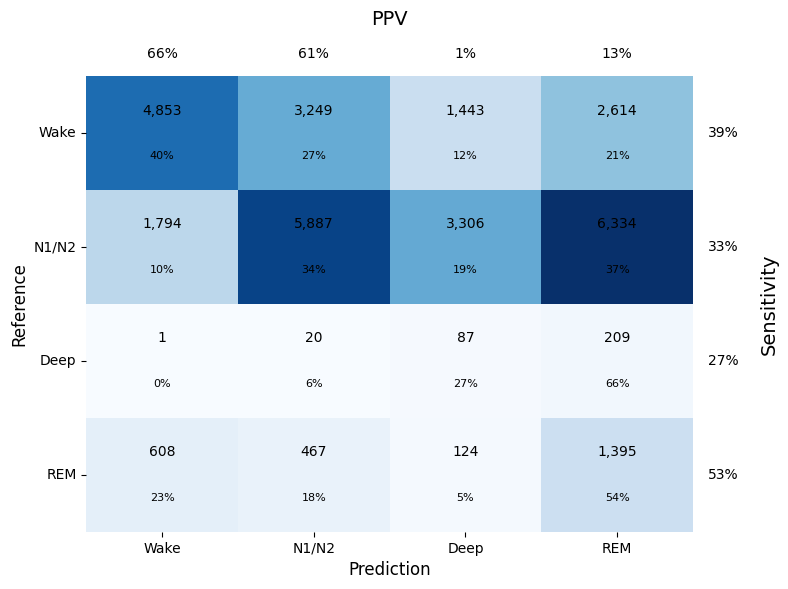

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/BaselineGRU/cms/cm_model0.png
Done with loop 0


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | v

Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 34.06it/s, v_num=ama4, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:03<00:00, 25.26it/s, v_num=ama4, train_loss_step=1.400, val_loss=1.390, val_acc=0.614, val_cohen_kappa=0.226, train_loss_epoch=1.340]

Metric val_loss improved. New best score: 1.385


Epoch 1: 100%|██████████| 101/101 [00:03<00:00, 28.79it/s, v_num=ama4, train_loss_step=1.360, val_loss=1.390, val_acc=0.614, val_cohen_kappa=0.226, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:04<00:00, 22.02it/s, v_num=ama4, train_loss_step=1.360, val_loss=1.310, val_acc=0.338, val_cohen_kappa=0.116, train_loss_epoch=1.320]

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 1.306


Epoch 2: 100%|██████████| 101/101 [00:03<00:00, 29.38it/s, v_num=ama4, train_loss_step=1.220, val_loss=1.310, val_acc=0.338, val_cohen_kappa=0.116, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:03<00:00, 27.50it/s, v_num=ama4, train_loss_step=1.450, val_loss=1.320, val_acc=0.394, val_cohen_kappa=0.155, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:04<00:00, 21.17it/s, v_num=ama4, train_loss_step=1.450, val_loss=1.270, val_acc=0.343, val_cohen_kappa=0.141, train_loss_epoch=1.270]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.274


Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 28.05it/s, v_num=ama4, train_loss_step=1.040, val_loss=1.270, val_acc=0.343, val_cohen_kappa=0.141, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:04<00:00, 21.60it/s, v_num=ama4, train_loss_step=1.040, val_loss=1.260, val_acc=0.364, val_cohen_kappa=0.154, train_loss_epoch=1.230]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.265


Epoch 5: 100%|██████████| 101/101 [00:03<00:00, 26.27it/s, v_num=ama4, train_loss_step=1.150, val_loss=1.260, val_acc=0.364, val_cohen_kappa=0.154, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:05<00:00, 18.93it/s, v_num=ama4, train_loss_step=1.150, val_loss=1.240, val_acc=0.514, val_cohen_kappa=0.216, train_loss_epoch=1.230]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.242


Epoch 6: 100%|██████████| 101/101 [00:03<00:00, 28.41it/s, v_num=ama4, train_loss_step=0.915, val_loss=1.240, val_acc=0.514, val_cohen_kappa=0.216, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:04<00:00, 22.16it/s, v_num=ama4, train_loss_step=0.915, val_loss=1.170, val_acc=0.371, val_cohen_kappa=0.188, train_loss_epoch=1.220]

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.172


Epoch 7: 100%|██████████| 101/101 [00:03<00:00, 27.13it/s, v_num=ama4, train_loss_step=0.938, val_loss=1.170, val_acc=0.371, val_cohen_kappa=0.188, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:03<00:00, 27.58it/s, v_num=ama4, train_loss_step=1.140, val_loss=1.180, val_acc=0.377, val_cohen_kappa=0.194, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:05<00:00, 19.54it/s, v_num=ama4, train_loss_step=1.140, val_loss=1.170, val_acc=0.440, val_cohen_kappa=0.213, train_loss_epoch=1.160]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.166


Epoch 9: 100%|██████████| 101/101 [00:04<00:00, 24.57it/s, v_num=ama4, train_loss_step=1.330, val_loss=1.170, val_acc=0.440, val_cohen_kappa=0.213, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:03<00:00, 28.39it/s, v_num=ama4, train_loss_step=0.986, val_loss=1.250, val_acc=0.336, val_cohen_kappa=0.153, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:03<00:00, 27.69it/s, v_num=ama4, train_loss_step=1.270, val_loss=1.240, val_acc=0.411, val_cohen_kappa=0.175, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:04<00:00, 21.49it/s, v_num=ama4, train_loss_step=1.270, val_loss=1.130, val_acc=0.470, val_cohen_kappa=0.224, train_loss_epoch=1.100]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.127


Epoch 12: 100%|██████████| 101/101 [00:03<00:00, 26.22it/s, v_num=ama4, train_loss_step=1.020, val_loss=1.130, val_acc=0.470, val_cohen_kappa=0.224, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:03<00:00, 27.63it/s, v_num=ama4, train_loss_step=1.060, val_loss=1.230, val_acc=0.397, val_cohen_kappa=0.182, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:03<00:00, 28.53it/s, v_num=ama4, train_loss_step=0.631, val_loss=1.160, val_acc=0.451, val_cohen_kappa=0.187, train_loss_epoch=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:04<00:00, 21.74it/s, v_num=ama4, train_loss_step=0.631, val_loss=1.120, val_acc=0.397, val_cohen_kappa=0.213, train_loss_epoch=0.966]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.119


Epoch 15: 100%|██████████| 101/101 [00:03<00:00, 29.36it/s, v_num=ama4, train_loss_step=0.967, val_loss=1.120, val_acc=0.397, val_cohen_kappa=0.213, train_loss_epoch=0.966]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 101/101 [00:03<00:00, 28.57it/s, v_num=ama4, train_loss_step=0.740, val_loss=1.170, val_acc=0.522, val_cohen_kappa=0.251, train_loss_epoch=0.916]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 101/101 [00:02<00:00, 41.12it/s, v_num=ama4, train_loss_step=0.915, val_loss=1.130, val_acc=0.478, val_cohen_kappa=0.241, train_loss_epoch=0.842]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 101/101 [00:02<00:00, 39.27it/s, v_num=ama4, train_loss_step=0.613, val_loss=1.220, val_acc=0.423, val_cohen_kappa=0.199, train_loss_epoch=0.761]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 101/101 [00:03<00:00, 29.63it/s, v_num=ama4, train_loss_step=0.613, val_loss=1.310, val_acc=0.419

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.119. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 101/101 [00:03<00:00, 29.59it/s, v_num=ama4, train_loss_step=0.613, val_loss=1.310, val_acc=0.419, val_cohen_kappa=0.193, train_loss_epoch=0.749]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇███████
train_loss_epoch,██▇▇▇▇▇▆▆▆▅▅▅▄▄▃▂▁▁
train_loss_step,▆▇▆▆█▆▅▇▅▇▆▆▇▆▅▅▄▅▄▃▅▆▆▅▇▇▄▃▄▅▃▃▃▄▇▂▂▁▃▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
val_acc,█▁▂▁▂▅▂▂▄▁▃▄▃▄▃▆▅▃▃
val_cohen_kappa,▇▁▃▂▃▆▅▅▆▃▄▇▄▅▆█▇▅▅
val_loss,█▆▆▅▅▄▂▃▂▅▄▁▄▂▁▂▁▄▆
epoch,18
train_loss_epoch,0.74907
train_loss_step,0.61293
trainer/global_step,1918


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss/best-checkpoint-v1.ckpt
Trained model 1 in 88.38709592819214 seconds


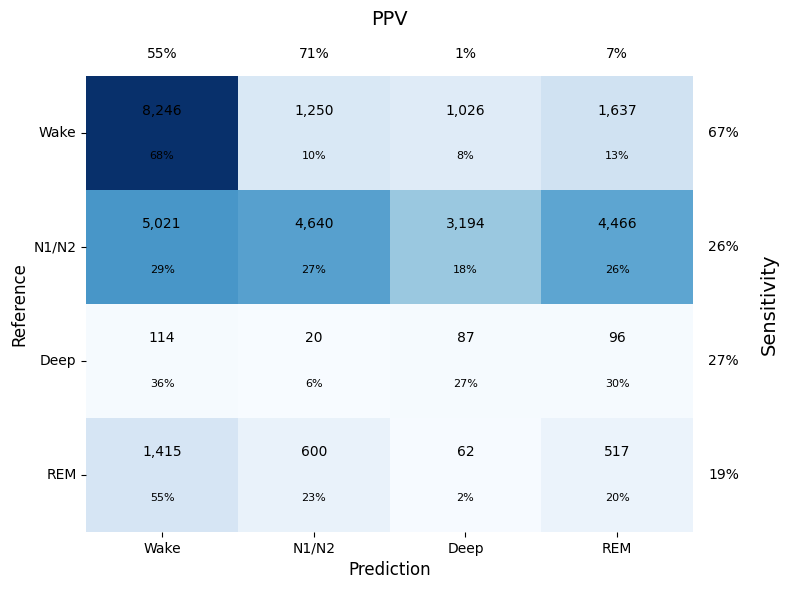

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/BaselineGRU/cms/cm_model1.png
Done with loop 1


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | v

Epoch 0: 100%|██████████| 101/101 [00:01<00:00, 51.48it/s, v_num=klob, train_loss_step=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 35.36it/s, v_num=klob, train_loss_step=1.210, val_loss=1.310, val_acc=0.357, val_cohen_kappa=0.122, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.306


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 39.96it/s, v_num=klob, train_loss_step=1.170, val_loss=1.310, val_acc=0.357, val_cohen_kappa=0.122, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:03<00:00, 28.78it/s, v_num=klob, train_loss_step=1.170, val_loss=1.270, val_acc=0.315, val_cohen_kappa=0.108, train_loss_epoch=1.310]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.265


Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 42.90it/s, v_num=klob, train_loss_step=1.380, val_loss=1.270, val_acc=0.315, val_cohen_kappa=0.108, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 41.08it/s, v_num=klob, train_loss_step=1.030, val_loss=1.320, val_acc=0.294, val_cohen_kappa=0.110, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:03<00:00, 30.21it/s, v_num=klob, train_loss_step=1.030, val_loss=1.230, val_acc=0.318, val_cohen_kappa=0.123, train_loss_epoch=1.280]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.230


Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 40.76it/s, v_num=klob, train_loss_step=1.750, val_loss=1.230, val_acc=0.318, val_cohen_kappa=0.123, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 30.81it/s, v_num=klob, train_loss_step=1.750, val_loss=1.180, val_acc=0.402, val_cohen_kappa=0.215, train_loss_epoch=1.250]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.180


Epoch 5: 100%|██████████| 101/101 [00:02<00:00, 40.13it/s, v_num=klob, train_loss_step=1.310, val_loss=1.180, val_acc=0.402, val_cohen_kappa=0.215, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:03<00:00, 30.26it/s, v_num=klob, train_loss_step=1.310, val_loss=1.160, val_acc=0.310, val_cohen_kappa=0.169, train_loss_epoch=1.210]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.161


Epoch 6: 100%|██████████| 101/101 [00:02<00:00, 39.37it/s, v_num=klob, train_loss_step=1.170, val_loss=1.160, val_acc=0.310, val_cohen_kappa=0.169, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:03<00:00, 29.60it/s, v_num=klob, train_loss_step=1.170, val_loss=1.150, val_acc=0.471, val_cohen_kappa=0.222, train_loss_epoch=1.200]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.150


Epoch 7: 100%|██████████| 101/101 [00:02<00:00, 40.47it/s, v_num=klob, train_loss_step=1.440, val_loss=1.150, val_acc=0.471, val_cohen_kappa=0.222, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:02<00:00, 40.92it/s, v_num=klob, train_loss_step=0.977, val_loss=1.200, val_acc=0.413, val_cohen_kappa=0.196, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:03<00:00, 30.75it/s, v_num=klob, train_loss_step=0.977, val_loss=1.140, val_acc=0.436, val_cohen_kappa=0.222, train_loss_epoch=1.180]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.143


Epoch 9: 100%|██████████| 101/101 [00:02<00:00, 39.11it/s, v_num=klob, train_loss_step=1.370, val_loss=1.140, val_acc=0.436, val_cohen_kappa=0.222, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:03<00:00, 28.97it/s, v_num=klob, train_loss_step=1.370, val_loss=1.120, val_acc=0.529, val_cohen_kappa=0.287, train_loss_epoch=1.140]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.121


Epoch 10: 100%|██████████| 101/101 [00:02<00:00, 41.02it/s, v_num=klob, train_loss_step=1.150, val_loss=1.120, val_acc=0.529, val_cohen_kappa=0.287, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:02<00:00, 39.09it/s, v_num=klob, train_loss_step=1.130, val_loss=1.170, val_acc=0.458, val_cohen_kappa=0.231, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:02<00:00, 41.55it/s, v_num=klob, train_loss_step=1.260, val_loss=1.140, val_acc=0.452, val_cohen_kappa=0.222, train_loss_epoch=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:02<00:00, 41.73it/s, v_num=klob, train_loss_step=0.968, val_loss=1.230, val_acc=0.369, val_cohen_kappa=0.185, train_loss_epoch=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:03<00:00, 31.23it/s, v_num=klob, train_loss_step=0.968, val_loss=1.210, val_acc=0.365

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.121. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 101/101 [00:03<00:00, 31.19it/s, v_num=klob, train_loss_step=0.968, val_loss=1.210, val_acc=0.365, val_cohen_kappa=0.181, train_loss_epoch=1.010]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▇▇▇▆▅▅▅▅▄▃▂▂▁
train_loss_step,▅█▅▅▄▅▄▆▅▅▇▅█▅▆▃▅▄▄▅▃▆▁▄▃▃▄▄▂▃▁▁▂▄▃▄▅▂▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
val_acc,▃▂▁▂▄▁▆▅▅█▆▆▃▃
val_cohen_kappa,▂▁▁▂▅▃▅▄▅█▆▅▄▄
val_loss,▇▆█▅▃▂▂▄▂▁▃▂▅▄
epoch,13
train_loss_epoch,1.00551
train_loss_step,0.96821
trainer/global_step,1413


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss/best-checkpoint-v2.ckpt
Trained model 2 in 48.16107368469238 seconds


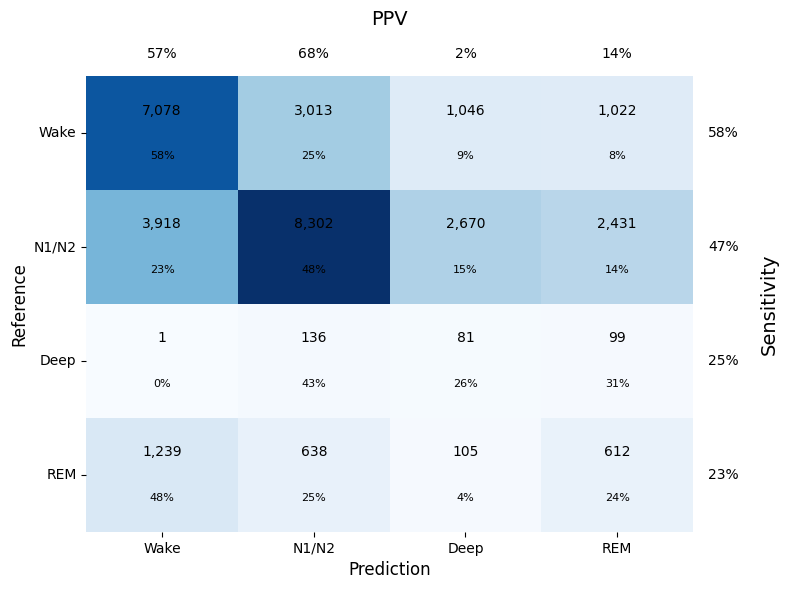

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/BaselineGRU/cms/cm_model2.png
Done with loop 2


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | v

Epoch 0: 100%|██████████| 101/101 [00:01<00:00, 52.14it/s, v_num=al0g, train_loss_step=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 36.76it/s, v_num=al0g, train_loss_step=1.180, val_loss=1.330, val_acc=0.387, val_cohen_kappa=0.092, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.327


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 41.85it/s, v_num=al0g, train_loss_step=1.200, val_loss=1.330, val_acc=0.387, val_cohen_kappa=0.092, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:03<00:00, 30.69it/s, v_num=al0g, train_loss_step=1.200, val_loss=1.280, val_acc=0.460, val_cohen_kappa=0.146, train_loss_epoch=1.310]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.280


Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 41.31it/s, v_num=al0g, train_loss_step=1.050, val_loss=1.280, val_acc=0.460, val_cohen_kappa=0.146, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:03<00:00, 31.50it/s, v_num=al0g, train_loss_step=1.050, val_loss=1.270, val_acc=0.302, val_cohen_kappa=0.0991, train_loss_epoch=1.280]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.271


Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 42.22it/s, v_num=al0g, train_loss_step=1.410, val_loss=1.270, val_acc=0.302, val_cohen_kappa=0.0991, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:03<00:00, 31.81it/s, v_num=al0g, train_loss_step=1.410, val_loss=1.190, val_acc=0.265, val_cohen_kappa=0.151, train_loss_epoch=1.250] 

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.185


Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 40.85it/s, v_num=al0g, train_loss_step=1.050, val_loss=1.190, val_acc=0.265, val_cohen_kappa=0.151, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:02<00:00, 40.31it/s, v_num=al0g, train_loss_step=1.130, val_loss=1.220, val_acc=0.430, val_cohen_kappa=0.191, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:02<00:00, 38.99it/s, v_num=al0g, train_loss_step=1.420, val_loss=1.190, val_acc=0.354, val_cohen_kappa=0.166, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:02<00:00, 40.83it/s, v_num=al0g, train_loss_step=1.070, val_loss=1.230, val_acc=0.366, val_cohen_kappa=0.192, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:03<00:00, 30.94it/s, v_num=al0g, train_loss_step=1.070, val_loss=1.190, val_acc=0.455, val

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.185. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 101/101 [00:03<00:00, 30.91it/s, v_num=al0g, train_loss_step=1.070, val_loss=1.190, val_acc=0.455, val_cohen_kappa=0.194, train_loss_epoch=1.170]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇████
train_loss_epoch,█▆▅▄▃▂▂▁
train_loss_step,▅▅▄▆▄▄▅▄▃▄▆▆▃▅▅▅▇▄▅▄▃▂▄▄█▄▃▄▁▃▅▅▃▃▆▅▂▁▆▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▅█▂▁▇▄▅█
val_cohen_kappa,▁▅▁▅█▆██
val_loss,█▆▅▁▃▁▃▁
epoch,7
train_loss_epoch,1.17493
train_loss_step,1.06551
trainer/global_step,807


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss/best-checkpoint-v3.ckpt
Trained model 3 in 27.77068853378296 seconds


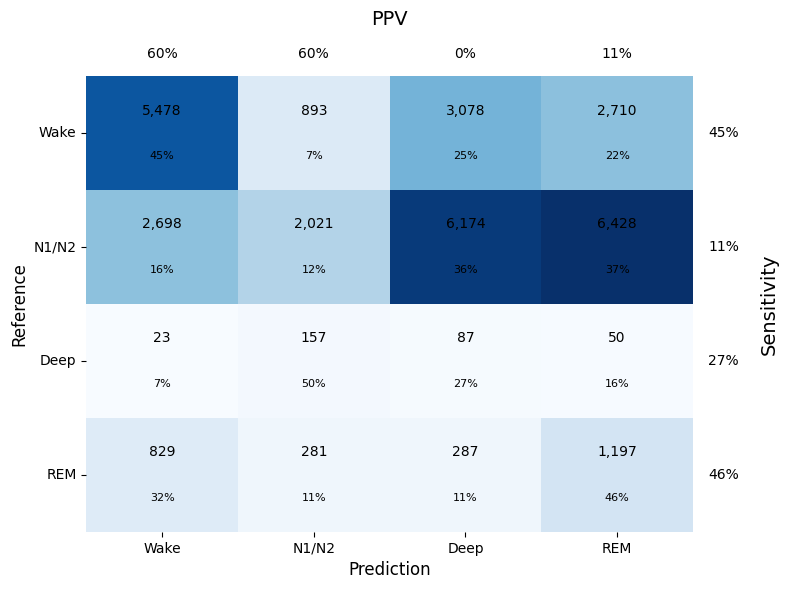

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/BaselineGRU/cms/cm_model3.png
Done with loop 3


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | v

Epoch 0: 100%|██████████| 101/101 [00:01<00:00, 54.72it/s, v_num=5j15, train_loss_step=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 38.04it/s, v_num=5j15, train_loss_step=1.190, val_loss=1.310, val_acc=0.332, val_cohen_kappa=0.0935, train_loss_epoch=1.340]

Metric val_loss improved. New best score: 1.308


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 40.39it/s, v_num=5j15, train_loss_step=1.270, val_loss=1.310, val_acc=0.332, val_cohen_kappa=0.0935, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 40.87it/s, v_num=5j15, train_loss_step=1.340, val_loss=1.320, val_acc=0.266, val_cohen_kappa=0.0842, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 41.00it/s, v_num=5j15, train_loss_step=1.250, val_loss=1.360, val_acc=0.377, val_cohen_kappa=0.139, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:03<00:00, 31.18it/s, v_num=5j15, train_loss_step=1.250, val_loss=1.290, val_acc=0.319, val_cohen_kappa=0.117, train_loss_epoch=1.280]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.290


Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 40.27it/s, v_num=5j15, train_loss_step=1.180, val_loss=1.290, val_acc=0.319, val_cohen_kappa=0.117, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 30.86it/s, v_num=5j15, train_loss_step=1.180, val_loss=1.270, val_acc=0.392, val_cohen_kappa=0.133, train_loss_epoch=1.240]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.272


Epoch 5: 100%|██████████| 101/101 [00:02<00:00, 41.02it/s, v_num=5j15, train_loss_step=1.070, val_loss=1.270, val_acc=0.392, val_cohen_kappa=0.133, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:03<00:00, 30.69it/s, v_num=5j15, train_loss_step=1.070, val_loss=1.230, val_acc=0.380, val_cohen_kappa=0.185, train_loss_epoch=1.220]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.233


Epoch 6: 100%|██████████| 101/101 [00:02<00:00, 41.05it/s, v_num=5j15, train_loss_step=1.120, val_loss=1.230, val_acc=0.380, val_cohen_kappa=0.185, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:03<00:00, 30.81it/s, v_num=5j15, train_loss_step=1.120, val_loss=1.180, val_acc=0.374, val_cohen_kappa=0.195, train_loss_epoch=1.210]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.177


Epoch 7: 100%|██████████| 101/101 [00:02<00:00, 40.32it/s, v_num=5j15, train_loss_step=1.080, val_loss=1.180, val_acc=0.374, val_cohen_kappa=0.195, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:02<00:00, 39.96it/s, v_num=5j15, train_loss_step=1.180, val_loss=1.240, val_acc=0.360, val_cohen_kappa=0.156, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:02<00:00, 40.29it/s, v_num=5j15, train_loss_step=1.140, val_loss=1.300, val_acc=0.289, val_cohen_kappa=0.126, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:02<00:00, 39.16it/s, v_num=5j15, train_loss_step=0.859, val_loss=1.190, val_acc=0.333, val_cohen_kappa=0.160, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:03<00:00, 29.00it/s, v_num=5j15, train_loss_step=0.859, val_loss=1.180, val_acc=0.345, v

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.177. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 101/101 [00:03<00:00, 28.96it/s, v_num=5j15, train_loss_step=0.859, val_loss=1.180, val_acc=0.345, val_cohen_kappa=0.174, train_loss_epoch=1.110]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█████
train_loss_epoch,█▇▇▆▅▄▄▄▃▂▁
train_loss_step,▅▅▄▃▄▃▅▄▆▃▅▄▄▄▅▄▆▄▂▄▅▄▆▃▂▃▂█▁▇▄▁▄▄▂▂▅▃▇▃
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
val_acc,▅▁▇▄█▇▇▆▂▅▅
val_cohen_kappa,▂▁▄▃▄▇█▆▄▆▇
val_loss,▆▇█▅▅▃▁▄▆▂▁
epoch,10
train_loss_epoch,1.10737
train_loss_step,0.85917
trainer/global_step,1110


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss/best-checkpoint-v4.ckpt
Trained model 4 in 37.96376061439514 seconds


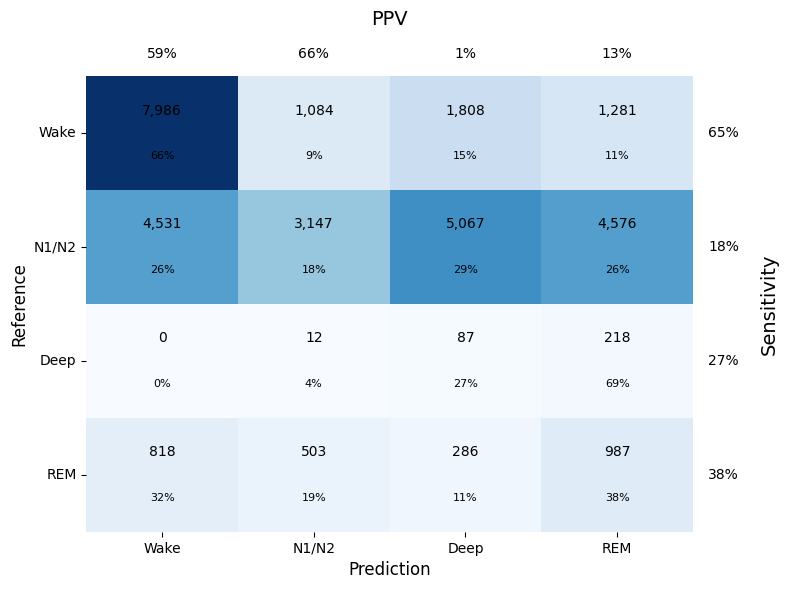

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/BaselineGRU/cms/cm_model4.png
Done with loop 4


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | v

Epoch 0: 100%|██████████| 101/101 [00:01<00:00, 51.95it/s, v_num=7ntp, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 35.93it/s, v_num=7ntp, train_loss_step=1.320, val_loss=1.340, val_acc=0.356, val_cohen_kappa=0.0644, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.340


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 40.57it/s, v_num=7ntp, train_loss_step=1.370, val_loss=1.340, val_acc=0.356, val_cohen_kappa=0.0644, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:03<00:00, 30.61it/s, v_num=7ntp, train_loss_step=1.370, val_loss=1.260, val_acc=0.317, val_cohen_kappa=0.102, train_loss_epoch=1.330] 

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 1.263


Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 41.48it/s, v_num=7ntp, train_loss_step=1.230, val_loss=1.260, val_acc=0.317, val_cohen_kappa=0.102, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 39.67it/s, v_num=7ntp, train_loss_step=1.170, val_loss=1.320, val_acc=0.404, val_cohen_kappa=0.167, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 39.80it/s, v_num=7ntp, train_loss_step=1.100, val_loss=1.300, val_acc=0.319, val_cohen_kappa=0.0857, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 30.65it/s, v_num=7ntp, train_loss_step=1.100, val_loss=1.260, val_acc=0.379, val_cohen_kappa=0.154, train_loss_epoch=1.240] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.257


Epoch 5: 100%|██████████| 101/101 [00:02<00:00, 41.27it/s, v_num=7ntp, train_loss_step=1.060, val_loss=1.260, val_acc=0.379, val_cohen_kappa=0.154, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:03<00:00, 30.28it/s, v_num=7ntp, train_loss_step=1.060, val_loss=1.230, val_acc=0.371, val_cohen_kappa=0.175, train_loss_epoch=1.220]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.225


Epoch 6: 100%|██████████| 101/101 [00:02<00:00, 40.53it/s, v_num=7ntp, train_loss_step=1.110, val_loss=1.230, val_acc=0.371, val_cohen_kappa=0.175, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:03<00:00, 30.36it/s, v_num=7ntp, train_loss_step=1.110, val_loss=1.160, val_acc=0.444, val_cohen_kappa=0.226, train_loss_epoch=1.200]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.162


Epoch 7: 100%|██████████| 101/101 [00:02<00:00, 41.12it/s, v_num=7ntp, train_loss_step=1.070, val_loss=1.160, val_acc=0.444, val_cohen_kappa=0.226, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:02<00:00, 39.94it/s, v_num=7ntp, train_loss_step=1.300, val_loss=1.170, val_acc=0.384, val_cohen_kappa=0.197, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:02<00:00, 41.59it/s, v_num=7ntp, train_loss_step=1.040, val_loss=1.170, val_acc=0.383, val_cohen_kappa=0.206, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:02<00:00, 41.96it/s, v_num=7ntp, train_loss_step=1.130, val_loss=1.240, val_acc=0.366, val_cohen_kappa=0.172, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:03<00:00, 31.32it/s, v_num=7ntp, train_loss_step=1.130, val_loss=1.120, val_acc=0.369, v

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.116


Epoch 11: 100%|██████████| 101/101 [00:02<00:00, 40.73it/s, v_num=7ntp, train_loss_step=0.874, val_loss=1.120, val_acc=0.369, val_cohen_kappa=0.196, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:02<00:00, 41.00it/s, v_num=7ntp, train_loss_step=0.814, val_loss=1.160, val_acc=0.507, val_cohen_kappa=0.225, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:02<00:00, 39.23it/s, v_num=7ntp, train_loss_step=0.922, val_loss=1.190, val_acc=0.453, val_cohen_kappa=0.228, train_loss_epoch=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:02<00:00, 40.56it/s, v_num=7ntp, train_loss_step=0.944, val_loss=1.180, val_acc=0.419, val_cohen_kappa=0.206, train_loss_epoch=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:03<00:00, 30.28it/s, v_num=7ntp, train_loss_step=0.944, val_loss=1.250, val_acc=0.443

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.116. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 101/101 [00:03<00:00, 30.24it/s, v_num=7ntp, train_loss_step=0.944, val_loss=1.250, val_acc=0.443, val_cohen_kappa=0.192, train_loss_epoch=0.980]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss_epoch,█▇▇▆▆▅▅▅▄▄▃▄▂▂▁
train_loss_step,▅▅▅▆▄▅▂▄▆▄▄▃▃▂▅▄▃▃█▄▄▃▁▃▃▅▂▃▂▁▁▃▂▃▃▂▄▅▄▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
val_acc,▂▁▄▁▃▃▆▃▃▃▃█▆▅▆
val_cohen_kappa,▁▃▅▂▅▆█▇▇▆▇██▇▆
val_loss,█▆▇▇▅▄▂▃▃▅▁▂▃▃▅
epoch,14
train_loss_epoch,0.98042
train_loss_step,0.94407
trainer/global_step,1514


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss/best-checkpoint-v5.ckpt
Trained model 5 in 51.49732756614685 seconds


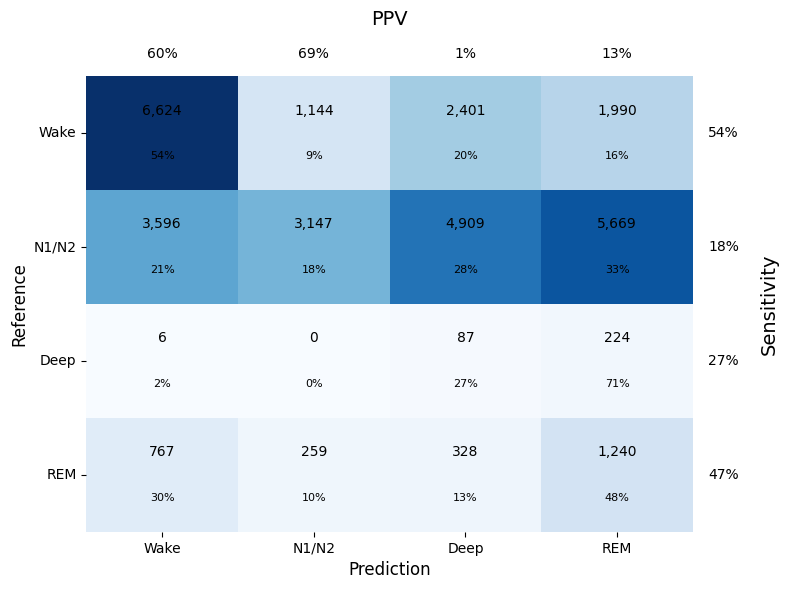

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/BaselineGRU/cms/cm_model5.png
Done with loop 5


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | v

Epoch 0: 100%|██████████| 101/101 [00:01<00:00, 53.25it/s, v_num=t85a, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 37.62it/s, v_num=t85a, train_loss_step=1.320, val_loss=1.330, val_acc=0.329, val_cohen_kappa=0.107, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.327


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 40.56it/s, v_num=t85a, train_loss_step=1.170, val_loss=1.330, val_acc=0.329, val_cohen_kappa=0.107, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:03<00:00, 30.45it/s, v_num=t85a, train_loss_step=1.170, val_loss=1.320, val_acc=0.355, val_cohen_kappa=0.0931, train_loss_epoch=1.310]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.315


Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 40.27it/s, v_num=t85a, train_loss_step=1.290, val_loss=1.320, val_acc=0.355, val_cohen_kappa=0.0931, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:03<00:00, 30.00it/s, v_num=t85a, train_loss_step=1.290, val_loss=1.310, val_acc=0.339, val_cohen_kappa=0.118, train_loss_epoch=1.270] 

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.307


Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 38.27it/s, v_num=t85a, train_loss_step=1.360, val_loss=1.310, val_acc=0.339, val_cohen_kappa=0.118, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:03<00:00, 28.79it/s, v_num=t85a, train_loss_step=1.360, val_loss=1.240, val_acc=0.373, val_cohen_kappa=0.152, train_loss_epoch=1.240]

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 1.240


Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 40.48it/s, v_num=t85a, train_loss_step=1.250, val_loss=1.240, val_acc=0.373, val_cohen_kappa=0.152, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 30.00it/s, v_num=t85a, train_loss_step=1.250, val_loss=1.160, val_acc=0.336, val_cohen_kappa=0.172, train_loss_epoch=1.240]

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 1.162


Epoch 5: 100%|██████████| 101/101 [00:02<00:00, 41.08it/s, v_num=t85a, train_loss_step=0.894, val_loss=1.160, val_acc=0.336, val_cohen_kappa=0.172, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:03<00:00, 33.56it/s, v_num=t85a, train_loss_step=1.080, val_loss=1.200, val_acc=0.446, val_cohen_kappa=0.176, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:02<00:00, 34.35it/s, v_num=t85a, train_loss_step=1.130, val_loss=1.160, val_acc=0.379, val_cohen_kappa=0.180, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:02<00:00, 39.90it/s, v_num=t85a, train_loss_step=1.200, val_loss=1.210, val_acc=0.374, val_cohen_kappa=0.165, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:03<00:00, 29.80it/s, v_num=t85a, train_loss_step=1.200, val_loss=1.190, val_acc=0.419, val

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.162. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 101/101 [00:03<00:00, 29.76it/s, v_num=t85a, train_loss_step=1.200, val_loss=1.190, val_acc=0.419, val_cohen_kappa=0.175, train_loss_epoch=1.160]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇█████
train_loss_epoch,█▆▅▄▄▃▃▂▁
train_loss_step,▄▄▅▄▄▅▅▄▄▃▃▄▆▆▄▅▆▃▆▄▄▄▄▃▅▄▄▆▅▃▆▆▂▂▄▄▆▃█▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
val_acc,▁▃▂▄▁█▄▄▆
val_cohen_kappa,▂▁▃▆▇██▇█
val_loss,█▇▇▄▁▃▁▃▂
epoch,8
train_loss_epoch,1.15906
train_loss_step,1.20245
trainer/global_step,908


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss/best-checkpoint-v6.ckpt
Trained model 6 in 32.272079944610596 seconds


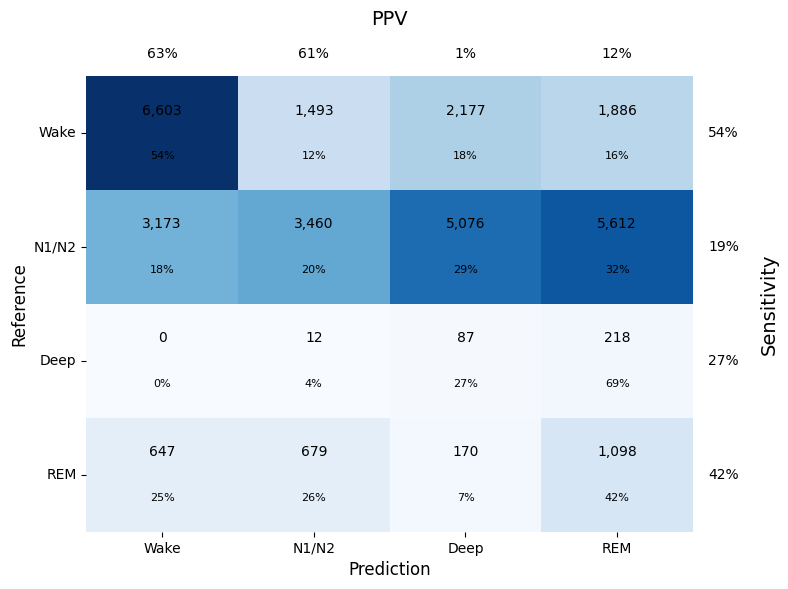

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/BaselineGRU/cms/cm_model6.png
Done with loop 6


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | v

Epoch 0: 100%|██████████| 101/101 [00:01<00:00, 53.25it/s, v_num=rla5, train_loss_step=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 38.23it/s, v_num=rla5, train_loss_step=1.210, val_loss=1.360, val_acc=0.367, val_cohen_kappa=0.105, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.362


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 42.50it/s, v_num=rla5, train_loss_step=1.360, val_loss=1.360, val_acc=0.367, val_cohen_kappa=0.105, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:03<00:00, 31.88it/s, v_num=rla5, train_loss_step=1.360, val_loss=1.320, val_acc=0.317, val_cohen_kappa=0.0982, train_loss_epoch=1.320]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.320


Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 41.01it/s, v_num=rla5, train_loss_step=1.490, val_loss=1.320, val_acc=0.317, val_cohen_kappa=0.0982, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:03<00:00, 31.15it/s, v_num=rla5, train_loss_step=1.490, val_loss=1.280, val_acc=0.303, val_cohen_kappa=0.113, train_loss_epoch=1.280] 

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.282


Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 42.35it/s, v_num=rla5, train_loss_step=1.170, val_loss=1.280, val_acc=0.303, val_cohen_kappa=0.113, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 42.07it/s, v_num=rla5, train_loss_step=1.210, val_loss=1.370, val_acc=0.324, val_cohen_kappa=0.139, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 31.66it/s, v_num=rla5, train_loss_step=1.210, val_loss=1.260, val_acc=0.363, val_cohen_kappa=0.145, train_loss_epoch=1.240]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.261


Epoch 5: 100%|██████████| 101/101 [00:02<00:00, 41.91it/s, v_num=rla5, train_loss_step=1.070, val_loss=1.260, val_acc=0.363, val_cohen_kappa=0.145, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:03<00:00, 31.22it/s, v_num=rla5, train_loss_step=1.070, val_loss=1.170, val_acc=0.309, val_cohen_kappa=0.156, train_loss_epoch=1.220]

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 1.170


Epoch 6: 100%|██████████| 101/101 [00:02<00:00, 41.36it/s, v_num=rla5, train_loss_step=1.100, val_loss=1.170, val_acc=0.309, val_cohen_kappa=0.156, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:02<00:00, 41.49it/s, v_num=rla5, train_loss_step=1.130, val_loss=1.190, val_acc=0.353, val_cohen_kappa=0.142, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:02<00:00, 40.55it/s, v_num=rla5, train_loss_step=1.410, val_loss=1.210, val_acc=0.416, val_cohen_kappa=0.163, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:03<00:00, 31.68it/s, v_num=rla5, train_loss_step=1.410, val_loss=1.110, val_acc=0.329, val_cohen_kappa=0.175, train_loss_epoch=1.140]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.112


Epoch 9: 100%|██████████| 101/101 [00:02<00:00, 42.78it/s, v_num=rla5, train_loss_step=1.480, val_loss=1.110, val_acc=0.329, val_cohen_kappa=0.175, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:02<00:00, 42.02it/s, v_num=rla5, train_loss_step=1.290, val_loss=1.110, val_acc=0.365, val_cohen_kappa=0.197, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:02<00:00, 41.18it/s, v_num=rla5, train_loss_step=1.480, val_loss=1.200, val_acc=0.477, val_cohen_kappa=0.223, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:02<00:00, 41.16it/s, v_num=rla5, train_loss_step=1.140, val_loss=1.230, val_acc=0.350, val_cohen_kappa=0.186, train_loss_epoch=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:03<00:00, 31.66it/s, v_num=rla5, train_loss_step=1.140, val_loss=1.200, val_acc=0.429,

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.112. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 101/101 [00:03<00:00, 31.61it/s, v_num=rla5, train_loss_step=1.140, val_loss=1.200, val_acc=0.429, val_cohen_kappa=0.207, train_loss_epoch=1.040]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
train_loss_epoch,█▇▆▆▅▅▄▄▃▃▃▂▁
train_loss_step,▆▃▄▄▄█▄▄▄▃▃▃▃▆▄▃▃▂▃▂▆▃▂▂▅▅▆▄▅▂▁▂▆▁▅▂▅▄▆▅
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▄▂▁▂▃▁▃▆▂▃█▃▆
val_cohen_kappa,▁▁▂▃▄▄▃▅▅▇█▆▇
val_loss,█▇▆█▅▃▃▄▁▁▄▄▃
epoch,12
train_loss_epoch,1.03532
train_loss_step,1.13794
trainer/global_step,1312


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss/best-checkpoint-v7.ckpt
Trained model 7 in 43.17685627937317 seconds


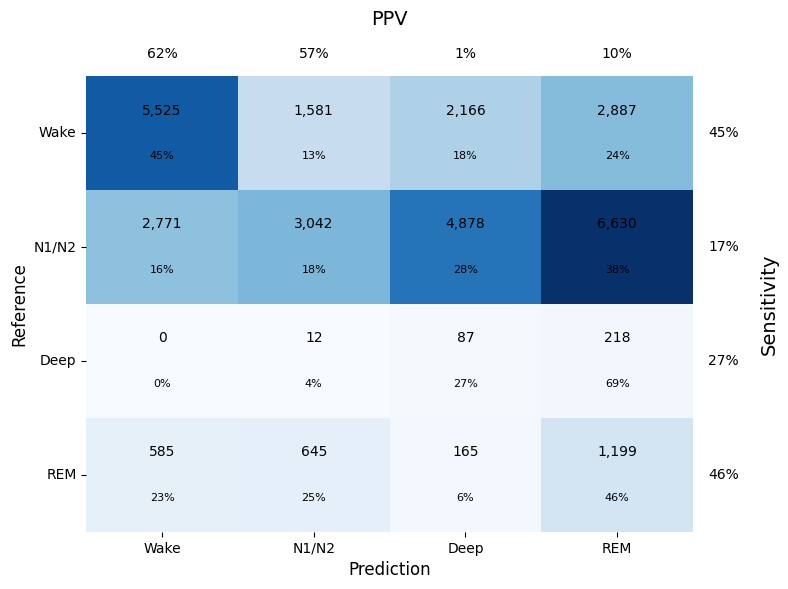

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/BaselineGRU/cms/cm_model7.png
Done with loop 7


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | v

Epoch 0: 100%|██████████| 101/101 [00:01<00:00, 52.47it/s, v_num=lyhv, train_loss_step=1.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 37.31it/s, v_num=lyhv, train_loss_step=1.570, val_loss=1.370, val_acc=0.409, val_cohen_kappa=0.140, train_loss_epoch=1.340]

Metric val_loss improved. New best score: 1.373


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 43.92it/s, v_num=lyhv, train_loss_step=1.230, val_loss=1.370, val_acc=0.409, val_cohen_kappa=0.140, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:03<00:00, 32.76it/s, v_num=lyhv, train_loss_step=1.230, val_loss=1.310, val_acc=0.263, val_cohen_kappa=0.0878, train_loss_epoch=1.310]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 1.311


Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 41.74it/s, v_num=lyhv, train_loss_step=1.240, val_loss=1.310, val_acc=0.263, val_cohen_kappa=0.0878, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:03<00:00, 31.30it/s, v_num=lyhv, train_loss_step=1.240, val_loss=1.300, val_acc=0.350, val_cohen_kappa=0.112, train_loss_epoch=1.290] 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.296


Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 42.18it/s, v_num=lyhv, train_loss_step=1.260, val_loss=1.300, val_acc=0.350, val_cohen_kappa=0.112, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:03<00:00, 30.82it/s, v_num=lyhv, train_loss_step=1.260, val_loss=1.260, val_acc=0.410, val_cohen_kappa=0.157, train_loss_epoch=1.260]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.260


Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 39.57it/s, v_num=lyhv, train_loss_step=1.430, val_loss=1.260, val_acc=0.410, val_cohen_kappa=0.157, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 30.20it/s, v_num=lyhv, train_loss_step=1.430, val_loss=1.210, val_acc=0.372, val_cohen_kappa=0.172, train_loss_epoch=1.230]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.210


Epoch 5: 100%|██████████| 101/101 [00:02<00:00, 40.56it/s, v_num=lyhv, train_loss_step=1.380, val_loss=1.210, val_acc=0.372, val_cohen_kappa=0.172, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:02<00:00, 42.23it/s, v_num=lyhv, train_loss_step=0.736, val_loss=1.220, val_acc=0.324, val_cohen_kappa=0.165, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:03<00:00, 31.35it/s, v_num=lyhv, train_loss_step=0.736, val_loss=1.200, val_acc=0.312, val_cohen_kappa=0.153, train_loss_epoch=1.200]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.199


Epoch 7: 100%|██████████| 101/101 [00:02<00:00, 41.78it/s, v_num=lyhv, train_loss_step=1.180, val_loss=1.200, val_acc=0.312, val_cohen_kappa=0.153, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:03<00:00, 31.70it/s, v_num=lyhv, train_loss_step=1.180, val_loss=1.170, val_acc=0.370, val_cohen_kappa=0.176, train_loss_epoch=1.180]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.170


Epoch 8: 100%|██████████| 101/101 [00:02<00:00, 39.74it/s, v_num=lyhv, train_loss_step=0.930, val_loss=1.170, val_acc=0.370, val_cohen_kappa=0.176, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:02<00:00, 42.13it/s, v_num=lyhv, train_loss_step=1.390, val_loss=1.170, val_acc=0.396, val_cohen_kappa=0.205, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:03<00:00, 32.03it/s, v_num=lyhv, train_loss_step=1.390, val_loss=1.100, val_acc=0.434, val_cohen_kappa=0.229, train_loss_epoch=1.100]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.095


Epoch 10: 100%|██████████| 101/101 [00:02<00:00, 42.12it/s, v_num=lyhv, train_loss_step=1.180, val_loss=1.100, val_acc=0.434, val_cohen_kappa=0.229, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:02<00:00, 42.32it/s, v_num=lyhv, train_loss_step=1.360, val_loss=1.140, val_acc=0.463, val_cohen_kappa=0.227, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:02<00:00, 40.47it/s, v_num=lyhv, train_loss_step=1.300, val_loss=1.170, val_acc=0.349, val_cohen_kappa=0.168, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:02<00:00, 43.18it/s, v_num=lyhv, train_loss_step=1.260, val_loss=1.230, val_acc=0.445, val_cohen_kappa=0.171, train_loss_epoch=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:03<00:00, 31.52it/s, v_num=lyhv, train_loss_step=1.260, val_loss=1.360, val_acc=0.447

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.095. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 101/101 [00:03<00:00, 31.48it/s, v_num=lyhv, train_loss_step=1.260, val_loss=1.360, val_acc=0.447, val_cohen_kappa=0.190, train_loss_epoch=0.945]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▇▇▆▆▆▅▅▄▄▃▃▁
train_loss_step,▆▇▆█▇▅▆▆▆▆▄▆▄▅▇▆▅▅▇▆▅█▆▃▄▆▃▅▆▇▂▅▂▅▁▂▃▃▃▄
trainer/global_step,▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▆▁▄▆▅▃▃▅▆▇█▄▇▇
val_cohen_kappa,▄▁▂▄▅▅▄▅▇██▅▅▆
val_loss,█▆▆▅▄▄▄▃▃▁▂▃▄█
epoch,13
train_loss_epoch,0.94501
train_loss_step,1.25579
trainer/global_step,1413


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss/best-checkpoint-v8.ckpt
Trained model 8 in 46.67043709754944 seconds


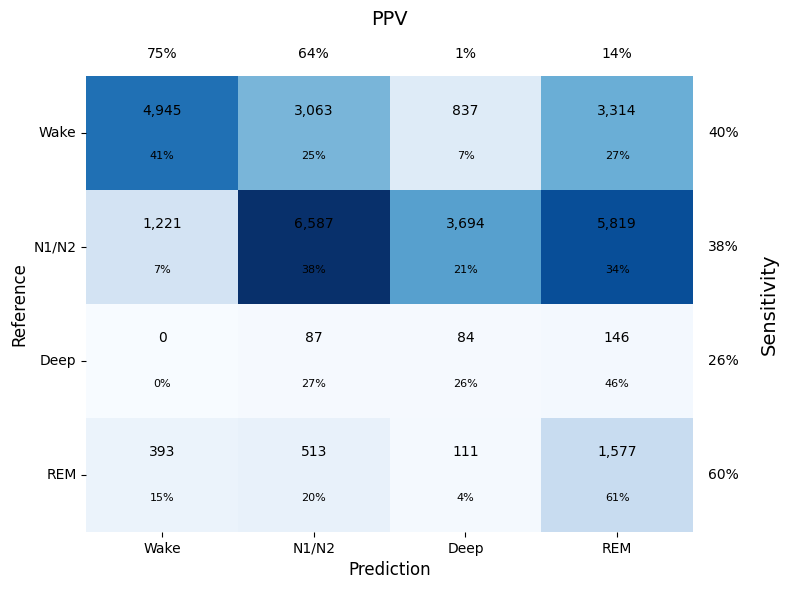

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/BaselineGRU/cms/cm_model8.png
Done with loop 8


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 404 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | v

Epoch 0: 100%|██████████| 101/101 [00:01<00:00, 50.77it/s, v_num=ql7i, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 36.61it/s, v_num=ql7i, train_loss_step=1.340, val_loss=1.390, val_acc=0.216, val_cohen_kappa=0.0233, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.390


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 42.90it/s, v_num=ql7i, train_loss_step=1.380, val_loss=1.390, val_acc=0.216, val_cohen_kappa=0.0233, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:03<00:00, 32.23it/s, v_num=ql7i, train_loss_step=1.380, val_loss=1.280, val_acc=0.321, val_cohen_kappa=0.122, train_loss_epoch=1.310] 

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 1.284


Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 40.33it/s, v_num=ql7i, train_loss_step=1.270, val_loss=1.280, val_acc=0.321, val_cohen_kappa=0.122, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:03<00:00, 31.93it/s, v_num=ql7i, train_loss_step=1.270, val_loss=1.270, val_acc=0.425, val_cohen_kappa=0.188, train_loss_epoch=1.260]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.270


Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 40.64it/s, v_num=ql7i, train_loss_step=1.790, val_loss=1.270, val_acc=0.425, val_cohen_kappa=0.188, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 42.14it/s, v_num=ql7i, train_loss_step=1.250, val_loss=1.290, val_acc=0.469, val_cohen_kappa=0.170, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 32.30it/s, v_num=ql7i, train_loss_step=1.250, val_loss=1.200, val_acc=0.318, val_cohen_kappa=0.153, train_loss_epoch=1.240]

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 1.204


Epoch 5: 100%|██████████| 101/101 [00:02<00:00, 41.66it/s, v_num=ql7i, train_loss_step=1.100, val_loss=1.200, val_acc=0.318, val_cohen_kappa=0.153, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:03<00:00, 32.19it/s, v_num=ql7i, train_loss_step=1.100, val_loss=1.180, val_acc=0.382, val_cohen_kappa=0.202, train_loss_epoch=1.220]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.179


Epoch 6: 100%|██████████| 101/101 [00:02<00:00, 42.53it/s, v_num=ql7i, train_loss_step=1.130, val_loss=1.180, val_acc=0.382, val_cohen_kappa=0.202, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:02<00:00, 41.24it/s, v_num=ql7i, train_loss_step=1.060, val_loss=1.230, val_acc=0.363, val_cohen_kappa=0.166, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:02<00:00, 42.01it/s, v_num=ql7i, train_loss_step=0.951, val_loss=1.200, val_acc=0.324, val_cohen_kappa=0.163, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:03<00:00, 31.64it/s, v_num=ql7i, train_loss_step=0.951, val_loss=1.130, val_acc=0.396, val_cohen_kappa=0.225, train_loss_epoch=1.160]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.129


Epoch 9: 100%|██████████| 101/101 [00:02<00:00, 40.44it/s, v_num=ql7i, train_loss_step=1.170, val_loss=1.130, val_acc=0.396, val_cohen_kappa=0.225, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:02<00:00, 41.12it/s, v_num=ql7i, train_loss_step=1.080, val_loss=1.150, val_acc=0.427, val_cohen_kappa=0.219, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:03<00:00, 31.76it/s, v_num=ql7i, train_loss_step=1.080, val_loss=1.070, val_acc=0.428, val_cohen_kappa=0.262, train_loss_epoch=1.130]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 1.067


Epoch 11: 100%|██████████| 101/101 [00:02<00:00, 40.25it/s, v_num=ql7i, train_loss_step=1.060, val_loss=1.070, val_acc=0.428, val_cohen_kappa=0.262, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:02<00:00, 43.16it/s, v_num=ql7i, train_loss_step=0.791, val_loss=1.080, val_acc=0.470, val_cohen_kappa=0.273, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:02<00:00, 41.01it/s, v_num=ql7i, train_loss_step=0.880, val_loss=1.100, val_acc=0.448, val_cohen_kappa=0.215, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:02<00:00, 39.95it/s, v_num=ql7i, train_loss_step=0.802, val_loss=1.220, val_acc=0.395, val_cohen_kappa=0.165, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:03<00:00, 31.31it/s, v_num=ql7i, train_loss_step=0.802, val_loss=1.140, val_acc=0.494

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.067. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 101/101 [00:03<00:00, 31.26it/s, v_num=ql7i, train_loss_step=0.802, val_loss=1.140, val_acc=0.494, val_cohen_kappa=0.251, train_loss_epoch=0.917]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇█
train_loss_epoch,█▇▇▇▆▆▆▅▅▅▅▄▃▂▁
train_loss_step,▅▄█▄▅▅▄▄▄▃▄▄▄▄▄▅▄▄▄▂▃▃▄▃▄▂▄▃▄▅▄▂▄▂▂▂▁▁▃▂
trainer/global_step,▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▄▆▇▄▅▅▄▆▆▆▇▇▆█
val_cohen_kappa,▁▄▆▅▅▆▅▅▇▆██▆▅▇
val_loss,█▆▅▆▄▃▅▄▂▃▁▁▂▄▂
epoch,14
train_loss_epoch,0.91738
train_loss_step,0.80185
trainer/global_step,1514


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/BaselineGRU/loss/best-checkpoint-v9.ckpt
Trained model 9 in 49.45943570137024 seconds


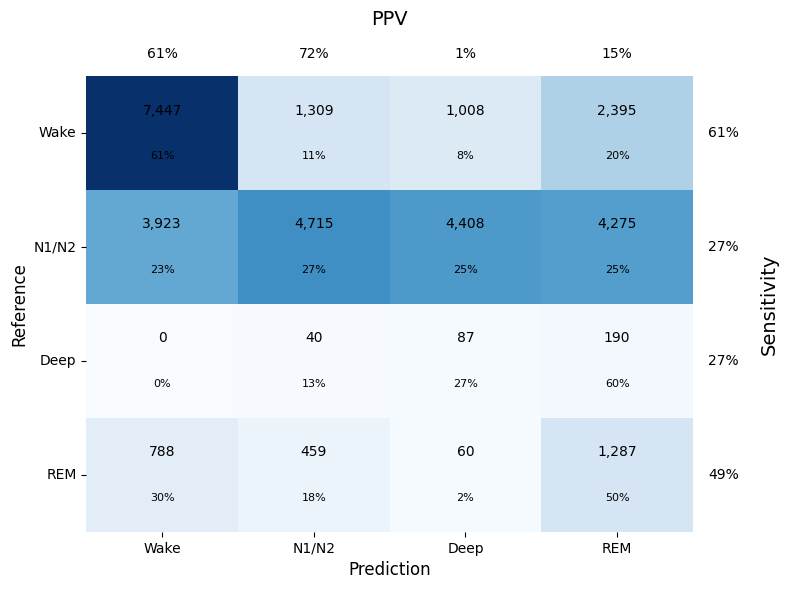

Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/BaselineGRU/cms/cm_model9.png
Done with loop 9


In [18]:
accs = []
kappas = []
aurocs = []
cms = []
train_times = []
test_times = []
for i in range(10):
    model, train_time = train_model(
        batch_size = batch_size,
        dropout_embed = dropout_embed,
        acc_preprocess = acc_preprocess,
        RNN_type = RNN_type,
        lr = lr,
        rnn_hidden_size = rnn_hidden_size,
        pre_rnn_size = pre_rnn_size,
        hidden_size2 = hidden_size2,
        dropout_rnn = dropout_rnn,
        dropout_hidden2 = dropout_hidden2,
        modelType = modelType,
        nameAppend = f"model{i}")
    print(f"Trained model {i} in {train_time} seconds")
    acc, kappa, auroc, cm, inference_time_seconds = evaluate_model(model, test_loader, modelType, i)
    accs.append(acc)
    kappas.append(kappa)
    aurocs.append(auroc)
    cms.append(cms)
    train_times.append(train_time)
    test_times.append(inference_time_seconds)
    print(f"Done with loop {i}")

In [19]:
acc_mean, acc_std = np.mean(accs), np.std(accs)
kappa_mean, kappa_std = np.mean(kappas), np.std(kappas)
auroc_mean, auroc_std = np.mean(aurocs), np.std(aurocs)
train_time_mean, train_time_std = np.mean(train_times), np.std(train_times)
test_time_mean, test_time_std = np.mean(test_times), np.std(test_times)

# Print the statistics
print(f"Accuracy: Mean = {acc_mean:.3f}, StdDev = {acc_std:.3f}")
print(f"Kappa: Mean = {kappa_mean:.3f}, StdDev = {kappa_std:.3f}")
print(f"AUROC: Mean = {auroc_mean:.3f}, StdDev = {auroc_std:.3f}")

# Find the index of the best kappa
best_kappa_index = np.argmax(kappas)
print(f"Best Kappa Index: {best_kappa_index}")

# Find the index of the best acc
best_acc_index = np.argmax(accs)
print(f"Best Accuracy Index: {best_acc_index}")

# Find the index of the best AUROC
best_auroc_index = np.argmax(aurocs)
print(f"Best AUROC Index: {best_auroc_index}")

Accuracy: Mean = 0.376, StdDev = 0.061
Kappa: Mean = 0.159, StdDev = 0.036
AUROC: Mean = 0.630, StdDev = 0.028
Best Kappa Index: 2
Best Accuracy Index: 2
Best AUROC Index: 8
